In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from scipy.stats import chisquare, binomtest
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [2]:
dir_fig = 'fragile_x_all/'

In [3]:
### read methylation data instead of generating it again
### skip to plotting
file_methyl_in = f'{dir_fig}/methylation_table_complete.tsv'
df_methyl = pd.read_table(file_methyl_in, header=0, index_col=0, sep='\t', dtype={'in_trios': str, 'has_both_hps': str, 'both_hps_2_reads': str, 'both_hps_3_reads': str})
pd.set_option('display.max_columns', None)
display(df_methyl)
pd.set_option('display.max_columns', 10)

bp_dev_h1                        xci_read_mean_methyl_lik_h1  \
REACH000026           .                                                NaN   
REACH000058           .                                                NaN   
REACH000065           .                                                NaN   
REACH000066          32                                            1,12,34   
REACH000067           .                                                NaN   
...                 ...                                                ...   
REACH000681           .                                                  5   
REACH000682  31,28,.,24  2,63,56,6,31,89,81,3,69,52,66,69,2,17,60,2,78,...   
REACH000683           .                                                NaN   
REACH000684    30,24,24                                                NaN   
REACH000685           .                                                 23   

            bp_dev_h2                        xci_read_mean_methyl_lik_h2  \
REACH000026         .                                                NaN   
REACH000058         .                                                NaN   
REACH000065         .                                                NaN   
REACH000066  31,43,30                                               87,0   
REACH000067         .                                                 15   
...               ...                                                ...   
REACH000681         .                                                 16   
REACH000682     12,14  71,20,2,54,41,43,8,3,7,5,8,58,54,94,57,48,4,84...   
REACH000683         .                                                NaN   
REACH000684  23,15,24                                                NaN   
REACH000685         .                                                2,9   

                        bp_dev_h0  \
REACH000026                     .   
REACH000058  51,51,51,57,51,51,52   
REACH000065                    30   
REACH000066                     .   
REACH000067                     .   
...                           ...   
REACH000681           -6,-8,-6,25   
REACH000682             30,26,-12   
REACH000683           31,26,23,31   
REACH000684                     .   
REACH000685        13,17,33,29,16   

                                   xci_read_mean_methyl_lik_h0  \
REACH000026                   22,10,10,0,2,7,4,2,20,19,20,2,18   
REACH000058  3,4,9,10,2,2,7,2,39,8,12,1,17,0,0,1,1,14,29,10...   
REACH000065                                               9,10   
REACH000066                                         71,77,1,88   
REACH000067                      7,0,11,23,55,0,2,3,4,0,0,8,46   
...                                                        ...   
REACH000681  3,47,10,23,3,1,9,9,2,17,1,3,0,6,2,16,4,6,14,11...   
REACH000682                                          80,73,0,0   
REACH000683  2,6,4,1,1,20,7,4,33,9,19,4,1,1,0,0,6,6,3,2,1,2...   
REACH000684  2,4,5,7,3,0,27,1,10,4,2,6,6,0,28,1,6,12,1,87,5...   
REACH000685  18,31,2,13,35,6,2,8,21,40,4,3,24,17,2,17,16,6,...   

                                                     methyl_h1  \
REACH000026                                                  .   
REACH000058                                                  .   
REACH000065                                                  .   
REACH000066  91|95|100|99|96|100|99|98|98|96|96|97|94|99|98...   
REACH000067                                                  .   
...                                                        ...   
REACH000681                                                  .   
REACH000682  0|0|0|9|8|4|3|3|0|0|0|0|21|0|0|0|2|8|0|0|3|5|1...   
REACH000683                                                  .   
REACH000684  3|58|0|2|5|0|0|0|0|0|0|0|0|0|0|0|0|0|0|14|0|0|...   
REACH000685                                                  .   

                                                     methyl_h2  \
REACH000026                                                  .   
R

In [4]:
def format_sci_notation(num):
    base, exp = f"{num:.1e}".split('e')
    exp = int(exp)
    superscript = ''.join("⁰¹²³⁴⁵⁶⁷⁸⁹"[int(d)] if d.isdigit() else '⁻' for d in str(exp))
    return f"{base} × 10{superscript}"
print(format_sci_notation(1.2e-5))  # Output: 1.0 × 10⁵

1.2 × 10⁻⁵


In [ ]:
### make the methylation data instead of reading from file

In [7]:
file_in = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/METHYLATION/snoopsv_methyl/FMR1_ALL/methyl_data.tsv'
df = pd.read_table(file_in, sep='\t', header=0, keep_default_na=False)
df = df.loc[df.region_id.str.contains('_5UTR')].copy()

### add other select genes with high coverage in both haplotypes in the 5 gray-zone subjects
file_in_og = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/METHYLATION/snoopsv_methyl/chrX_All_Genes/RUN_SELECT_GENES/methyl_data.tsv'
df_og = pd.read_table(file_in_og, sep='\t', header=0, keep_default_na=False)
df = pd.concat([df, df_og], ignore_index=True)

print('df:')
display(df)

file_sam = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/METHYLATION/snoopsv_methyl/FMR1_ALL/methyl_data_sample_order.txt'
with open(file_sam, 'r') as fh:
    sample_order = fh.readline().split(',')[:-1] # last one is an empty string
print(f'number of samples: {len(sample_order)}')
#print(f'sample order: {sample_order}')

df:


chrom        pos        end      region_id  \
0   chrX  147911920  147912179      FMR1_5UTR   
1   chrX  149505139  149505306       IDS_5UTR   
2   chrX  149631582  149631792  TMEM185A_5UTR   
3   chrX  150363318  150363530    MAMLD1_5UTR   
4   chrX  150568622  150568662      MTM1_5UTR   
5   chrX  150693397  150693530     MTMR1_5UTR   
6   chrX  150898590  150898668    CD99L2_5UTR   
7   chrX  150983336  150983376     HMGB3_5UTR   
8   chrX    2691296    2691360      CD99_5UTR   
9   chrX   38220794   38220871      SRPX_5UTR   
10  chrX  102142354  102142505    TCEAL6_5UTR   
11  chrX  119758589  119758667    SOWAHD_5UTR   

                                            methyl_h1  \
0   .;.;.;91|95|100|99|96|100|99|98|98|96|96|97|94...   
1   .;.;.;8|2|2|1|0|0|0|0|0|1|0|7|1|0|3|2|1|4|0|0|...   
2   .;.;.;.;.;.;95|91|35|70|18|12|12|62|41|61|26|6...   
3   .;.;.;3|2|5|5|4|1|3|3|1|0|0|0|0|0|0|0|0|0|0|4|...   
4   .;.;.;.;.;.;.;.;.;3|13|4|2|0|0,98|99|98|95|97|...   
5   .;.;.;.;.;.;.;.;.;2|1|2|10|11|5|3|2|3|1|1|5|18...   
6   .;.;.;8|7|9|52|43|81|48|25;.;.;88|47|83|82|98|...   
7   .;.;.;.;.;.;100|100|100|100|100,11|61|12|40|64...   
8   2|1|1|1|5|31|19|39,0|0|0|0|0|0|0|0,43|10|8|2|1...   
9   .;.;.;.;.;.;0|1|1|12|7|12|5|2|2|2|1,1|0|0|0|0|...   
10  .;.;.;.;.;.;11|32|35|20|20|57|48|19|18|41|21|2...   
11  .;.;.;.;.;.;.;.;.;2|7|11|20|60|34|61,1|2|21|55...   

                                            methyl_h2  \
0   .;.;.;64|20|7|2|0|0|0|0|0|0|2|0|1|0|0|0|0|0|3|...   
1   .;.;.;62|51|80|91|75|95|89|98|99|98|97|99|99|9...   
2   .;.;.;.;73|60|29|4|2|7|3|1|1|1|1|0|0|0|8|17|11...   
3   .;.;.;.;.;.;71|65|46|44|7|4|0|0|0|0|0|2|64|66|...   
4   .;.;.;.;.;.;.;.;.;100|100|100|100|100|100,45|5...   
5   .;.;.;.;.;.;.;.;.;.;.;.;2|0|0|5|2|5|12|23|34|4...   
6   .;.;.;2|0|0|1|0|0|0|0;.;.;0|0|0|0|0|0|0|13,62|...   
7   .;.;.;.;.;.;29|50|50|41;.;93|98|98|85|95;70|67...   
8   2|4|1|0|0|0|0|0,0|2|1|2|2|4|1|5;0|0|4|8|6|21|3...   
9   .;.;.;.;.;.;.;.;.;99|99|100|99|98|87|72|57|27|...   
10  .;.;.;.;.;.;38|98|100|100|99|95|92|38|1|2|0|4|...   
11  .;.;.;.;.;.;.;.;.;0|0|0|0|0|0|0,0|0|0|0|0|0|0;...   

                                            methyl_h0  \
0   .;0|0|0|0|0|0|0|1|2|32|27|13|7|5|46|27|29|15|3...   
1   .;0|2|0|1|0|1|6|2|1|8|9|13|6|3|4|8|5|0|1|0|0|0...   
2   5|0|0|0|0|13|5|7|20|56|43|61|72|96|91|64|21|11...   
3   0|2|2|2|0|0|1|6|1|3|2|49|71|55|13|6|11|26|7|5|...   
4   1|0|0|0|0|0,2|4|2|0|0|6,7|14|13|9|1|0,2|13|6|0...   
5   6|4|6|5|10|63|82|90|76|34|11|6|1|2|2|1|1|3|2|4...   
6   0|0|1|0|1|1|6|4,1|1|1|4|3|16|46|69;0|0|0|0|1|1...   
7   .;2|11|5|2|6,2|1|15|3|11,5|9|6|2|0;.;.;80|76|5...   
8   .;.;.;.;.;.;.;.;.;.;.;.;.;.;.;.;.;.;.;.;.;.;.;...   
9   .;7|5|5|2|2|5|1|6|15|40|65,9|34|38|11|6|1|0|0|...   
10  .;0|1|3|19|6|4|4|0|0|0|0|0|0|0|0|0|0|1;5|3|18|...   
11  .;0|0|0|0|0|0|0,0|0|0|0|0|0|0,10|1|0|0|0|0|0,0...   

                                            bp_dev_h1  \
0   .;.;.;32;.;.;30;.;31,30;34;27,27,27,29;.;.;.;3...   
1   .;.;.;1;.;.;.;.;.;2;.;.;.;.;0,0,2;.;.;-1,1,0;....   
2   .;.;.;.;.;.;-21,-21,-21;.;-21,-15;.;15,9;.;0;....   
3   .;.;.;0;.;.;-1;.;0,0;32,33,35,29,29,34,34;1,-1...   
4   .;.;.;.;.;.;.;.;.;0,0;0,0;.;0,0,0;.;.;.;.;0,0;...   
5   .;.;.;.;.;.;.;.;.;1,0,1,0,2,0;1,2,2,1,1;.;.;.;...   
6   .;.;.;1;.;.;0,1;.;0;0,0,-1;0,0;.;0,0,1;.;.;.;....   
7   .;.;.;.;.;.;0,1,0;.;.;0,0,0;0,0,0;.;0,0;.;.;.;...   
8   0,0,0;0;1,2,3,0;.;.;0;1,0,0;0;0,0;0,0,0,0,0;0;...   
9   .;.;.;.;.;.;0,0,0;.;-1,0;0,0,0;0,1,0;.;0;.;1;....   
10  .;.;.;.;.;.;2,2,0,0;.;.;4;0;.;.;.;.;.;.;.;.;.;...   
11  .;.;.;.;.;.;.;.;.;0,0,-2;.;.;-1,1,.;.;.;.;.;-1...   

                                            bp_dev_h2  \
0   .;.;.;31,43,30;.;.;30,28,28,31;.;30,30,32;34,2...   
1   .;.;.;0;.;.;.;.;.;.;.;.;.;.;.;.;.;1,0,1;.;.;.;...   
2   .;.;.;.;-21;.;.,9,0;.;-21,-21;.;-21;.;-11;.;.;...   
3   .;.;.;.;.;.;1,3;.;.;1,2,2;0,1,3;.;1,1;.;1,0;.;...   
4   .;.;.;.;.;.;.;.;.;0,2;0;.;0,-1;.;.;.;.;1;.;.;....   
5   .;.;.;.;.;.;.;.;.;.;.;.;-1,1,-1;.;0,2,3;.;.;0,...  

number of samples: 270


In [8]:
df_exnd = df[['chrom' ,'pos', 'end', 'region_id']].copy()
cols = df.columns.tolist()[4:]
#print(cols)

for idx, sample in enumerate(sample_order):
    #if sample == 'REACH000450' or sample == 'REACH000452':
    #    continue
    for col in cols:
        df_exnd[f'{sample}_{col}'] = df[col].str.split(';').apply(lambda row: row[idx])
display(df_exnd)

chrom        pos        end      region_id  \
0   chrX  147911920  147912179      FMR1_5UTR   
1   chrX  149505139  149505306       IDS_5UTR   
2   chrX  149631582  149631792  TMEM185A_5UTR   
3   chrX  150363318  150363530    MAMLD1_5UTR   
4   chrX  150568622  150568662      MTM1_5UTR   
5   chrX  150693397  150693530     MTMR1_5UTR   
6   chrX  150898590  150898668    CD99L2_5UTR   
7   chrX  150983336  150983376     HMGB3_5UTR   
8   chrX    2691296    2691360      CD99_5UTR   
9   chrX   38220794   38220871      SRPX_5UTR   
10  chrX  102142354  102142505    TCEAL6_5UTR   
11  chrX  119758589  119758667    SOWAHD_5UTR   

                                REACH000026_methyl_h1  \
0                                                   .   
1                                                   .   
2                                                   .   
3                                                   .   
4                                                   .   
5                                                   .   
6                                                   .   
7                                                   .   
8   2|1|1|1|5|31|19|39,0|0|0|0|0|0|0|0,43|10|8|2|1...   
9                                                   .   
10                                                  .   
11                                                  .   

              REACH000026_methyl_h2  \
0                                 .   
1                                 .   
2                                 .   
3                                 .   
4                                 .   
5                                 .   
6                                 .   
7                                 .   
8   2|4|1|0|0|0|0|0,0|2|1|2|2|4|1|5   
9                                 .   
10                                .   
11                                .   

                                REACH000026_methyl_h0 REACH000026_bp_dev_h1  \
0                                                   .                     .   
1                                                   .                     .   
2   5|0|0|0|0|13|5|7|20|56|43|61|72|96|91|64|21|11...                     .   
3   0|2|2|2|0|0|1|6|1|3|2|49|71|55|13|6|11|26|7|5|...                     .   
4   1|0|0|0|0|0,2|4|2|0|0|6,7|14|13|9|1|0,2|13|6|0...                     .   
5   6|4|6|5|10|63|82|90|76|34|11|6|1|2|2|1|1|3|2|4...                     .   
6                  0|0|1|0|1|1|6|4,1|1|1|4|3|16|46|69                     .   
7                                                   .                     .   
8                                                   .                 0,0,0   
9                                                   .                     .   
10                                                  .                     .   
11                                                  .                     .   

   REACH000026_bp_dev_h2 REACH000026_bp_dev_h0  ...  \
0                      .                     .  ...   
1                      .                     .  ...   
2                      .               -21,-19  ...   
3                      .                    -1  ...   
4                      .             0,0,0,0,0  ...   
5                      .                 1,0,0  ...   
6                      .                   0,0  ...   
7                      .                     .  ...   
8                    0,0                     .  ...   
9                      .                     .  ...   
10                     .                     .  ...   
11                     .                     .  ...   

                                REACH000685_methyl_h2  \
0                                                   .   
1                                                   .   
2                                                   .   
3                                                   .   
4                                                   .   
5                            

In [8]:
file_cov = '/expanse/projects/sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
#file_cov = '/tscc/projects/ps-sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
df_cov = pd.read_table(file_cov, header=0, sep='\t')
multiplat_samples = ['REACH000236', 'REACH000530', 'REACH000531', 'REACH000532', 'REACH000436']
df_cov['SAMPLE'] = df_cov.apply(lambda row: row['SAMPLE']+'_'+row['COHORT'] if row['SAMPLE'] in multiplat_samples else row['SAMPLE'], axis=1)
df_cov_high = df_cov.loc[df_cov.SAMPLE.str.startswith('REACH000') & (df_cov.MEAN_COVERAGE > 9)]
display(df_cov)
high_cov_samples = df_cov_high.SAMPLE.tolist()
#print(high_cov_samples)

def get_plat(sample):
    try:
        ret = df_cov[df_cov.SAMPLE == sample]['COHORT'].values[0]
    except:
        print(f'problem with samples: {sample}')
        ret = ''
    return ret

def get_cov(sample):
    try:
        ret = df_cov[df_cov.SAMPLE == sample]['MEAN_COVERAGE'].values[0]
    except:
        print(f'problem with samples: {sample} in get_cov')
        ret = ''
    return ret

plat_dict = {sample: get_plat(sample) for sample in df_cov.SAMPLE.tolist()}
plat_dict['REACH000226_blood'] = plat_dict['REACH000226']
plat_dict['REACH000226_sperm'] = plat_dict['REACH000226']
#print('plat_dict:')
#print(plat_dict)

cov_dict = {sample: get_cov(sample) for sample in df_cov.SAMPLE.tolist()}
#print('cov_dict:')
#print(cov_dict)

SAMPLE COHORT  MEAN_COVERAGE
0          HG004    ONT          81.44
1    REACH000626    ONT          10.51
2    REACH000546    ONT          10.87
3    REACH000683    ONT           9.97
4    REACH000563    ONT           8.68
..           ...    ...            ...
283  REACH000284     PB           3.43
284  REACH000672     PB           5.02
285  REACH000292     PB           9.00
286  REACH000066     PB           1.61
287     2602-2-1     PB           0.89

[288 rows x 3 columns]

In [9]:
file_psam = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/process_IL_LR/HWE/REACH_LR_platform.psam'
df_p = pd.read_table(file_psam, sep='\t', header=None, names = ['famid', 'sample_id', 'dad', 'mom', 'sex', 'phen'])
#print('df_p:')
#display(df_p)
ds_sex = df_p.set_index('sample_id').sex
#display(ds_sex)

# make mom and dad dictionary
sample_dad_dict = {}
sample_mom_dict = {}
for sample, dad, mom in zip(df_p.sample_id, df_p.dad, df_p.mom):
    #print(sample, dad, mom)
    sample_dad_dict[sample] = dad
    sample_mom_dict[sample] = mom

#print('complete trios:')
df_trios = df_p.loc[df_p.dad.isin(df_p.sample_id) & df_p.mom.isin(df_p.sample_id)]
print('df_trios:')
display(df_trios.shape)

### make a samples dataframe containing all samples in complete trios
df_samples = pd.DataFrame()
df_samples['sample_id'] = df_trios['sample_id']
df_samples['rel'] = 'C'

df_dads = pd.DataFrame()
df_dads['sample_id'] =  list(set(df_trios['dad'].tolist()))
df_dads['rel'] = 'D'
df_samples = pd.concat([df_samples, df_dads])

df_moms = pd.DataFrame()
df_moms['sample_id'] =  list(set(df_trios['mom'].tolist()))
df_moms['rel'] = 'M'
df_samples = pd.concat([df_samples, df_moms])

df_samples['sex'] = df_samples.sample_id.map(ds_sex)
df_samples['plat'] = df_samples.sample_id.map(plat_dict)
df_samples['coverage'] = df_samples.sample_id.map(cov_dict)
### add blood/sperm sections for REACH000226
row_add = pd.DataFrame({'sample_id':['REACH000226_blood', 'REACH000226_sperm'] ,'rel':['D', 'D'] ,'sex':[1, 1] ,'plat':['ONT', 'ONT'] ,'coverage':[1.92, 27.87]})
df_samples = pd.concat([df_samples, row_add])
pd.set_option('display.max_rows', 10)
print('df_samples:')
display(df_samples)

print(df_samples.sex.value_counts())
print(df_samples.plat.value_counts())
print(df_samples.rel.value_counts())

print('===============================')
df_samples_flt = df_samples.loc[(df_samples.coverage>=2)]
print('df_samples_flt:')
display(df_samples_flt.shape)

print('===============================')
df_samples_flt_female_kids = df_samples_flt.loc[(df_samples_flt.sex==2)&(df_samples_flt.rel=='C')]
print('df_samples_flt_female_kids:')
display(df_samples_flt_female_kids.shape)
print(df_samples_flt_female_kids.plat.value_counts())

print('===============================')
df_samples_flt_females = df_samples_flt.loc[(df_samples_flt.sex==2)]
print('df_samples_flt_females:')
display(df_samples_flt_females.shape)
print(df_samples_flt_females.plat.value_counts())
print(df_samples_flt_females.rel.value_counts())

print('===============================')
df_samples_flt_males = df_samples_flt.loc[(df_samples_flt.sex==1)]
print('df_samples_flt_males:')
display(df_samples_flt_males.shape)
print(df_samples_flt_males.plat.value_counts())
print(df_samples_flt_males.rel.value_counts())
print(df_samples_flt_males.sample_id.tolist())

df_trios:


(117, 6)

df_samples:


sample_id rel  sex plat  coverage
10        REACH000026   C    1   PB      3.22
11        REACH000058   C    1   PB      6.19
12        REACH000065   C    1   PB      1.22
15        REACH000086   C    1   PB      2.70
18        REACH000089   C    2   PB      3.27
..                ...  ..  ...  ...       ...
60        REACH000661   M    2  ONT     11.54
61        REACH000645   M    2   PB      1.02
62        REACH000269   M    2   PB      1.17
0   REACH000226_blood   D    1  ONT      1.92
1   REACH000226_sperm   D    1  ONT     27.87

[245 rows x 5 columns]

sex
1    139
2    106
Name: count, dtype: int64
plat
PB     142
ONT    103
Name: count, dtype: int64
rel
C    117
D     65
M     63
Name: count, dtype: int64
df_samples_flt:


(206, 5)

df_samples_flt_female_kids:


(39, 5)

plat
ONT    23
PB     16
Name: count, dtype: int64
df_samples_flt_females:


(93, 5)

plat
PB     47
ONT    46
Name: count, dtype: int64
rel
M    54
C    39
Name: count, dtype: int64
df_samples_flt_males:


(113, 5)

plat
PB     57
ONT    56
Name: count, dtype: int64
rel
C    62
D    51
Name: count, dtype: int64
['REACH000026', 'REACH000058', 'REACH000086', 'REACH000097', 'REACH000120', 'REACH000159', 'REACH000162', 'REACH000182', 'REACH000185', 'REACH000194', 'REACH000197', 'REACH000214', 'REACH000222', 'REACH000233', 'REACH000287', 'REACH000288', 'REACH000291', 'REACH000292', 'REACH000293', 'REACH000356', 'REACH000441', 'REACH000537', 'REACH000643', 'REACH000650', 'REACH000653', 'REACH000671', 'REACH000708', 'REACH000730', 'REACH000747', 'REACH000750', 'REACH000762', 'REACH000767', 'REACH000001', 'REACH000154', 'REACH000400', 'REACH000403', 'REACH000414', 'REACH000419', 'REACH000422', 'REACH000423', 'REACH000426', 'REACH000427', 'REACH000428', 'REACH000448', 'REACH000476', 'REACH000483', 'REACH000501', 'REACH000514', 'REACH000517', 'REACH000529', 'REACH000532_ONT', 'REACH000540', 'REACH000544', 'REACH000558', 'REACH000559', 'REACH000560', 'REACH000564', 'REACH000626', 'REACH000663', 'REACH000681'

In [10]:
meta_file = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/REACH_sample_info.tsv'
df_meta = pd.read_table(meta_file, sep='\t', header=0)

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_meta['Sample_ID_orig'] = df_meta['Sample_ID']
df_meta['Sample_ID'] = df_meta.apply(lambda row: rename_samples_dict[row['Sample_ID']] 
                                     if row['Sample_ID'] in rename_samples_dict else row['Sample_ID'], axis=1)

aff_dict = {}
for sample, aff in zip(df_meta['Sample_ID'].tolist(), df_meta['Affected'].tolist()):
    aff_dict[sample] = aff

In [11]:
file_pca = '/expanse/projects/sebat1/j3guevar/SFARI/aspera-sf/SFARI_DS468588/data/master_phen_4.SBayesR.20210915.csv'

df_pca = pd.read_table(file_pca, sep=',', header=0)
cols = ['fid', 'iid', 'phen','sex','cohort','duo','family','is_eur','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10', 
        'PC1_PAT','PC2_PAT','PC3_PAT','PC4_PAT','PC5_PAT','PC6_PAT','PC7_PAT','PC8_PAT','PC9_PAT','PC10_PAT', 
        'PC1_MAT','PC2_MAT','PC3_MAT','PC4_MAT','PC5_MAT','PC6_MAT','PC7_MAT','PC8_MAT','PC9_MAT','PC10_MAT']
df_pca = df_pca[cols]

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_pca['iid'] = df_pca.apply(lambda row: rename_samples_dict[row['iid']] if row['iid'] in rename_samples_dict else row['iid'], axis=1)
#display(df_pca)

# first filter for the kids, then add parents to them
df_pca_flt = df_pca.loc[df_pca.iid.isin(df_trios.sample_id)].copy()
df_pca_flt['rel'] = 'C'
#print('df_pca_flt:')
#display(df_pca_flt)

df_parents = pd.DataFrame()
for index, row in df_pca_flt.iterrows():
    sample = row['iid']
    fid = row['fid']
    phen = row['phen']
    is_eur = row['is_eur']
    pc_mat = [row[f'PC{x}_MAT'] for x in range(1,11)]
    pc_pat = [row[f'PC{x}_PAT'] for x in range(1,11)]
    dad = sample_dad_dict[sample]
    mom = sample_mom_dict[sample]
    
    dict_mat = {'fid': [fid], 'iid': [mom], 'phen': ['.'], 'sex': ['Female'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_mat.update({f'PC{x}': [pc_mat[x-1]] for x in range(1,11)})
    df_mat = pd.DataFrame(dict_mat)

    dict_pat = {'fid': [fid], 'iid': [dad], 'phen': ['.'], 'sex': ['Male'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_pat.update({f'PC{x}': [pc_pat[x-1]] for x in range(1,11)})
    df_pat = pd.DataFrame(dict_pat)
    
    if df_parents.shape[0] == 0 or mom not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_mat])
    if df_parents.shape[0] == 0 or dad not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_pat])

df_parents['rel'] = 'P'
#print('df_parents:')
#display(df_parents)

df_pca_flt = pd.concat([df_pca_flt, df_parents])

df_pca_flt = pd.merge(df_pca_flt, df_meta[['Sample_ID', 'Affected', 'Affected_ASD']], how='inner', left_on='iid', right_on='Sample_ID')
df_pca_flt = pd.merge(df_pca_flt, df_cov[['SAMPLE', 'MEAN_COVERAGE']], how='inner', left_on='iid', right_on='SAMPLE')

df_pca_flt['Phenotype'] = df_pca_flt.apply(lambda row: 1 if row.Affected == 'Yes' else 0, axis=1)
#df_pca_flt['Phenotype_ASD'] = df_pca_flt.apply(lambda row: 1 if row.Affected_ASD == 'Yes' else 0, axis=1)
df_pca_flt['Platform'] = df_pca_flt.apply(lambda row: get_plat(row.iid), axis=1)

### make a original iid w/o platform for the handfull of samples
df_pca_flt['iid_orig'] = df_pca_flt.iid.str.split('_').str[0]

print('df_pca_flt:')
display(df_pca_flt)

df_pca_flt:


fid          iid phen     sex  cohort   duo  family  is_eur       PC1  \
0    F0001  REACH000001  ASD    Male       1  trio     1.0       1  0.008627   
1    F0026  REACH000026  ASD    Male       1  trio     1.0       0  0.095364   
2    F0058  REACH000058  ASD    Male       1  trio     1.0       1  0.002422   
3    F0065  REACH000065  ASD    Male       1  trio     1.0       0  0.252774   
4    F0078  REACH000086  ASD    Male       1  trio     2.0       0  0.044785   
..     ...          ...  ...     ...     ...   ...     ...     ...       ...   
238  F0288  REACH000756    .    Male       1     .     NaN       0  0.204041   
239  F0290  REACH000763    .  Female       1     .     NaN       1 -0.030630   
240  F0290  REACH000764    .    Male       1     .     NaN       1 -0.027327   
241  F0291  REACH000768    .  Female       1     .     NaN       0  0.091442   
242  F0291  REACH000769    .    Male       1     .     NaN       0  0.086006   

          PC2  ...  PC10_MAT  rel    Sample_ID  Affected  Affected_ASD  \
0   -0.005607  ... -0.014983    C  REACH000001       Yes           Yes   
1   -0.045230  ... -0.011925    C  REACH000026       Yes           Yes   
2   -0.009216  ...  0.016383    C  REACH000058       Yes           Yes   
3    0.107933  ... -0.009906    C  REACH000065       Yes           Yes   
4    0.038065  ... -0.018303    C  REACH000086       Yes           Yes   
..        ...  ...       ...  ...          ...       ...           ...   
238  0.127559  ...       NaN    P  REACH000756        No            No   
239  0.003052  ...       NaN    P  REACH000763        No            No   
240 -0.004878  ...       NaN    P  REACH000764        No            No   
241 -0.016917  ...       NaN    P  REACH000768        No            No   
242 -0.003008  ...       NaN    P  REACH000769        No            No   

          SAMPLE  MEAN_COVERAGE  Phenotype  Platform     iid_orig  
0    REACH000001          10.15          1       ONT  REACH000001  
1    REACH000026           3.22          1        PB  REACH000026  
2    REACH000058           6.19          1        PB  REACH000058  
3    REACH000065           1.22          1        PB  REACH000065  
4    REACH000086           2.70          1        PB  REACH000086  
..           ...            ...        ...       ...          ...  
238  REACH000756           1.55          0        PB  REACH000756  
239  REACH000763           3.36          0        PB  REACH000763  
240  REACH000764           1.20          0        PB  REACH000764  
241  REACH000768           0.10          0        PB  REACH000768  
242  REACH000769           1.11          0        PB  REACH000769  

[243 rows x 47 columns]

In [ ]:
### not needed really
file_tr_gts = 'fragile_x/FMR1_repeat_gts.tsv'
df_tr_gts = pd.read_table(file_tr_gts, header=0, sep='\t')
display(df_tr_gts)

### generate a dataframe showing haplotype repeat length for each sample/hap in LongTR genotype
this_df = df_tr_gts.loc[df_tr_gts.GB!='.'].copy()
this_df[['h1_bp_dev', 'h2_bp_dev']] = this_df.GB.str.split('|', expand=True).astype(int)
this_df[['h1_rep', 'h2_rep']] = (this_df[['h1_bp_dev', 'h2_bp_dev']] / 3).apply(round).astype(int) + 20
#this_df = this_df.set_index('Sample_id')
#display(this_df)

df_ltr = pd.DataFrame()
df_tmp = this_df[['Sample_id', 'h1_rep']].copy()
df_tmp['hp_tag'] = 'h1'
df_tmp = df_tmp.rename(columns={'Sample_id': 'subject', 'h1_rep': 'hp_rep'})
#display(df_tmp)
df_ltr = pd.concat([df_ltr, df_tmp])
df_tmp = this_df[['Sample_id', 'h2_rep']].copy()
df_tmp['hp_tag'] = 'h2'
df_tmp = df_tmp.rename(columns={'Sample_id': 'subject', 'h2_rep': 'hp_rep'})
df_ltr = pd.concat([df_ltr, df_tmp])
df_ltr = df_ltr.set_index(['subject', 'hp_tag'])
print('df_ltr:')
display(df_ltr)

In [ ]:
####################################### These cells below are written newly: 
####################################### generate a table of samples, and plot large vs small haplotype 
####################################### with classification and GMM models

In [9]:
### make a table of raw data for the paper.
pd.set_option('display.max_columns', None)
region_id = 'FMR1_5UTR'
xci_region_ids = ['IDS_5UTR', 'TMEM185A_5UTR', 'MAMLD1_5UTR', 'MTM1_5UTR', 'MTMR1_5UTR', 'CD99L2_5UTR', 'HMGB3_5UTR']
df_methyl = pd.DataFrame()

this_idx = df_exnd.loc[df_exnd.region_id==region_id].index.tolist()[0]
cols_bp = [f'bp_dev_h1', f'bp_dev_h2', f'bp_dev_h0']
cols_met = [f'methyl_h1', f'methyl_h2', f'methyl_h0']
for col in cols_bp+cols_met:
    col_out = f'xci_read_mean_methyl_lik_{col.split("_")[-1]}'
    df_methyl[col] = pd.Series(dtype='str')
    df_methyl[col_out] = pd.Series(dtype='str')

for sample in sample_order:
    #print(sample)
    #sample = 'REACH000561'
    
    ### set bp deviation columns
    for col in cols_bp:
        df_methyl.loc[sample, col] = df_exnd.loc[df_exnd.region_id==region_id].loc[this_idx, f'{sample}_{col}']
    
    ### set FMR1 methylation columns
    for col in cols_met:
        df_methyl.loc[sample, col] = df_exnd.loc[df_exnd.region_id==region_id].loc[this_idx, f'{sample}_{col}']

    ### set 7 XCI gene methylation columns
    for col in cols_met:
        col_out = f'xci_read_mean_methyl_lik_{col.split("_")[-1]}'
        read_met_list = [y for x in df_exnd.loc[df_exnd.region_id.isin(xci_region_ids)][f'{sample}_{col}'].tolist() for y in x.split(',') if y!='.']
        df_methyl.loc[sample, col_out] = ','.join([str(round(np.mean([float(xx) for xx in x.split('|')]))) for x in read_met_list])

#df_methyl = df_methyl.fillna('.')
#display(df_methyl)

### correct phasing of REACH000563 and REACH000561 manually
bp_dev_thr = 60
if ('REACH000563' in df_methyl.index):
    this_sample = 'REACH000563'
    # h1 and h2 are empty and we want to make them from h0 based on bp deviation
    df_methyl.loc[this_sample, 'bp_dev_h2'] = ','.join([x for x in df_methyl.loc[this_sample, 'bp_dev_h0'].split(',') if x != '.' and float(x)>bp_dev_thr])
    df_methyl.loc[this_sample, 'bp_dev_h1'] = ','.join([x for x in df_methyl.loc[this_sample, 'bp_dev_h0'].split(',') if x != '.' and float(x)<bp_dev_thr])
    df_methyl.loc[this_sample, 'methyl_h2'] = ','.join([m for b, m in zip(df_methyl.loc[this_sample, 'bp_dev_h0'].split(','),  
                                                                          df_methyl.loc[this_sample, 'methyl_h0'].split(',')) if b != '.' and float(b)>bp_dev_thr])
    df_methyl.loc[this_sample, 'methyl_h1'] = ','.join([m for b, m in zip(df_methyl.loc[this_sample, 'bp_dev_h0'].split(','),  
                                                                          df_methyl.loc[this_sample, 'methyl_h0'].split(',')) if b != '.' and float(b)<bp_dev_thr])
    df_methyl.loc[this_sample, 'methyl_h0'] = '.'
    df_methyl.loc[this_sample, 'bp_dev_h0'] = '.'

if ('REACH000561' in df_methyl.index):
    this_sample = 'REACH000561'
    ### first fix h2: bring one read from h1
    # one read in h1 has bp=83 and belongs to h2. we want to bring it in h2
    df_methyl.loc[this_sample, 'bp_dev_h2'] = ','.join(df_methyl.loc[this_sample, 'bp_dev_h2'].split(',') + 
                                               [x for x in df_methyl.loc[this_sample, 'bp_dev_h1'].split(',') if x != '.' and float(x)>bp_dev_thr])
    df_methyl.loc[this_sample, 'methyl_h2'] = ','.join(df_methyl.loc[this_sample, 'methyl_h2'].split(',') + 
                                                       [m for b, m in zip(df_methyl.loc[this_sample, 'bp_dev_h1'].split(','), 
                                                                          df_methyl.loc[this_sample, 'methyl_h1'].split(',')) if b != '.' and float(b)>bp_dev_thr])
    df_methyl.loc[this_sample, 'bp_dev_h1'] = ','.join([x for x in df_methyl.loc[this_sample, 'bp_dev_h1'].split(',') if x != '.' and float(x)<bp_dev_thr])
    df_methyl.loc[this_sample, 'methyl_h1'] = ','.join([m for b, m in zip(df_methyl.loc[this_sample, 'bp_dev_h1'].split(','),  
                                                                          df_methyl.loc[this_sample, 'methyl_h1'].split(',')) if b != '.' and float(b)<bp_dev_thr])
#display(df_methyl)

### compute repeat length based on bp deviation
for col in cols_bp:
    col_out = f'repeat_length_{col.split("_")[-1]}'
    df_methyl[col_out] = df_methyl[col].apply(lambda x: ','.join([str(round(float(xx) / 3) + 20) if xx!='.' else '.' for xx in x.split(',')]))
    
### take average of repeat length
cols_rep_len = [f'repeat_length_h1', f'repeat_length_h2', f'repeat_length_h0']
for col in cols_rep_len:
    df_methyl[f'mean_{col}'] = df_methyl.apply(lambda row: np.mean([float(x) for x in row[col].split(',') if x != '.']) 
                                                 if len([x for x in row[col].split(',') if x != '.'])>0 else '.', axis=1)

### compute mean methylation likelihood for each read
for col in cols_met:
    df_methyl[f'read_mean_methyl_lik_{col.split("_")[-1]}'] = df_methyl.apply(lambda row: ','.join([str(round(np.mean([float(xx) for xx in x.split('|')]))) for x in row[col].split(',') if x != '.'])
                                                                             if row[col] != '.' else '.', axis=1)
#display(df_methyl)
### set number of methylation/unmethylation reads
for col in cols_met:
    hp = col.split("_")[-1]
    df_methyl[f'num_methyl_reads_{hp}'] = df_methyl[f'read_mean_methyl_lik_{hp}'].apply(lambda x: len([xx for xx in x.split(',') if float(xx)>=50]) if x != '.' else '.')
    df_methyl[f'num_unmethyl_reads_{hp}'] = df_methyl[f'read_mean_methyl_lik_{hp}'].apply(lambda x: len([xx for xx in x.split(',') if float(xx)<50]) if x != '.' else '.')
    df_methyl[f'frac_hap_methyl_{hp}'] = df_methyl.apply(lambda row: int(row[f'num_methyl_reads_{hp}'])/(int(row[f'num_methyl_reads_{hp}'])+int(row[f'num_unmethyl_reads_{hp}'])) 
                                                           if (row[f'num_methyl_reads_{hp}']!='.' and row[f'num_unmethyl_reads_{hp}']!='.') else '.', axis=1)

### set 7 XCI gene number of methylation/unmethylation reads
for col in cols_met:
    hp = col.split("_")[-1]
    df_methyl[f'xci_num_methyl_reads_{hp}'] = df_methyl[f'xci_read_mean_methyl_lik_{hp}'].apply(lambda x: len([xx for xx in x.split(',') if float(xx)>=50]) if (x != '.' and x != '') else '.')
    df_methyl[f'xci_num_unmethyl_reads_{hp}'] = df_methyl[f'xci_read_mean_methyl_lik_{hp}'].apply(lambda x: len([xx for xx in x.split(',') if float(xx)<50]) if (x != '.' and x != '') else '.')
    df_methyl[f'xci_frac_hap_methyl_{hp}'] = df_methyl.apply(lambda row: int(row[f'xci_num_methyl_reads_{hp}'])/(int(row[f'xci_num_methyl_reads_{hp}'])+int(row[f'xci_num_unmethyl_reads_{hp}'])) 
                                                           if (row[f'xci_num_methyl_reads_{hp}']!='.' and row[f'xci_num_unmethyl_reads_{hp}']!='.') else '.', axis=1)


display(df_methyl)

bp_dev_h1                        xci_read_mean_methyl_lik_h1  \
REACH000026           .                                                      
REACH000058           .                                                      
REACH000065           .                                                      
REACH000066          32                                            1,12,34   
REACH000067           .                                                      
...                 ...                                                ...   
REACH000681           .                                                  5   
REACH000682  31,28,.,24  2,63,56,6,31,89,81,3,69,52,66,69,2,17,60,2,78,...   
REACH000683           .                                                      
REACH000684    30,24,24                                                      
REACH000685           .                                                 23   

            bp_dev_h2                        xci_read_mean_methyl_lik_h2  \
REACH000026         .                                                      
REACH000058         .                                                      
REACH000065         .                                                      
REACH000066  31,43,30                                               87,0   
REACH000067         .                                                 15   
...               ...                                                ...   
REACH000681         .                                                 16   
REACH000682     12,14  71,20,2,54,41,43,8,3,7,5,8,58,54,94,57,48,4,84...   
REACH000683         .                                                      
REACH000684  23,15,24                                                      
REACH000685         .                                                2,9   

                        bp_dev_h0  \
REACH000026                     .   
REACH000058  51,51,51,57,51,51,52   
REACH000065                    30   
REACH000066                     .   
REACH000067                     .   
...                           ...   
REACH000681           -6,-8,-6,25   
REACH000682             30,26,-12   
REACH000683           31,26,23,31   
REACH000684                     .   
REACH000685        13,17,33,29,16   

                                   xci_read_mean_methyl_lik_h0  \
REACH000026                   22,10,10,0,2,7,4,2,20,19,20,2,18   
REACH000058  3,4,9,10,2,2,7,2,39,8,12,1,17,0,0,1,1,14,29,10...   
REACH000065                                               9,10   
REACH000066                                         71,77,1,88   
REACH000067                      7,0,11,23,55,0,2,3,4,0,0,8,46   
...                                                        ...   
REACH000681  3,47,10,23,3,1,9,9,2,17,1,3,0,6,2,16,4,6,14,11...   
REACH000682                                          80,73,0,0   
REACH000683  2,6,4,1,1,20,7,4,33,9,19,4,1,1,0,0,6,6,3,2,1,2...   
REACH000684  2,4,5,7,3,0,27,1,10,4,2,6,6,0,28,1,6,12,1,87,5...   
REACH000685  18,31,2,13,35,6,2,8,21,40,4,3,24,17,2,17,16,6,...   

                                                     methyl_h1  \
REACH000026                                                  .   
REACH000058                                                  .   
REACH000065                                                  .   
REACH000066  91|95|100|99|96|100|99|98|98|96|96|97|94|99|98...   
REACH000067                                                  .   
...                                                        ...   
REACH000681                                                  .   
REACH000682  0|0|0|9|8|4|3|3|0|0|0|0|21|0|0|0|2|8|0|0|3|5|1...   
REACH000683                                                  .   
REACH000684  3|58|0|2|5|0|0|0|0|0|0|0|0|0|0|0|0|0|0|14|0|0|...   
REACH000685                                                  .   

                                                     methyl_h2  \
REACH000026                                                  .   
R

In [10]:
### correction for some large deviation families after averaging over corresponding haplotypes in children and parents
### subjects corrected: 
#REACH000519, C, F
#REACH000518, C, F
#REACH000523, M, F
#REACH000524, D, M

hp_c_h1 = (df_methyl.loc['REACH000519', 'repeat_length_h1'] + ',' + 
           df_methyl.loc['REACH000518', 'repeat_length_h1'] + ',' + 
           df_methyl.loc['REACH000524', 'repeat_length_h0']).split(',')
hp_c_h1 = np.mean([float(x) for x in hp_c_h1])
print(f'hp_c_h1: {hp_c_h1}')
df_methyl.loc['REACH000519', 'mean_repeat_length_h1'] = hp_c_h1
df_methyl.loc['REACH000518', 'mean_repeat_length_h1'] = hp_c_h1
df_methyl.loc['REACH000524', 'mean_repeat_length_h0'] = hp_c_h1

hp_c1_h2 = (df_methyl.loc['REACH000519', 'repeat_length_h2'] + ',' + 
            df_methyl.loc['REACH000523', 'repeat_length_h1']).split(',')
hp_c1_h2 = np.mean([float(x) for x in hp_c1_h2])
print(f'hp_c1_h2: {hp_c1_h2}')
df_methyl.loc['REACH000519', 'mean_repeat_length_h2'] = hp_c1_h2
df_methyl.loc['REACH000523', 'mean_repeat_length_h1'] = hp_c1_h2

hp_c2_h2 = (df_methyl.loc['REACH000518', 'repeat_length_h2'] + ',' + 
            df_methyl.loc['REACH000523', 'repeat_length_h2']).split(',')
hp_c2_h2 = np.mean([float(x) for x in hp_c2_h2])
print(f'hp_c2_h2: {hp_c2_h2}')
df_methyl.loc['REACH000518', 'mean_repeat_length_h2'] = hp_c2_h2
df_methyl.loc['REACH000523', 'mean_repeat_length_h2'] = hp_c2_h2

hp_c_h1: 35.0
hp_c1_h2: 20.833333333333332
hp_c2_h2: 29.444444444444443


In [11]:
### subjects corrected: 
#REACH000563, C, F
#REACH000560, C, M
#REACH000561, M, F
#REACH000562, D, M

hp_c_h1 = (df_methyl.loc['REACH000563', 'repeat_length_h1'] + ',' + 
           df_methyl.loc['REACH000562', 'repeat_length_h0']).split(',')
hp_c_h1 = np.mean([float(x) for x in hp_c_h1])
print(f'hp_c_h1: {hp_c_h1}')
df_methyl.loc['REACH000563', 'mean_repeat_length_h1'] = hp_c_h1
df_methyl.loc['REACH000562', 'mean_repeat_length_h0'] = hp_c_h1

hp_c1_h2 = (df_methyl.loc['REACH000563', 'repeat_length_h2'] + ',' + 
            df_methyl.loc['REACH000561', 'repeat_length_h2']).split(',')
hp_c1_h2 = np.mean([float(x) for x in hp_c1_h2])
print(f'hp_c1_h2: {hp_c1_h2}')
df_methyl.loc['REACH000563', 'mean_repeat_length_h2'] = hp_c1_h2
df_methyl.loc['REACH000561', 'mean_repeat_length_h2'] = hp_c1_h2

hp_m_h1 = (df_methyl.loc['REACH000561', 'repeat_length_h1']).split(',')
hp_m_h1 = np.mean([float(x) for x in hp_m_h1])
print(f'hp_m_h1: {hp_m_h1}')
df_methyl.loc['REACH000561', 'mean_repeat_length_h1'] = hp_m_h1

hp_c_h1: 26.375
hp_c1_h2: 49.111111111111114
hp_m_h1: 28.25


In [12]:
### subjects corrected: 
#REACH000453, C, F
#REACH000451, M, F

hp_c1_h2 = (df_methyl.loc['REACH000453', 'repeat_length_h2'] + ',' + 
            df_methyl.loc['REACH000451', 'repeat_length_h2']).split(',')
hp_c1_h2 = np.mean([float(x) for x in hp_c1_h2])
print(f'hp_c1_h2: {hp_c1_h2}')
df_methyl.loc['REACH000453', 'mean_repeat_length_h2'] = hp_c1_h2
df_methyl.loc['REACH000451', 'mean_repeat_length_h2'] = hp_c1_h2

hp_c_h1 = (df_methyl.loc['REACH000453', 'repeat_length_h1']).split(',')
hp_c_h1 = np.mean([float(x) for x in hp_c_h1])
print(f'hp_c_h1: {hp_c_h1}')
df_methyl.loc['REACH000453', 'mean_repeat_length_h1'] = hp_c_h1

hp_m_h1 = (df_methyl.loc['REACH000451', 'repeat_length_h1']).split(',')
hp_m_h1 = np.mean([float(x) for x in hp_m_h1])
print(f'hp_m_h1: {hp_m_h1}')
df_methyl.loc['REACH000451', 'mean_repeat_length_h1'] = hp_m_h1

hp_c1_h2: 49.4
hp_c_h1: 31.2
hp_m_h1: 28.8


In [13]:
for i in range(1,11):
    df_methyl[f'PC{i}'] = df_methyl.index.str.split('_').str[0].map(df_pca_flt.set_index('iid_orig')[f'PC{i}'])
df_methyl['sample_id'] = df_methyl.index.map(lambda x: x if 'REACH000226' not in x else 'REACH000226')
df_methyl['fid'] = df_methyl.sample_id.str.split('_').str[0].map(df_meta.set_index('Sample_ID_orig').Family_ID)
df_methyl['rel'] = df_methyl.sample_id.str.split('_').str[0].map(df_meta.set_index('Sample_ID_orig').Rel_Proband)
df_methyl['sex'] = df_methyl.sample_id.str.split('_').str[0].map(df_meta.set_index('Sample_ID_orig').Sex.apply(lambda x: 'Male' if x=='M' else 'Female'))
df_methyl['Platform'] = df_methyl.sample_id.map(df_cov.set_index('SAMPLE').COHORT) # df_cov has the sample/platform naming inside
df_methyl['coverage'] = df_methyl.sample_id.map(df_cov.set_index('SAMPLE').MEAN_COVERAGE) # df_cov has the sample/platform naming inside
df_methyl['Affected'] = df_methyl.sample_id.str.split('_').str[0].map(df_meta.set_index('Sample_ID_orig').Affected)
df_methyl['Phenotype'] = df_methyl.Affected.map(lambda x: 1 if x=='Yes' else 0)
df_methyl['in_trios'] = df_methyl.index.map(lambda x: 'TRUE' if x in df_pca_flt.iid.tolist() or x=='REACH000226_sperm' else 'FALSE')

### for those subjects with both haplotypes present (must be females), compute large and small haplotype stats (frac, mean rep, skewness)
### haplotype of col_in_1 must correspond to col_out_1 and the same for _2
### output is large: first, small: second
#def get_large_small_vals(row, min_num_reads, col_in_1, col_in_2, col_out_1, col_out_2):
def get_large_small_vals(row, col_in_1, col_in_2, col_out_1, col_out_2):
    if row.sex != 'Female':
        return '.', '.'
    if row.num_methyl_reads_h1 == '.' or row.num_methyl_reads_h2 == '.':
        return '.', '.'
    #if (row.num_methyl_reads_h1 + row.num_unmethyl_reads_h1 < min_num_reads) or (row.num_methyl_reads_h2 + row.num_unmethyl_reads_h2 < min_num_reads):
    #    return '.', '.'
    if row[col_in_1] >= row[col_in_2]:
        out = (row[col_out_1], row[col_out_2])
    else:
        out = (row[col_out_2], row[col_out_1])
    return out


### figure out which hp is the large and with is the small CGG repeat
col_in_1 = 'mean_repeat_length_h1'
col_in_2 = 'mean_repeat_length_h2'
col_out_1 = 'frac_hap_methyl_h1'
col_out_2 = 'frac_hap_methyl_h2'
#df_methyl[['frac_hap_methyl_large_rep', 'frac_hap_methyl_small_rep']] = df_methyl.apply(lambda row: get_large_small_vals(row, num_reads_thr, col_in_1, col_in_2, 
#                                                                                                                         col_out_1, col_out_2), axis=1, result_type = 'expand')
df_methyl[['frac_hap_methyl_large_rep', 'frac_hap_methyl_small_rep']] = df_methyl.apply(lambda row: get_large_small_vals(row, col_in_1, col_in_2, 
                                                                                                                         col_out_1, col_out_2), axis=1, result_type = 'expand')

col_in_1 = 'mean_repeat_length_h1'
col_in_2 = 'mean_repeat_length_h2'
col_out_1 = 'mean_repeat_length_h1'
col_out_2 = 'mean_repeat_length_h2'
#df_methyl[['mean_large_rep', 'mean_small_rep']] = df_methyl.apply(lambda row: get_large_small_vals(row, num_reads_thr, col_in_1, col_in_2, 
#                                                                                                   col_out_1, col_out_2), axis=1, result_type = 'expand')
df_methyl[['mean_large_rep', 'mean_small_rep']] = df_methyl.apply(lambda row: get_large_small_vals(row, col_in_1, col_in_2, 
                                                                                                   col_out_1, col_out_2), axis=1, result_type = 'expand')

df_methyl['has_both_hps'] = df_methyl.mean_large_rep.map(lambda x: 'TRUE' if x!='.' else 'FALSE')

def get_binomtest_pval(row):
    if row.has_both_hps == 'FALSE':
        return '.'
    k = row.num_methyl_reads_h1 + row.num_unmethyl_reads_h2
    n = row.num_methyl_reads_h1 + row.num_unmethyl_reads_h1 + row.num_methyl_reads_h2 + row.num_unmethyl_reads_h2
    return binomtest(k, n, p=0.5, alternative='two-sided').pvalue

df_methyl['binomial_pval'] = df_methyl.apply(lambda row: get_binomtest_pval(row), axis=1)
df_methyl['binomial_phred'] = df_methyl['binomial_pval'].apply(lambda x: -10*np.log10(x) if x!='.' else '.')

def get_rep_group(row):
    if row.has_both_hps == 'FALSE':
        return '.'
    out = ('≥35 CGG' if ((row.mean_repeat_length_h1 >= 35) or 
                         (row.mean_repeat_length_h2 >= 35)) else 
           ('≤25 CGG' if ((row.mean_repeat_length_h1 <= 25) or 
                          (row.mean_repeat_length_h2 <= 25)) else '26-34 CGG'))
    return out
df_methyl['repeat_group'] = df_methyl.apply(lambda row: get_rep_group(row), axis=1)

### last column: both haplotype has certain number of reads
def get_min_reads(row, num_reads_thr=2):
    if row.sex != 'Female':
        return '.'
    if row.num_methyl_reads_h1 == '.' or row.num_methyl_reads_h2 == '.':
        return '.'
    if (row.num_methyl_reads_h1 + row.num_unmethyl_reads_h1 >= num_reads_thr) and (row.num_methyl_reads_h2 + row.num_unmethyl_reads_h2 >= num_reads_thr):
        return 'TRUE'
    else:
        return 'FALSE'

num_reads_thr = 2
df_methyl['both_hps_2_reads'] = df_methyl.apply(lambda row: get_min_reads(row, num_reads_thr), axis=1)
num_reads_thr = 3
df_methyl['both_hps_3_reads'] = df_methyl.apply(lambda row: get_min_reads(row, num_reads_thr), axis=1)

print(df_methyl['in_trios'].value_counts())
#pd.set_option('display.max_rows', None)
#display(df_methyl.loc[df_methyl.in_trios=='FALSE'])
#pd.set_option('display.max_rows', 10)

print(df_methyl['Affected'].value_counts())

display(df_methyl)
### write the table
file_name = f'{dir_fig}/methylation_table_complete.tsv'
print(file_name)
df_methyl.to_csv(file_name, sep='\t', index=True)

in_trios
TRUE     242
FALSE     28
Name: count, dtype: int64
Affected
No     181
Yes     89
Name: count, dtype: int64


bp_dev_h1                        xci_read_mean_methyl_lik_h1  \
REACH000026           .                                                      
REACH000058           .                                                      
REACH000065           .                                                      
REACH000066          32                                            1,12,34   
REACH000067           .                                                      
...                 ...                                                ...   
REACH000681           .                                                  5   
REACH000682  31,28,.,24  2,63,56,6,31,89,81,3,69,52,66,69,2,17,60,2,78,...   
REACH000683           .                                                      
REACH000684    30,24,24                                                      
REACH000685           .                                                 23   

            bp_dev_h2                        xci_read_mean_methyl_lik_h2  \
REACH000026         .                                                      
REACH000058         .                                                      
REACH000065         .                                                      
REACH000066  31,43,30                                               87,0   
REACH000067         .                                                 15   
...               ...                                                ...   
REACH000681         .                                                 16   
REACH000682     12,14  71,20,2,54,41,43,8,3,7,5,8,58,54,94,57,48,4,84...   
REACH000683         .                                                      
REACH000684  23,15,24                                                      
REACH000685         .                                                2,9   

                        bp_dev_h0  \
REACH000026                     .   
REACH000058  51,51,51,57,51,51,52   
REACH000065                    30   
REACH000066                     .   
REACH000067                     .   
...                           ...   
REACH000681           -6,-8,-6,25   
REACH000682             30,26,-12   
REACH000683           31,26,23,31   
REACH000684                     .   
REACH000685        13,17,33,29,16   

                                   xci_read_mean_methyl_lik_h0  \
REACH000026                   22,10,10,0,2,7,4,2,20,19,20,2,18   
REACH000058  3,4,9,10,2,2,7,2,39,8,12,1,17,0,0,1,1,14,29,10...   
REACH000065                                               9,10   
REACH000066                                         71,77,1,88   
REACH000067                      7,0,11,23,55,0,2,3,4,0,0,8,46   
...                                                        ...   
REACH000681  3,47,10,23,3,1,9,9,2,17,1,3,0,6,2,16,4,6,14,11...   
REACH000682                                          80,73,0,0   
REACH000683  2,6,4,1,1,20,7,4,33,9,19,4,1,1,0,0,6,6,3,2,1,2...   
REACH000684  2,4,5,7,3,0,27,1,10,4,2,6,6,0,28,1,6,12,1,87,5...   
REACH000685  18,31,2,13,35,6,2,8,21,40,4,3,24,17,2,17,16,6,...   

                                                     methyl_h1  \
REACH000026                                                  .   
REACH000058                                                  .   
REACH000065                                                  .   
REACH000066  91|95|100|99|96|100|99|98|98|96|96|97|94|99|98...   
REACH000067                                                  .   
...                                                        ...   
REACH000681                                                  .   
REACH000682  0|0|0|9|8|4|3|3|0|0|0|0|21|0|0|0|2|8|0|0|3|5|1...   
REACH000683                                                  .   
REACH000684  3|58|0|2|5|0|0|0|0|0|0|0|0|0|0|0|0|0|0|14|0|0|...   
REACH000685                                                  .   

                                                     methyl_h2  \
REACH000026                                                  .   
R

fragile_x_all//methylation_table_complete.tsv


In [26]:
### plot haplotypes information for clogit/logit models
### set females:
df_methyl_f = df_methyl.loc[(df_methyl.sex=='Female')].copy()
df_methyl_f = df_methyl_f.loc[(df_methyl_f.num_methyl_reads_h1!='.') | (df_methyl_f.num_methyl_reads_h2!='.')]
df_methyl_f['num_reads_h1'] = df_methyl_f.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_f['num_reads_h2'] = df_methyl_f.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) if row.num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_f['xci_num_reads_h1'] = df_methyl_f.apply(lambda row: int(row.xci_num_methyl_reads_h1) + int(row.xci_num_unmethyl_reads_h1) if row.xci_num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_f['xci_num_reads_h2'] = df_methyl_f.apply(lambda row: int(row.xci_num_methyl_reads_h2) + int(row.xci_num_unmethyl_reads_h2) if row.xci_num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_f = df_methyl_f.loc[(df_methyl_f.num_reads_h1>=3) | (df_methyl_f.num_reads_h2>=3)]

df_out_f = pd.DataFrame()
for idx, row in df_methyl_f.iterrows():
    sample = idx
    for hp in ['h1', 'h2']:
        if row[f'num_reads_{hp}'] >= 3:
            mean_rep = row[f'mean_repeat_length_{hp}']
            frac_hap = row[f'frac_hap_methyl_{hp}']
            xci_frac_hap = row[f'xci_frac_hap_methyl_{hp}']
            num_reads = row[f'num_reads_{hp}']
            xci_num_reads = row[f'xci_num_reads_{hp}']
            rep_group = row['repeat_group']
            df_tmp = pd.DataFrame({'subject_id': [idx], 'sex': ['Female'], 'haplotype': [hp], 
                                   f'mean_repeat_length': [mean_rep], f'repeat_group': [rep_group], 
                                   f'frac_hap_methyl': [frac_hap], f'xci_frac_hap_methyl': [xci_frac_hap], 
                                   f'num_reads': [num_reads], f'xci_num_reads': [xci_num_reads]})
            df_out_f = pd.concat([df_out_f, df_tmp], ignore_index=True)

### also get rid of the haplotypes where xci_frac_hap_methyl are missing. this would omit REACH000563 who don't have any phased reads in XCI genes.
### REACH000451 is also not there because it has only 2 reads for FMR1 on the haplotype
df_out_f = df_out_f.loc[df_out_f.xci_frac_hap_methyl!='.']

tot_cols = ['subject_id', 'sex', 'haplotype', 'mean_repeat_length', 'repeat_group', 
            'frac_hap_methyl', 'xci_frac_hap_methyl', 'num_reads', 'xci_num_reads']

# set male subjects
df_methyl_m = df_methyl.loc[(df_methyl.sex=='Male')].copy()
df_methyl_m = df_methyl_m.loc[(df_methyl_m.num_methyl_reads_h1!='.') | (df_methyl_m.num_methyl_reads_h2!='.') | (df_methyl_m.num_methyl_reads_h0!='.')]
df_methyl_m['repeat_lengths'] = df_methyl_m.apply(lambda row: ','.join([x for x in [row.repeat_length_h1, row.repeat_length_h2, row.repeat_length_h0] if x!='.']), axis=1)
df_methyl_m['mean_repeat_length'] = df_methyl_m.repeat_lengths.map(lambda x: np.mean([int(xx) for xx in x.split(',') if xx!='.' and xx!='']))
df_methyl_m['num_methyl_reads'] = df_methyl_m.apply(lambda row: np.sum([int(x) for x in [row.num_methyl_reads_h1, row.num_methyl_reads_h2, row.num_methyl_reads_h0] if x!='.']), axis=1)
df_methyl_m['num_unmethyl_reads'] = df_methyl_m.apply(lambda row: np.sum([int(x) for x in [row.num_unmethyl_reads_h1, row.num_unmethyl_reads_h2, row.num_unmethyl_reads_h0] if x!='.']), axis=1)
df_methyl_m['num_reads'] = df_methyl_m['num_methyl_reads'] + df_methyl_m['num_unmethyl_reads']
df_methyl_m['frac_hap_methyl'] = df_methyl_m['num_methyl_reads'] / (df_methyl_m['num_methyl_reads'] + df_methyl_m['num_unmethyl_reads'])
df_methyl_m['xci_num_methyl_reads'] = df_methyl_m.apply(lambda row: np.sum([int(x) for x in [row.xci_num_methyl_reads_h1, row.xci_num_methyl_reads_h2, row.xci_num_methyl_reads_h0] if x!='.']), axis=1)
df_methyl_m['xci_num_unmethyl_reads'] = df_methyl_m.apply(lambda row: np.sum([int(x) for x in [row.xci_num_unmethyl_reads_h1, row.xci_num_unmethyl_reads_h2, row.xci_num_unmethyl_reads_h0] if x!='.']), axis=1)
df_methyl_m['xci_num_reads'] = df_methyl_m['xci_num_methyl_reads'] + df_methyl_m['xci_num_unmethyl_reads']
df_methyl_m['xci_frac_hap_methyl'] = df_methyl_m['xci_num_methyl_reads'] / (df_methyl_m['xci_num_methyl_reads'] + df_methyl_m['xci_num_unmethyl_reads'])
df_methyl_m['subject_id'] = df_methyl_m.index
df_methyl_m['haplotype'] = 'hm'

df_out_m = df_methyl_m.loc[df_methyl_m.num_reads>=4][tot_cols]

### concatinate female and male
df_out = pd.concat([df_out_f, df_out_m], ignore_index=True)
df_out['subject_id'] = df_out.subject_id.apply(lambda x: 'REACH000226' if x == 'REACH000226_sperm' else x)
for i in range(1,11):
    df_out[f'PC{i}'] = df_out.subject_id.str.split('_').str[0].map(df_pca_flt.set_index('iid_orig')[f'PC{i}'])
df_out['fid'] = df_out.subject_id.str.split('_').str[0].map(df_meta.set_index('Sample_ID_orig').Family_ID)
df_out['rel'] = df_out.subject_id.str.split('_').str[0].map(df_meta.set_index('Sample_ID_orig').Rel_Proband)
df_out['Platform'] = df_out.subject_id.map(df_cov.set_index('SAMPLE').COHORT) # df_cov has the sample/platform naming inside
df_out['coverage'] = df_out.subject_id.map(df_cov.set_index('SAMPLE').MEAN_COVERAGE) # df_cov has the sample/platform naming inside
df_out['Affected'] = df_out.subject_id.str.split('_').str[0].map(df_meta.set_index('Sample_ID_orig').Affected)
df_out['Phenotype'] = df_out.Affected.map(lambda x: 1 if x=='Yes' else 0)
df_out['in_trios'] = df_out.subject_id.map(lambda x: 'TRUE' if x in df_pca_flt.iid.tolist() or x=='REACH000226_sperm' else 'FALSE')

cols = ['mean_repeat_length', 'frac_hap_methyl', 'xci_frac_hap_methyl', 'xci_num_reads', 'num_reads']
for col in cols:
    df_out[col] = df_out[col].astype(float)

def get_rep_group2(row):
    if row.repeat_group != '.':
        out = row.repeat_group
    else:
        out = ('≥35 CGG' if (row.mean_repeat_length >= 35) else 
               ('≤25 CGG' if (row.mean_repeat_length <= 25) else '26-34 CGG'))
    return out
df_out['repeat_group'] = df_out.apply(lambda row: get_rep_group2(row), axis=1)

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
print('df_out:')
print(df_out.shape)
display(df_out)
print('df_out, mean repeat > 45:')
display(df_out.loc[(df_out.mean_repeat_length >45) | (df_out.mean_repeat_length >45)])
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

### write the table
file_name = f'{dir_fig}/methylation_table_complete_hps.tsv'
print(file_name)
df_out.to_csv(file_name, sep='\t', index=False)

df_out:
(133, 26)


/home/smmortazavi/micromamba/envs/bioinf/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/smmortazavi/micromamba/envs/bioinf/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


subject_id     sex haplotype  mean_repeat_length repeat_group  ...  \
0    REACH000066  Female        h2           31.333333    26-34 CGG  ...   
1    REACH000087  Female        h2           29.500000    26-34 CGG  ...   
2    REACH000089  Female        h2           30.333333    26-34 CGG  ...   
3    REACH000092  Female        h2           29.800000    26-34 CGG  ...   
4    REACH000093  Female        h1           29.250000    26-34 CGG  ...   
..           ...     ...       ...                 ...          ...  ...   
128  REACH000663    Male        hm           33.166667    26-34 CGG  ...   
129  REACH000681    Male        hm           20.250000      ≤25 CGG  ...   
130  REACH000683    Male        hm           29.250000    26-34 CGG  ...   
131  REACH000684    Male        hm           27.833333    26-34 CGG  ...   
132  REACH000685    Male        hm           27.200000    26-34 CGG  ...   

     Platform  coverage  Affected  Phenotype  in_trios  
0          PB      1.61        No          0      TRUE  
1          PB      2.75        No          0      TRUE  
2          PB      3.27       Yes          1      TRUE  
3          PB      4.89       Yes          1      TRUE  
4          PB      4.63        No          0      TRUE  
..        ...       ...       ...        ...       ...  
128       ONT     10.64        No          0      TRUE  
129       ONT     10.04       Yes          1      TRUE  
130       ONT      9.97        No          0      TRUE  
131       ONT      7.84        No          0      TRUE  
132       ONT     11.88        No          0      TRUE  

[133 rows x 26 columns]

df_out, mean repeat > 45:


subject_id     sex haplotype  mean_repeat_length repeat_group  ...  \
19  REACH000453  Female        h2           49.400000      ≥35 CGG  ...   
63  REACH000561  Female        h2           49.111111      ≥35 CGG  ...   

    Platform  coverage  Affected  Phenotype  in_trios  
19        PB      7.12        No          0      TRUE  
63       ONT      8.34        No          0      TRUE  

[2 rows x 26 columns]

fragile_x_all//methylation_table_complete_hps.tsv


In [ ]:
##################### New generation plots ###########################

bp_dev_h1  \
REACH000089                          31,30   
REACH000220                    28,26,27,27   
REACH000230                          32,28   
REACH000234                       29,27,27   
REACH000314                    27,29,28,30   
REACH000365            30,30,29,30,30,32,.   
REACH000436_PB                   15,12,9,8   
REACH000451                 24,27,27,27,27   
REACH000453                 33,33,33,36,33   
REACH000628                  30,31,30,32,.   
REACH000672                       30,29,30   
REACH000674                       30,30,30   
REACH000702              27,27,27,27,27,32   
REACH000107                    24,27,24,30   
REACH000404                    38,28,14,24   
REACH000417                      23,-23,29   
REACH000418                          40,33   
REACH000420                -9,-1,-1,0,-2,1   
REACH000435           17,45,26,35,19,22,18   
REACH000477                       40,28,21   
REACH000479                 48,42,43,51,57   
REACH000482     42,65,34,36,33,44,26,50,34   
REACH000510                       38,36,21   
REACH000518                    27,30,27,36   
REACH000519                       97,58,48   
REACH000523                           7,12   
REACH000547              28,24,21,20,22,31   
REACH000561                    22,25,24,31   
REACH000563                          21,53   
REACH000565                    23,29,38,26   
REACH000578               26,18,29,28,24,.   
REACH000579                          31,45   
REACH000581                    68,20,27,22   
REACH000661                          26,15   
REACH000682                     31,28,.,24   

                                      xci_read_mean_methyl_lik_h1  \
REACH000089                                         54,51,2,91,51   
REACH000220                           93,6,11,8,77,7,44,1,1,68,98   
REACH000230                                                0,5,98   
REACH000234     10,8,80,74,11,8,80,28,55,63,0,46,21,43,81,69,9...   
REACH000314                                         85,96,57,8,78   
REACH000365                                              2,5,0,30   
REACH000436_PB     59,0,81,0,3,11,36,19,4,31,0,62,0,19,64,0,3,100   
REACH000451     20,1,99,95,99,94,16,4,0,78,7,88,44,99,0,0,3,0,...   
REACH000453     0,86,0,1,0,84,52,1,81,79,69,76,1,0,0,0,53,1,99...   
REACH000628     16,69,58,0,100,92,2,96,98,94,99,0,18,0,98,97,8...   
REACH000672               86,1,11,71,69,8,10,1,0,0,83,100,100,0,1   
REACH000674               89,0,10,6,14,92,0,2,11,54,94,1,87,0,3,2   
REACH000702             42,62,93,89,9,40,39,12,66,74,4,70,0,4,4,0   
REACH000107     77,1,2,59,46,61,65,3,0,1,1,6,91,84,87,4,16,67,...   
REACH000404     70,12,17,12,3,3,3,45,72,7,73,6,1,6,4,12,32,58,...   
REACH000417          79,62,76,3,34,59,5,4,1,74,45,7,8,2,1,35,66,6   
REACH000418     32,85,4,8,54,62,72,87,71,6,62,86,66,78,70,78,1...   
REACH000420                            73,68,18,0,1,1,39,26,8,0,9   
REACH000435                               59,50,15,66,55,66,13,51   
REACH000477          62,70,11,8,55,86,10,52,20,0,4,1,37,2,22,0,81   
REACH000479     81,81,67,67,77,78,67,86,93,69,88,91,72,99,3,98...   
REACH000482     25,70,63,3,8,63,71,22,9,6,14,74,86,18,7,49,74,...   
REACH000510           84,4,1,3,15,1,53,30,68,76,83,83,71,72,40,92   
REACH000518     60,59,25,62,78,45,2,33,56,2,48,12,85,42,97,88,...   
REACH000519     16,90,81,14,4,4,44,6,48,81,70,46,79,63,71,4,37...   
REACH000523                         69,4,0,7,97,79,99,90,54,24,59   
REACH000547                                  1,68,76,76,1,72,3,79   
REACH000561                    65,70,80,63,1,16,29,70,26,99,56,20   
REACH000563                                                    83   
REACH000565     6,9,12,65,11,65,56,41,74,6,15,14,84,92,1,5,28,...   
REACH000578     3,1,66,61,10,56,1,71,43,5,84,77,14,78,8,56,14,...   
REACH000579     10,4,52,7,2,9,3,83,6,73,19,35,3,83,67,73,10,70...   
REACH000581     2,15,4,72,78,81,64,1,76,7,6,52,74,74,6,2,0,1,6...   
REACH000661                   

stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     8.865
Date:                Mon, 28 Apr 2025   Prob (F-statistic):            0.00541
Time:                        10:51:36   Log-Likelihood:                -4.4335
No. Observations:                  35   AIC:                             12.87
Df Residuals:                      33   BIC:                             15.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  

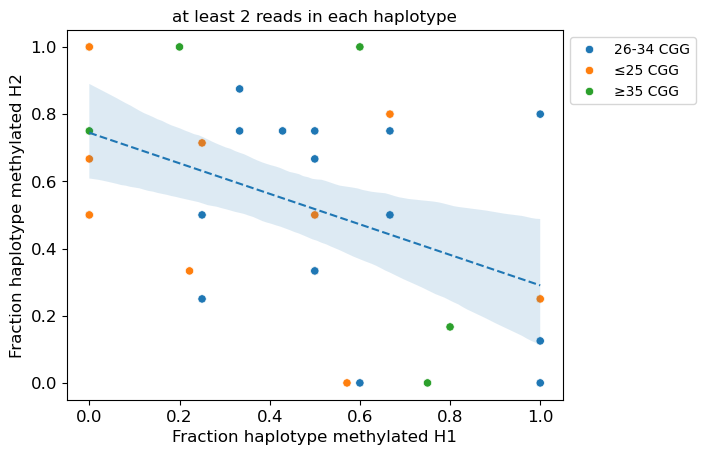

In [14]:
### plot fraction haplotype methylated h1 vs h2

#df_methyl_plt = df_methyl.loc[df_methyl.has_both_hps=='TRUE'].copy()
df_methyl_plt = df_methyl.loc[(df_methyl.has_both_hps=='TRUE') & (df_methyl.both_hps_2_reads=='TRUE')].copy()

col = 'frac_hap_methyl_h1'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)
col = 'frac_hap_methyl_h2'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)

pd.set_option('display.max_rows', None)
display(df_methyl_plt)
pd.set_option('display.max_rows', 10)
#display(df_methyl_plt)

y = np.array(df_methyl_plt.frac_hap_methyl_h2.tolist())
X = pd.DataFrame(df_methyl_plt.frac_hap_methyl_h1)
X_const = sm.add_constant(X)  # Adds intercept term
model_sm = sm.OLS(y, X_const).fit()
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

FS = 12
plt.figure()
sb.scatterplot(data=df_methyl_plt, x='frac_hap_methyl_h1', y='frac_hap_methyl_h2', hue='repeat_group') #, hue='subject', size='num_reads', sizes=(5,20))
sb.regplot(data=df_methyl_plt, x='frac_hap_methyl_h1', y='frac_hap_methyl_h2', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) #title = 'binomial phred'
plt.xlabel('Fraction haplotype methylated H1', fontsize=FS)
plt.ylabel('Fraction haplotype methylated H2', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title('at least 2 reads in each haplotype')
fig_name = f'{dir_fig}/frac_hap_methyl_h1_vs_h2.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

bp_dev_h1  \
REACH000089                          31,30   
REACH000220                    28,26,27,27   
REACH000230                          32,28   
REACH000234                       29,27,27   
REACH000314                    27,29,28,30   
REACH000365            30,30,29,30,30,32,.   
REACH000436_PB                   15,12,9,8   
REACH000451                 24,27,27,27,27   
REACH000453                 33,33,33,36,33   
REACH000628                  30,31,30,32,.   
REACH000672                       30,29,30   
REACH000674                       30,30,30   
REACH000702              27,27,27,27,27,32   
REACH000107                    24,27,24,30   
REACH000404                    38,28,14,24   
REACH000417                      23,-23,29   
REACH000418                          40,33   
REACH000420                -9,-1,-1,0,-2,1   
REACH000435           17,45,26,35,19,22,18   
REACH000477                       40,28,21   
REACH000479                 48,42,43,51,57   
REACH000482     42,65,34,36,33,44,26,50,34   
REACH000510                       38,36,21   
REACH000518                    27,30,27,36   
REACH000519                       97,58,48   
REACH000523                           7,12   
REACH000547              28,24,21,20,22,31   
REACH000561                    22,25,24,31   
REACH000563                          21,53   
REACH000565                    23,29,38,26   
REACH000578               26,18,29,28,24,.   
REACH000579                          31,45   
REACH000581                    68,20,27,22   
REACH000661                          26,15   
REACH000682                     31,28,.,24   

                                      xci_read_mean_methyl_lik_h1  \
REACH000089                                         54,51,2,91,51   
REACH000220                           93,6,11,8,77,7,44,1,1,68,98   
REACH000230                                                0,5,98   
REACH000234     10,8,80,74,11,8,80,28,55,63,0,46,21,43,81,69,9...   
REACH000314                                         85,96,57,8,78   
REACH000365                                              2,5,0,30   
REACH000436_PB     59,0,81,0,3,11,36,19,4,31,0,62,0,19,64,0,3,100   
REACH000451     20,1,99,95,99,94,16,4,0,78,7,88,44,99,0,0,3,0,...   
REACH000453     0,86,0,1,0,84,52,1,81,79,69,76,1,0,0,0,53,1,99...   
REACH000628     16,69,58,0,100,92,2,96,98,94,99,0,18,0,98,97,8...   
REACH000672               86,1,11,71,69,8,10,1,0,0,83,100,100,0,1   
REACH000674               89,0,10,6,14,92,0,2,11,54,94,1,87,0,3,2   
REACH000702             42,62,93,89,9,40,39,12,66,74,4,70,0,4,4,0   
REACH000107     77,1,2,59,46,61,65,3,0,1,1,6,91,84,87,4,16,67,...   
REACH000404     70,12,17,12,3,3,3,45,72,7,73,6,1,6,4,12,32,58,...   
REACH000417          79,62,76,3,34,59,5,4,1,74,45,7,8,2,1,35,66,6   
REACH000418     32,85,4,8,54,62,72,87,71,6,62,86,66,78,70,78,1...   
REACH000420                            73,68,18,0,1,1,39,26,8,0,9   
REACH000435                               59,50,15,66,55,66,13,51   
REACH000477          62,70,11,8,55,86,10,52,20,0,4,1,37,2,22,0,81   
REACH000479     81,81,67,67,77,78,67,86,93,69,88,91,72,99,3,98...   
REACH000482     25,70,63,3,8,63,71,22,9,6,14,74,86,18,7,49,74,...   
REACH000510           84,4,1,3,15,1,53,30,68,76,83,83,71,72,40,92   
REACH000518     60,59,25,62,78,45,2,33,56,2,48,12,85,42,97,88,...   
REACH000519     16,90,81,14,4,4,44,6,48,81,70,46,79,63,71,4,37...   
REACH000523                         69,4,0,7,97,79,99,90,54,24,59   
REACH000547                                  1,68,76,76,1,72,3,79   
REACH000561                    65,70,80,63,1,16,29,70,26,99,56,20   
REACH000563                                                    83   
REACH000565     6,9,12,65,11,65,56,41,74,6,15,14,84,92,1,5,28,...   
REACH000578     3,1,66,61,10,56,1,71,43,5,84,77,14,78,8,56,14,...   
REACH000579     10,4,52,7,2,9,3,83,6,73,19,35,3,83,67,73,10,70...   
REACH000581     2,15,4,72,78,81,64,1,76,7,6,52,74,74,6,2,0,1,6...   
REACH000661                   

stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     8.865
Date:                Mon, 28 Apr 2025   Prob (F-statistic):            0.00541
Time:                        10:52:35   Log-Likelihood:                -4.4335
No. Observations:                  35   AIC:                             12.87
Df Residuals:                      33   BIC:                             15.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  

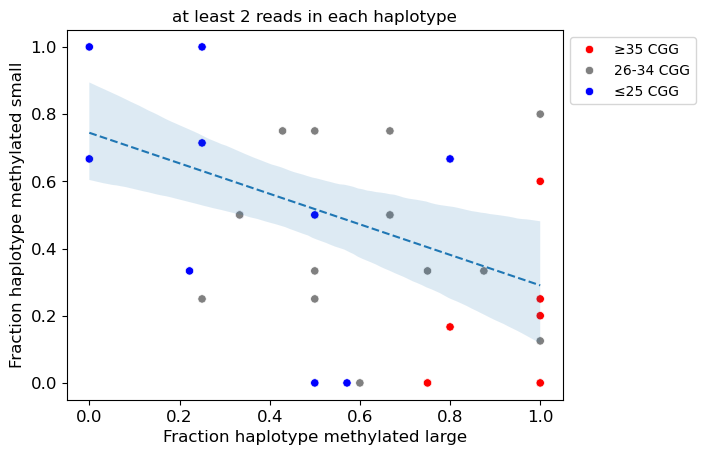

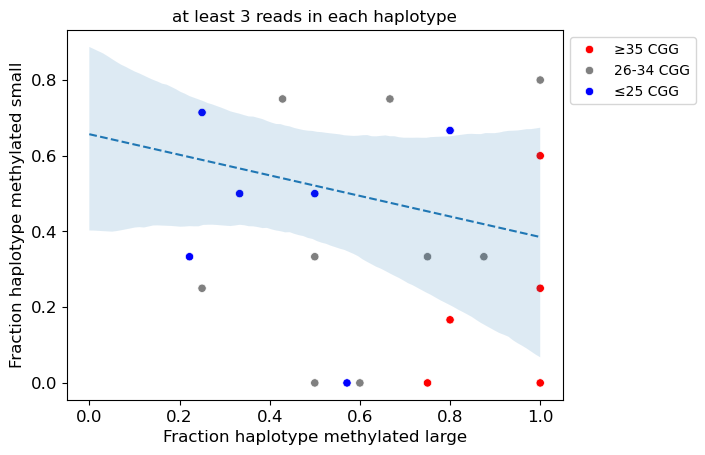

In [15]:
### plot fraction haplotype methylated hp large vs small

df_methyl_plt = df_methyl.loc[(df_methyl.has_both_hps=='TRUE') & (df_methyl.both_hps_2_reads=='TRUE')].copy()

col = 'frac_hap_methyl_h1'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)
col = 'frac_hap_methyl_h2'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)
col = 'frac_hap_methyl_large_rep'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)
col = 'frac_hap_methyl_small_rep'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)

pd.set_option('display.max_rows', None)
display(df_methyl_plt)
pd.set_option('display.max_rows', 10)
#display(df_methyl_plt)

y = np.array(df_methyl_plt.frac_hap_methyl_h2.tolist())
X = pd.DataFrame(df_methyl_plt.frac_hap_methyl_h1)
X_const = sm.add_constant(X)  # Adds intercept term
model_sm = sm.OLS(y, X_const).fit()
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')
            
FS = 12
plt.figure()
sb.scatterplot(data=df_methyl_plt, x='frac_hap_methyl_large_rep', y='frac_hap_methyl_small_rep', 
               hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red', 'gray', 'blue']) #, hue='subject', size='num_reads', sizes=(5,20))
sb.regplot(data=df_methyl_plt, x='frac_hap_methyl_h1', y='frac_hap_methyl_h2', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) #title = 'binomial phred'
plt.xlabel('Fraction haplotype methylated large', fontsize=FS)
plt.ylabel('Fraction haplotype methylated small', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title('at least 2 reads in each haplotype')
fig_name = f'{dir_fig}/frac_hap_methyl_h1_vs_h2.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

plt.figure()
sb.scatterplot(data=df_methyl_plt.loc[df_methyl_plt.both_hps_3_reads=='TRUE'], x='frac_hap_methyl_large_rep', y='frac_hap_methyl_small_rep', 
               hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red', 'gray', 'blue']) #, hue='subject', size='num_reads', sizes=(5,20))
sb.regplot(data=df_methyl_plt.loc[df_methyl_plt.both_hps_3_reads=='TRUE'], x='frac_hap_methyl_h1', y='frac_hap_methyl_h2', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) #title = 'binomial phred'
plt.xlabel('Fraction haplotype methylated large', fontsize=FS)
plt.ylabel('Fraction haplotype methylated small', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title('at least 3 reads in each haplotype')
fig_name = f'{dir_fig}/frac_hap_methyl_h1_vs_h2.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

bp_dev_h1  \
REACH000230                          32,28   
REACH000436_PB                   15,12,9,8   
REACH000451                 24,27,27,27,27   
REACH000453                 33,33,33,36,33   
REACH000404                    38,28,14,24   
REACH000417                      23,-23,29   
REACH000420                -9,-1,-1,0,-2,1   
REACH000435           17,45,26,35,19,22,18   
REACH000479                 48,42,43,51,57   
REACH000482     42,65,34,36,33,44,26,50,34   
REACH000518                    27,30,27,36   
REACH000519                       97,58,48   
REACH000523                           7,12   
REACH000561                    22,25,24,31   
REACH000563                          21,53   
REACH000581                    68,20,27,22   
REACH000682                     31,28,.,24   

                                      xci_read_mean_methyl_lik_h1  \
REACH000230                                                0,5,98   
REACH000436_PB     59,0,81,0,3,11,36,19,4,31,0,62,0,19,64,0,3,100   
REACH000451     20,1,99,95,99,94,16,4,0,78,7,88,44,99,0,0,3,0,...   
REACH000453     0,86,0,1,0,84,52,1,81,79,69,76,1,0,0,0,53,1,99...   
REACH000404     70,12,17,12,3,3,3,45,72,7,73,6,1,6,4,12,32,58,...   
REACH000417          79,62,76,3,34,59,5,4,1,74,45,7,8,2,1,35,66,6   
REACH000420                            73,68,18,0,1,1,39,26,8,0,9   
REACH000435                               59,50,15,66,55,66,13,51   
REACH000479     81,81,67,67,77,78,67,86,93,69,88,91,72,99,3,98...   
REACH000482     25,70,63,3,8,63,71,22,9,6,14,74,86,18,7,49,74,...   
REACH000518     60,59,25,62,78,45,2,33,56,2,48,12,85,42,97,88,...   
REACH000519     16,90,81,14,4,4,44,6,48,81,70,46,79,63,71,4,37...   
REACH000523                         69,4,0,7,97,79,99,90,54,24,59   
REACH000561                    65,70,80,63,1,16,29,70,26,99,56,20   
REACH000563                                                    83   
REACH000581     2,15,4,72,78,81,64,1,76,7,6,52,74,74,6,2,0,1,6...   
REACH000682     2,63,56,6,31,89,81,3,69,52,66,69,2,17,60,2,78,...   

                           bp_dev_h2  \
REACH000230                   -1,0,7   
REACH000436_PB     30,27,30,30,30,30   
REACH000451                    81,91   
REACH000453                 97,84,90   
REACH000404     30,-2,-6,7,2,-22,-15   
REACH000417            48,3,23,26,30   
REACH000420                     25,9   
REACH000435                  5,11,-5   
REACH000479         -5,-4,0,-4,57,-3   
REACH000482                   1,-8,0   
REACH000518           23,27,35,29,20   
REACH000519              -16,10,-3,6   
REACH000523              45,24,20,28   
REACH000561          92,88,102,67,83   
REACH000563             86,90,75,102   
REACH000581              24,11,12,-2   
REACH000682                    12,14   

                                      xci_read_mean_methyl_lik_h2  \
REACH000230                                             75,1,2,27   
REACH000436_PB                0,44,43,0,48,50,67,80,0,90,0,0,0,71   
REACH000451     100,6,0,0,7,0,0,1,97,93,95,100,39,0,1,99,3,98,...   
REACH000453     87,0,0,0,0,93,3,1,1,100,2,68,96,99,99,0,86,72,...   
REACH000404     75,86,66,7,9,81,64,47,81,83,8,64,16,1,68,3,48,...   
REACH000417                    86,45,78,55,56,63,5,12,38,10,62,97   
REACH000420                          75,4,62,94,72,74,2,82,100,80   
REACH000435                         63,2,78,3,4,16,1,2,52,43,3,31   
REACH000479     16,71,16,3,1,79,54,61,1,13,5,2,6,2,2,0,12,75,1...   
REACH000482     75,79,71,8,55,84,76,63,55,79,16,25,9,11,87,60,...   
REACH000518     11,12,13,81,6,3,1,5,44,3,16,6,52,4,8,36,69,4,4...   
REACH000519                     75,4,8,61,8,26,93,67,60,58,3,3,97   
REACH000523          68,3,7,17,66,71,67,12,10,2,5,6,11,2,60,1,1,0   
REACH000561     3,1,24,86,71,62,56,84,59,92,77,7,10,67,5,6,5,9...   
REACH000563                                                   NaN   
REACH000581     63,5,71,87,4,3,7,89,14,58,78,2,80,82,85,98,85,...   
REACH000682     71,20,2,54,41,43,8,3,7,5,8,58,54,94,57,48,4,84...  

fragile_x_all//frac_hap_methyl_h1_vs_h2_GMM.png


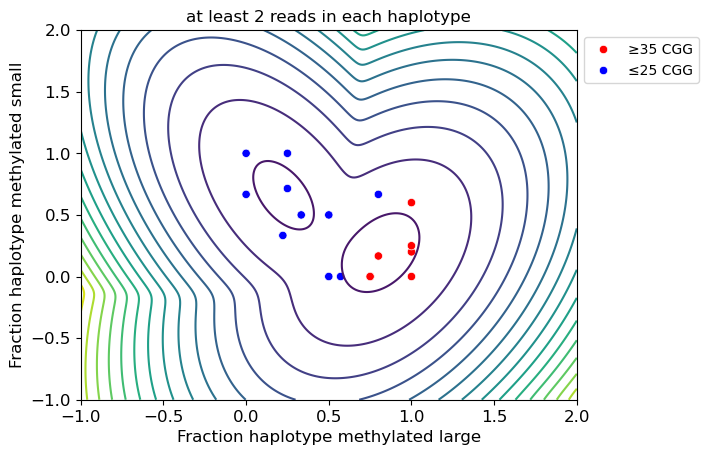

In [35]:
### plot fraction haplotype methylated large vs small with a GMM
from sklearn.mixture import GaussianMixture

#df_methyl_plt = df_methyl.loc[df_methyl.has_both_hps=='TRUE'].copy()
df_methyl_plt = df_methyl.loc[(df_methyl.has_both_hps=='TRUE') & (df_methyl.both_hps_2_reads=='TRUE')].copy()

col = 'frac_hap_methyl_h1'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)
col = 'frac_hap_methyl_h2'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)
col = 'frac_hap_methyl_large_rep'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)
col = 'frac_hap_methyl_small_rep'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)

### only look at the large and small groups
df_methyl_plt = df_methyl_plt.loc[df_methyl_plt.repeat_group != '26-34 CGG']

pd.set_option('display.max_rows', None)
display(df_methyl_plt)
pd.set_option('display.max_rows', 10)
#display(df_methyl_plt)

# Fit GMM
X = np.array(df_methyl_plt[['frac_hap_methyl_large_rep', 'frac_hap_methyl_small_rep']])
#display(X)
#display(np.array(X))
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X)

# Create grid for contour
x = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 300)
y = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 300)
X_grid, Y_grid = np.meshgrid(x, y)
XY_grid = np.column_stack([X_grid.ravel(), Y_grid.ravel()])

# Compute the GMM likelihood at each point in the grid
Z = -gmm.score_samples(XY_grid)  # negative log-likelihood
Z = Z.reshape(X_grid.shape)

FS = 12
plt.figure()
sb.scatterplot(data=df_methyl_plt, x='frac_hap_methyl_large_rep', y='frac_hap_methyl_small_rep', 
               hue='repeat_group', hue_order=['≥35 CGG', '≤25 CGG'], palette=['red',  'blue']) #, hue='subject', size='num_reads', sizes=(5,20))
plt.contour(X_grid, Y_grid, Z, levels=15, cmap='viridis')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) #title = 'binomial phred'
plt.xlabel('Fraction haplotype methylated large', fontsize=FS)
plt.ylabel('Fraction haplotype methylated small', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
#plt.xlim((-0.1, 1.1))
#plt.ylim((-0.1, 1.1))
plt.title('at least 2 reads in each haplotype')
fig_name = f'{dir_fig}/frac_hap_methyl_h1_vs_h2_GMM.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

(106, 53)
(54, 53)
(41, 53)
(35, 53)


bp_dev_h1  \
REACH000089                          31,30   
REACH000220                    28,26,27,27   
REACH000230                          32,28   
REACH000234                       29,27,27   
REACH000314                    27,29,28,30   
REACH000365            30,30,29,30,30,32,.   
REACH000436_PB                   15,12,9,8   
REACH000451                 24,27,27,27,27   
REACH000453                 33,33,33,36,33   
REACH000628                  30,31,30,32,.   
REACH000672                       30,29,30   
REACH000674                       30,30,30   
REACH000702              27,27,27,27,27,32   
REACH000107                    24,27,24,30   
REACH000404                    38,28,14,24   
REACH000417                      23,-23,29   
REACH000418                          40,33   
REACH000420                -9,-1,-1,0,-2,1   
REACH000435           17,45,26,35,19,22,18   
REACH000477                       40,28,21   
REACH000479                 48,42,43,51,57   
REACH000482     42,65,34,36,33,44,26,50,34   
REACH000510                       38,36,21   
REACH000518                    27,30,27,36   
REACH000519                       97,58,48   
REACH000523                           7,12   
REACH000547              28,24,21,20,22,31   
REACH000561                    22,25,24,31   
REACH000563                          21,53   
REACH000565                    23,29,38,26   
REACH000578               26,18,29,28,24,.   
REACH000579                          31,45   
REACH000581                    68,20,27,22   
REACH000661                          26,15   
REACH000682                     31,28,.,24   

                                      xci_read_mean_methyl_lik_h1  \
REACH000089                                         54,51,2,91,51   
REACH000220                           93,6,11,8,77,7,44,1,1,68,98   
REACH000230                                                0,5,98   
REACH000234     10,8,80,74,11,8,80,28,55,63,0,46,21,43,81,69,9...   
REACH000314                                         85,96,57,8,78   
REACH000365                                              2,5,0,30   
REACH000436_PB     59,0,81,0,3,11,36,19,4,31,0,62,0,19,64,0,3,100   
REACH000451     20,1,99,95,99,94,16,4,0,78,7,88,44,99,0,0,3,0,...   
REACH000453     0,86,0,1,0,84,52,1,81,79,69,76,1,0,0,0,53,1,99...   
REACH000628     16,69,58,0,100,92,2,96,98,94,99,0,18,0,98,97,8...   
REACH000672               86,1,11,71,69,8,10,1,0,0,83,100,100,0,1   
REACH000674               89,0,10,6,14,92,0,2,11,54,94,1,87,0,3,2   
REACH000702             42,62,93,89,9,40,39,12,66,74,4,70,0,4,4,0   
REACH000107     77,1,2,59,46,61,65,3,0,1,1,6,91,84,87,4,16,67,...   
REACH000404     70,12,17,12,3,3,3,45,72,7,73,6,1,6,4,12,32,58,...   
REACH000417          79,62,76,3,34,59,5,4,1,74,45,7,8,2,1,35,66,6   
REACH000418     32,85,4,8,54,62,72,87,71,6,62,86,66,78,70,78,1...   
REACH000420                            73,68,18,0,1,1,39,26,8,0,9   
REACH000435                               59,50,15,66,55,66,13,51   
REACH000477          62,70,11,8,55,86,10,52,20,0,4,1,37,2,22,0,81   
REACH000479     81,81,67,67,77,78,67,86,93,69,88,91,72,99,3,98...   
REACH000482     25,70,63,3,8,63,71,22,9,6,14,74,86,18,7,49,74,...   
REACH000510           84,4,1,3,15,1,53,30,68,76,83,83,71,72,40,92   
REACH000518     60,59,25,62,78,45,2,33,56,2,48,12,85,42,97,88,...   
REACH000519     16,90,81,14,4,4,44,6,48,81,70,46,79,63,71,4,37...   
REACH000523                         69,4,0,7,97,79,99,90,54,24,59   
REACH000547                                  1,68,76,76,1,72,3,79   
REACH000561                    65,70,80,63,1,16,29,70,26,99,56,20   
REACH000563                                                    83   
REACH000565     6,9,12,65,11,65,56,41,74,6,15,14,84,92,1,5,28,...   
REACH000578     3,1,66,61,10,56,1,71,43,5,84,77,14,78,8,56,14,...   
REACH000579     10,4,52,7,2,9,3,83,6,73,19,35,3,83,67,73,10,70...   
REACH000581     2,15,4,72,78,81,64,1,76,7,6,52,74,74,6,2,0,1,6...   
REACH000661                   

fragile_x_all//methylation_table_h1_vs_h2.tsv


bp_dev_h1  \
REACH000089                          31,30   
REACH000220                    28,26,27,27   
REACH000230                          32,28   
REACH000234                       29,27,27   
REACH000314                    27,29,28,30   
REACH000365            30,30,29,30,30,32,.   
REACH000436_PB                   15,12,9,8   
REACH000451                 24,27,27,27,27   
REACH000453                 33,33,33,36,33   
REACH000628                  30,31,30,32,.   
REACH000672                       30,29,30   
REACH000674                       30,30,30   
REACH000702              27,27,27,27,27,32   
REACH000107                    24,27,24,30   
REACH000404                    38,28,14,24   
REACH000417                      23,-23,29   
REACH000418                          40,33   
REACH000420                -9,-1,-1,0,-2,1   
REACH000435           17,45,26,35,19,22,18   
REACH000477                       40,28,21   
REACH000479                 48,42,43,51,57   
REACH000482     42,65,34,36,33,44,26,50,34   
REACH000510                       38,36,21   
REACH000518                    27,30,27,36   
REACH000519                       97,58,48   
REACH000523                           7,12   
REACH000547              28,24,21,20,22,31   
REACH000561                    22,25,24,31   
REACH000563                          21,53   
REACH000565                    23,29,38,26   
REACH000578               26,18,29,28,24,.   
REACH000579                          31,45   
REACH000581                    68,20,27,22   
REACH000661                          26,15   
REACH000682                     31,28,.,24   

                                      xci_read_mean_methyl_lik_h1  \
REACH000089                                         54,51,2,91,51   
REACH000220                           93,6,11,8,77,7,44,1,1,68,98   
REACH000230                                                0,5,98   
REACH000234     10,8,80,74,11,8,80,28,55,63,0,46,21,43,81,69,9...   
REACH000314                                         85,96,57,8,78   
REACH000365                                              2,5,0,30   
REACH000436_PB     59,0,81,0,3,11,36,19,4,31,0,62,0,19,64,0,3,100   
REACH000451     20,1,99,95,99,94,16,4,0,78,7,88,44,99,0,0,3,0,...   
REACH000453     0,86,0,1,0,84,52,1,81,79,69,76,1,0,0,0,53,1,99...   
REACH000628     16,69,58,0,100,92,2,96,98,94,99,0,18,0,98,97,8...   
REACH000672               86,1,11,71,69,8,10,1,0,0,83,100,100,0,1   
REACH000674               89,0,10,6,14,92,0,2,11,54,94,1,87,0,3,2   
REACH000702             42,62,93,89,9,40,39,12,66,74,4,70,0,4,4,0   
REACH000107     77,1,2,59,46,61,65,3,0,1,1,6,91,84,87,4,16,67,...   
REACH000404     70,12,17,12,3,3,3,45,72,7,73,6,1,6,4,12,32,58,...   
REACH000417          79,62,76,3,34,59,5,4,1,74,45,7,8,2,1,35,66,6   
REACH000418     32,85,4,8,54,62,72,87,71,6,62,86,66,78,70,78,1...   
REACH000420                            73,68,18,0,1,1,39,26,8,0,9   
REACH000435                               59,50,15,66,55,66,13,51   
REACH000477          62,70,11,8,55,86,10,52,20,0,4,1,37,2,22,0,81   
REACH000479     81,81,67,67,77,78,67,86,93,69,88,91,72,99,3,98...   
REACH000482     25,70,63,3,8,63,71,22,9,6,14,74,86,18,7,49,74,...   
REACH000510           84,4,1,3,15,1,53,30,68,76,83,83,71,72,40,92   
REACH000518     60,59,25,62,78,45,2,33,56,2,48,12,85,42,97,88,...   
REACH000519     16,90,81,14,4,4,44,6,48,81,70,46,79,63,71,4,37...   
REACH000523                         69,4,0,7,97,79,99,90,54,24,59   
REACH000547                                  1,68,76,76,1,72,3,79   
REACH000561                    65,70,80,63,1,16,29,70,26,99,56,20   
REACH000563                                                    83   
REACH000565     6,9,12,65,11,65,56,41,74,6,15,14,84,92,1,5,28,...   
REACH000578     3,1,66,61,10,56,1,71,43,5,84,77,14,78,8,56,14,...   
REACH000579     10,4,52,7,2,9,3,83,6,73,19,35,3,83,67,73,10,70...   
REACH000581     2,15,4,72,78,81,64,1,76,7,6,52,74,74,6,2,0,1,6...   
REACH000661                   

stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     8.865
Date:                Tue, 29 Apr 2025   Prob (F-statistic):            0.00541
Time:                        10:01:32   Log-Likelihood:                -4.4335
No. Observations:                  35   AIC:                             12.87
Df Residuals:                      33   BIC:                             15.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  

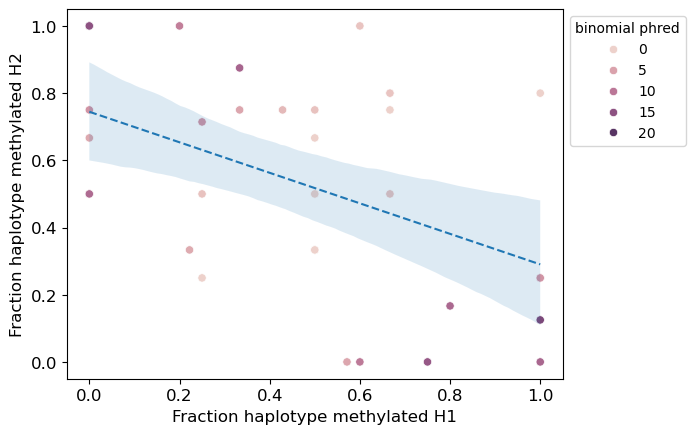

In [4]:
### plot frac hap methylated H1 vs H2 for samples who has both haplotypes present
num_reads_thr = 2
df_methyl_flt = df_methyl.loc[df_methyl.sex=='Female']
print(df_methyl_flt.shape)
df_methyl_flt = df_methyl_flt.loc[(df_methyl_flt.num_methyl_reads_h1 != '.') & (df_methyl_flt.num_methyl_reads_h2 != '.')]
print(df_methyl_flt.shape)
df_methyl_flt = df_methyl_flt.loc[(df_methyl_flt.num_methyl_reads_h1.astype(int) + df_methyl_flt.num_unmethyl_reads_h1.astype(int) >= num_reads_thr)]
print(df_methyl_flt.shape)
df_methyl_flt = df_methyl_flt.loc[(df_methyl_flt.num_methyl_reads_h2.astype(int) + df_methyl_flt.num_unmethyl_reads_h2.astype(int) >= num_reads_thr)]
print(df_methyl_flt.shape)
display(df_methyl_flt)
### figure out which hp is the large and with is the small CGG repeat
df_methyl_flt[['frac_hap_methyl_large_rep', 'frac_hap_methyl_small_rep']] = df_methyl_flt.apply(lambda row: (row['frac_hap_methyl_h1'], row['frac_hap_methyl_h2']) if 
                                                                                                (row['mean_repeat_length_h1'] >= row['mean_repeat_length_h2']) 
                                                                                                else (row['frac_hap_methyl_h2'], row['frac_hap_methyl_h1']), axis=1, result_type = 'expand')
df_methyl_flt[['mean_large_rep', 'mean_small_rep']] = df_methyl_flt.apply(lambda row: (row['mean_repeat_length_h1'], row['mean_repeat_length_h2']) if 
                                                                          (row['mean_repeat_length_h1'] >= row['mean_repeat_length_h2']) 
                                                                          else (row['mean_repeat_length_h2'], row['mean_repeat_length_h1']), axis=1, result_type = 'expand')

def get_binomtest_pval(row):
    k = int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h2)
    n = int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) + int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2)
    return binomtest(k, n, p=0.5, alternative='two-sided').pvalue

df_methyl_flt['binomial_pval'] = df_methyl_flt.apply(lambda row: get_binomtest_pval(row), axis=1)
df_methyl_flt['binomial_phred'] = df_methyl_flt['binomial_pval'].apply(lambda x: -10*np.log10(x))
df_methyl_flt['large_dev'] = df_methyl_flt.apply(lambda row: 'TRUE' if ((float(row.mean_repeat_length_h1) >= 35) or 
                                                                        (float(row.mean_repeat_length_h1) <= 25) or 
                                                                        (float(row.mean_repeat_length_h2) >= 35) or 
                                                                        (float(row.mean_repeat_length_h2) <= 25)) else 'FALSE', axis=1)
### write the table
file_name = f'{dir_fig}/methylation_table_h1_vs_h2.tsv'
print(file_name)
df_methyl_flt.to_csv(file_name, sep='\t', index=True)

col = 'frac_hap_methyl_h1'
df_methyl_flt[col] = df_methyl_flt[col].astype(float)
col = 'frac_hap_methyl_h2'
df_methyl_flt[col] = df_methyl_flt[col].astype(float)

pd.set_option('display.max_rows', None)
display(df_methyl_flt)
pd.set_option('display.max_rows', 10)

y = np.array(df_methyl_flt.frac_hap_methyl_h2.tolist())
X = pd.DataFrame(df_methyl_flt.frac_hap_methyl_h1)
X_const = sm.add_constant(X)  # Adds intercept term
model_sm = sm.OLS(y, X_const).fit()
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

FS = 12
plt.figure()
sb.scatterplot(data=df_methyl_flt, x='frac_hap_methyl_h1', y='frac_hap_methyl_h2', hue='binomial_phred') #, hue='subject', size='num_reads', sizes=(5,20))
sb.regplot(data=df_methyl_flt, x='frac_hap_methyl_h1', y='frac_hap_methyl_h2', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))
plt.legend(title = 'binomial phred', loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Fraction haplotype methylated H1', fontsize=FS)
plt.ylabel('Fraction haplotype methylated H2', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/frac_hap_methyl_h1_vs_h2.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

bp_dev_h1  \
REACH000220                    28,26,27,27   
REACH000234                       29,27,27   
REACH000365            30,30,29,30,30,32,.   
REACH000436_PB                   15,12,9,8   
REACH000453                 33,33,33,36,33   
REACH000616                 27,29,27,27,27   
REACH000628                  30,31,30,32,.   
REACH000672                       30,29,30   
REACH000674                       30,30,30   
REACH000702              27,27,27,27,27,32   
REACH000107                    24,27,24,30   
REACH000404                    38,28,14,24   
REACH000417                      23,-23,29   
REACH000435           17,45,26,35,19,22,18   
REACH000479                 48,42,43,51,57   
REACH000482     42,65,34,36,33,44,26,50,34   
REACH000510                       38,36,21   
REACH000518                    27,30,27,36   
REACH000519                       97,58,48   
REACH000547              28,24,21,20,22,31   
REACH000561                    22,25,24,31   
REACH000581                    68,20,27,22   

                                      xci_read_mean_methyl_lik_h1  \
REACH000220                           93,6,11,8,77,7,44,1,1,68,98   
REACH000234     10,8,80,74,11,8,80,28,55,63,0,46,21,43,81,69,9...   
REACH000365                                              2,5,0,30   
REACH000436_PB     59,0,81,0,3,11,36,19,4,31,0,62,0,19,64,0,3,100   
REACH000453     0,86,0,1,0,84,52,1,81,79,69,76,1,0,0,0,53,1,99...   
REACH000616     0,14,0,57,51,34,100,100,0,75,100,98,4,89,97,58...   
REACH000628     16,69,58,0,100,92,2,96,98,94,99,0,18,0,98,97,8...   
REACH000672               86,1,11,71,69,8,10,1,0,0,83,100,100,0,1   
REACH000674               89,0,10,6,14,92,0,2,11,54,94,1,87,0,3,2   
REACH000702             42,62,93,89,9,40,39,12,66,74,4,70,0,4,4,0   
REACH000107     77,1,2,59,46,61,65,3,0,1,1,6,91,84,87,4,16,67,...   
REACH000404     70,12,17,12,3,3,3,45,72,7,73,6,1,6,4,12,32,58,...   
REACH000417          79,62,76,3,34,59,5,4,1,74,45,7,8,2,1,35,66,6   
REACH000435                               59,50,15,66,55,66,13,51   
REACH000479     81,81,67,67,77,78,67,86,93,69,88,91,72,99,3,98...   
REACH000482     25,70,63,3,8,63,71,22,9,6,14,74,86,18,7,49,74,...   
REACH000510           84,4,1,3,15,1,53,30,68,76,83,83,71,72,40,92   
REACH000518     60,59,25,62,78,45,2,33,56,2,48,12,85,42,97,88,...   
REACH000519     16,90,81,14,4,4,44,6,48,81,70,46,79,63,71,4,37...   
REACH000547                                  1,68,76,76,1,72,3,79   
REACH000561                    65,70,80,63,1,16,29,70,26,99,56,20   
REACH000581     2,15,4,72,78,81,64,1,76,7,6,52,74,74,6,2,0,1,6...   

                              bp_dev_h2  \
REACH000220                  27,27,27,.   
REACH000234              33,30,32,33,30   
REACH000365                 27,27,27,30   
REACH000436_PB        30,27,30,30,30,30   
REACH000453                    97,84,90   
REACH000616              27,26,26,27,40   
REACH000628              27,27,27,26,30   
REACH000672              30,30,30,30,30   
REACH000674           31,33,30,34,30,30   
REACH000702     30,30,30,31,29,35,30,30   
REACH000107                    21,26,26   
REACH000404        30,-2,-6,7,2,-22,-15   
REACH000417               48,3,23,26,30   
REACH000435                     5,11,-5   
REACH000479            -5,-4,0,-4,57,-3   
REACH000482                      1,-8,0   
REACH000510                44,42,-14,33   
REACH000518              23,27,35,29,20   
REACH000519                 -16,10,-3,6   
REACH000547                 29,54,37,46   
REACH000561             92,88,102,67,83   
REACH000581                 24,11,12,-2   

                                      xci_read_mean_methyl_lik_h2  \
REACH000220      1,4,0,1,58,0,91,8,79,89,97,54,66,55,64,0,3,13,45   
REACH000234     33,10,4,0,35,23,26,92,5,0,9,8,8,83,85,4,40,3,1...   
REACH000365                                 97,46,90,92,100,90,99   
REACH000436_PB                0,44,43,0,48,50,67,80,0,90,0,0,0,71   
REACH000453     87,0,0,0,0,93,3,1,1,100,2,68,96,99,

bp_dev_h1  \
REACH000453  33,33,33,36,33   
REACH000479  48,42,43,51,57   
REACH000518     27,30,27,36   
REACH000519        97,58,48   
REACH000561     22,25,24,31   

                                   xci_read_mean_methyl_lik_h1  \
REACH000453  0,86,0,1,0,84,52,1,81,79,69,76,1,0,0,0,53,1,99...   
REACH000479  81,81,67,67,77,78,67,86,93,69,88,91,72,99,3,98...   
REACH000518  60,59,25,62,78,45,2,33,56,2,48,12,85,42,97,88,...   
REACH000519  16,90,81,14,4,4,44,6,48,81,70,46,79,63,71,4,37...   
REACH000561                 65,70,80,63,1,16,29,70,26,99,56,20   

                    bp_dev_h2  \
REACH000453          97,84,90   
REACH000479  -5,-4,0,-4,57,-3   
REACH000518    23,27,35,29,20   
REACH000519       -16,10,-3,6   
REACH000561   92,88,102,67,83   

                                   xci_read_mean_methyl_lik_h2 bp_dev_h0  \
REACH000453  87,0,0,0,0,93,3,1,1,100,2,68,96,99,99,0,86,72,...         .   
REACH000479  16,71,16,3,1,79,54,61,1,13,5,2,6,2,2,0,12,75,1...   42,-7,1   
REACH000518  11,12,13,81,6,3,1,5,44,3,16,6,52,4,8,36,69,4,4...     30,20   
REACH000519                  75,4,8,61,8,26,93,67,60,58,3,3,97      3,39   
REACH000561  3,1,24,86,71,62,56,84,59,92,77,7,10,67,5,6,5,9...         .   

                                   xci_read_mean_methyl_lik_h0  \
REACH000453           10,3,0,80,90,70,1,100,83,2,23,100,0,0,92   
REACH000479  22,14,8,3,75,2,79,74,15,77,13,55,15,7,67,67,42...   
REACH000518     20,1,77,9,2,48,9,18,13,52,65,16,33,14,98,62,70   
REACH000519  4,3,61,8,14,10,40,70,56,58,65,36,2,76,12,49,60...   
REACH000561  21,3,6,5,81,53,75,81,4,6,4,17,72,0,51,87,47,6,...   

                                                     methyl_h1  \
REACH000453  59|95|99|100|99|100|100|97|90|78|91|100|100|10...   
REACH000479  82|0|99|82|100|0|100|99|100|70|97|100|100|5|0|...   
REACH000518  51|82|100|100|72|0|100|99|100|94|90|99|38|37|0...   
REACH000519  100|62|100|94|100|100|99|79|86|86|85|9|16|3|97...   
REACH000561  3|0|2|0|1|5|12|99|59|66|0|0|0|0|0|0|0|58|10|29...   

                                                     methyl_h2  \
REACH000453  94|100|100|100|100|99|99|99|100|99|95|99|100|9...   
REACH000479  7|3|0|31|3|98|52|5|0|0|2|36|38|95|38|4|3|3|1|6...   
REACH000518  1|4|0|67|1|0|0|0|0|2|4|0|0|2|0|0|0|0|0|0|0|6|0...   
REACH000519  58|50|48|1|25|0|6|5|6|9|9|28|14|0|6|1|16|1|19|...   
REACH000561  95|41|55|100|74|99|100|100|100|91|91|97|82|100...   

                                                     methyl_h0  \
REACH000453                                                  .   
REACH000479  93|98|100|100|98|59|100|100|32|100|100|100|99|...   
REACH000518  10|87|10|3|52|37|46|98|82|9|100|85|9|44|99|36|...   
REACH000519  1|7|0|36|0|0|0|0|0|0|0|0|0|0|1|0|2|0|16|2|0|0|...   
REACH000561                                                  .   

            repeat_length_h1   repeat_length_h2 repeat_length_h0  \
REACH000453   31,31,31,32,31           52,48,50                .   
REACH000479   36,34,34,37,39  18,19,20,19,39,19         34,18,20   
REACH000518      29,30,29,32     28,29,32,30,27            30,27   
REACH000519         52,39,36        15,23,19,22            21,33   
REACH000561      27,28,28,30     51,49,54,42,48                .   

            mean_repeat_length_h1 mean_repeat_length_h2 mean_repeat_length_h0  \
REACH000453                  31.2                  49.4                     .   
REACH000479                  36.0    22.333333333333332                  24.0   
REACH000518                  35.0    29.444444444444443                  28.5   
REACH000519                  35.0    20.833333333333332                  27.0   
REACH000561                 28.25    49.111111111111114                     .   

            read_mean_methyl_lik_h1 read_mean_methyl_lik_h2  \
REACH000453          77,57,43,42,66                66,87,91   
REACH000479          67,47,69,59,58         20,1,15,11,81,3   
REACH000518             83,82,66,15               4,5,5,1,3   
REACH000519                65,62,80       

array([[1.        , 0.25      , 0.25      ],
       [1.        , 0.8       , 0.66666667],
       [1.        , 0.42857143, 0.75      ],
       [1.        , 0.33333333, 0.5       ],
       [1.        , 1.        , 0.6       ],
       [1.        , 0.4       , 0.4       ],
       [1.        , 0.6       , 0.        ],
       [1.        , 1.        , 0.8       ],
       [1.        , 0.5       , 0.        ],
       [1.        , 0.875     , 0.33333333],
       [1.        , 0.5       , 0.33333333],
       [1.        , 0.25      , 0.71428571],
       [1.        , 0.8       , 0.66666667],
       [1.        , 0.57142857, 0.        ],
       [1.        , 0.8       , 0.16666667],
       [1.        , 0.22222222, 0.33333333],
       [1.        , 0.66666667, 0.75      ],
       [1.        , 0.75      , 0.        ],
       [1.        , 1.        , 0.25      ],
       [1.        , 0.75      , 0.33333333],
       [1.        , 1.        , 0.        ],
       [1.        , 0.5       , 0.5       ]])

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0])

/home/smmortazavi/micromamba/envs/bioinf/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/smmortazavi/micromamba/envs/bioinf/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/smmortazavi/micromamba/envs/bioinf/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.000008
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   22
Model:                          Logit   Df Residuals:                       19
Method:                           MLE   Df Model:                            2
Date:                Mon, 05 May 2025   Pseudo R-squ.:                   1.000
Time:                        09:16:46   Log-Likelihood:            -0.00017633
converged:                      False   LL-Null:                       -11.791
Covariance Type:            nonrobust   LLR p-value:                 7.573e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7261.7514   5.66e+04     -0.128      0.898   -1.18e+05    1.04e+05
x1          1.006e+04   7.83e+04      0.128      0.898   -1.43e+0

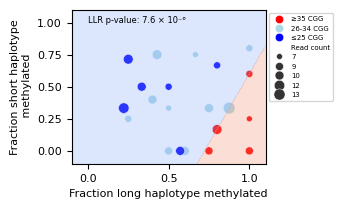

In [6]:
### plot classification of ≥35 with other groups in terms of large vs small haplotypes
import statsmodels.api as sm

df_methyl_plt = df_methyl.loc[(df_methyl.has_both_hps=='TRUE') & (df_methyl.both_hps_3_reads=='TRUE')].copy()
df_methyl_plt['Read count'] = (df_methyl_plt.num_methyl_reads_h1.astype(int) + df_methyl_plt.num_unmethyl_reads_h1.astype(int) + 
                              df_methyl_plt.num_methyl_reads_h2.astype(int) + df_methyl_plt.num_unmethyl_reads_h2.astype(int))

col = 'frac_hap_methyl_h1'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)
col = 'frac_hap_methyl_h2'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)
col = 'frac_hap_methyl_large_rep'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)
col = 'frac_hap_methyl_small_rep'
df_methyl_plt[col] = df_methyl_plt[col].astype(float)

### only look at the large and small groups
#df_methyl_plt = df_methyl_plt.loc[df_methyl_plt.repeat_group != '26-34 CGG']

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(df_methyl_plt)
display(df_methyl_plt.loc[df_methyl_plt.repeat_group=='≥35 CGG'])
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

# Logistic regression
X = np.array(df_methyl_plt[['frac_hap_methyl_large_rep', 'frac_hap_methyl_small_rep']])
X_with_intercept = sm.add_constant(X) # Add intercept (statsmodels doesn't add it automatically)
display(X_with_intercept)
y = np.array(df_methyl_plt.repeat_group.map(lambda x: 1 if x == '≥35 CGG' else 0)) # Class labels: 0 and 1
display(y)

# Fit logistic regression using statsmodels
model = sm.Logit(y, X_with_intercept)
result = model.fit()

# Summary includes p-values
print(result.summary())

# Create a grid of values
xx, yy = np.meshgrid(np.linspace(min(X[:, 0].min() - 0.1, -.1), max(X[:, 0].max() + 0.1, 1.1), 300),
                     np.linspace(min(X[:, 1].min() - 0.1, -.1), max(X[:, 1].max() + 0.1, 1.1), 300))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_with_const = sm.add_constant(grid)

# Predict probabilities for each point in the grid
probs = result.predict(grid_with_const).reshape(xx.shape)

FS = 8
plt.figure(figsize=(2.5, 2))
sb.scatterplot(data=df_methyl_plt, x='frac_hap_methyl_large_rep', y='frac_hap_methyl_small_rep', 
               hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'], size='Read count') #, hue='subject', size='num_reads', sizes=(5,20))
plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.3)
plt.text(x=.0, y=1, s=f'LLR p-value: {format_sci_notation(result.llr_pvalue)}', fontsize=FS-2)
plt.legend(title = '', loc='upper left', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[1:], fontsize=FS-3, title_fontsize=FS-3) #title = 'binomial phred'
plt.xlabel('Fraction long haplotype methylated', fontsize=FS)
plt.ylabel('Fraction short haplotype\n methylated', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.xlim((-0.1, 1.1))
plt.ylim((-0.1, 1.1))
fig_name = f'{dir_fig}/frac_hap_methyl_h1_vs_h2_logid_classify.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

df_plt:


subject_id  mean_repeat_length  frac_hap_methyl  xci_frac_hap_methyl  \
0      REACH000066           31.333333         0.000000             0.500000   
1      REACH000087           29.500000         0.750000             0.666667   
2      REACH000089           30.333333         0.666667             1.000000   
3      REACH000092           29.800000         0.600000             0.777778   
4      REACH000093           29.250000         1.000000             0.277778   
5      REACH000220           29.000000         0.250000             0.363636   
6      REACH000220           29.000000         0.250000             0.473684   
7      REACH000230           20.666667         0.666667             0.250000   
8      REACH000234           29.333333         0.666667             0.434783   
9      REACH000234           30.600000         0.800000             0.250000   
10     REACH000285           25.333333         0.333333             0.250000   
11     REACH000294           23.333333         0.666667             0.500000   
12     REACH000314           29.500000         0.500000             0.800000   
13     REACH000365           30.166667         0.428571             0.000000   
14     REACH000365           29.250000         0.750000             0.857143   
15  REACH000436_PB           23.750000         0.500000             0.277778   
16  REACH000436_PB           29.833333         0.333333             0.357143   
17     REACH000451           28.800000         0.200000             0.375000   
18     REACH000453           31.200000         0.600000             0.500000   
19     REACH000453           49.400000         1.000000             0.500000   
20     REACH000628           30.250000         0.600000             0.681818   
21     REACH000628           29.200000         0.000000             0.625000   
22     REACH000641           31.000000         0.250000             0.428571   
23     REACH000672           30.000000         1.000000             0.400000   
24     REACH000672           30.000000         0.800000             0.750000   
25     REACH000674           30.000000         0.000000             0.312500   
26     REACH000674           30.333333         0.500000             0.588235   
27     REACH000702           29.333333         0.333333             0.375000   
28     REACH000702           30.250000         0.875000             0.562500   
29     REACH000727           31.000000         1.000000             0.714286   
30     REACH000755           24.000000         0.333333             0.600000   
31     REACH000107           28.750000         0.500000             0.407407   
32     REACH000107           28.333333         0.333333             0.480000   
33     REACH000155           31.333333         0.666667             0.285714   
34     REACH000401           17.750000         0.500000             0.700000   
35     REACH000404           28.750000         0.250000             0.350000   
36     REACH000404           19.714286         0.714286             0.523810   
37     REACH000417           23.333333         0.666667             0.333333   
38     REACH000417           28.800000         0.800000             0.583333   
39     REACH000418           28.625000         0.125000             0.000000   
40     REACH000420           19.333333         0.000000             0.181818   
41     REACH000435           28.714286         0.571429             0.750000   
42     REACH000435           21.333333         0.000000             0.250000   
43     REACH000477           29.666667         1.000000             0.352941   
44     REACH000479           36.000000         0.800000             0.771429   
45     REACH000479           22.333333         0.166667             0.205882   
46     REACH000482           33.555556         0.222222             0.375000   
47     REACH000482           19.000000         0.333333             0.681818   
48     REACH000510           30.666667         0.666667             0.562500   
49     R

df_plt, mean repeat > 45:


subject_id  mean_repeat_length  frac_hap_methyl  xci_frac_hap_methyl  \
19  REACH000453           49.400000              1.0              0.50000   
59  REACH000561           49.111111              1.0              0.52381   

    num_reads  xci_num_reads repeat_group  
19        3.0           24.0      ≥35 CGG  
59        5.0           21.0      ≥35 CGG

stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     9.005
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           0.000353
Time:                        18:31:03   Log-Likelihood:                -7.5687
No. Observations:                  68   AIC:                             21.14
Df Residuals:                      65   BIC:                             27.80
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                

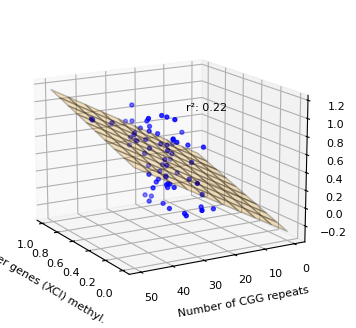

fragile_x_all//FMR1_methyl_vs_XCI_methyl_fromTable.png


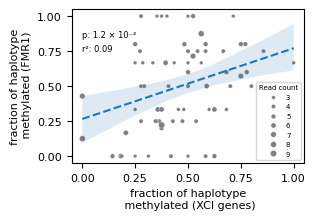

fragile_x_all//FMR1_methyl_vs_CGG_repeats_fromTable.png


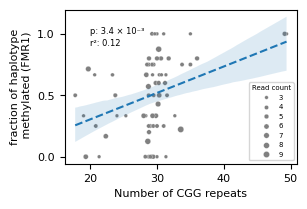

In [7]:
### Multivariate OLS: linear regression of FMR1 methylation as a function of XCI and CGG repeat
df_methyl_plt = df_methyl.loc[(df_methyl.sex=='Female')].copy()
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_methyl_reads_h1!='.') | (df_methyl_plt.num_methyl_reads_h2!='.')]
df_methyl_plt['num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) if row.num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt['xci_num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h1) + int(row.xci_num_unmethyl_reads_h1) if row.xci_num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['xci_num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h2) + int(row.xci_num_unmethyl_reads_h2) if row.xci_num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_reads_h1>=3) | (df_methyl_plt.num_reads_h2>=3)]

df_plt = pd.DataFrame()
for idx, row in df_methyl_plt.iterrows():
    sample = idx
    for hp in ['h1', 'h2']:
        if row[f'num_reads_{hp}'] >= 3:
            mean_rep = row[f'mean_repeat_length_{hp}']
            frac_hap = row[f'frac_hap_methyl_{hp}']
            xci_frac_hap = row[f'xci_frac_hap_methyl_{hp}']
            num_reads = row[f'num_reads_{hp}']
            xci_num_reads = row[f'xci_num_reads_{hp}']
            rep_group = row['repeat_group']
            df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
                                   f'xci_frac_hap_methyl': [xci_frac_hap], f'num_reads': [num_reads], f'xci_num_reads': [xci_num_reads], f'repeat_group': [rep_group]})
            df_plt = pd.concat([df_plt, df_tmp], ignore_index=True)

### also get rid of the haplotypes where xci_frac_hap_methyl are missing. this would omit REACH000563 who don't have any phased reads in XCI genes.
### REACH000451 is also not there because it has only 2 reads for FMR1 on the haplotype
df_plt = df_plt.loc[df_plt.xci_frac_hap_methyl!='.']

cols = ['mean_repeat_length', 'frac_hap_methyl', 'xci_frac_hap_methyl', 'xci_num_reads', 'num_reads']
for col in cols:
    df_plt[col] = df_plt[col].astype(float)

def get_rep_group2(row):
    if row.repeat_group != '.':
        out = row.repeat_group
    else:
        out = ('≥35 CGG' if (row.mean_repeat_length >= 35) else 
               ('≤25 CGG' if (row.mean_repeat_length <= 25) else '26-34 CGG'))
    return out
df_plt['repeat_group'] = df_plt.apply(lambda row: get_rep_group2(row), axis=1)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print('df_plt:')
display(df_plt)
print('df_plt, mean repeat > 45:')
display(df_plt.loc[(df_plt.mean_repeat_length >45) | (df_plt.mean_repeat_length >45)])
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

### multi variate linear model: methylation_fmr1 ~ methylation_xci + hp_rep
X = pd.DataFrame(df_plt[['xci_frac_hap_methyl', 'mean_repeat_length']])
X_const = sm.add_constant(X)  # Adds intercept term
#print('X_const:')
#display(X_const)
y = np.array(df_plt.frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
r2_full = model_sm.rsquared
rss_full = np.sum(model_sm.resid ** 2)
pval_xci_methyl = model_sm.pvalues['xci_frac_hap_methyl']
pval_rep_length = model_sm.pvalues['mean_repeat_length']
#print(f'pval_xci_methyl: {pval_xci_methyl}')
#print(f'pval_rep_length: {pval_rep_length}')
#print("P-values:", model_sm.pvalues)
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

print(model_sm.params)
print(model_sm.params.xci_frac_hap_methyl)
print(model_sm.params.mean_repeat_length)
x_plane = np.linspace(0, 1, 10)  # Define grid for the plane
y_plane = np.linspace(0, 50, 10)
a = model_sm.params.xci_frac_hap_methyl
b = model_sm.params.mean_repeat_length
c = model_sm.params.const
x_plane, y_plane = np.meshgrid(x_plane, y_plane)
z_plane = a * x_plane + b * y_plane + c  # Compute corresponding z values

### single variate linear model
X = pd.DataFrame(df_plt[['xci_frac_hap_methyl']])
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_plt.frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
### compute partial r2 based on full model for the other variable not present in this model
# Partial R² = (RSS_reduced - RSS_full) / RSS_reduced
rss_reduced = np.sum(model_sm.resid ** 2)
partial_r2_rep_length = (rss_reduced - rss_full) / rss_reduced
print(f'partial_r2_rep_length: {partial_r2_rep_length}')
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

### single variate linear model
X = pd.DataFrame(df_plt[['mean_repeat_length']])
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_plt.frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
### compute partial r2 based on full model for the other variable not present in this model
# Partial R² = (RSS_reduced - RSS_full) / RSS_reduced
rss_reduced = np.sum(model_sm.resid ** 2)
partial_r2_xci_methyl = (rss_reduced - rss_full) / rss_reduced
print(f'partial_r2_xci_methyl: {partial_r2_xci_methyl}')
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')


FS = 8
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.scatter(df_plt.xci_frac_hap_methyl.tolist(), df_plt.mean_repeat_length.tolist(), df_plt.frac_hap_methyl, color='blue', label='Data Points', s=8)
ax.plot_surface(x_plane, y_plane, z_plane, alpha=0.25, color='orange', label='Fitted Plane', edgecolor='black')
x_t =0.8 ; y_t = 10; z_t = 0.8
ax.text(x_t, y_t, z_t, f'r²: {r2_full:.2f}', fontsize=FS) # "⁰¹²³⁴⁵⁶⁷⁸⁹" superscripts are copied from here
ax.set_xlabel('Other genes (XCI) methyl.', fontsize=FS)
ax.set_ylabel('Number of CGG repeats', fontsize=FS)
ax.set_zlabel('FMR1 methyl.', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
#plt.zticks(fontsize=FS)
ax.tick_params(axis='z', labelsize=FS)
ax.set_title('')
ax.view_init(elev=15, azim=150)
#plt.tight_layout()
fig_name = f'{dir_fig}/3D_FMR1_methyl_vs_XCI_methyl_and_CGG_repeat_fromTable.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', pad_inches=.3, dpi=1200)
plt.show()
plt.close()


plt.figure(figsize=(3, 2))
sb.scatterplot(data=df_plt, x='xci_frac_hap_methyl', y='frac_hap_methyl', color='gray', size='num_reads', sizes=(7,20))
sb.regplot(data=df_plt, x='xci_frac_hap_methyl', y='frac_hap_methyl', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
x_t =0 ; y_t = 0.85
plt.text(x_t, y_t, f'p: {format_sci_notation(pval_xci_methyl)}', fontsize=FS-2, ha='left')
plt.text(x_t, y_t-.1, f'r²: {partial_r2_xci_methyl:.2f}', fontsize=FS-2, ha='left')
plt.legend(title='Read count', loc='lower right', bbox_to_anchor=(1, 0), fontsize=FS-3, title_fontsize=FS-3) #handles=plt.gca().legend_.legend_handles[num_subjects+2:],
plt.xlabel('fraction of haplotype\n methylated (XCI genes)', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (FMR1)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/FMR1_methyl_vs_XCI_methyl_fromTable.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()



plt.figure(figsize=(3, 2))
sb.scatterplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', color='gray', size='num_reads', sizes=(7,20))
sb.regplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
x_t =20 ; y_t = 1
plt.text(x_t, y_t, f'p: {format_sci_notation(pval_rep_length)}', fontsize=FS-2, ha='left')
plt.text(x_t, y_t-.1, f'r²: {partial_r2_rep_length:.2f}', fontsize=FS-2, ha='left')
plt.legend(title='Read count', loc='lower right', bbox_to_anchor=(1, 0), fontsize=FS-3, title_fontsize=FS-3) #handles=plt.gca().legend_.legend_handles[num_subjects+3:],
plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (FMR1)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/FMR1_methyl_vs_CGG_repeats_fromTable.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

df_plt:


(38, 7)

subject_id  mean_repeat_length  frac_hap_methyl  xci_frac_hap_methyl  \
0   REACH000066           31.333333         0.000000             0.500000   
1   REACH000087           29.500000         0.750000             0.666667   
2   REACH000089           30.333333         0.666667             1.000000   
3   REACH000092           29.800000         0.600000             0.777778   
4   REACH000093           29.250000         1.000000             0.277778   
5   REACH000220           29.000000         0.250000             0.363636   
6   REACH000220           29.000000         0.250000             0.473684   
8   REACH000234           29.333333         0.666667             0.434783   
9   REACH000234           30.600000         0.800000             0.250000   
10  REACH000285           25.333333         0.333333             0.250000   
12  REACH000314           29.500000         0.500000             0.800000   
13  REACH000365           30.166667         0.428571             0.000000   
14  REACH000365           29.250000         0.750000             0.857143   
20  REACH000628           30.250000         0.600000             0.681818   
21  REACH000628           29.200000         0.000000             0.625000   
22  REACH000641           31.000000         0.250000             0.428571   
23  REACH000672           30.000000         1.000000             0.400000   
24  REACH000672           30.000000         0.800000             0.750000   
25  REACH000674           30.000000         0.000000             0.312500   
26  REACH000674           30.333333         0.500000             0.588235   
27  REACH000702           29.333333         0.333333             0.375000   
28  REACH000702           30.250000         0.875000             0.562500   
29  REACH000727           31.000000         1.000000             0.714286   
31  REACH000107           28.750000         0.500000             0.407407   
32  REACH000107           28.333333         0.333333             0.480000   
33  REACH000155           31.333333         0.666667             0.285714   
39  REACH000418           28.625000         0.125000             0.000000   
43  REACH000477           29.666667         1.000000             0.352941   
48  REACH000510           30.666667         0.666667             0.562500   
49  REACH000510           28.750000         0.750000             0.272727   
50  REACH000513           28.750000         0.000000             0.185185   
56  REACH000547           28.000000         0.333333             0.625000   
57  REACH000547           33.750000         0.750000             0.583333   
61  REACH000565           30.000000         0.250000             0.346154   
62  REACH000567           31.750000         0.800000             0.482759   
63  REACH000578           28.400000         0.666667             0.393939   
64  REACH000579           28.500000         0.750000             0.500000   
67  REACH000661           32.666667         0.333333             0.454545   

    num_reads  xci_num_reads repeat_group  
0         3.0            2.0    26-34 CGG  
1         4.0            9.0    26-34 CGG  
2         3.0            3.0    26-34 CGG  
3         5.0            9.0    26-34 CGG  
4         4.0           18.0    26-34 CGG  
5         4.0           11.0    26-34 CGG  
6         4.0           19.0    26-34 CGG  
8         3.0           23.0    26-34 CGG  
9         5.0           20.0    26-34 CGG  
10        3.0            8.0    26-34 CGG  
12        4.0            5.0    26-34 CGG  
13        7.0            4.0    26-34 CGG  
14        4.0            7.0    26-34 CGG  
20        5.0           22.0    26-34 CGG  
21        5.0            8.0    26-34 CGG  
22        4.0            7.0    26-34 CGG  
23        3.0           15.0    26-34 CGG  
24        5.0            8.0    26-34 CGG  
25        3.0           16.0    26-34 CGG  
26        6.0           17.0    26-34 CGG  
27        6.0           16.0    26-34 CGG  
28        8.0           16.0    2

stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     1.813
Date:                Thu, 01 May 2025   Prob (F-statistic):              0.178
Time:                        10:48:33   Log-Likelihood:                -6.0362
No. Observations:                  38   AIC:                             18.07
Df Residuals:                      35   BIC:                             22.99
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                

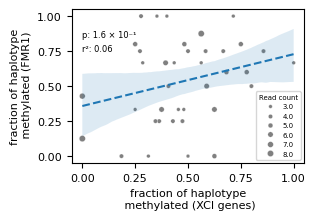

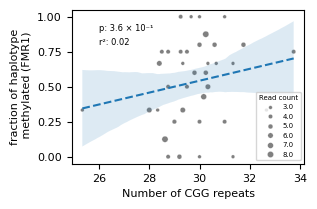

In [16]:
### Test multivariate OLS excluding ≥35 and ≤25 haplotypes to see if XCI is still significant
df_methyl_plt = df_methyl.loc[(df_methyl.sex=='Female')].copy()
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_methyl_reads_h1!='.') | (df_methyl_plt.num_methyl_reads_h2!='.')]
df_methyl_plt['num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) if row.num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt['xci_num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h1) + int(row.xci_num_unmethyl_reads_h1) if row.xci_num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['xci_num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h2) + int(row.xci_num_unmethyl_reads_h2) if row.xci_num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_reads_h1>=3) | (df_methyl_plt.num_reads_h2>=3)]

df_plt = pd.DataFrame()
for idx, row in df_methyl_plt.iterrows():
    sample = idx
    for hp in ['h1', 'h2']:
        if row[f'num_reads_{hp}'] >= 3:
            mean_rep = row[f'mean_repeat_length_{hp}']
            frac_hap = row[f'frac_hap_methyl_{hp}']
            xci_frac_hap = row[f'xci_frac_hap_methyl_{hp}']
            num_reads = row[f'num_reads_{hp}']
            xci_num_reads = row[f'xci_num_reads_{hp}']
            rep_group = row['repeat_group']
            df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
                                   f'xci_frac_hap_methyl': [xci_frac_hap], f'num_reads': [num_reads], f'xci_num_reads': [xci_num_reads], f'repeat_group': [rep_group]})
            df_plt = pd.concat([df_plt, df_tmp], ignore_index=True)

### also get rid of the haplotypes where xci_frac_hap_methyl are missing. this would omit REACH000563 who don't have any phased reads in XCI genes.
### REACH000451 is also not there because it has only 2 reads for FMR1 on the haplotype
df_plt = df_plt.loc[df_plt.xci_frac_hap_methyl!='.']

cols = ['mean_repeat_length', 'frac_hap_methyl', 'xci_frac_hap_methyl', 'xci_num_reads', 'num_reads']
for col in cols:
    df_plt[col] = df_plt[col].astype(float)

def get_rep_group2(row):
    if row.repeat_group != '.':
        out = row.repeat_group
    else:
        out = ('≥35 CGG' if (row.mean_repeat_length >= 35) else 
               ('≤25 CGG' if (row.mean_repeat_length <= 25) else '26-34 CGG'))
    return out
df_plt['repeat_group'] = df_plt.apply(lambda row: get_rep_group2(row), axis=1)

df_plt = df_plt.loc[df_plt.repeat_group =='26-34 CGG']

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print('df_plt:')
display(df_plt.shape)
display(df_plt)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

### multi variate linear model: methylation_fmr1 ~ methylation_xci + hp_rep
X = pd.DataFrame(df_plt[['xci_frac_hap_methyl', 'mean_repeat_length']])
X_const = sm.add_constant(X)  # Adds intercept term
#print('X_const:')
#display(X_const)
y = np.array(df_plt.frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
r2_full = model_sm.rsquared
rss_full = np.sum(model_sm.resid ** 2)
pval_xci_methyl = model_sm.pvalues['xci_frac_hap_methyl']
pval_rep_length = model_sm.pvalues['mean_repeat_length']
#print(f'pval_xci_methyl: {pval_xci_methyl}')
#print(f'pval_rep_length: {pval_rep_length}')
#print("P-values:", model_sm.pvalues)
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

#print(model_sm.params)
#print(model_sm.params.xci_frac_hap_methyl)
#print(model_sm.params.mean_repeat_length)
x_plane = np.linspace(0, 1, 10)  # Define grid for the plane
y_plane = np.linspace(0, 50, 10)
a = model_sm.params.xci_frac_hap_methyl
b = model_sm.params.mean_repeat_length
c = model_sm.params.const
x_plane, y_plane = np.meshgrid(x_plane, y_plane)
z_plane = a * x_plane + b * y_plane + c  # Compute corresponding z values

### single variate linear model
X = pd.DataFrame(df_plt[['xci_frac_hap_methyl']])
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_plt.frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
### compute partial r2 based on full model for the other variable not present in this model
# Partial R² = (RSS_reduced - RSS_full) / RSS_reduced
rss_reduced = np.sum(model_sm.resid ** 2)
partial_r2_rep_length = (rss_reduced - rss_full) / rss_reduced
print(f'partial_r2_rep_length: {partial_r2_rep_length}')
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

### single variate linear model
X = pd.DataFrame(df_plt[['mean_repeat_length']])
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_plt.frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
### compute partial r2 based on full model for the other variable not present in this model
# Partial R² = (RSS_reduced - RSS_full) / RSS_reduced
rss_reduced = np.sum(model_sm.resid ** 2)
partial_r2_xci_methyl = (rss_reduced - rss_full) / rss_reduced
print(f'partial_r2_xci_methyl: {partial_r2_xci_methyl}')
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

FS = 8
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.scatter(df_plt.xci_frac_hap_methyl.tolist(), df_plt.mean_repeat_length.tolist(), df_plt.frac_hap_methyl, color='blue', label='Data Points', s=8)
ax.plot_surface(x_plane, y_plane, z_plane, alpha=0.25, color='orange', label='Fitted Plane', edgecolor='black')
x_t =0.8 ; y_t = 10; z_t = 0.8
ax.text(x_t, y_t, z_t, f'r²: {r2_full:.2f}', fontsize=FS) # "⁰¹²³⁴⁵⁶⁷⁸⁹" superscripts are copied from here
ax.set_xlabel('Other genes (XCI) methyl.', fontsize=FS)
ax.set_ylabel('Number of CGG repeats', fontsize=FS)
ax.set_zlabel('FMR1 methyl.', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
#plt.zticks(fontsize=FS)
ax.tick_params(axis='z', labelsize=FS)
ax.set_title('')
ax.view_init(elev=15, azim=150)
#plt.tight_layout()
#fig_name = f'{dir_fig}/3D_FMR1_methyl_vs_XCI_methyl_and_CGG_repeat_fromTable.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', pad_inches=.3, dpi=1200)
#plt.show()
plt.close()


plt.figure(figsize=(3, 2))
sb.scatterplot(data=df_plt, x='xci_frac_hap_methyl', y='frac_hap_methyl', color='gray', size='num_reads', sizes=(7,20))
sb.regplot(data=df_plt, x='xci_frac_hap_methyl', y='frac_hap_methyl', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
x_t =0 ; y_t = 0.85
plt.text(x_t, y_t, f'p: {format_sci_notation(pval_xci_methyl)}', fontsize=FS-2, ha='left')
plt.text(x_t, y_t-.1, f'r²: {partial_r2_xci_methyl:.2f}', fontsize=FS-2, ha='left')
plt.legend(title='Read count', loc='lower right', bbox_to_anchor=(1, 0), fontsize=FS-3, title_fontsize=FS-3) #handles=plt.gca().legend_.legend_handles[num_subjects+2:],
plt.xlabel('fraction of haplotype\n methylated (XCI genes)', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (FMR1)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
#fig_name = f'{dir_fig}/FMR1_methyl_vs_XCI_methyl_fromTable.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()



plt.figure(figsize=(3, 2))
sb.scatterplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', color='gray', size='num_reads', sizes=(7,20))
sb.regplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
x_t =26 ; y_t = .9
plt.text(x_t, y_t, f'p: {format_sci_notation(pval_rep_length)}', fontsize=FS-2, ha='left')
plt.text(x_t, y_t-.1, f'r²: {partial_r2_rep_length:.2f}', fontsize=FS-2, ha='left')
plt.legend(title='Read count', loc='lower right', bbox_to_anchor=(1, 0), fontsize=FS-3, title_fontsize=FS-3) #handles=plt.gca().legend_.legend_handles[num_subjects+3:],
plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (FMR1)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
#fig_name = f'{dir_fig}/FMR1_methyl_vs_CGG_repeats_fromTable.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

df_plt:


subject_id  mean_repeat_length  frac_hap_methyl  xci_frac_hap_methyl  \
0   REACH000066           31.333333         0.000000                  0.5   
1   REACH000087           29.500000         0.750000   0.6666666666666666   
2   REACH000089           30.333333         0.666667                  1.0   
3   REACH000092           29.800000         0.600000   0.7777777777777778   
4   REACH000093           29.250000         1.000000   0.2777777777777778   
..          ...                 ...              ...                  ...   
64  REACH000579           28.500000         0.750000                  0.5   
65  REACH000581           31.500000         0.500000   0.2926829268292683   
66  REACH000581           23.750000         0.500000                  0.5   
67  REACH000661           32.666667         0.333333  0.45454545454545453   
68  REACH000682           29.000000         0.000000  0.41935483870967744   

    num_reads repeat_group  
0         3.0    26-34 CGG  
1         4.0    26-34 CGG  
2         3.0    26-34 CGG  
3         5.0    26-34 CGG  
4         4.0    26-34 CGG  
..        ...          ...  
64        4.0    26-34 CGG  
65        4.0      ≤25 CGG  
66        4.0      ≤25 CGG  
67        3.0    26-34 CGG  
68        4.0      ≤25 CGG  

[69 rows x 6 columns]

Scikit learn LR model:
Coefficients: [0.01993324]
Intercept: -0.08256426801312244
stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     10.91
Date:                Wed, 30 Apr 2025   Prob (F-statistic):            0.00154
Time:                        18:33:53   Log-Likelihood:                -10.747
No. Observations:                  69   AIC:                             25.49
Df Residuals:                      67   BIC:                             29.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

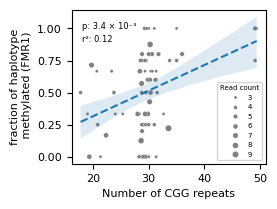

In [9]:
### plot fraction of heplotype methylated as a function of CGG repeat size
### get_here
df_methyl_plt = df_methyl.loc[(df_methyl.sex=='Female')].copy()
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_methyl_reads_h1!='.') | (df_methyl_plt.num_methyl_reads_h2!='.')]
df_methyl_plt['num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) if row.num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_reads_h1>=3) | (df_methyl_plt.num_reads_h2>=3)]

df_plt = pd.DataFrame()
for idx, row in df_methyl_plt.iterrows():
    sample = idx
    for hp in ['h1', 'h2']:
        if row[f'num_reads_{hp}'] >= 3:
            mean_rep = row[f'mean_repeat_length_{hp}']
            frac_hap = row[f'frac_hap_methyl_{hp}']
            xci_frac_hap = row[f'xci_frac_hap_methyl_{hp}']
            num_reads = row[f'num_reads_{hp}']
            rep_group = row['repeat_group']
            df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
                                   f'xci_frac_hap_methyl': [xci_frac_hap], f'num_reads': [num_reads], f'repeat_group': [rep_group]})
            df_plt = pd.concat([df_plt, df_tmp], ignore_index=True)
### get rid of one sample (REACH000563) if you need XCI values cause it's '.', for FMR1 plot it's ok to have that.
#df_plt = df_plt.loc[df_plt.xci_frac_hap_methyl != '.']
#cols = ['mean_repeat_length', 'frac_hap_methyl', 'xci_frac_hap_methyl', 'num_reads']
cols = ['mean_repeat_length', 'frac_hap_methyl', 'num_reads']
for col in cols:
    df_plt[col] = df_plt[col].astype(float)

def get_rep_group2(row):
    if row.repeat_group != '.':
        out = row.repeat_group
    else:
        out = ('≥35 CGG' if (row.mean_repeat_length >= 35) else 
               ('≤25 CGG' if (row.mean_repeat_length <= 25) else '26-34 CGG'))
    return out
df_plt['repeat_group'] = df_plt.apply(lambda row: get_rep_group2(row), axis=1)

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
print('df_plt:')
display(df_plt)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

x = np.array(df_plt.mean_repeat_length.tolist()).reshape(-1, 1) # Reshape for sklearn
y = np.array(df_plt.frac_hap_methyl.tolist())
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
#plt.plot(x, y_pred, '-ok', label='Regression Line')
# Get weights (coefficients) and intercept
print('Scikit learn LR model:')
print("Coefficients:", model.coef_)  # Slope
print("Intercept:", model.intercept_)  # Intercept

X = pd.DataFrame(df_plt.mean_repeat_length)
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_plt.frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

FS = 8
plt.figure(figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', color='gray', 
               size='num_reads', sizes=(5,20), legend='brief') # sizes gets a min max tuple interpreted by "size" hue='subject',
#hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'], 
sb.regplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Read count', loc='lower right', bbox_to_anchor=(1, 0), fontsize=FS-3, title_fontsize=FS-3) #handles=plt.gca().legend_.legend_handles[num_subjects+2:], 
#, handles=plt.gca().legend_.legend_handles[1:4]+plt.gca().legend_.legend_handles[5:12:2]

x_t = 18
y_t = 1
p = model_sm.pvalues['mean_repeat_length']
plt.text(x_t, y_t, f'p: {format_sci_notation(pval_rep_length)}', fontsize=FS-2, ha='left')
plt.text(x_t, y_t-.1, f'r²: {partial_r2_rep_length:.2f}', fontsize=FS-2, ha='left')

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (FMR1)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/haplotype_readFrac_methylation_vs_repeats_FMR1_fromTable.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

df_plt:


subject_id  mean_repeat_length      frac_hap_methyl  \
0       REACH000066           31.000000                  1.0   
1       REACH000087           30.000000                  0.0   
2       REACH000087           29.500000                 0.75   
3       REACH000089           30.000000                  0.5   
4       REACH000089           30.333333   0.6666666666666666   
5       REACH000092           31.000000                  0.0   
6       REACH000092           29.800000                  0.6   
7       REACH000093           29.250000                  1.0   
9       REACH000098           32.000000                  1.0   
12      REACH000121           23.000000                  0.0   
13      REACH000195           32.000000                  0.0   
14      REACH000195           23.000000                  0.0   
15      REACH000220           29.000000                 0.25   
16      REACH000220           29.000000                 0.25   
17      REACH000230           30.000000                  0.0   
18      REACH000230           20.666667   0.6666666666666666   
19      REACH000234           29.333333   0.6666666666666666   
20      REACH000234           30.600000                  0.8   
21      REACH000267           29.000000                  0.0   
22      REACH000267           30.000000                  1.0   
23      REACH000285           32.000000                  1.0   
24      REACH000285           25.333333   0.3333333333333333   
25      REACH000289           30.000000                  0.0   
26      REACH000289           30.000000                  0.0   
27      REACH000294           22.000000                  0.0   
28      REACH000294           23.333333   0.6666666666666666   
29      REACH000314           29.500000                  0.5   
30      REACH000314           31.000000                  0.5   
32      REACH000316           29.000000                  0.5   
33      REACH000365           30.166667  0.42857142857142855   
34      REACH000365           29.250000                 0.75   
35   REACH000436_PB           23.750000                  0.5   
36   REACH000436_PB           29.833333   0.3333333333333333   
37      REACH000451           28.800000                  0.2   
38      REACH000451           49.400000                  1.0   
39      REACH000453           31.200000                  0.6   
40      REACH000453           49.400000                  1.0   
42   REACH000530_PB           31.500000                  0.5   
43      REACH000628           30.250000                  0.6   
44      REACH000628           29.200000                  0.0   
45      REACH000641           31.000000                 0.25   
46      REACH000641           31.000000                  0.0   
48      REACH000651           37.000000                  1.0   
49      REACH000651           29.000000                  0.0   
50      REACH000654           30.000000                  0.0   
51      REACH000654           29.000000                  0.0   
52      REACH000672           30.000000                  1.0   
53      REACH000672           30.000000                  0.8   
54      REACH000674           30.000000                  0.0   
55      REACH000674           30.333333                  0.5   
56      REACH000702           29.333333   0.3333333333333333   
57      REACH000702           30.250000                0.875   
59      REACH000706           32.000000                  0.0   
60      REACH000727           31.000000                  1.0   
62      REACH000752           33.000000                  0.0   
64      REACH000755           24.000000   0.3333333333333333   
67      REACH000763           30.500000                  0.0   
70      REACH000766           31.000000                  0.0   
71      REACH000107           28.750000                  0.5   
72      REACH000107           28.333333   0.3333333333333333   
74      REACH000155           31.333333   0.6666666666666666   
75      REACH000401           17.750000  

df_plt, mean repeat > 45:


subject_id  mean_repeat_length frac_hap_methyl  xci_frac_hap_methyl  \
38   REACH000451           49.400000             1.0             0.407407   
40   REACH000453           49.400000             1.0             0.500000   
122  REACH000561           49.111111             1.0             0.523810   

     num_reads  xci_num_reads repeat_group  
38           2           27.0      ≥35 CGG  
40           3           24.0      ≥35 CGG  
122          5           21.0      ≥35 CGG

Scikit learn LR model:
Coefficients: [0.00159696]
Intercept: 0.41398029128204844
stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.1966
Date:                Wed, 30 Apr 2025   Prob (F-statistic):              0.658
Time:                        13:19:43   Log-Likelihood:                 29.895
No. Observations:                 122   AIC:                            -55.79
Df Residuals:                     120   BIC:                            -50.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

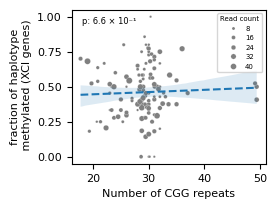

In [8]:
### plot fraction of heplotype methylated as a function of XCI methylation
### get_here
df_methyl_plt = df_methyl.loc[(df_methyl.sex=='Female')].copy()
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_methyl_reads_h1!='.') | (df_methyl_plt.num_methyl_reads_h2!='.')]
df_methyl_plt['num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) if row.num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt['xci_num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h1) + int(row.xci_num_unmethyl_reads_h1) if row.xci_num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['xci_num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h2) + int(row.xci_num_unmethyl_reads_h2) if row.xci_num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.xci_num_reads_h1>=3) | (df_methyl_plt.xci_num_reads_h2>=3)]

df_plt = pd.DataFrame()
for idx, row in df_methyl_plt.iterrows():
    sample = idx
    for hp in ['h1', 'h2']:
        if row[f'xci_num_reads_{hp}'] >= 3:
            mean_rep = row[f'mean_repeat_length_{hp}']
            frac_hap = row[f'frac_hap_methyl_{hp}']
            xci_frac_hap = row[f'xci_frac_hap_methyl_{hp}']
            num_reads = row[f'num_reads_{hp}']
            xci_num_reads = row[f'xci_num_reads_{hp}']
            rep_group = row['repeat_group']
            df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
                                   f'xci_frac_hap_methyl': [xci_frac_hap], f'num_reads': [num_reads], f'xci_num_reads': [xci_num_reads], f'repeat_group': [rep_group]})
            df_plt = pd.concat([df_plt, df_tmp], ignore_index=True)

### also get rid of the haplotypes where mean number of CGG repeats are missing
df_plt = df_plt.loc[df_plt.mean_repeat_length!='.']

cols = ['mean_repeat_length', 'xci_frac_hap_methyl', 'xci_num_reads']
for col in cols:
    df_plt[col] = df_plt[col].astype(float)

def get_rep_group2(row):
    if row.repeat_group != '.':
        out = row.repeat_group
    else:
        out = ('≥35 CGG' if (row.mean_repeat_length >= 35) else 
               ('≤25 CGG' if (row.mean_repeat_length <= 25) else '26-34 CGG'))
    return out
df_plt['repeat_group'] = df_plt.apply(lambda row: get_rep_group2(row), axis=1)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print('df_plt:')
display(df_plt)
print('df_plt, mean repeat > 45:')
display(df_plt.loc[(df_plt.mean_repeat_length >45) | (df_plt.mean_repeat_length >45)])
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

x = np.array(df_plt.mean_repeat_length.tolist()).reshape(-1, 1) # Reshape for sklearn
y = np.array(df_plt.xci_frac_hap_methyl.tolist())
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
#plt.plot(x, y_pred, '-ok', label='Regression Line')
# Get weights (coefficients) and intercept
print('Scikit learn LR model:')
print("Coefficients:", model.coef_)  # Slope
print("Intercept:", model.intercept_)  # Intercept

X = pd.DataFrame(df_plt.mean_repeat_length)
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_plt.xci_frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

FS = 8
plt.figure(figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x='mean_repeat_length', y='xci_frac_hap_methyl', size='xci_num_reads', sizes=(3,20), color='gray') # sizes gets a min max tuple interpreted by "size" hue='subject',
#hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'] , legend='brief'
sb.regplot(data=df_plt, x='mean_repeat_length', y='xci_frac_hap_methyl', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Read count', loc='upper right', bbox_to_anchor=(1, 1), fontsize=FS-3, title_fontsize=FS-3) #handles=plt.gca().legend_.legend_handles[num_subjects+2:], , handles=plt.gca().legend_.legend_handles[0:]

x_t = 18
y_t = 0.95
p = model_sm.pvalues['mean_repeat_length']
plt.text(x_t, y_t, f'p: {format_sci_notation(p)}', fontsize=FS-2, ha='left')
#plt.text(x_t, y_t-.1, f'r²: {r2:.2f}', fontsize=FS-2, ha='left')

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (XCI genes)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/haplotype_readFrac_methylation_vs_repeats_XCI_fromTable.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

/home/smmortazavi/micromamba/envs/bioinf/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/smmortazavi/micromamba/envs/bioinf/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


bp_dev_h1 xci_read_mean_methyl_lik_h1 bp_dev_h2  \
REACH000058               .                         NaN         .   
REACH000122               .                         NaN         .   
REACH000235               .                         NaN         .   
REACH000288               .                         NaN         .   
REACH000292               .                         NaN         .   
REACH000293               .                         NaN         .   
REACH000356               .                           3         .   
REACH000629               .                         NaN        30   
REACH000644               .                         NaN         .   
REACH000671               .                         NaN         .   
REACH000673               .                         NaN         .   
REACH000707               .                          75         .   
REACH000753         33,.,30                      15,4,1         .   
REACH000767               .                         NaN         .   
REACH000226_sperm         .                         NaN         .   
REACH000402        31,22,30                         NaN        26   
REACH000411               .                           6         .   
REACH000414               .                          21         .   
REACH000416               .                   6,32,1,12         .   
REACH000421               .                        20,2         .   
REACH000422               .                         NaN        14   
REACH000423               .                         NaN         .   
REACH000426               .                          10         .   
REACH000427               .                         NaN         .   
REACH000428               .                           8         .   
REACH000442               .                         NaN         .   
REACH000448               .                         NaN         .   
REACH000476               .                      68,0,6         .   
REACH000478               .                           2         .   
REACH000481               .                         NaN         .   
REACH000503               .                         NaN         .   
REACH000512               .                         NaN         .   
REACH000514               .                         0,3         .   
REACH000517               .                         0,8         .   
REACH000529               .                         NaN         .   
REACH000532_ONT           .                         NaN         .   
REACH000540               .                           2         .   
REACH000542               .                      34,1,6         .   
REACH000546               .                         NaN         .   
REACH000557               .                           4         .   
REACH000558               .                         NaN         .   
REACH000559               .                          11         .   
REACH000562               .                         NaN         .   
REACH000564               .                       19,17         .   
REACH000566              24                         NaN         .   
REACH000580               .                         6,3         .   
REACH000626               .                         5,0         .   
REACH000662               .                         NaN         .   
REACH000663               .                           2         .   
REACH000681               .                           5         .   
REACH000683               .                         NaN         .   
REACH000684        30,24,24                         NaN  23,15,24   
REACH000685               .                          23         .   

                  xci_read_mean_methyl_lik_h2  \
REACH000058                               NaN   
REACH000122                              16,3   
REACH000235                               6,2   
REACH000288                               NaN   
REACH000292                               NaN 

fragile_x_all//haplotype_readFrac_methylation_vs_repeats_FMR1_MALES_fromTable.png


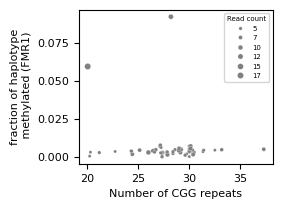

In [58]:
df_methyl_plt = df_methyl.loc[(df_methyl.sex=='Male')].copy()
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_methyl_reads_h1!='.') | (df_methyl_plt.num_methyl_reads_h2!='.') | (df_methyl_plt.num_methyl_reads_h0!='.')]
df_methyl_plt['repeat_lengths'] = df_methyl_plt.apply(lambda row: ','.join([x for x in [row.repeat_length_h1, row.repeat_length_h2, row.repeat_length_h0] if x!='.']), axis=1)
df_methyl_plt['mean_repeat_length'] = df_methyl_plt.repeat_lengths.map(lambda x: np.mean([int(xx) for xx in x.split(',') if xx!='.' and xx!='']))
df_methyl_plt['num_methyl_reads'] = df_methyl_plt.apply(lambda row: np.sum([int(x) for x in [row.num_methyl_reads_h1, row.num_methyl_reads_h2, row.num_methyl_reads_h0] if x!='.']), axis=1)
df_methyl_plt['num_unmethyl_reads'] = df_methyl_plt.apply(lambda row: np.sum([int(x) for x in [row.num_unmethyl_reads_h1, row.num_unmethyl_reads_h2, row.num_unmethyl_reads_h0] if x!='.']), axis=1)
df_methyl_plt['num_reads'] = df_methyl_plt['num_methyl_reads'] + df_methyl_plt['num_unmethyl_reads']
df_methyl_plt['frac_methyl'] = df_methyl_plt['num_methyl_reads'] / (df_methyl_plt['num_methyl_reads'] + df_methyl_plt['num_unmethyl_reads'])
### using 4 as a read count threshold cause there is only one haplotype here and we are using all phased and unphased reads, so we can be more stringent
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_reads>=4)]

### jitter methylation randomly so the points don't fall onto each other
np.random.seed(42)  # Set the seed
rnd = np.random.normal(loc=0, scale=1, size=df_methyl_plt.shape[0])  # Mean 0, std dev 1
eps = 0.002
df_methyl_plt['frac_methyl'] = df_methyl_plt['frac_methyl'] + (rnd + np.abs(np.min(rnd))) * eps

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(df_methyl_plt)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

FS = 8
plt.figure(figsize=(2.5, 2))
sb.scatterplot(data=df_methyl_plt, x='mean_repeat_length', y='frac_methyl', color='gray', size='num_reads', sizes=(5,20)) # sizes gets a min max tuple interpreted by "size"
plt.legend(title='Read count', loc='upper right', bbox_to_anchor=(1, 1), fontsize=FS-3, title_fontsize=FS-3) # handles=plt.gca().legend_.legend_handles[num_subjects+2:], 

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (FMR1)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
#plt.xlim(xmax=52)
fig_name = f'{dir_fig}/haplotype_readFrac_methylation_vs_repeats_FMR1_MALES_fromTable.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

/home/smmortazavi/micromamba/envs/bioinf/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/smmortazavi/micromamba/envs/bioinf/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


subject_id haplotype     sex  mean_repeat_length  num_reads
0    REACH000066        h1  Female           31.000000          1
1    REACH000066        h2  Female           31.333333          3
2    REACH000087        h1  Female           30.000000          1
3    REACH000087        h2  Female           29.500000          4
4    REACH000089        h1  Female           30.000000          2
..           ...       ...     ...                 ...        ...
233  REACH000663        hm    Male           33.166667          6
234  REACH000681        hm    Male           20.250000          4
235  REACH000683        hm    Male           29.250000          4
236  REACH000684        hm    Male           27.833333          6
237  REACH000685        hm    Male           27.200000          5

[238 rows x 5 columns]

df_plt for repeat ≥39:


subject_id haplotype     sex  mean_repeat_length  num_reads
35   REACH000451        h2  Female           49.400000          2
37   REACH000453        h2  Female           49.400000          3
106  REACH000561        h2  Female           49.111111          5
108  REACH000563        h2  Female           49.111111          4
225  REACH000560        hm    Male           41.000000          1

df_plt for repeat ≤20:


subject_id haplotype     sex  mean_repeat_length  num_reads
63   REACH000401        h1  Female           17.750000          4
66   REACH000404        h2  Female           19.714286          7
74   REACH000420        h1  Female           19.333333          6
85   REACH000482        h2  Female           19.000000          3
142  REACH000216        hm    Male           19.500000          2
183  REACH000764        hm    Male           20.000000          1
191  REACH000403        hm    Male           19.666667          3
230  REACH000604        hm    Male           18.333333          3

bins: [15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5
 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5 42.5
 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5]
fragile_x_all//dist_num_repeats_fromTable.png


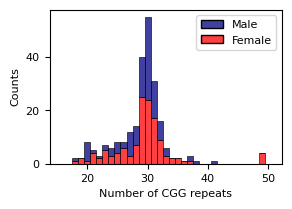

In [50]:
### distribution of CGG repeat size

### set female subjects
df_methyl_fm = df_methyl.loc[(df_methyl.sex=='Female')].copy()
df_methyl_fm['num_reads_h1'] = df_methyl_fm.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_fm['num_reads_h2'] = df_methyl_fm.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) if row.num_methyl_reads_h2!='.' else 0, axis=1)

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#display(df_methyl_fm)
#pd.set_option('display.max_rows', 10)
#pd.set_option('display.max_columns', 10)

df_plt_fm = pd.DataFrame()
for idx, row in df_methyl_fm.iterrows():
    sample = idx
    for hp in ['h1', 'h2']:
        if row[f'mean_repeat_length_{hp}'] != '.':
            mean_rep = row[f'mean_repeat_length_{hp}']
            #frac_hap = row[f'frac_hap_methyl_{hp}']
            #xci_frac_hap = row[f'xci_frac_hap_methyl_{hp}']
            num_reads = row[f'num_reads_{hp}']
            #xci_num_reads = row[f'xci_num_reads_{hp}']
            #rep_group = row['repeat_group']
            df_tmp = pd.DataFrame({'subject_id': [idx], 'haplotype': [hp], 'sex': ['Female'], f'mean_repeat_length': [mean_rep], f'num_reads': [num_reads]})
            df_plt_fm = pd.concat([df_plt_fm, df_tmp], ignore_index=True)

# set male subjects
df_methyl_m = df_methyl.loc[(df_methyl.sex=='Male')].copy()
df_methyl_m = df_methyl_m.loc[(df_methyl_m.num_methyl_reads_h1!='.') | (df_methyl_m.num_methyl_reads_h2!='.') | (df_methyl_m.num_methyl_reads_h0!='.')]
df_methyl_m['repeat_lengths'] = df_methyl_m.apply(lambda row: ','.join([x for x in [row.repeat_length_h1, row.repeat_length_h2, row.repeat_length_h0] if x!='.']), axis=1)
df_methyl_m['mean_repeat_length'] = df_methyl_m.repeat_lengths.map(lambda x: np.mean([int(xx) for xx in x.split(',') if xx!='.' and xx!='']))
df_methyl_m['num_methyl_reads'] = df_methyl_m.apply(lambda row: np.sum([int(x) for x in [row.num_methyl_reads_h1, row.num_methyl_reads_h2, row.num_methyl_reads_h0] if x!='.']), axis=1)
df_methyl_m['num_unmethyl_reads'] = df_methyl_m.apply(lambda row: np.sum([int(x) for x in [row.num_unmethyl_reads_h1, row.num_unmethyl_reads_h2, row.num_unmethyl_reads_h0] if x!='.']), axis=1)
df_methyl_m['num_reads'] = df_methyl_m['num_methyl_reads'] + df_methyl_m['num_unmethyl_reads']
df_methyl_m['subject_id'] = df_methyl_m.index
df_methyl_m['haplotype'] = 'hm'
df_plt_m = df_methyl_m[['subject_id', 'haplotype', 'sex', 'mean_repeat_length', 'num_reads']]

df_plt = pd.concat([df_plt_fm, df_plt_m], ignore_index=True)
### filter for number of reads
#df_plt = df_plt.loc[df_plt.num_reads >= 3]
df_plt['mean_repeat_length'] = df_plt['mean_repeat_length'].astype(float)

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
display(df_plt)
print('df_plt for repeat ≥39:')
display(df_plt.loc[df_plt.mean_repeat_length>=39])
print('df_plt for repeat ≤20:')
display(df_plt.loc[df_plt.mean_repeat_length<=20])
#pd.set_option('display.max_rows', 10)
#pd.set_option('display.max_columns', 10)

FS = 8
bins = np.linspace(15,50,50-15+1) + .5
print(f'bins: {bins}')
plt.figure(figsize=(3, 2))
ax = sb.histplot(data=df_plt, x='mean_repeat_length', bins=bins, hue='sex', hue_order=['Male', 'Female'], palette=['navy', 'red'], multiple='stack', edgecolor='black')
sb.move_legend(ax, loc='best', title='', fontsize=FS)
#plt.legend(loc='upper right', handles=plt.gca().legend_.legend_handles[0:], bbox_to_anchor=(1, 1), fontsize=FS) #title='SEX', 
plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('Counts', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
#plt.xlim(xmax=52)
fig_name = f'{dir_fig}/dist_num_repeats_fromTable.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

In [5]:
### make a table of raw data for other select genes
def get_gene_methyl_data(region_id, df_exnd, sample_order, samples_only=None):
    df_out = pd.DataFrame()
    
    this_idx = df_exnd.loc[df_exnd.region_id==region_id].index.tolist()[0]
    cols_met = [f'methyl_h1', f'methyl_h2', f'methyl_h0']
    cols_ps = [f'ps_h1', f'ps_h2']
    for col in cols_met+cols_ps:
        df_out[col] = pd.Series(dtype='str')

    if samples_only == None:
        for sample in sample_order:        
            ### set methylation columns
            for col in cols_met:
                df_out.loc[sample, col] = df_exnd.loc[df_exnd.region_id==region_id].loc[this_idx, f'{sample}_{col}']
            ### set phase set columns
            for col in cols_ps:
                df_out.loc[sample, col] = df_exnd.loc[df_exnd.region_id==region_id].loc[this_idx, f'{sample}_{col}']
    else:
        for sample in sample_order:
            if sample in samples_only:
                ### set methylation columns
                for col in cols_met:
                    df_out.loc[sample, col] = df_exnd.loc[df_exnd.region_id==region_id].loc[this_idx, f'{sample}_{col}']
                ### set phase set columns
                for col in cols_ps:
                    df_out.loc[sample, col] = df_exnd.loc[df_exnd.region_id==region_id].loc[this_idx, f'{sample}_{col}']
    
    ### compute mean methylation likelihood for each read
    for col in cols_met:
        df_out[f'read_mean_methyl_lik_{col.split("_")[-1]}'] = df_out.apply(lambda row: ','.join([str(round(np.mean([float(xx) for xx in x.split('|')]))) for x in row[col].split(',') if x != '.'])
                                                                                 if row[col] != '.' else '.', axis=1)
    for col in cols_met:
        hp = col.split("_")[-1]
        df_out[f'num_methyl_reads_{hp}'] = df_out[f'read_mean_methyl_lik_{hp}'].apply(lambda x: len([xx for xx in x.split(',') if float(xx)>=50]) if x != '.' else '.')
        df_out[f'num_unmethyl_reads_{hp}'] = df_out[f'read_mean_methyl_lik_{hp}'].apply(lambda x: len([xx for xx in x.split(',') if float(xx)<50]) if x != '.' else '.')
        df_out[f'frac_hap_methyl_{hp}'] = df_out.apply(lambda row: int(row[f'num_methyl_reads_{hp}'])/(int(row[f'num_methyl_reads_{hp}'])+int(row[f'num_unmethyl_reads_{hp}'])) 
                                                               if (row[f'num_methyl_reads_{hp}']!='.' and row[f'num_unmethyl_reads_{hp}']!='.') else '.', axis=1)
    
    return df_out

In [6]:
### read select genes methylation for subjects in the skew plot
file_in_og = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/METHYLATION/snoopsv_methyl/chrX_All_Genes/RUN_SELECT_GENES_other_samples/methyl_data.tsv'
df_og = pd.read_table(file_in_og, sep='\t', header=0, keep_default_na=False)

pd.set_option('display.max_columns', None)
print('df_og:')
display(df_og)
pd.set_option('display.max_columns', 10)

file_sam = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/METHYLATION/snoopsv_methyl/chrX_All_Genes/RUN_SELECT_GENES_other_samples/methyl_data_sample_order.txt'
with open(file_sam, 'r') as fh:
    sample_order_og = fh.readline().split(',')[:-1] # last one is an empty string
print(f'number of samples: {len(sample_order_og)}')
#print(f'sample order: {sample_order_og}')

df_exnd_og = df_og[['chrom' ,'pos', 'end', 'region_id']].copy()
cols = df_og.columns.tolist()[4:]
#print(cols)

for idx, sample in enumerate(sample_order_og):
    #if sample == 'REACH000450' or sample == 'REACH000452':
    #    continue
    for col in cols:
        df_exnd_og[f'{sample}_{col}'] = df_og[col].str.split(';').apply(lambda row: row[idx])
print('df_exnd_og:')
display(df_exnd_og)

df_og:


chrom        pos        end     region_id  \
0    chrX   10620123   10620805     MID1_5UTR   
1    chrX   11663929   11665723  ARHGAP6_5UTR   
2    chrX   12791015   12791585    PRPS2_5UTR   
3    chrX   13044401   13045071    FAM9C_5UTR   
4    chrX   13816674   13817842    GPM6B_5UTR   
..    ...        ...        ...           ...   
158  chrX  154457737  154458815   PLXNA3_5UTR   
159  chrX  154515851  154516567    FAM3A_5UTR   
160  chrX  154750529  154751289     GAB3_5UTR   
161  chrX  154762543  154763011     DKC1_5UTR   
162  chrX  155263841  155264649   RAB39B_5UTR   

                                             methyl_h1  \
0    .;.;.;.;.;.;.;.;.;2|2|34|21|9|38|52|66|56|18|1...   
1    .;.;.;12|33|72|92|98|99|98|99|96|93|95|99|99|9...   
2    .;.;.;96|82|42|36|92|94|91|74|94|99|99|97|97|9...   
3    .;.;.;46|53|92|91|65|93|98|99|100|100|100|100|...   
4    .;.;.;21|34|70|55|72|63|57|59|24|7|15|13|9|7|8...   
..                                                 ...   
158  .;.;.;.;.;.;.;.;.;.;11|31|14|14|55|30|36|4|3|2...   
159  .;.;0|0|0|1|1|8|9|14|3|1|2|1|0|0|0|2|2|2|5|7|1...   
160  .;.;.;.;.;.;76|99|96|94|98|99|85|79|35|26|9|1|...   
161  .;.;.;100|100|100|100|100|96|73|93|82|86|90|96...   
162  .;.;.;32|53|27|30|49|77|22|4|0|1|0|0|0|0|0|1|3...   

                                             methyl_h2  \
0    .;.;.;.;.;.;.;.;.;22|55|23|34|52|71|37|63|36|3...   
1    .;.;.;16|14|19|79|98|80|90|52|57|28|4|5|4|9|24...   
2    .;.;.;.;.;.;.;.;1|0|0|0|0|0|0|0|0|7|15|19|8|4|...   
3    .;.;.;74|88|95|96|96|97|94|98|98|93|95|95|83|9...   
4    .;.;.;26|35|9|0|0|0|0|2|2|1|2|12|20|16|2|0|1|4...   
..                                                 ...   
158  .;.;.;.;.;.;.;.;.;4|0|0|0|0|0|0|0|0|0|5|20|20|...   
159  .;.;.;.;.;.;6|0|3|16|15|23|13|11|36|68|27|9|19...   
160  .;.;.;0|2|5|45|88|93|81|91|92|90|44|32|94|99|9...   
161  .;.;1|4|7|29|38|7|20|14|31|11|2|1|77|18|3|0|0|...   
162  .;.;.;.;.;.;84|80|38|22|26|54|71|7|21|63|69|56...   

                                             methyl_h0  \
0    2|2|11|4|0|2|33|10|1|0|1|1|1|0|1|4|11|3|5|1|0|...   
1    99|98|96|94|88|27|58|48|25|20|5|5|2|1|0|0|1|3|...   
2    0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|2|8|5|7|2|...   
3    94|90|88|72|76|79|29|41|98|98|100|100|99|100|1...   
4    100|99|100|100|99|99|100|99|99|99|99|99|100|99...   
..                                                 ...   
158  0|0|0|0|18|6|1|0|2|5|1|0|0|0|0|0|0|0|0|0|0|0|0...   
159  0|2|4|6|11|30|7|8|11|5|1|0|0|0|0|0|0|1|5|1|0|0...   
160  0|0|0|2|8|21|5|2|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0...   
161  3|4|46|86|52|73|74|65|47|17|14|7|4|2|5|7|11|16...   
162  5|2|0|0|0|0|0|0|0|0|0|0|0|0|0|1|1|23|21|25|30|...   

                                             bp_dev_h1  \
0    .;.;.;.;.;.;.;.;.;0;.;.;.;.;.;.;.;-3,.;.;.;.;....   
1    .;.;.;3;.;.;.;.;0;0;.,0,0,24,0,.;.;.;.;-2;.;.;...   
2    .;.;.;1;.;.;-1,2;.;-1;0,0;-5;.;7,5;.;8,0;.;.;....   
3    .;.;.;5,5;.;.;1;.;.;-1,3,1;.;.;1;.;.;.;.;.;.;....   
4    .;.;.;-1,3,3,5,.;.;.;.;.;1;-3,7,.;-3,0,-2;.;.,...   
..                                                 ...   
158  .;.;.;.;.;.;.;.;.;.;6,10,0;.;-1;.;.;.;.;.;.;.;...   
159  .;.;6;6;.;.;-1,2;.;.;.;.;.;.;.;5,-1;.;.;-1;.;....   
160  .;.;.;.;.;.;5,-1;.;5;1,2,6,3,13,.;2;.;8,1;.;2,...   
161  .;.;.;3,0;.;.;-1,1;.;12,2;0,4,6,-1,1,3,0,0,0,-...   
162  .;.;.;5;.;.;0,0;.;.;.;.;.;.;.;.;.;.;.;.;.;.;.;...   

                                             bp_dev_h2  \
0    .;.;.;.;.;.;.;.;.;3;.;.;1;.;.;.;.;-6,1;.;.;.;....   
1    .;.;.;8;.;.;.;.;.;0,25;16,17,1,0,.;.;.;.;2,7,6...   
2    .;.;.;.;.;.;.;.;-3;0,-2,0;.;.;0,0,-3,6,2,-1;.;...   
3    .;.;.;5,1;.;.;.;.;-2;2,-1,.;.;.;2,8;.;.;.;.;2,...   
4    .;.;.;9,-4;.;-2,1;2;4;6,-5;-5,.,.,0,1,12,-2,0;...   
..                                                 ...   
158  .;.;.;.;.;.;.;.;.;6,4,1;5,16;.;7,0;.;.;.;.;.;....   
159  .;.;.;.;.;.;2,1;.;0,-1;.;.;.;.;.;.;.;.;.;.;.;....   
160  .;.;.;10,9;.;.;.;.;0;.;.;4,-1,1,2;.;2,0;.;.;.;...   
161  .;.;0;5,6;.;.;.;.;0,-1;.;.;4,-1;.;1;0,4;.;

number of samples: 270
df_exnd_og:


chrom        pos        end     region_id REACH000026_methyl_h1  ...  \
0    chrX   10620123   10620805     MID1_5UTR                     .  ...   
1    chrX   11663929   11665723  ARHGAP6_5UTR                     .  ...   
2    chrX   12791015   12791585    PRPS2_5UTR                     .  ...   
3    chrX   13044401   13045071    FAM9C_5UTR                     .  ...   
4    chrX   13816674   13817842    GPM6B_5UTR                     .  ...   
..    ...        ...        ...           ...                   ...  ...   
158  chrX  154457737  154458815   PLXNA3_5UTR                     .  ...   
159  chrX  154515851  154516567    FAM3A_5UTR                     .  ...   
160  chrX  154750529  154751289     GAB3_5UTR                     .  ...   
161  chrX  154762543  154763011     DKC1_5UTR                     .  ...   
162  chrX  155263841  155264649   RAB39B_5UTR                     .  ...   

    REACH000685_rn_h1 REACH000685_rn_h2  \
0                   .                 .   
1                   .                 .   
2                   .                 .   
3                   .                 .   
4                   .                 .   
..                ...               ...   
158                 .                 .   
159                 .                 .   
160                 .                 .   
161                 .                 .   
162                 .                 .   

                                     REACH000685_rn_h0 REACH000685_ps_h1  \
0    d8c3a034-713f-45e7-afc3-5bd725037e60,4ed0dc63-...                 .   
1    48fde9cd-8d16-4466-968f-bc2702649e69,72cf700b-...                 .   
2    7ac125ba-e89e-4916-b232-f2de4a0176b2,74c8650b-...                 .   
3    7b324b3e-8553-4a6b-a86f-218833ae9489,d050936f-...                 .   
4    e8d3ece7-d441-4bee-99fa-322791acda4d,441af2cd-...                 .   
..                                                 ...               ...   
158  206d001e-a23b-4bc8-b79f-7dfbe1ead309,cb5fa621-...                 .   
159  efb7f9d6-7497-4cf0-ac98-7c3012616b7a,b03822db-...                 .   
160  129c6e04-18e0-4f22-af8e-c5ce9d3cfd01,37594a25-...                 .   
161  eb986a78-64c7-4ab1-b42e-566131904deb,44593820-...                 .   
162  dd2af919-096b-4269-becc-8389e3051162,df83db44-...                 .   

    REACH000685_ps_h2  
0                   .  
1                   .  
2                   .  
3                   .  
4                   .  
..                ...  
158                 .  
159                 .  
160                 .  
161                 .  
162                 .  

[163 rows x 2974 columns]

In [17]:
pd.set_option('display.max_rows', 20)
display(df_exnd_og.loc[range(0,20),['region_id', 'REACH000561_ps_h1', 'REACH000561_ps_h2']])
pd.set_option('display.max_rows', 10)

region_id                                REACH000561_ps_h1  \
0        MID1_5UTR                                                .   
1     ARHGAP6_5UTR                          10215,10215,10215,10215   
2       PRPS2_5UTR                                                .   
3       FAM9C_5UTR                                                .   
4       GPM6B_5UTR                                            10215   
5         BMX_5UTR                                                .   
6     MAP3K15_5UTR                                                .   
7     SH3KBP1_5UTR                                                .   
8      CNKSR2_5UTR                                                .   
9      MBTPS2_5UTR                          10215,10215,10215,10215   
10        SMS_5UTR                                10215,10215,10215   
11      PRDX4_5UTR                                            10215   
12      ACOT9_5UTR              10215,10215,10215,10215,10215,10215   
13       SAT1_5UTR              10215,10215,10215,10215,10215,10215   
14  SUPT20HL1_5UTR  10215,10215,10215,10215,10215,10215,10215,10215   
15     PCYT1B_5UTR                                      10215,10215   
16        ARX_5UTR                                                .   
17    MAGEB18_5UTR              10215,10215,10215,10215,10215,10215   
18     MAGEB1_5UTR  10215,10215,10215,10215,10215,10215,10215,10215   
19      NR0B1_5UTR                                            10215   

                      REACH000561_ps_h2  
0                                     .  
1                     10215,10215,10215  
2                                 10215  
3                                     .  
4                     10215,10215,10697  
5                                     .  
6                                     .  
7                                     .  
8                                     .  
9                                 10215  
10                    10215,10215,10215  
11                                    .  
12                                    .  
13        10215,10215,10215,10215,10215  
14  10215,10215,10215,10215,10215,10215  
15                          10215,18519  
16                                    .  
17        10215,18519,10215,10215,10215  
18              10215,10215,10215,10215  
19                                10215

In [7]:
cols_corr = ['read_mean_methyl_lik_h1', 'read_mean_methyl_lik_h2', 'read_mean_methyl_lik_h0', 
             'num_methyl_reads_h1', 'num_methyl_reads_h2', 'num_methyl_reads_h0', 
             'num_unmethyl_reads_h1', 'num_unmethyl_reads_h2', 'num_unmethyl_reads_h0', 
             'frac_hap_methyl_h1', 'frac_hap_methyl_h2', 'frac_hap_methyl_h0']
as_type = [str, str, str, int, int, str, int, int, str, float, float, str]
pd.set_option('display.max_columns', None)
display(df_methyl.loc[['REACH000561'],cols_corr])
pd.set_option('display.max_columns', 10)

read_mean_methyl_lik_h1 read_mean_methyl_lik_h2  \
REACH000561               17,29,7,5          72,79,60,58,87   

            read_mean_methyl_lik_h0 num_methyl_reads_h1 num_methyl_reads_h2  \
REACH000561                       .                   0                   5   

            num_methyl_reads_h0 num_unmethyl_reads_h1 num_unmethyl_reads_h2  \
REACH000561                   .                     4                     0   

            num_unmethyl_reads_h0 frac_hap_methyl_h1 frac_hap_methyl_h2  \
REACH000561                     .                0.0                1.0   

            frac_hap_methyl_h0  
REACH000561                  .

In [8]:
df_tmp = df_methyl_sample.copy()
pd.set_option('display.max_columns', None)
display(df_methyl_sample.loc[(df_methyl_sample.region_id=='FMR1_5UTR') & (df_methyl_sample.index=='REACH000561')])
display(df_tmp.loc[(df_tmp.region_id=='FMR1_5UTR') & (df_tmp.index=='REACH000561')][cols_corr])
#tmp = df_methyl.loc[['REACH000561'],cols_corr].copy()
for col, t in zip(cols_corr, as_type):
    df_tmp.loc[(df_tmp.region_id=='FMR1_5UTR') & (df_tmp.index=='REACH000561'), [col]] = df_methyl.loc[['REACH000561'],[col]].astype(t)
display(df_tmp.loc[(df_tmp.region_id=='FMR1_5UTR') & (df_tmp.index=='REACH000561')][cols_corr])
pd.set_option('display.max_columns', 10)

NameError: name 'df_methyl_sample' is not defined

In [9]:
### make the methylation data of all regions for subjects in the skew plot
samples_only = ['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519', 
                'REACH000234', 'REACH000365', 'REACH000436_PB', 'REACH000616', 'REACH000628', 'REACH000672', 'REACH000674', 
                'REACH000702', 'REACH000107', 'REACH000404', 'REACH000417', 'REACH000435', 'REACH000482', 'REACH000510', 
                'REACH000547', 'REACH000581', 'REACH000220']
df_methyl_sample = pd.DataFrame()
for i, region_id in enumerate(df_exnd_og.region_id.tolist()):
    print(f'{i} {region_id}')
    this_df = get_gene_methyl_data(region_id, df_exnd_og, sample_order_og, samples_only)
    this_df['region_id'] = region_id
    df_methyl_sample = pd.concat([df_methyl_sample, this_df])

### correct FMR1 methylation data for REACH000561 from before corrections
cols_corr = ['read_mean_methyl_lik_h1', 'read_mean_methyl_lik_h2', 'read_mean_methyl_lik_h0', 
             'num_methyl_reads_h1', 'num_methyl_reads_h2', 'num_methyl_reads_h0', 
             'num_unmethyl_reads_h1', 'num_unmethyl_reads_h2', 'num_unmethyl_reads_h0', 
             'frac_hap_methyl_h1', 'frac_hap_methyl_h2', 'frac_hap_methyl_h0']
as_type = [str, str, str, int, int, str, int, int, str, float, float, str]
for col, t in zip(cols_corr, as_type):
    df_methyl_sample.loc[((df_methyl_sample.region_id=='FMR1_5UTR') & 
                          (df_methyl_sample.index=='REACH000561')), [col]] = df_methyl.loc[['REACH000561'],[col]].astype(t)
#df_methyl_sample.loc[((df_methyl_sample.region_id=='FMR1_5UTR') & 
#                      (df_methyl_sample.index=='REACH000561')), cols_corr] = df_methyl.loc[['REACH000561'],cols_corr]

df_methyl_sample['num_reads_h1'] = df_methyl_sample.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) 
                                                  if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_sample['num_reads_h2'] = df_methyl_sample.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) 
                                                  if row.num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_sample['Read count'] = df_methyl_sample['num_reads_h1'] + df_methyl_sample['num_reads_h2']
pd.set_option('display.max_columns', None)

pd.set_option('display.max_columns', None)
print('df_methyl_sample:')
print(df_methyl_sample.shape)
display(df_methyl_sample)
pd.set_option('display.max_columns', 10)

0 MID1_5UTR
1 ARHGAP6_5UTR
2 PRPS2_5UTR
3 FAM9C_5UTR
4 GPM6B_5UTR
5 BMX_5UTR
6 MAP3K15_5UTR
7 SH3KBP1_5UTR
8 CNKSR2_5UTR
9 MBTPS2_5UTR
10 SMS_5UTR
11 PRDX4_5UTR
12 ACOT9_5UTR
13 SAT1_5UTR
14 SUPT20HL1_5UTR
15 PCYT1B_5UTR
16 ARX_5UTR
17 MAGEB18_5UTR
18 MAGEB1_5UTR
19 NR0B1_5UTR
20 GK_5UTR
21 TAB3_5UTR
22 FTHL17_5UTR
23 CFAP47_5UTR
24 FAM47C_5UTR
25 XK_5UTR
26 SRPX_5UTR
27 RPGR_5UTR
28 OTC_5UTR
29 MID1IP1_5UTR
30 USP9X_5UTR
31 CASK_5UTR
32 ZNF674_5UTR
33 CHST7_5UTR
34 SLC9A7_5UTR
35 ARAF_5UTR
36 TIMP1_5UTR
37 ZNF81_5UTR
38 ZNF182_5UTR
39 SPACA5_5UTR
40 ZNF630_5UTR
41 RBM3_5UTR
42 PCSK1N_5UTR
43 OTUD5_5UTR
44 KCND1_5UTR
45 PLP2_5UTR
46 PRICKLE3_5UTR
47 SHROOM4_5UTR
48 NUDT10_5UTR
49 NUDT11_5UTR
50 GSPT2_5UTR
51 PHF8_5UTR
52 FAM120C_5UTR
53 FGD1_5UTR
54 MAGED2_5UTR
55 FAM104B_5UTR
56 AMER1_5UTR
57 ZC3H12B_5UTR
58 EFNB1_5UTR
59 PJA1_5UTR
60 NALF2_5UTR
61 EDA_5UTR
62 PDZD11_5UTR
63 DLG3_5UTR
64 MED12_5UTR
65 NLGN3_5UTR
66 NHSL2_5UTR
67 RTL5_5UTR
68 CITED1_5UTR
69 NAP1L2_5UTR
70 CDX4_5UTR
71 

methyl_h1  \
REACH000220                                                     .   
REACH000234     77|81|91|72|65|59|19|2|0|1|2|0|2|21|28|53|51|7...   
REACH000365                                                     .   
REACH000436_PB  44|93|96|98|97|100|99|98|73|9|2|3|0|11|66|68|7...   
REACH000451                                                     .   
...                                                           ...   
REACH000518     0|0|1|0|0|0|13|0|7|11|0|0|0|6|0|0|0|0|0|0|0|4|...   
REACH000519     7|0|3|0|0|0|6|41|0|0|0|3|0|0|0|0|1|0|0|0|0|2|0...   
REACH000547     33|0|5|23|59|96|3|98|0|2|30|14|18|1|16|38|11|5...   
REACH000561                                                     .   
REACH000581                                                     .   

                                                        methyl_h2  \
REACH000220                                                     .   
REACH000234     0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
REACH000365                                                     .   
REACH000436_PB  98|99|98|93|96|84|38|4|0|0|0|1|4|9|14|81|95|85...   
REACH000451     0|0|0|0|0|9|2|0|0|0|0|0|0|0|0|0|1|1|1|0|0|0|0|...   
...                                                           ...   
REACH000518     1|10|4|75|1|0|1|0|0|0|1|1|60|0|0|8|2|0|0|0|0|1...   
REACH000519     1|68|41|2|1|0|79|82|0|64|4|2|23|0|0|5|0|3|2|0|...   
REACH000547     100|55|92|100|99|45|86|99|99|91|99|100|100|100...   
REACH000561                                                     .   
REACH000581                                                     .   

                                                        methyl_h0  \
REACH000220     10|12|16|13|4|5|2|4|1|0|0|0|0|0|0|0|1|0|0|0|0|...   
REACH000234     78|99|99|100|99|97|98|95|26|5|1|10|12|5|29|26|...   
REACH000365     0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
REACH000436_PB                                                  .   
REACH000451     82|95|98|97|82|82|62|72|33|14|32|56|29|5|3|4|5...   
...                                                           ...   
REACH000518     0|100|14|98|98|98|0|100|96|0|100|100|0|5|0|1|1...   
REACH000519     100|53|0|0|0|0|3|14|0|0|2|8|0|40|0|2|1|0|29|0|...   
REACH000547                                        0|0|1|29|8|0|0   
REACH000561     7|65|0|0|0|0|7|0|0|0|0|0|0|0|9|0|0|0|0|1|2|57|...   
REACH000581     5|27|100|100|98|100|100|100|84|0|0|0|99|69|0|0...   

                                                       ps_h1  \
REACH000220                                                .   
REACH000234                                      10185,10185   
REACH000365                                                .   
REACH000436_PB  10532334,10532334,10532334,10532334,10532334   
REACH000451                                                .   
...                                                      ...   
REACH000518                          10185,10185,10185,10185   
REACH000519                                            10185   
REACH000547        12790,12790,12790,12790,12790,12790,12790   
REACH000561                                                .   
REACH000581                                                .   

                                     ps_h2 read_mean_methyl_lik_h1  \
REACH000220                              .                       .   
REACH000234              10185,10185,10185                    32,2   
REACH000365                              .                       .   
REACH000436_PB  10532334,10532334,10532334            39,9,55,2,67   
REACH000451                          10185                       .   
...                                    ...                     ...   
REACH000518                    10185,10185               3,4,61,13   
REACH000519                          10185                       2   
REACH000547              12790,12790,12790      16,36,64,47,2,9,75   
REACH000561                              .                       .   
REACH000581                   

In [10]:

df_methyl_sample['fmr1_mean_repeat_length_h1'] = df_methyl_sample.index.map(df_methyl.mean_repeat_length_h1).astype(float)
df_methyl_sample['fmr1_mean_repeat_length_h2'] = df_methyl_sample.index.map(df_methyl.mean_repeat_length_h2).astype(float)
df_methyl_sample['fmr1_mean_repeat_length_h0'] = df_methyl_sample.index.map(df_methyl.mean_repeat_length_h0)

### for those subjects with both haplotypes present (must be females), compute large and small haplotype stats (frac, mean rep, skewness)
### haplotype of col_in_1 must correspond to col_out_1 and the same for _2
### output is large: first, small: second
def get_large_small_vals(row, col_in_1, col_in_2, col_out_1, col_out_2):
    ### no need to check for sex and '.' present in num_methyla_reads
    #if row.sex != 'Female':
    #    return '.', '.'
    #if row.num_methyl_reads_h1 == '.' or row.num_methyl_reads_h2 == '.':
    #    return '.', '.'
    if row[col_in_1] >= row[col_in_2]:
        out = (row[col_out_1], row[col_out_2])
    else:
        out = (row[col_out_2], row[col_out_1])
    return out
    
### figure out which hp is the large and with is the small CGG repeat
col_in_1 = 'fmr1_mean_repeat_length_h1'
col_in_2 = 'fmr1_mean_repeat_length_h2'
col_out_1 = 'frac_hap_methyl_h1'
col_out_2 = 'frac_hap_methyl_h2'
df_methyl_sample[['frac_hap_methyl_large_rep', 'frac_hap_methyl_small_rep']] = df_methyl_sample.apply(lambda row: get_large_small_vals(row, col_in_1, col_in_2, 
                                                                                                                         col_out_1, col_out_2), axis=1, result_type = 'expand')

col_in_1 = 'fmr1_mean_repeat_length_h1'
col_in_2 = 'fmr1_mean_repeat_length_h2'
col_out_1 = 'fmr1_mean_repeat_length_h1'
col_out_2 = 'fmr1_mean_repeat_length_h2'
df_methyl_sample[['fmr1_mean_large_rep', 'fmr1_mean_small_rep']] = df_methyl_sample.apply(lambda row: get_large_small_vals(row, col_in_1, col_in_2, 
                                                                                                   col_out_1, col_out_2), axis=1, result_type = 'expand')

def get_rep_group2(row):
    out = ('≥35 CGG' if (row.fmr1_mean_repeat_length_h1 >= 35 or row.fmr1_mean_repeat_length_h2 >= 35) else 
           ('≤25 CGG' if (row.fmr1_mean_repeat_length_h1 <= 25 or row.fmr1_mean_repeat_length_h2 <= 25) else '26-34 CGG'))
    return out
df_methyl_sample['repeat_group'] = df_methyl_sample.apply(lambda row: get_rep_group2(row), axis=1)

pd.set_option('display.max_columns', None)
print('df_methyl_sample:')
print(df_methyl_sample.shape)
display(df_methyl_sample)
pd.set_option('display.max_columns', 10)

### write the table
file_name = f'{dir_fig}/methylation_table_select_genes.tsv'
print(file_name)
df_methyl_sample.to_csv(file_name, sep='\t', index=True)

df_methyl_sample:
(3749, 29)


methyl_h1  \
REACH000220                                                     .   
REACH000234     77|81|91|72|65|59|19|2|0|1|2|0|2|21|28|53|51|7...   
REACH000365                                                     .   
REACH000436_PB  44|93|96|98|97|100|99|98|73|9|2|3|0|11|66|68|7...   
REACH000451                                                     .   
...                                                           ...   
REACH000518     0|0|1|0|0|0|13|0|7|11|0|0|0|6|0|0|0|0|0|0|0|4|...   
REACH000519     7|0|3|0|0|0|6|41|0|0|0|3|0|0|0|0|1|0|0|0|0|2|0...   
REACH000547     33|0|5|23|59|96|3|98|0|2|30|14|18|1|16|38|11|5...   
REACH000561                                                     .   
REACH000581                                                     .   

                                                        methyl_h2  \
REACH000220                                                     .   
REACH000234     0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
REACH000365                                                     .   
REACH000436_PB  98|99|98|93|96|84|38|4|0|0|0|1|4|9|14|81|95|85...   
REACH000451     0|0|0|0|0|9|2|0|0|0|0|0|0|0|0|0|1|1|1|0|0|0|0|...   
...                                                           ...   
REACH000518     1|10|4|75|1|0|1|0|0|0|1|1|60|0|0|8|2|0|0|0|0|1...   
REACH000519     1|68|41|2|1|0|79|82|0|64|4|2|23|0|0|5|0|3|2|0|...   
REACH000547     100|55|92|100|99|45|86|99|99|91|99|100|100|100...   
REACH000561                                                     .   
REACH000581                                                     .   

                                                        methyl_h0  \
REACH000220     10|12|16|13|4|5|2|4|1|0|0|0|0|0|0|0|1|0|0|0|0|...   
REACH000234     78|99|99|100|99|97|98|95|26|5|1|10|12|5|29|26|...   
REACH000365     0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
REACH000436_PB                                                  .   
REACH000451     82|95|98|97|82|82|62|72|33|14|32|56|29|5|3|4|5...   
...                                                           ...   
REACH000518     0|100|14|98|98|98|0|100|96|0|100|100|0|5|0|1|1...   
REACH000519     100|53|0|0|0|0|3|14|0|0|2|8|0|40|0|2|1|0|29|0|...   
REACH000547                                        0|0|1|29|8|0|0   
REACH000561     7|65|0|0|0|0|7|0|0|0|0|0|0|0|9|0|0|0|0|1|2|57|...   
REACH000581     5|27|100|100|98|100|100|100|84|0|0|0|99|69|0|0...   

                                                       ps_h1  \
REACH000220                                                .   
REACH000234                                      10185,10185   
REACH000365                                                .   
REACH000436_PB  10532334,10532334,10532334,10532334,10532334   
REACH000451                                                .   
...                                                      ...   
REACH000518                          10185,10185,10185,10185   
REACH000519                                            10185   
REACH000547        12790,12790,12790,12790,12790,12790,12790   
REACH000561                                                .   
REACH000581                                                .   

                                     ps_h2 read_mean_methyl_lik_h1  \
REACH000220                              .                       .   
REACH000234              10185,10185,10185                    32,2   
REACH000365                              .                       .   
REACH000436_PB  10532334,10532334,10532334            39,9,55,2,67   
REACH000451                          10185                       .   
...                                    ...                     ...   
REACH000518                    10185,10185               3,4,61,13   
REACH000519                          10185                       2   
REACH000547              12790,12790,12790      16,36,64,47,2,9,75   
REACH000561                              .                       .   
REACH000581                   

fragile_x_all//methylation_table_select_genes.tsv


In [ ]:
### read the methylation data for subjects in the skew plot
file_name = f'{dir_fig}/methylation_table_select_genes.tsv'
print(file_name)
df_methyl_sample = pd.read_table(file_name, sep='\t', index_col=0, header=0)

pd.set_option('display.max_columns', None)
print('df_methyl_sample:')
print(df_methyl_sample.shape)
display(df_methyl_sample)
pd.set_option('display.max_columns', 10)

In [20]:
pd.set_option('display.max_columns', None)
display(df_methyl_sample.loc[df_methyl_sample.region_id=='FMR1_5UTR'])
display(df_methyl_sample.loc['REACH000561',:])
pd.set_option('display.max_columns', 10)

methyl_h1  \
REACH000220     0|0|0|2|1|11|7|1|2|1|2|11|2|12|2|24|11|6|1|1|0...   
REACH000234     29|44|69|88|87|49|39|23|65|53|33|57|55|48|47|1...   
REACH000365     98|82|100|100|99|100|100|100|100|100|100|100|1...   
REACH000436_PB  4|6|5|6|0|0|0|0|1|2|1|4|7|9|2|2|2|6|3|0|3|28|5...   
REACH000451     0|0|0|0|0|0|0|0|0|0|0|1|5|1|0|0|0|0|0|0|0|0|0|...   
...                                                           ...   
REACH000518     51|82|100|100|72|0|100|99|100|94|90|99|38|37|0...   
REACH000519     100|62|100|94|100|100|99|79|86|86|85|9|16|3|97...   
REACH000547     0|0|1|26|0|0|0|3|0|0|0|0|0|0|0|12|17|1|4|1|61|...   
REACH000561     3|0|2|0|1|5|12|99|59|66|0|0|0|0|0|0|0|58|10|29...   
REACH000581     98|92|93|83|50|100|100|100|2|80|47|80|93|100|7...   

                                                        methyl_h2  \
REACH000220     99|96|100|100|100|100|100|100|100|100|100|99|1...   
REACH000234     92|44|99|100|100|100|99|99|100|100|100|100|98|...   
REACH000365     97|66|94|100|89|85|19|31|21|0|0|0|0|13|9|11|58...   
REACH000436_PB  0|0|0|0|0|0|0|0|0|0|1|1|0|0|0|0|0|0|0|0|0|0|0|...   
REACH000451     59|90|82|99|12|93|98|98|100|100|100|100|100|10...   
...                                                           ...   
REACH000518     1|4|0|67|1|0|0|0|0|2|4|0|0|2|0|0|0|0|0|0|0|6|0...   
REACH000519     58|50|48|1|25|0|6|5|6|9|9|28|14|0|6|1|16|1|19|...   
REACH000547     13|0|0|22|0|1|1|4|2|0|0|0|31|61|32|23|4|4|0|0|...   
REACH000561     95|41|55|100|74|99|100|100|100|91|91|97|82|100...   
REACH000581     98|96|100|77|98|100|100|100|24|98|100|100|100|...   

                                                        methyl_h0  \
REACH000220                                                     .   
REACH000234                                                     .   
REACH000365                                                     .   
REACH000436_PB                                                  .   
REACH000451                                                     .   
...                                                           ...   
REACH000518     10|87|10|3|52|37|46|98|82|9|100|85|9|44|99|36|...   
REACH000519     1|7|0|36|0|0|0|0|0|0|0|0|0|0|1|0|2|0|16|2|0|0|...   
REACH000547                                                     .   
REACH000561                                                     .   
REACH000581     100|100|99|78|100|100|100|97|0|68|3|100|100|0|...   

                                                    ps_h1  \
REACH000220                       10185,10185,10185,10185   
REACH000234                             10185,10185,10185   
REACH000365     10185,10185,10185,10185,10185,10185,10185   
REACH000436_PB    147896129,147896129,147896129,147896129   
REACH000451                 10185,10185,10185,10185,10185   
...                                                   ...   
REACH000518                       10185,10185,10185,10185   
REACH000519                            206015,10185,10185   
REACH000547           12790,12790,12790,12790,12790,12790   
REACH000561           10215,10215,10215,10215,10215,10291   
REACH000581                       10185,10185,10185,10185   

                                                            ps_h2  \
REACH000220                               10185,10185,10185,10185   
REACH000234                         10185,10185,10185,10185,10185   
REACH000365                               10185,10185,10185,10185   
REACH000436_PB  147896129,147896129,147896129,147896129,147896...   
REACH000451                                           10185,10185   
...                                                           ...   
REACH000518                         10185,10185,10185,10185,10185   
REACH000519                               10185,10185,10185,10185   
REACH000547                               12790,12790,12790,12790   
REACH000561                               10215,10215,10215,10215   
REACH000581                               10185,10185,10185,10185   

       

methyl_h1  \
REACH000561                                                  .   
REACH000561  0|35|36|17|2|0|1|4|58|0|0|4|3|27|37|0|6|3|0|0|...   
REACH000561                                                  .   
REACH000561                                                  .   
REACH000561       2|10|0|2|0|0|1|0|4|1|0|28|59|0|3|0|1|100|100   
...                                                        ...   
REACH000561                                                  .   
REACH000561                                                  .   
REACH000561                                                  .   
REACH000561                                                  .   
REACH000561                                                  .   

                                                     methyl_h2  \
REACH000561                                                  .   
REACH000561  97|64|99|100|99|9|100|93|100|100|100|0|61|97|9...   
REACH000561                                           2|99|100   
REACH000561                                                  .   
REACH000561  100|100|14|54|59|46|38|98|33|100|100|95|0|99|1...   
...                                                        ...   
REACH000561                                                  .   
REACH000561  0|1|0|0|0|2|14|0|6|0|1|0|1|6|1|0|26|0|0|71|0|1...   
REACH000561  11|98|95|95|100|100|99|100|100|6|48|100|86|22|...   
REACH000561                                                  .   
REACH000561                                                  .   

                                                     methyl_h0  \
REACH000561  95|18|98|100|100|0|38|0|100|2|42|99|55|98|0|64...   
REACH000561  99|7|95|26|0|56|98|99|97|34|94|95|7|40|95|80|1...   
REACH000561  0|0|99|0|98|90|100|5|99|1|2|0|43|100|99|23|100...   
REACH000561  100|100|94|97|100|100|100|100|100|100|100|100|...   
REACH000561  52|100|100|100|100|100|100|0|80|85|99|73|9|99|...   
...                                                        ...   
REACH000561  100|89|99|7|100|100|96|90|93|97|96|100|100|98|...   
REACH000561  100|0|100|100|100|100|95|98|100|96|96|21|64|99...   
REACH000561  98|0|0|0|2|0|0|100|86|1|100|99|0|44|61|14|94|7...   
REACH000561  100|0|99|0|100|100|6|99|61|100|100|100|28|98|0...   
REACH000561  7|65|0|0|0|0|7|0|0|0|0|0|0|0|9|0|0|0|0|1|2|57|...   

                               ps_h1              ps_h2  \
REACH000561                        .                  .   
REACH000561  10215,10215,10215,10215  10215,10215,10215   
REACH000561                        .              10215   
REACH000561                        .                  .   
REACH000561                    10215  10215,10215,10697   
...                              ...                ...   
REACH000561                        .                  .   
REACH000561                        .              10215   
REACH000561                        .              10712   
REACH000561                        .                  .   
REACH000561                        .                  .   

            read_mean_methyl_lik_h1 read_mean_methyl_lik_h2  \
REACH000561                       .                       .   
REACH000561              9,21,19,13                63,10,49   
REACH000561                       .                      67   
REACH000561                       .                       .   
REACH000561                      16                65,86,63   
...                             ...                     ...   
REACH000561                       .                       .   
REACH000561                       .                      11   
REACH000561                       .                      65   
REACH000561                       .                       .   
REACH000561                       .                       .   

                      read_mean_methyl_lik_h0 num_methyl_reads_h1  \
REACH000561  49,57,60,8,15,14,51,50,15,7,25,9                   .   
REACH000561                                76                   0   
R

REACH000561
df_plt:


(55, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000561.png


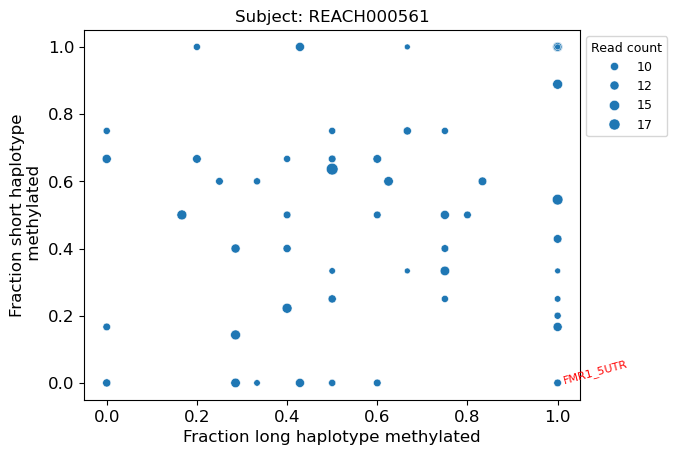

REACH000453
df_plt:


(77, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000453.png


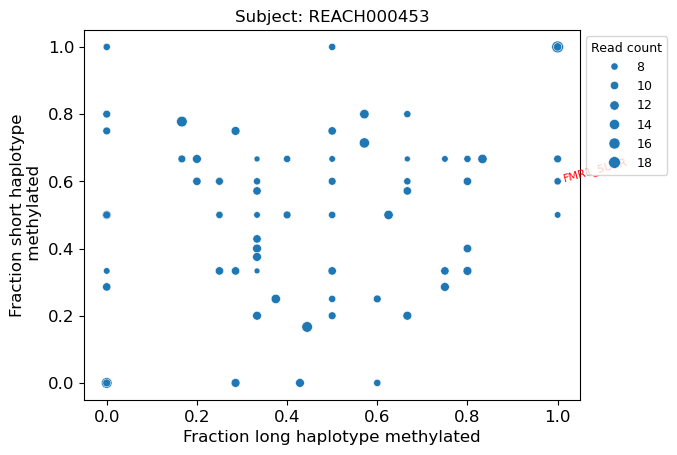

REACH000451
df_plt:


(51, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000451.png


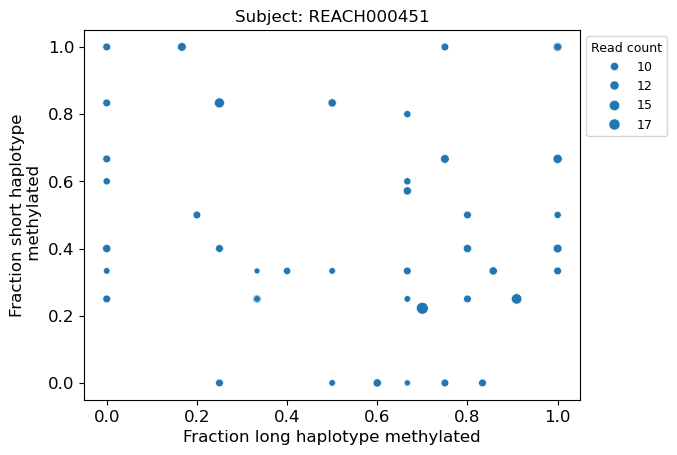

REACH000479
df_plt:


(116, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000479.png


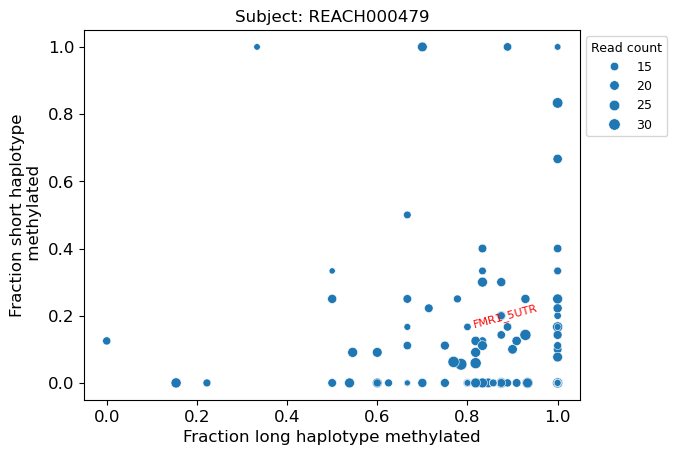

REACH000518
df_plt:


(64, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000518.png


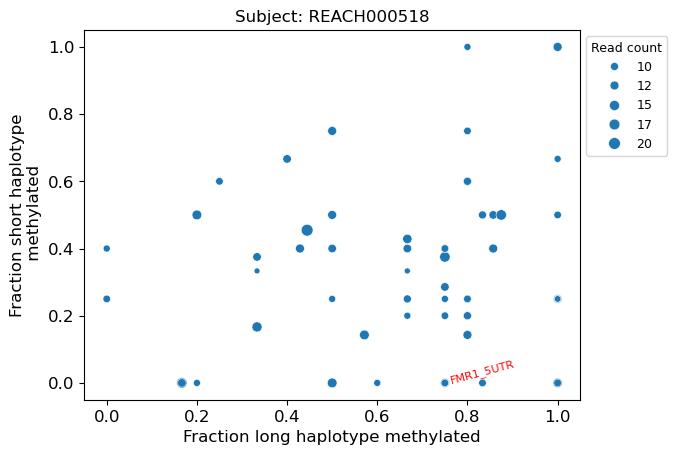

REACH000519
df_plt:


(79, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000519.png


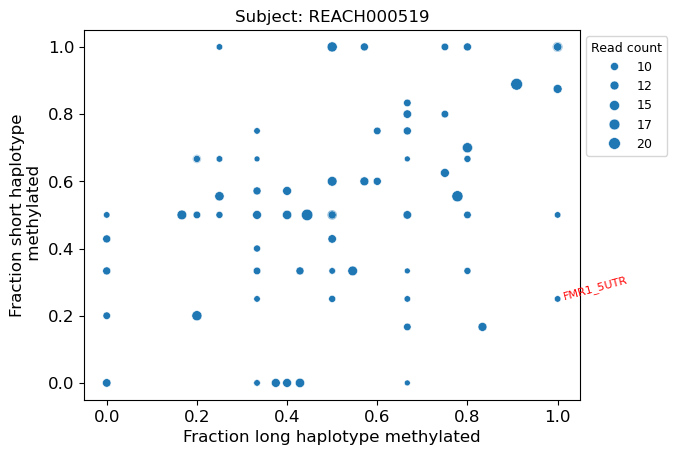

REACH000234
df_plt:


(60, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000234.png


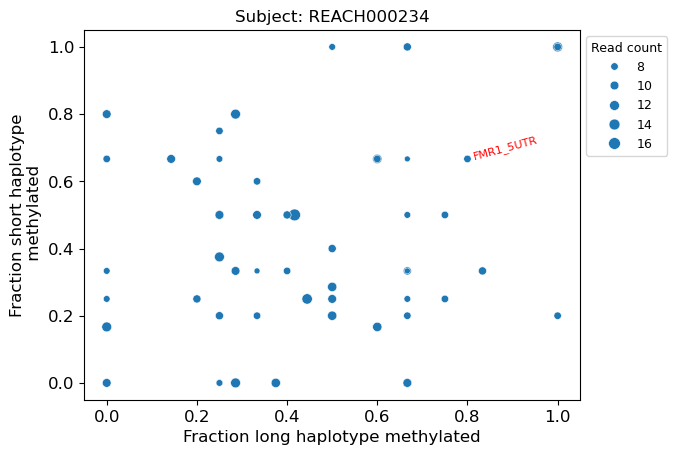

REACH000365
df_plt:


(34, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000365.png


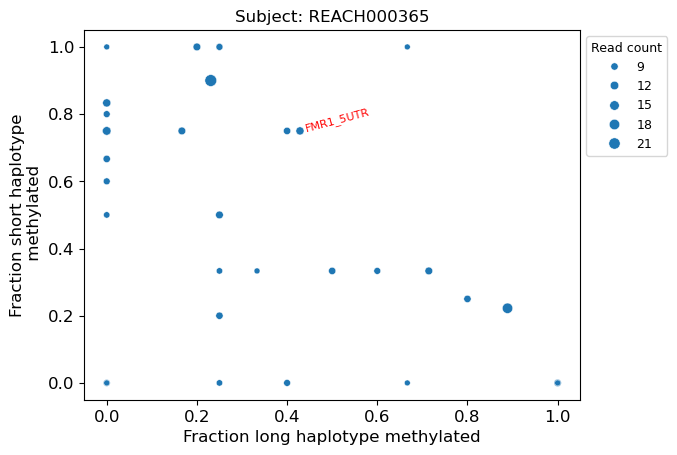

REACH000436_PB
df_plt:


(60, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000436_PB.png


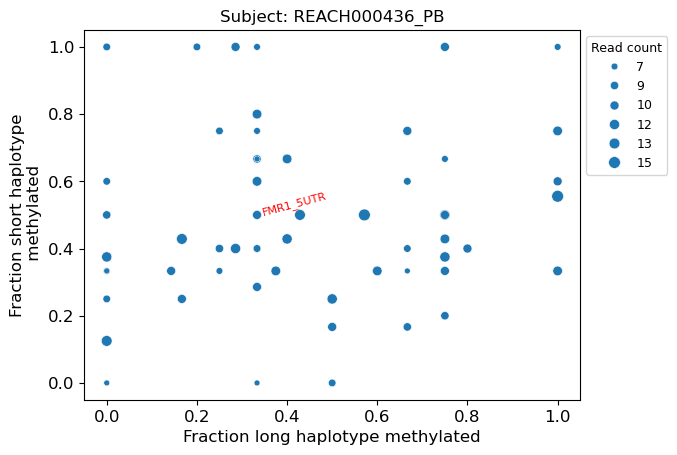

REACH000616
df_plt:


(69, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000616.png


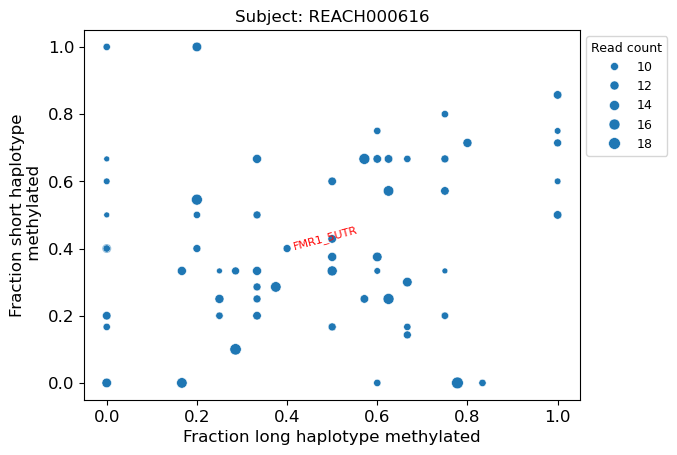

REACH000628
df_plt:


(50, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000628.png


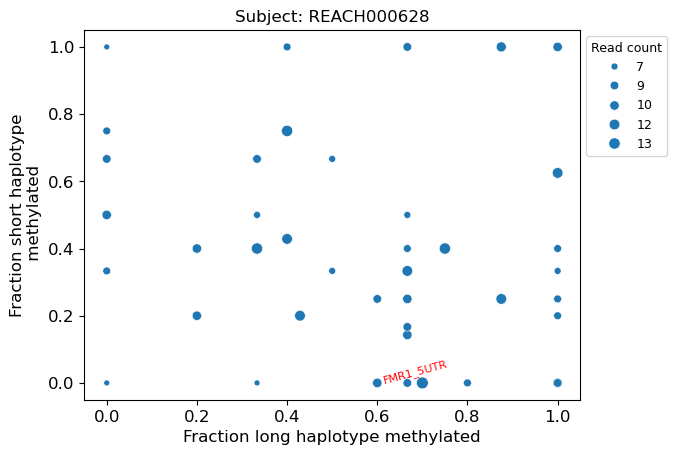

REACH000672
df_plt:


(30, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000672.png


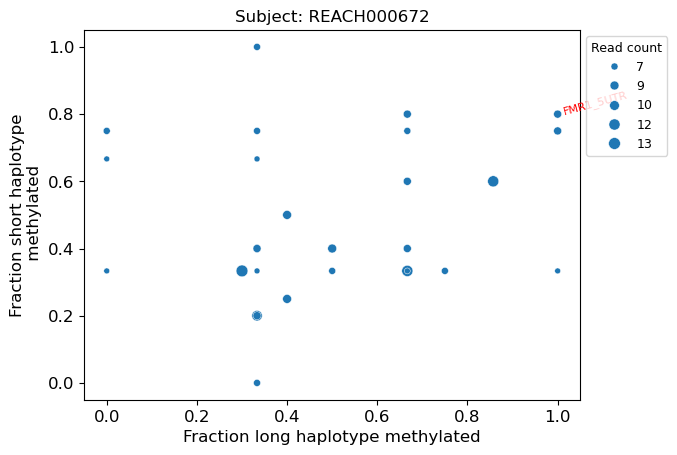

REACH000674
df_plt:


(54, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000674.png


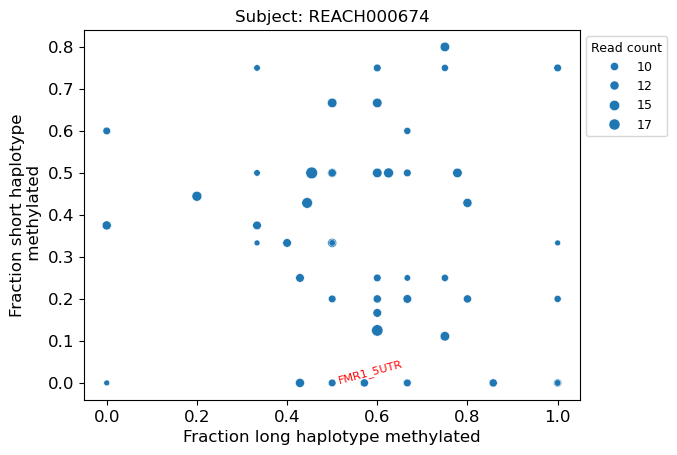

REACH000702
df_plt:


(53, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000702.png


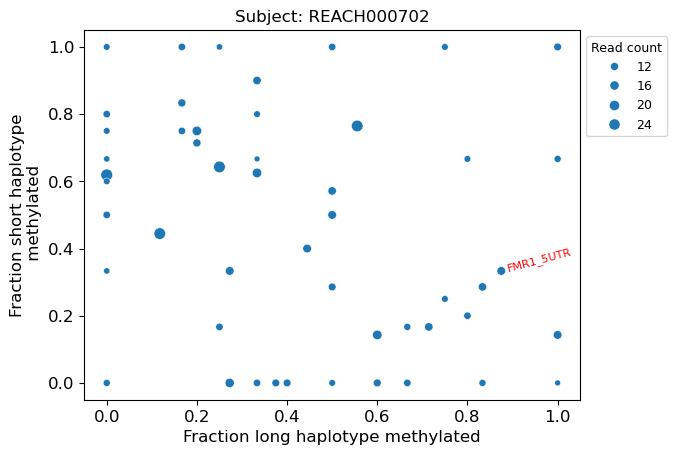

REACH000107
df_plt:


(79, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000107.png


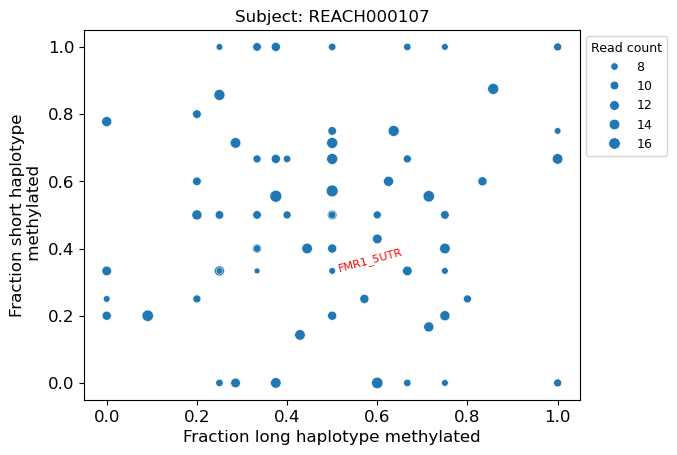

REACH000404
df_plt:


(96, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000404.png


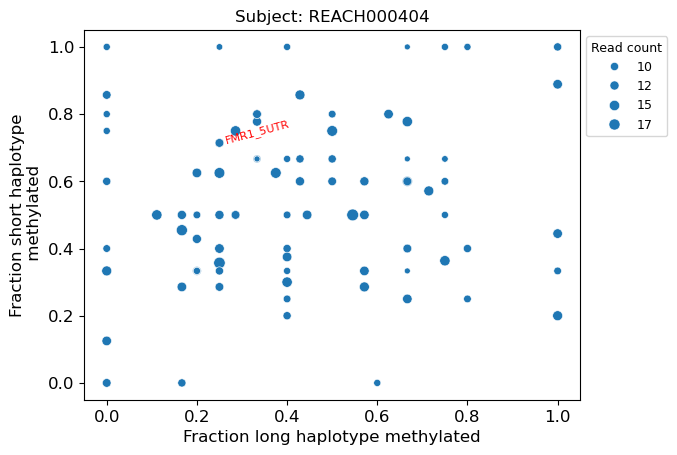

REACH000417
df_plt:


(92, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000417.png


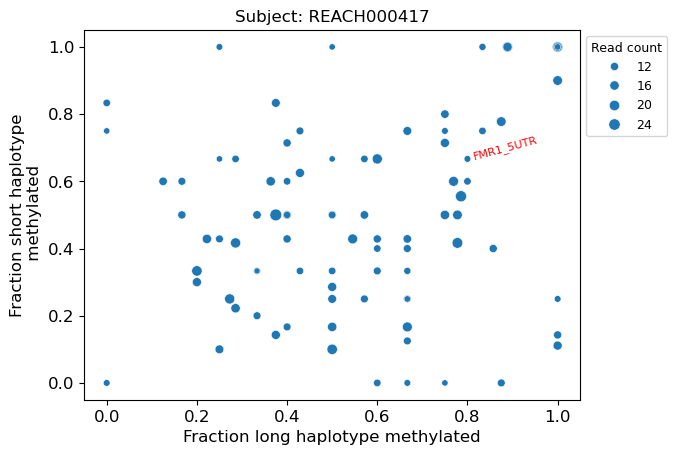

REACH000435
df_plt:


(68, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000435.png


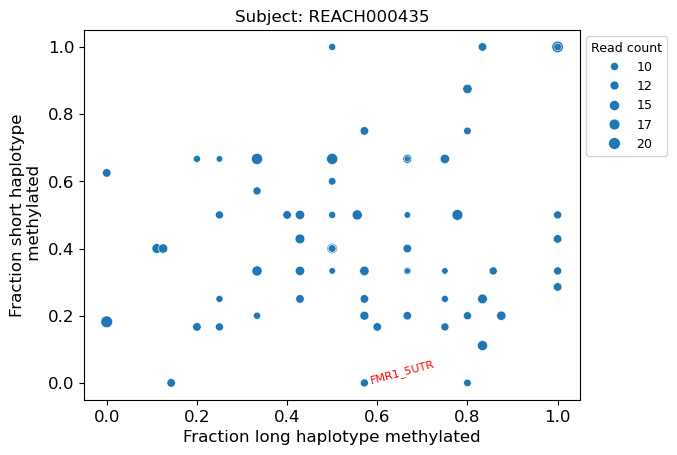

REACH000482
df_plt:


(112, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000482.png


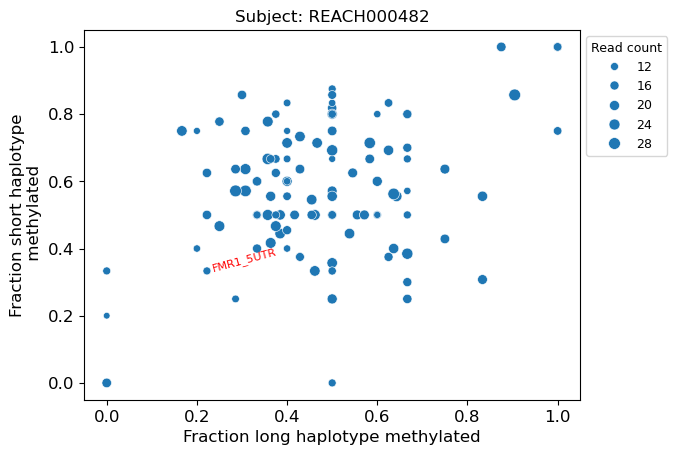

REACH000510
df_plt:


(81, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000510.png


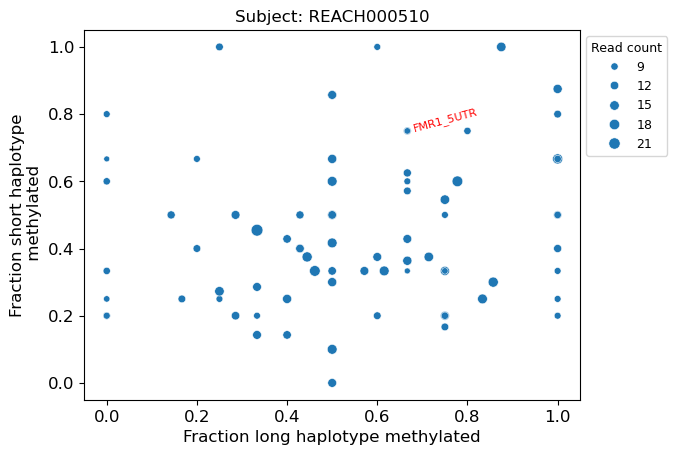

REACH000547
df_plt:


(54, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000547.png


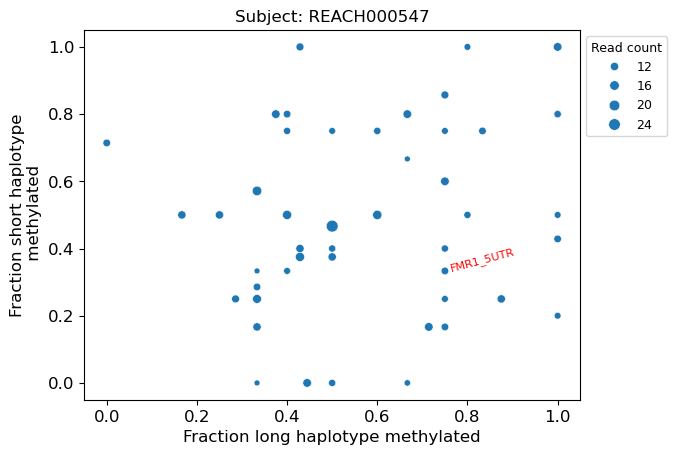

REACH000581
df_plt:


(120, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000581.png


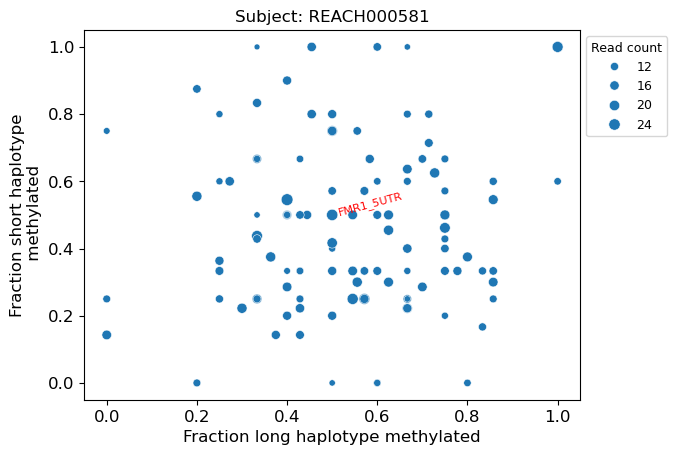

REACH000220
df_plt:


(25, 29)

fragile_x_all//chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000220.png


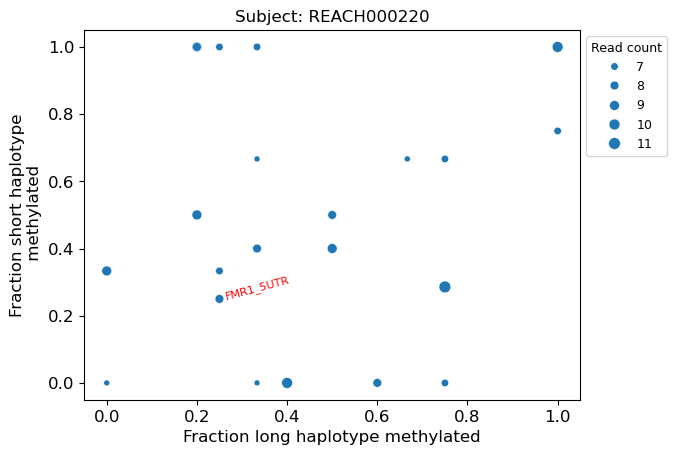

df_plt:


(22, 29)

methyl_h1  \
REACH000453  59|95|99|100|99|100|100|97|90|78|91|100|100|10...   
REACH000479  82|0|99|82|100|0|100|99|100|70|97|100|100|5|0|...   
REACH000518  51|82|100|100|72|0|100|99|100|94|90|99|38|37|0...   
REACH000519  100|62|100|94|100|100|99|79|86|86|85|9|16|3|97...   
REACH000561  3|0|2|0|1|5|12|99|59|66|0|0|0|0|0|0|0|58|10|29...   

                                                     methyl_h2  \
REACH000453  94|100|100|100|100|99|99|99|100|99|95|99|100|9...   
REACH000479  7|3|0|31|3|98|52|5|0|0|2|36|38|95|38|4|3|3|1|6...   
REACH000518  1|4|0|67|1|0|0|0|0|2|4|0|0|2|0|0|0|0|0|0|0|6|0...   
REACH000519  58|50|48|1|25|0|6|5|6|9|9|28|14|0|6|1|16|1|19|...   
REACH000561  95|41|55|100|74|99|100|100|100|91|91|97|82|100...   

                                                     methyl_h0  \
REACH000453                                                  .   
REACH000479  93|98|100|100|98|59|100|100|32|100|100|100|99|...   
REACH000518  10|87|10|3|52|37|46|98|82|9|100|85|9|44|99|36|...   
REACH000519  1|7|0|36|0|0|0|0|0|0|0|0|0|0|1|0|2|0|16|2|0|0|...   
REACH000561                                                  .   

                                           ps_h1  \
REACH000453        10185,10185,10185,10185,10185   
REACH000479        10185,10185,10185,10185,10185   
REACH000518              10185,10185,10185,10185   
REACH000519                   206015,10185,10185   
REACH000561  10215,10215,10215,10215,10215,10291   

                                           ps_h2 read_mean_methyl_lik_h1  \
REACH000453                    10185,10185,10185          77,57,43,42,66   
REACH000479  10185,10185,10185,10185,10185,10185          67,47,69,59,58   
REACH000518        10185,10185,10185,10185,10185             83,82,66,15   
REACH000519              10185,10185,10185,10185                65,62,80   
REACH000561              10215,10215,10215,10215               17,29,7,5   

            read_mean_methyl_lik_h2 read_mean_methyl_lik_h0  \
REACH000453                66,87,91                       .   
REACH000479         20,1,15,11,81,3                 75,4,15   
REACH000518               4,5,5,1,3                    62,6   
REACH000519             13,11,12,77                     1,2   
REACH000561          72,79,60,58,87                       .   

            num_methyl_reads_h1 num_unmethyl_reads_h1 frac_hap_methyl_h1  \
REACH000453                   3                     2                0.6   
REACH000479                   4                     1                0.8   
REACH000518                   3                     1               0.75   
REACH000519                   3                     0                1.0   
REACH000561                   0                     4                0.0   

            num_methyl_reads_h2 num_unmethyl_reads_h2 frac_hap_methyl_h2  \
REACH000453                   3                     0                1.0   
REACH000479                   1                     5           0.166667   
REACH000518                   0                     5                0.0   
REACH000519                   1                     3               0.25   
REACH000561                   5                     0                1.0   

            num_methyl_reads_h0 num_unmethyl_reads_h0 frac_hap_methyl_h0  \
REACH000453                   .                     .                  .   
REACH000479                   1                     2           0.333333   
REACH000518                   1                     1                0.5   
REACH000519                   0                     2                0.0   
REACH000561                   .                     .                  .   

             region_id  num_reads_h1  num_reads_h2  Read count  \
REACH000453  FMR1_5UTR             5             3           8   
REACH000479  FMR1_5UTR             5             6          11   
REACH000518  FMR1_5UTR             4             5           9   
REACH000519  FMR1_5UTR             3             4           7   
REACH000561 

fragile_x_all//chrX_figs/FMR1_frac_hap_methyl_h1_vs_h2_logid_allSamples.png


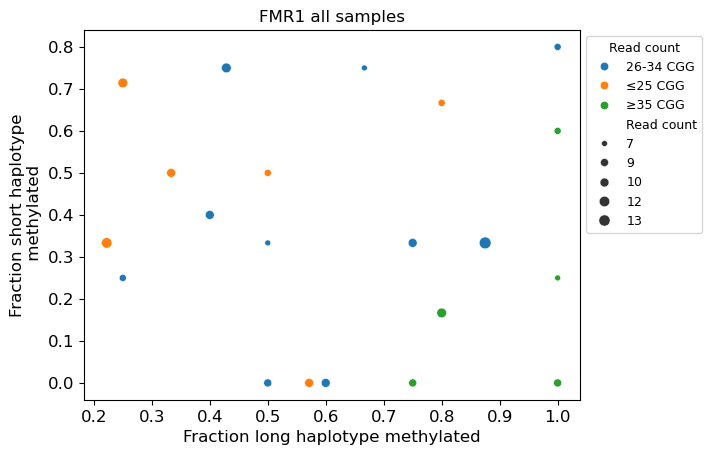

In [19]:
### plot long vs short haplotype for select subjects
samples_plt = ['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519', 
                'REACH000234', 'REACH000365', 'REACH000436_PB', 'REACH000616', 'REACH000628', 'REACH000672', 'REACH000674', 
                'REACH000702', 'REACH000107', 'REACH000404', 'REACH000417', 'REACH000435', 'REACH000482', 'REACH000510', 
                'REACH000547', 'REACH000581', 'REACH000220']
for sample_id in samples_plt:
    print(sample_id)
    df_plt = df_methyl_sample.loc[sample_id,:].copy()
    df_plt = df_plt.loc[(df_plt.num_reads_h1>=3) & (df_plt.num_reads_h2>=3)]
    pd.set_option('display.max_columns', None)
    print('df_plt:')
    display(df_plt.shape)
    #display(df_plt)
    pd.set_option('display.max_columns', 10)
    
    FS = 12
    plt.figure()#figsize=(2.5, 2))
    sb.scatterplot(data=df_plt, x='frac_hap_methyl_large_rep', y='frac_hap_methyl_small_rep', size='Read count')
    #               hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'], size='Read count') #, hue='subject', size='num_reads', sizes=(5,20))
    #plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.3)
    #plt.text(x=.0, y=1, s=f'LLR p-value: {format_sci_notation(result.llr_pvalue)}', fontsize=FS-2)
    #for i, row in df_plt.iterrows():
    #    plt.text(x=row[f'frac_hap_methyl_{hp_long}'], y=row[f'frac_hap_methyl_{hp_short}', s=row.region_id, ha='left', rotation=15, fontsize=4)
    if sample_id != 'REACH000451':
        plt.text(x=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), 'frac_hap_methyl_large_rep'].values[0]+0.01, 
                 y=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), 'frac_hap_methyl_small_rep'].values[0], 
                 s=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), 'region_id'].values[0], ha='left', rotation=15, fontsize=8, color='r')
    plt.legend(title = 'Read count', loc='upper left', bbox_to_anchor=(1, 1), 
               handles=plt.gca().legend_.legend_handles[1:], fontsize=FS-3, title_fontsize=FS-3) #title = 'binomial phred'
    plt.xlabel('Fraction long haplotype methylated', fontsize=FS)
    plt.ylabel('Fraction short haplotype\n methylated', fontsize=FS)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    plt.title(f'Subject: {sample_id}')
    #plt.xlim((-0.1, 1.1))
    #plt.ylim((-0.1, 1.1))
    fig_name = f'{dir_fig}/chrX_figs/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_{sample_id}.png'
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
    plt.show()
    plt.close()

### just for confirming plot the FMR1 repeat only
def get_rep_group2(row):
    out = ('≥35 CGG' if (row.fmr1_mean_repeat_length_h1 >= 35 or row.fmr1_mean_repeat_length_h2 >= 35) else 
           ('≤25 CGG' if (row.fmr1_mean_repeat_length_h1 <= 25 or row.fmr1_mean_repeat_length_h2 <= 25) else '26-34 CGG'))
    return out

df_plt = df_methyl_sample.loc[df_methyl_sample.region_id=='FMR1_5UTR'].copy()
df_plt = df_plt.loc[(df_plt.num_reads_h1>=3) & (df_plt.num_reads_h2>=3)]
df_plt['repeat_group'] = df_plt.apply(lambda row: get_rep_group2(row), axis=1)
pd.set_option('display.max_columns', None)
print('df_plt:')
display(df_plt.shape)
display(df_plt.loc[df_plt.repeat_group=='≥35 CGG'])
pd.set_option('display.max_columns', 10)

FS = 12
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x='frac_hap_methyl_large_rep', y='frac_hap_methyl_small_rep', size='Read count', hue='repeat_group')
plt.legend(title = 'Read count', loc='upper left', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[1:], fontsize=FS-3, title_fontsize=FS-3) #title = 'binomial phred'
plt.xlabel('Fraction long haplotype methylated', fontsize=FS)
plt.ylabel('Fraction short haplotype\n methylated', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title(f'FMR1 all samples')
#plt.xlim((-0.1, 1.1))
#plt.ylim((-0.1, 1.1))
fig_name = f'{dir_fig}/chrX_figs/FMR1_frac_hap_methyl_h1_vs_h2_logid_allSamples.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

In [31]:
pd.set_option('display.max_columns', None)
display(df_methyl_sample)
pd.set_option('display.max_columns', 10)

methyl_h1  \
REACH000220                                                     .   
REACH000234     77|81|91|72|65|59|19|2|0|1|2|0|2|21|28|53|51|7...   
REACH000365                                                     .   
REACH000436_PB  44|93|96|98|97|100|99|98|73|9|2|3|0|11|66|68|7...   
REACH000451                                                     .   
...                                                           ...   
REACH000518     0|0|1|0|0|0|13|0|7|11|0|0|0|6|0|0|0|0|0|0|0|4|...   
REACH000519     7|0|3|0|0|0|6|41|0|0|0|3|0|0|0|0|1|0|0|0|0|2|0...   
REACH000547     33|0|5|23|59|96|3|98|0|2|30|14|18|1|16|38|11|5...   
REACH000561                                                     .   
REACH000581                                                     .   

                                                        methyl_h2  \
REACH000220                                                     .   
REACH000234     0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
REACH000365                                                     .   
REACH000436_PB  98|99|98|93|96|84|38|4|0|0|0|1|4|9|14|81|95|85...   
REACH000451     0|0|0|0|0|9|2|0|0|0|0|0|0|0|0|0|1|1|1|0|0|0|0|...   
...                                                           ...   
REACH000518     1|10|4|75|1|0|1|0|0|0|1|1|60|0|0|8|2|0|0|0|0|1...   
REACH000519     1|68|41|2|1|0|79|82|0|64|4|2|23|0|0|5|0|3|2|0|...   
REACH000547     100|55|92|100|99|45|86|99|99|91|99|100|100|100...   
REACH000561                                                     .   
REACH000581                                                     .   

                                                        methyl_h0  \
REACH000220     10|12|16|13|4|5|2|4|1|0|0|0|0|0|0|0|1|0|0|0|0|...   
REACH000234     78|99|99|100|99|97|98|95|26|5|1|10|12|5|29|26|...   
REACH000365     0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
REACH000436_PB                                                  .   
REACH000451     82|95|98|97|82|82|62|72|33|14|32|56|29|5|3|4|5...   
...                                                           ...   
REACH000518     0|100|14|98|98|98|0|100|96|0|100|100|0|5|0|1|1...   
REACH000519     100|53|0|0|0|0|3|14|0|0|2|8|0|40|0|2|1|0|29|0|...   
REACH000547                                        0|0|1|29|8|0|0   
REACH000561     7|65|0|0|0|0|7|0|0|0|0|0|0|0|9|0|0|0|0|1|2|57|...   
REACH000581     5|27|100|100|98|100|100|100|84|0|0|0|99|69|0|0...   

                                                       ps_h1  \
REACH000220                                                .   
REACH000234                                      10185,10185   
REACH000365                                                .   
REACH000436_PB  10532334,10532334,10532334,10532334,10532334   
REACH000451                                                .   
...                                                      ...   
REACH000518                          10185,10185,10185,10185   
REACH000519                                            10185   
REACH000547        12790,12790,12790,12790,12790,12790,12790   
REACH000561                                                .   
REACH000581                                                .   

                                     ps_h2 read_mean_methyl_lik_h1  \
REACH000220                              .                       .   
REACH000234              10185,10185,10185                    32,2   
REACH000365                              .                       .   
REACH000436_PB  10532334,10532334,10532334            39,9,55,2,67   
REACH000451                          10185                       .   
...                                    ...                     ...   
REACH000518                    10185,10185               3,4,61,13   
REACH000519                          10185                       2   
REACH000547              12790,12790,12790      16,36,64,47,2,9,75   
REACH000561                              .                       .   
REACH000581                   

df_skew:


(23, 5)

repeat_group  xci_skewness  fmr1_skewness  XCI read count  \
REACH000479         ≥35 CGG      0.688142       0.633333       15.434783   
REACH000518         ≥35 CGG      0.327183       0.750000       10.333333   
REACH000674       26-34 CGG      0.289933       0.500000       10.132075   
REACH000628       26-34 CGG      0.179908       0.600000        9.081633   
REACH000435         ≤25 CGG      0.148601       0.571429       11.089552   
REACH000510       26-34 CGG      0.112451      -0.083333       11.600000   
REACH000451         ≥35 CGG      0.103711       0.800000        9.196078   
REACH000547       26-34 CGG      0.085969       0.416667       10.547170   
REACH000561         ≥35 CGG      0.082252       1.000000       10.111111   
REACH000581         ≤25 CGG      0.069057       0.000000       13.756303   
REACH000417         ≤25 CGG      0.058934       0.133333       12.681319   
REACH000616       26-34 CGG      0.044243       0.000000       10.647059   
REACH000234       26-34 CGG      0.036871       0.133333        9.000000   
REACH000107       26-34 CGG     -0.014776       0.166667       10.692308   
REACH000519         ≥35 CGG     -0.017285       0.750000       10.179487   
REACH000672       26-34 CGG     -0.035961       0.200000        7.862069   
REACH000436_PB      ≤25 CGG     -0.039481      -0.166667        9.491525   
REACH000702       26-34 CGG     -0.043010       0.541667       11.653846   
REACH000453         ≥35 CGG     -0.049984       0.400000        9.473684   
REACH000220       26-34 CGG     -0.065377       0.000000        7.666667   
REACH000482         ≤25 CGG     -0.095847      -0.111111       16.963964   
REACH000404         ≤25 CGG     -0.124537      -0.464286       10.831579   
REACH000365       26-34 CGG     -0.178938      -0.321429        9.060606   

                FMR1 read count  
REACH000479                  11  
REACH000518                   9  
REACH000674                   9  
REACH000628                  10  
REACH000435                  10  
REACH000510                   7  
REACH000451                   7  
REACH000547                  10  
REACH000561                   9  
REACH000581                   8  
REACH000417                   8  
REACH000616                  10  
REACH000234                   8  
REACH000107                   7  
REACH000519                   7  
REACH000672                   8  
REACH000436_PB               10  
REACH000702                  14  
REACH000453                   8  
REACH000220                   8  
REACH000482                  12  
REACH000404                  11  
REACH000365                  11

fragile_x_all//skewness_FMR1_vs_XCI_23Samples.png


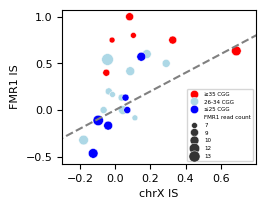

In [51]:
### compute skewness for subjects for FMR1 and XCI
samples_plt = ['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519', 
                'REACH000234', 'REACH000365', 'REACH000436_PB', 'REACH000616', 'REACH000628', 'REACH000672', 'REACH000674', 
                'REACH000702', 'REACH000107', 'REACH000404', 'REACH000417', 'REACH000435', 'REACH000482', 'REACH000510', 
                'REACH000547', 'REACH000581', 'REACH000220']

df_skew = pd.DataFrame()
df_skew['repeat_group'] = pd.Series(dtype=str)
for sample_id in samples_plt:
    #print(sample_id)
    df_plt = df_methyl_sample.loc[sample_id,:].copy()
    df_plt_xci = df_plt.loc[(df_plt.num_reads_h1>=3) & (df_plt.num_reads_h2>=3) & (df_plt.region_id!='FMR1_5UTR')].copy()
    df_plt_fmr1 = df_plt.loc[df_plt.region_id=='FMR1_5UTR'].copy()
    df_plt_xci['skewness'] = df_plt_xci.frac_hap_methyl_large_rep - df_plt_xci.frac_hap_methyl_small_rep
    df_plt_fmr1['skewness'] = df_plt_fmr1.frac_hap_methyl_large_rep - df_plt_fmr1.frac_hap_methyl_small_rep
    repeat_group = df_plt_fmr1.repeat_group.values[0]
    pd.set_option('display.max_columns', None)
    #print('df_plt_xci:')
    #display(df_plt_xci.shape)
    #display(df_plt_xci)
    #print('df_plt_fmr1:')
    #display(df_plt_fmr1.shape)
    #display(df_plt_fmr1)
    pd.set_option('display.max_columns', 10)

    df_skew.loc[sample_id, 'xci_skewness'] = df_plt_xci['skewness'].mean()
    df_skew.loc[sample_id, 'fmr1_skewness'] = df_plt_fmr1['skewness'].mean()
    df_skew.loc[sample_id, 'repeat_group'] = repeat_group
    df_skew.loc[sample_id, 'XCI read count'] = df_plt_xci['Read count'].mean()
    df_skew.loc[sample_id, 'FMR1 read count'] = df_plt_fmr1['Read count'].mean().astype(int)

df_skew['FMR1 read count'] = df_skew['FMR1 read count'].astype(int)

pd.set_option('display.max_columns', None)
print('df_skew:')
display(df_skew.shape)
display(df_skew.sort_values('xci_skewness', ascending=False))
pd.set_option('display.max_columns', 10)

FS = 8
plt.figure(figsize=(2.5, 2))
sb.scatterplot(data=df_skew, x='xci_skewness', y='fmr1_skewness', hue='repeat_group', 
               hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'], size='FMR1 read count')
plt.plot([-.5,1],[-.5,1], '--', color='gray')
plt.legend(title = '', loc='lower right', bbox_to_anchor=(1, 0), 
           handles=plt.gca().legend_.legend_handles[1:], fontsize=FS-4, title_fontsize=FS-4)
plt.xlabel('chrX IS', fontsize=FS)
plt.ylabel('FMR1 IS', fontsize=FS)
plt.xticks([-.2,0,0.2,0.4,0.6],fontsize=FS)
plt.yticks(fontsize=FS)
#plt.title(f'FMR1 all samples')
plt.xlim((-0.3, .8))
#plt.ylim((-0.1, 1.1))
fig_name = f'{dir_fig}/skewness_FMR1_vs_XCI_23Samples.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

df_skew:


(23, 2)

skewness   lg35
REACH000479     0.688142   TRUE
REACH000518     0.327183   TRUE
REACH000674     0.289933  FALSE
REACH000628     0.179908  FALSE
REACH000435     0.148601  FALSE
REACH000510     0.112451  FALSE
REACH000451     0.103711   TRUE
REACH000547     0.085969  FALSE
REACH000561     0.082252   TRUE
REACH000581     0.069057  FALSE
REACH000417     0.058934  FALSE
REACH000616     0.044243  FALSE
REACH000234     0.036871  FALSE
REACH000107    -0.014776  FALSE
REACH000519    -0.017285   TRUE
REACH000672    -0.035961  FALSE
REACH000436_PB -0.039481  FALSE
REACH000702    -0.043010  FALSE
REACH000453    -0.049984   TRUE
REACH000220    -0.065377  FALSE
REACH000482    -0.095847  FALSE
REACH000404    -0.124537  FALSE
REACH000365    -0.178938  FALSE

/scratch/smmortazavi/job_39301515/ipykernel_155777/723451640.py:32: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sb.stripplot(data=df_skew, y='skewness', hue='lg35', color='black', dodge=True, jitter=True)


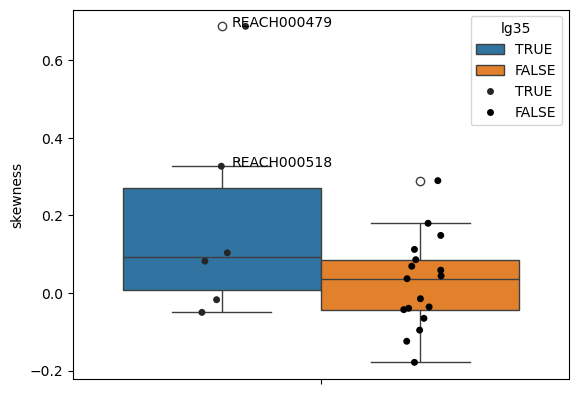

In [69]:
### select sample
samples_plt = ['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519', 
                'REACH000234', 'REACH000365', 'REACH000436_PB', 'REACH000616', 'REACH000628', 'REACH000672', 'REACH000674', 
                'REACH000702', 'REACH000107', 'REACH000404', 'REACH000417', 'REACH000435', 'REACH000482', 'REACH000510', 
                'REACH000547', 'REACH000581', 'REACH000220']
samples_lg35_plt = ['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519']

df_skew = pd.DataFrame()
for sample_id in samples_plt:
    #print(sample_id)
    df_plt = df_methyl_sample.loc[sample_id,:].copy()
    df_plt = df_plt.loc[(df_plt.num_reads_h1>=3) & (df_plt.num_reads_h2>=3) & (df_plt.region_id!='FMR1_5UTR')]
    df_plt['skewness'] = df_plt.frac_hap_methyl_large_rep - df_plt.frac_hap_methyl_small_rep
    pd.set_option('display.max_columns', None)
    #print('df_plt:')
    #display(df_plt.shape)
    #display(df_plt)
    pd.set_option('display.max_columns', 10)

    df_skew.loc[sample_id, 'skewness'] = df_plt['skewness'].mean()

df_skew['lg35'] = df_skew.index.map(lambda x: 'TRUE' if x in samples_lg35_plt else 'FALSE')
pd.set_option('display.max_columns', None)
print('df_skew:')
display(df_skew.shape)
display(df_skew.sort_values('skewness', ascending=False))
pd.set_option('display.max_columns', 10)

FS = 12
plt.figure()#figsize=(2.5, 2))
sb.boxplot(data=df_skew, y='skewness', hue='lg35')
sb.stripplot(data=df_skew, y='skewness', hue='lg35', color='black', dodge=True, jitter=True)
for sample_id in samples_plt:
    if df_skew.loc[sample_id, 'skewness'] > 0.3:
        plt.text(x=-.18, y=df_skew.loc[sample_id, 'skewness'], s=sample_id)
#plt.plot([0], [df_plt['skewness'].mean()], 'dk')
#plt.xlabel('Fraction long haplotype methylated', fontsize=FS)
#plt.ylabel('Fraction short haplotype\n methylated', fontsize=FS)
#plt.xticks(fontsize=FS)
#plt.yticks(fontsize=FS)
#plt.title(f'Subject: {sample_id}')
#plt.xlim((-0.1, 1.1))
#plt.ylim((-0.1, 1.1))
#fig_name = f'{dir_fig}/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_{sample_id}.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

In [54]:
pd.set_option('display.max_columns', None)
display(df_methyl_sample)
pd.set_option('display.max_columns', 10)

methyl_h1  \
REACH000220                                                     .   
REACH000234     77|81|91|72|65|59|19|2|0|1|2|0|2|21|28|53|51|7...   
REACH000365                                                     .   
REACH000436_PB  44|93|96|98|97|100|99|98|73|9|2|3|0|11|66|68|7...   
REACH000451                                                     .   
...                                                           ...   
REACH000518     0|0|1|0|0|0|13|0|7|11|0|0|0|6|0|0|0|0|0|0|0|4|...   
REACH000519     7|0|3|0|0|0|6|41|0|0|0|3|0|0|0|0|1|0|0|0|0|2|0...   
REACH000547     33|0|5|23|59|96|3|98|0|2|30|14|18|1|16|38|11|5...   
REACH000561                                                     .   
REACH000581                                                     .   

                                                        methyl_h2  \
REACH000220                                                     .   
REACH000234     0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
REACH000365                                                     .   
REACH000436_PB  98|99|98|93|96|84|38|4|0|0|0|1|4|9|14|81|95|85...   
REACH000451     0|0|0|0|0|9|2|0|0|0|0|0|0|0|0|0|1|1|1|0|0|0|0|...   
...                                                           ...   
REACH000518     1|10|4|75|1|0|1|0|0|0|1|1|60|0|0|8|2|0|0|0|0|1...   
REACH000519     1|68|41|2|1|0|79|82|0|64|4|2|23|0|0|5|0|3|2|0|...   
REACH000547     100|55|92|100|99|45|86|99|99|91|99|100|100|100...   
REACH000561                                                     .   
REACH000581                                                     .   

                                                        methyl_h0  \
REACH000220     10|12|16|13|4|5|2|4|1|0|0|0|0|0|0|0|1|0|0|0|0|...   
REACH000234     78|99|99|100|99|97|98|95|26|5|1|10|12|5|29|26|...   
REACH000365     0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
REACH000436_PB                                                  .   
REACH000451     82|95|98|97|82|82|62|72|33|14|32|56|29|5|3|4|5...   
...                                                           ...   
REACH000518     0|100|14|98|98|98|0|100|96|0|100|100|0|5|0|1|1...   
REACH000519     100|53|0|0|0|0|3|14|0|0|2|8|0|40|0|2|1|0|29|0|...   
REACH000547                                        0|0|1|29|8|0|0   
REACH000561     7|65|0|0|0|0|7|0|0|0|0|0|0|0|9|0|0|0|0|1|2|57|...   
REACH000581     5|27|100|100|98|100|100|100|84|0|0|0|99|69|0|0...   

                                                       ps_h1  \
REACH000220                                                .   
REACH000234                                      10185,10185   
REACH000365                                                .   
REACH000436_PB  10532334,10532334,10532334,10532334,10532334   
REACH000451                                                .   
...                                                      ...   
REACH000518                          10185,10185,10185,10185   
REACH000519                                            10185   
REACH000547        12790,12790,12790,12790,12790,12790,12790   
REACH000561                                                .   
REACH000581                                                .   

                                     ps_h2 read_mean_methyl_lik_h1  \
REACH000220                              .                       .   
REACH000234              10185,10185,10185                    32,2   
REACH000365                              .                       .   
REACH000436_PB  10532334,10532334,10532334            39,9,55,2,67   
REACH000451                          10185                       .   
...                                    ...                     ...   
REACH000518                    10185,10185               3,4,61,13   
REACH000519                          10185                       2   
REACH000547              12790,12790,12790      16,36,64,47,2,9,75   
REACH000561                              .                       .   
REACH000581                   

df_hps
(46, 8)


subject_id haplotype  num_methyl  num_unmethyl  num_tot_reads  \
6      REACH000479        h1         777           158            935   
8      REACH000518        h1         215           110            325   
25     REACH000674        h2         164           109            273   
37     REACH000482        h2         535           399            934   
34     REACH000435        h1         208           160            368   
1      REACH000561        h2         145           115            260   
41     REACH000547        h2         153           123            276   
20     REACH000628        h1         126            93            219   
38     REACH000510        h1         257           200            457   
5      REACH000451        h2         143           105            248   
33     REACH000417        h2         332           257            589   
31     REACH000404        h2         276           248            524   
42     REACH000581        h1         454           386            840   
2      REACH000453        h1         187           177            364   
11     REACH000519        h2         219           187            406   
45     REACH000220        h2          44            44             88   
29     REACH000107        h2         200           197            397   
10     REACH000519        h1         203           185            388   
23     REACH000672        h2          57            59            116   
15     REACH000365        h2          80            66            146   
28     REACH000107        h1         215           222            437   
0      REACH000561        h1         143           143            286   
36     REACH000482        h1         461           488            949   
16  REACH000436_PB        h1         139           158            297   
32     REACH000417        h1         270           295            565   
40     REACH000547        h1         138           145            283   
3      REACH000453        h2         171           185            356   
43     REACH000581        h2         375           422            797   
26     REACH000702        h1         157           162            319   
22     REACH000672        h1          53            59            112   
17  REACH000436_PB        h2         119           144            263   
4      REACH000451        h1         101           120            221   
44     REACH000220        h1          42            54             96   
19     REACH000616        h2         149           199            348   
39     REACH000510        h2         205           266            471   
35     REACH000435        h2         164           211            375   
27     REACH000702        h2         117           170            287   
13     REACH000234        h2         118           166            284   
30     REACH000404        h1         212           293            505   
18     REACH000616        h1         147           229            376   
12     REACH000234        h1          95           152            247   
21     REACH000628        h2          86           140            226   
9      REACH000518        h2         115           211            326   
24     REACH000674        h1          86           178            264   
14     REACH000365        h1          53           100            153   
7      REACH000479        h2         118           722            840   

    frac_hap_methyl  fmr1_mean_repeat_length repeat_group  
6          0.828414                36.000000      ≥35 CGG  
8          0.678049                35.000000      ≥35 CGG  
25         0.605110                30.333333    26-34 CGG  
37         0.580955                19.000000      ≤25 CGG  
34         0.580088                28.714286      ≤25 CGG  
1          0.571407                49.111111      ≥35 CGG  
41         0.566921                33.750000    26-34 CGG  
20         0.558406                30.250000    26-34 CGG  
38         0.546939                3

stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     3.237
Date:                Mon, 12 May 2025   Prob (F-statistic):             0.0789
Time:                        17:54:08   Log-Likelihood:                 41.272
No. Observations:                  46   AIC:                            -78.54
Df Residuals:                      44   BIC:                            -74.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const        

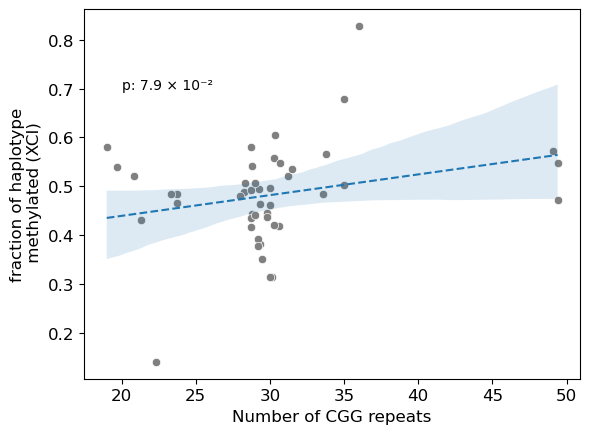

In [75]:
### compute skewness for subjects for FMR1 and XCI
samples_plt = ['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519', 
                'REACH000234', 'REACH000365', 'REACH000436_PB', 'REACH000616', 'REACH000628', 'REACH000672', 'REACH000674', 
                'REACH000702', 'REACH000107', 'REACH000404', 'REACH000417', 'REACH000435', 'REACH000482', 'REACH000510', 
                'REACH000547', 'REACH000581', 'REACH000220']

df_hps = pd.DataFrame()
for sample_id in samples_plt:
    #print(sample_id)
    df_plt = df_methyl_sample.loc[sample_id,:].copy()
    df_plt_xci = df_plt.loc[(df_plt.num_reads_h1>=3) & (df_plt.num_reads_h2>=3) & (df_plt.region_id!='FMR1_5UTR')].copy()
    df_plt_fmr1 = df_plt.loc[df_plt.region_id=='FMR1_5UTR'].copy()
    for hp in ['h1', 'h2']:
        num_methyl = df_plt_xci[f'num_methyl_reads_{hp}'].sum()
        num_unmethyl = df_plt_xci[f'num_unmethyl_reads_{hp}'].sum()
        fmr1_mean_repeat_length = df_plt_xci[f'fmr1_mean_repeat_length_{hp}'].values[0]
        frac_hap_methyl = df_plt_xci[f'frac_hap_methyl_{hp}'].mean()
        repeat_group = df_plt_xci[f'repeat_group'].values[0]
        df_tmp = pd.DataFrame({'subject_id': [sample_id], 'haplotype': [hp], 'num_methyl': [num_methyl], 'num_unmethyl': [num_unmethyl], 
                               'num_tot_reads': [num_methyl + num_unmethyl], f'frac_hap_methyl': [frac_hap_methyl],
                               'fmr1_mean_repeat_length': fmr1_mean_repeat_length, 'repeat_group': repeat_group})
        df_hps = pd.concat([df_hps, df_tmp], ignore_index=True)
        
pd.set_option('display.max_columns', None)
print('df_hps')
print(df_hps.shape)
display(df_hps.sort_values('frac_hap_methyl', ascending=False))
pd.set_option('display.max_columns', 10)


X = pd.DataFrame(df_hps.fmr1_mean_repeat_length)
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_hps.frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
r2 = model_sm.rsquared
pval_rep_length = model_sm.pvalues['fmr1_mean_repeat_length']
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')


FS = 12
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_hps, x='fmr1_mean_repeat_length', y='frac_hap_methyl', color='gray')#, 
#               size='num_reads', sizes=(5,20), legend='brief') # sizes gets a min max tuple interpreted by "size" hue='subject',
sb.regplot(data=df_hps, x='fmr1_mean_repeat_length', y='frac_hap_methyl', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage

#**plt.legend(title='Read count', loc='lower right', bbox_to_anchor=(1, 0), fontsize=FS-3, title_fontsize=FS-3) #handles=plt.gca().legend_.legend_handles[num_subjects+2:], 

x_t = 20
y_t = .7
p = model_sm.pvalues['fmr1_mean_repeat_length']
plt.text(x_t, y_t, f'p: {format_sci_notation(pval_rep_length)}', fontsize=FS-2, ha='left')
#plt.text(x_t, y_t-.1, f'r²: {partial_r2_rep_length:.2f}', fontsize=FS-2, ha='left')

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (XCI)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
#fig_name = f'{dir_fig}/haplotype_readFrac_methylation_vs_repeats_FMR1_fromTable.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

In [74]:
pd.set_option('display.max_columns', None)
display(df_methyl_sample.loc[(df_methyl_sample.num_reads_h1>=3)&(df_methyl_sample.num_reads_h2>=3)])
pd.set_option('display.max_columns', 10)

df_methyl_plt = df_methyl.loc[(df_methyl.sex=='Female')].copy()
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_methyl_reads_h1!='.') | (df_methyl_plt.num_methyl_reads_h2!='.')]
df_methyl_plt['num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) if row.num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_reads_h1>=3) | (df_methyl_plt.num_reads_h2>=3)]

df_plt = pd.DataFrame()
for idx, row in df_methyl_plt.iterrows():
    sample = idx
    for hp in ['h1', 'h2']:
        if row[f'num_reads_{hp}'] >= 3:
            mean_rep = row[f'mean_repeat_length_{hp}']
            frac_hap = row[f'frac_hap_methyl_{hp}']
            xci_frac_hap = row[f'xci_frac_hap_methyl_{hp}']
            num_reads = row[f'num_reads_{hp}']
            rep_group = row['repeat_group']
            df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
                                   f'xci_frac_hap_methyl': [xci_frac_hap], f'num_reads': [num_reads], f'repeat_group': [rep_group]})
            df_plt = pd.concat([df_plt, df_tmp], ignore_index=True)
### get rid of one sample (REACH000563) if you need XCI values cause it's '.', for FMR1 plot it's ok to have that.
#df_plt = df_plt.loc[df_plt.xci_frac_hap_methyl != '.']
#cols = ['mean_repeat_length', 'frac_hap_methyl', 'xci_frac_hap_methyl', 'num_reads']
cols = ['mean_repeat_length', 'frac_hap_methyl', 'num_reads']
for col in cols:
    df_plt[col] = df_plt[col].astype(float)

def get_rep_group2(row):
    if row.repeat_group != '.':
        out = row.repeat_group
    else:
        out = ('≥35 CGG' if (row.mean_repeat_length >= 35) else 
               ('≤25 CGG' if (row.mean_repeat_length <= 25) else '26-34 CGG'))
    return out
df_plt['repeat_group'] = df_plt.apply(lambda row: get_rep_group2(row), axis=1)

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
print('df_plt:')
display(df_plt)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

x = np.array(df_plt.mean_repeat_length.tolist()).reshape(-1, 1) # Reshape for sklearn
y = np.array(df_plt.frac_hap_methyl.tolist())
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
#plt.plot(x, y_pred, '-ok', label='Regression Line')
# Get weights (coefficients) and intercept
print('Scikit learn LR model:')
print("Coefficients:", model.coef_)  # Slope
print("Intercept:", model.intercept_)  # Intercept

X = pd.DataFrame(df_plt.mean_repeat_length)
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_plt.frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

FS = 8
plt.figure(figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', color='gray', 
               size='num_reads', sizes=(5,20), legend='brief') # sizes gets a min max tuple interpreted by "size" hue='subject',
#hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'], 
sb.regplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Read count', loc='lower right', bbox_to_anchor=(1, 0), fontsize=FS-3, title_fontsize=FS-3) #handles=plt.gca().legend_.legend_handles[num_subjects+2:], 
#, handles=plt.gca().legend_.legend_handles[1:4]+plt.gca().legend_.legend_handles[5:12:2]

x_t = 18
y_t = 1
p = model_sm.pvalues['mean_repeat_length']
plt.text(x_t, y_t, f'p: {format_sci_notation(pval_rep_length)}', fontsize=FS-2, ha='left')
plt.text(x_t, y_t-.1, f'r²: {partial_r2_rep_length:.2f}', fontsize=FS-2, ha='left')

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (FMR1)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/haplotype_readFrac_methylation_vs_repeats_FMR1_fromTable.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

methyl_h1  \
REACH000436_PB  44|93|96|98|97|100|99|98|73|9|2|3|0|11|66|68|7...   
REACH000107     100|100|100|100|100|100|100|100|100|23|1|0|100...   
REACH000435     45|28|69|3|97|98|100|11|14|7|50|97|55|9|0|99|1...   
REACH000518     0|0|51|27|0|0|11|3|0|0|30|0|0|1|91|10|3|0|30|9...   
REACH000519     59|0|0|100|96|0|69|0|99|79|100|0|2|1|0|2|3|0|1...   
...                                                           ...   
REACH000435     0|95|100|100|100|100|1|98|100|97|0|98|96|75|0|...   
REACH000479     0|0|99|100|100|99|100|96|100|95|100|99|96|0|0|...   
REACH000482     5|0|4|4|0|1|3|0|3|2|4|3|0|0|0|2|5|0|2|0|2|1|1,...   
REACH000510     4|99|93|86|100|73|73|99|87|100|99|100|99|4|3|3...   
REACH000547     33|0|5|23|59|96|3|98|0|2|30|14|18|1|16|38|11|5...   

                                                        methyl_h2  \
REACH000436_PB  98|99|98|93|96|84|38|4|0|0|0|1|4|9|14|81|95|85...   
REACH000107     80|4|0|100|100|100|90|100|2|2|87|98|81|100|12|...   
REACH000435     98|64|98|100|0|6|38|100|100|2|0|99|2|0|96|97|1...   
REACH000518     4|12|0|0|1|0|4|2|0|18|0|0|2|32|1|0|0|26|10|0|0...   
REACH000519     4|99|0|0|0|0|0|0|0|1|0|0|15|4|0|0|2|20|0|1|0|0...   
...                                                           ...   
REACH000435     39|0|100|67|91|1|100|99|99|99|89|95|41|100|12|...   
REACH000479     0|97|14|0|5|6|93|0|29|37|14|7|1|38|67|16|93|7|...   
REACH000482     0|0|100|100|43|99|100|93|100|100|100|95|0|98|1...   
REACH000510     61|8|2|0|0|0|0|0|4|0|0|0|0|5|0|0|0|30|0|98|0|0...   
REACH000547     100|55|92|100|99|45|86|99|99|91|99|100|100|100...   

                                                        methyl_h0  \
REACH000436_PB                                                  .   
REACH000107                                                     0   
REACH000435     100|98|100|100|100|3|85|95|100|93|83|85|89|99|...   
REACH000518                                                     .   
REACH000519     1|46|1|4|0|0|60|0|12|16|1|3|53|23|2|0|52|0|3|3...   
...                                                           ...   
REACH000435     17|2|0|0|0|0|0|8|0|0|0|0|81|41|0|0|0|1|2|0|0|1...   
REACH000479     100|12|32|99|100|0|100|100|99|97|100|30|43|100...   
REACH000482     93|46|0|3|0|0|0|0|0|2|4|5|0|0|0|60|1|1|0|0|0|0...   
REACH000510                                        0|0|21|100|100   
REACH000547                                        0|0|1|29|8|0|0   

                                                            ps_h1  \
REACH000436_PB       10532334,10532334,10532334,10532334,10532334   
REACH000107             10185,10185,10185,10185,10185,10185,10185   
REACH000435     10185,10185,10185,10185,10185,10185,10185,1018...   
REACH000518                               10185,10185,10185,10185   
REACH000519                                     10185,10185,10185   
...                                                           ...   
REACH000435             10185,10185,10185,10185,10185,10185,10185   
REACH000479             10185,10185,10185,10185,10185,10185,10185   
REACH000482                         10185,10185,10185,10185,10185   
REACH000510                               10185,10185,10185,10185   
REACH000547             12790,12790,12790,12790,12790,12790,12790   

                                                            ps_h2  \
REACH000436_PB                         10532334,10532334,10532334   
REACH000107             10185,10185,10185,10185,10185,10185,10185   
REACH000435                         10185,10185,10185,10185,10185   
REACH000518                               10185,10185,10185,10185   
REACH000519                               10185,10185,10185,10185   
...                                                           ...   
REACH000435                               10185,10185,10185,10185   
REACH000479                         10185,10185,10185,10185,10185   
REACH000482                         10185,10185,10185,10185,10185   
REACH000510     10185,10185,10185,10185,10185,1018

In [3]:
### add other select genes with high coverage in some gray-zone subjects
file_in_og = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/METHYLATION/snoopsv_methyl/chrX_All_Genes/RUN_SELECT_GENES_v2/methyl_data.tsv'
df_og = pd.read_table(file_in_og, sep='\t', header=0, keep_default_na=False)

pd.set_option('display.max_columns', None)
print('df_og:')
display(df_og)
pd.set_option('display.max_columns', 10)

file_sam = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/METHYLATION/snoopsv_methyl/chrX_All_Genes/RUN_SELECT_GENES_v2/methyl_data_sample_order.txt'
with open(file_sam, 'r') as fh:
    sample_order = fh.readline().split(',')[:-1] # last one is an empty string
print(f'number of samples: {len(sample_order)}')
#print(f'sample order: {sample_order}')

df_exnd_og = df_og[['chrom' ,'pos', 'end', 'region_id']].copy()
cols = df_og.columns.tolist()[4:]
#print(cols)

for idx, sample in enumerate(sample_order):
    #if sample == 'REACH000450' or sample == 'REACH000452':
    #    continue
    for col in cols:
        df_exnd_og[f'{sample}_{col}'] = df_og[col].str.split(';').apply(lambda row: row[idx])
print('df_exnd_og:')
display(df_exnd_og)

df_og:


chrom        pos        end       region_id  \
0   chrX   23782900   23783638       SAT1_5UTR   
1   chrX   24358040   24363044  SUPT20HL1_5UTR   
2   chrX   26137934   26139118    MAGEB18_5UTR   
3   chrX   30246430   30247455     MAGEB1_5UTR   
4   chrX   31071844   31072541     FTHL17_5UTR   
5   chrX   38220348   38220945       SRPX_5UTR   
6   chrX   38327098   38327635       RPGR_5UTR   
7   chrX   38350828   38353132        OTC_5UTR   
8   chrX   38800900   38801574    MID1IP1_5UTR   
9   chrX   41084724   41086613      USP9X_5UTR   
10  chrX   48003503   48004542     SPACA5_5UTR   
11  chrX   65034481   65035728    ZC3H12B_5UTR   
12  chrX   68828680   68829912      EFNB1_5UTR   
13  chrX   72306899   72308058     CITED1_5UTR   
14  chrX   77894863   77895890      MAGT1_5UTR   
15  chrX  102142296  102142658     TCEAL6_5UTR   
16  chrX  102155504  102156444       BEX5_5UTR   
17  chrX  102515868  102516991    TMSB15A_5UTR   
18  chrX  103310415  103311138       BEX2_5UTR   
19  chrX  103831759  103832535      RAB9B_5UTR   
20  chrX  104566173  104566753   IL1RAPL2_5UTR   
21  chrX  108091492  108091961     PSMD10_5UTR   
22  chrX  119692713  119693721    SEPTIN6_5UTR   
23  chrX  119758238  119759399     SOWAHD_5UTR   
24  chrX  120310765  120311598   TMEM255A_5UTR   
25  chrX  129653880  129655514       APLN_5UTR   
26  chrX  130339442  130340566   SLC25A14_5UTR   
27  chrX  134914388  134915457     MOSPD1_5UTR   
28  chrX  147911921  147912179       FMR1_5UTR   
29  chrX  148500644  148501146       AFF2_5UTR   
30  chrX  150983273  150983847      HMGB3_5UTR   
31  chrX  151973775  151975188      GABRE_5UTR   

                                            methyl_h1  \
0   .;.;.;2|1|0|0|0|0|0|0|0|2|0|0|1|0|0|0|0|0|0|0|...   
1   .;.;.;60|93|91|92|90|91;.;.;30|96|89|97|96|95|...   
2   .;.;.;98|97|96|99|100|100|100|100|100|100|100|...   
3   .;.;.;.;.;.;41|43|41|44|28|52|6|41|49|20|14|28...   
4   .;.;.;68|69|86|96|91|98|99|99|100|100|100|99|9...   
5   .;.;.;.;.;.;1|3|2|1|1|1|2|3|5|2|2|1|2|19|23|4|...   
6   .;.;.;81|74|71|55|40|36|55|66|51|65|50|82|69|5...   
7   .;.;.;4|4|72|91|88|96|63|14|24|60|87|99|100|10...   
8   .;.;.;19|9|13|14|54|57|32|30|34|1|0|0|2|3|18|1...   
9   .;.;.;0|7|13|36|88|41|15|2|0|0|0|0|1|2|17|25|1...   
10  .;.;.;98|98|99|99|98|88|73|22|12|2|0|0|0|0|3|6...   
11  .;.;.;.;.;.;.;.;.;.;100|100|100|100|100|100|99...   
12  .;.;.;5|5|1|3|3|2|0|0|1|0|0|0|0|0|0|0|0|0|0|0|...   
13  .;.;.;.;.;.;66|62|30|5|0|0|0|0|0|0|0|0|1|0|0|0...   
14  .;.;.;.;.;.;.;.;48|34|61|30|34|92|85|99|100|99...   
15  .;.;.;.;.;.;70|13|5|18|11|32|35|20|20|57|48|19...   
16  .;.;.;12|3|1|4|3|2|1|1|1|4|4|6|12|36|41|7|4|0|...   
17  .;.;.;.;.;.;.;.;.;49|22|31|3|0|0|15|5|4|18|57|...   
18  .;.;.;65|2|0|0|0|2|5|11|32|21|10|21|4|20|5|4|1...   
19  .;.;.;9|12|37|21|5|30|11|1|0|0|3|10|9|21|39|45...   
20  .;.;.;.;.;.;.;.;.;.;.;.;97|97|91|97|88|80|79|4...   
21  .;.;.;.;.;.;.;.;.;0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
22  .;.;.;.;.;.;5|5|27|38|18|16|16|15|35|14|33|55|...   
23  .;.;.;.;.;.;.;.;.;92|93|84|14|18|2|0|0|0|8|13|...   
24  .;.;.;.;.;.;0|0|0|2|0|0|0|0|0|0|0|0|0|0|0|0|11...   
25  .;.;.;.;.;.;0|0|0|0|0|0|0|0|0|0|0|0|1|2|4|0|0|...   
26  .;.;.;.;.;.;.;.;.;0|0|0|0|0|0,0|0|0|0|0|0|0|0|...   
27  .;.;.;.;.;.;99|96|100|100|100|100|99|100|99|98...   
28  .;.;.;91|95|100|99|96|100|99|98|98|96|96|97|94...   
29  .;.;.;87|39|34|14|17|19|36|47|50|1|12|6|6|10|2...   
30  .;.;.;.;.;.;100|97|89|97|99|100|100|100|100|10...   
31  .;.;.;97|98|96|97|90|85|95|83|74|63|62|85|67|6...   

                                            methyl_h2  \
0   .;.;.;.;.;.;0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
1   .;.;.;5|99|100|100|100|99|96|55|71|76|71|77|51...   
2   .;.;.;.;.;.;96|95|95|99|99|100|100|100|100|100...   
3   .;.;.;98|95|95|96|97|66|32|76|71|72|66|76|98|8...   
4   .;.;.;97|98|91|69|85|94|74|53|50|77|93|69|73|7...   
5   .;.;.;.;.;.;.;.;.;5|0|0|0|0|0|0|3|6|41|47|53|8...   
6   .;.;.;.;.;.;.;.;0|0|0|0|0|0|0|0|0|1|1|1|2|1|1|...   
7   .;.;.;.;.;

number of samples: 270
df_exnd_og:


chrom        pos        end       region_id REACH000026_methyl_h1  ...  \
0   chrX   23782900   23783638       SAT1_5UTR                     .  ...   
1   chrX   24358040   24363044  SUPT20HL1_5UTR                     .  ...   
2   chrX   26137934   26139118    MAGEB18_5UTR                     .  ...   
3   chrX   30246430   30247455     MAGEB1_5UTR                     .  ...   
4   chrX   31071844   31072541     FTHL17_5UTR                     .  ...   
5   chrX   38220348   38220945       SRPX_5UTR                     .  ...   
6   chrX   38327098   38327635       RPGR_5UTR                     .  ...   
7   chrX   38350828   38353132        OTC_5UTR                     .  ...   
8   chrX   38800900   38801574    MID1IP1_5UTR                     .  ...   
9   chrX   41084724   41086613      USP9X_5UTR                     .  ...   
10  chrX   48003503   48004542     SPACA5_5UTR                     .  ...   
11  chrX   65034481   65035728    ZC3H12B_5UTR                     .  ...   
12  chrX   68828680   68829912      EFNB1_5UTR                     .  ...   
13  chrX   72306899   72308058     CITED1_5UTR                     .  ...   
14  chrX   77894863   77895890      MAGT1_5UTR                     .  ...   
15  chrX  102142296  102142658     TCEAL6_5UTR                     .  ...   
16  chrX  102155504  102156444       BEX5_5UTR                     .  ...   
17  chrX  102515868  102516991    TMSB15A_5UTR                     .  ...   
18  chrX  103310415  103311138       BEX2_5UTR                     .  ...   
19  chrX  103831759  103832535      RAB9B_5UTR                     .  ...   
20  chrX  104566173  104566753   IL1RAPL2_5UTR                     .  ...   
21  chrX  108091492  108091961     PSMD10_5UTR                     .  ...   
22  chrX  119692713  119693721    SEPTIN6_5UTR                     .  ...   
23  chrX  119758238  119759399     SOWAHD_5UTR                     .  ...   
24  chrX  120310765  120311598   TMEM255A_5UTR                     .  ...   
25  chrX  129653880  129655514       APLN_5UTR                     .  ...   
26  chrX  130339442  130340566   SLC25A14_5UTR                     .  ...   
27  chrX  134914388  134915457     MOSPD1_5UTR                     .  ...   
28  chrX  147911921  147912179       FMR1_5UTR                     .  ...   
29  chrX  148500644  148501146       AFF2_5UTR                     .  ...   
30  chrX  150983273  150983847      HMGB3_5UTR                     .  ...   
31  chrX  151973775  151975188      GABRE_5UTR                     .  ...   

                                    REACH000685_rn_h1  \
0                                                   .   
1                                                   .   
2                                                   .   
3                                                   .   
4                                                   .   
5                                                   .   
6                                                   .   
7                                                   .   
8                                                   .   
9                                                   .   
10                                                  .   
11                                                  .   
12                                                  .   
13                                                  .   
14                                                  .   
15                                                  .   
16                                                  .   
17                                                  .   
18                                                  .   
19                                                  .   
20               540a0c43-48bb-49c2-a458-8bff5a57b944   
21                                                  .   
22                                                  .   
23                                                  .   
24                                  

In [28]:
### get the methylation data of all regions for one sample
samples_only = ['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519']
df_methyl_sample = pd.DataFrame()
for region_id in df_exnd_og.region_id.tolist():
    this_df = get_gene_methyl_data(region_id, df_exnd_og, sample_order_og, samples_only)
    this_df['region_id'] = region_id
    df_methyl_sample = pd.concat([df_methyl_sample, this_df])

df_methyl_sample['num_reads_h1'] = df_methyl_sample.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) 
                                                  if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_sample['num_reads_h2'] = df_methyl_sample.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) 
                                                  if row.num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_sample['Read count'] = df_methyl_sample['num_reads_h1'] + df_methyl_sample['num_reads_h2']
pd.set_option('display.max_columns', None)

pd.set_option('display.max_columns', None)
print('df_methyl_sample:')
print(df_methyl_sample.shape)
display(df_methyl_sample)
pd.set_option('display.max_columns', 10)

df_methyl_sample:
(192, 21)


methyl_h1  \
REACH000451  19|12|5|13|17|14|1|0|0|0|0|0|0|1|4|7|9|6|11|12...   
REACH000453  2|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
REACH000479  10|77|35|100|0|79|93|93|99|100|18|93|1|5|43|16...   
REACH000518                                                  .   
REACH000519  98|1|100|1|0|1|23|50|0|0|4|48|99|98|67|100|69|...   
...                                                        ...   
REACH000453  98|95|50|48|67|71|14|7|21|16|11|0|0|1|0|0|0|0|...   
REACH000479  97|0|0|99|24|100|99|98|100|40|0|99|100|4|100|4...   
REACH000518                                                  .   
REACH000519  100|0|5|100|0|18|0|7|100|97|1|36|4|0|0|0|2|0|1...   
REACH000561  0|0|0|46|0|4|0|2|1|0|0|0|0|0|5|0|0|11|21|2|2|0...   

                                                     methyl_h2  \
REACH000451  0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
REACH000453  1|0|0|0|0|0|0|0|0|0|0|0|2|9|7|0|0|0|0|0|0|0|0|...   
REACH000479  3|3|6|0|0|0|0|0|0|5|1|0|0|0|1|0|0|0|0|1|0|0|0|...   
REACH000518  36|3|76|47|0|2|2|0|1|67|0|1|62|1|36|4|0|26|4|0...   
REACH000519                                                  .   
...                                                        ...   
REACH000453  80|54|44|19|0|16|50|27|76|85|96|95|96|83|97|98...   
REACH000479  0|2|0|0|6|43|0|0|0|0|1|1|0|0|1|0|51|0|16|3|1|0...   
REACH000518  100|8|0|76|0|32|1|88|1|1|3|23|0|1|29|0|2|86|5|...   
REACH000519  0|100|62|99|7|87|93|96|100|42|5|77|99|70|99|96...   
REACH000561  99|34|100|100|0|28|99|100|100|100|0|100|100|10...   

                                                     methyl_h0  \
REACH000451  100|99|82|48|0|0|8|2|5|82|95|100|100|100|100|1...   
REACH000453                                                  .   
REACH000479  96|0|71|2|3|0|98|0|1|0|4|2|24|0|0|99|100|96|10...   
REACH000518  0|8|0|0|0|0|0|0|9|0|4|0|3|0|0|1|0|2|13|0|1|0|1...   
REACH000519  98|0|34|37|0|0|0|0|0|0|0|28|0|0|0|1|100|100|99...   
...                                                        ...   
REACH000453                                                  .   
REACH000479  0|0|0|99|0|100|1|100|100|0|5|0|23|0|0|14|14|2|...   
REACH000518  99|2|0|0|1|81|0|1|0|0|0|2|4|3|11|0|0|0|0|0|0|0...   
REACH000519                                                  .   
REACH000561  3|14|1|0|25|0|1|0|3|1|75|0|4|1|16|3|4|7|21|35|...   

                                                         ps_h1  \
REACH000451                            10185,10185,10185,10185   
REACH000453                            10185,10185,10185,10185   
REACH000479                      10185,10185,10185,10185,10185   
REACH000518                                                  .   
REACH000519                                        10185,10185   
...                                                        ...   
REACH000453                10185,10185,10185,10185,10185,10185   
REACH000479  10185,10185,10185,10185,10185,10185,10185,1018...   
REACH000518                                                  .   
REACH000519                                        10185,10185   
REACH000561    10215,10215,10215,10215,10215,10215,10215,10215   

                                                         ps_h2  \
REACH000451                                        10185,10185   
REACH000453    10185,10185,10185,10185,10185,10185,10185,10185   
REACH000479                      10185,10185,10185,10185,10185   
REACH000518                                              10185   
REACH000519                                                  .   
...                                                        ...   
REACH000453                            10185,10185,10185,10185   
REACH000479  10185,10185,10185,10185,10185,10185,10185,1018...   
REACH000518                                        10185,10185   
REACH000519                10185,10185,10185,10185,10185,10185   
REACH000561                            10215,10215,10215,10215   

                      read_mean_methyl_lik_h1  \
REACH000451                         4,6

(32, 21)
fragile_x_all//chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000561.png


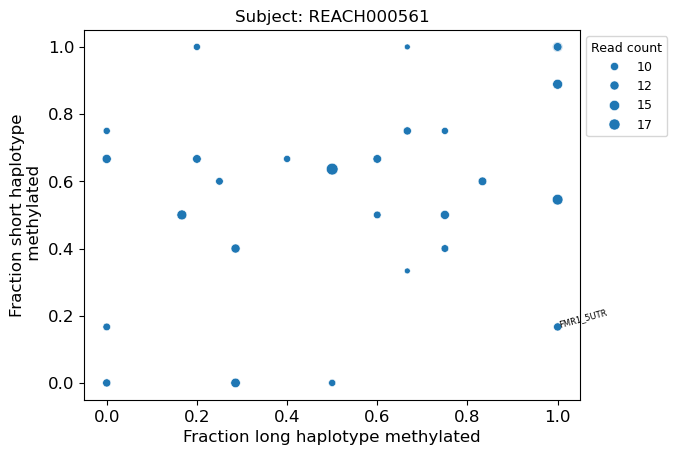

In [52]:
### plot skewness of all regions for one sample: 
### mean_repeat_len_h1=28.25 (short), mean_repeat_len_h2=49.11 (long)
import statsmodels.api as sm

hp_long = 'h2'
hp_short = 'h1'

### select sample
#['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519']
sample_id = 'REACH000561'
df_plt = df_methyl_sample.loc[sample_id,:].copy()

### filter on number of reads
df_plt = df_plt.loc[(df_plt.num_reads_h1>=3) & (df_plt.num_reads_h2>=3)]

print(df_plt.shape)

### exclude FMR1 from plotting
#df_plt = df_plt.loc[df_plt.region_id!='FMR1_5UTR']

FS = 12
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x=f'frac_hap_methyl_{hp_long}', y=f'frac_hap_methyl_{hp_short}', size='Read count')
#               hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'], size='Read count') #, hue='subject', size='num_reads', sizes=(5,20))
#plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.3)
#plt.text(x=.0, y=1, s=f'LLR p-value: {format_sci_notation(result.llr_pvalue)}', fontsize=FS-2)
#for i, row in df_plt.iterrows():
#    plt.text(x=row[f'frac_hap_methyl_{hp_long}'], y=row[f'frac_hap_methyl_{hp_short}', s=row.region_id, ha='left', rotation=15, fontsize=4)
plt.text(x=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_long}'].values[0], 
         y=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_short}'].values[0], 
         s=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), 'region_id'].values[0], ha='left', rotation=15, fontsize=6)
plt.legend(title = 'Read count', loc='upper left', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[1:], fontsize=FS-3, title_fontsize=FS-3) #title = 'binomial phred'
plt.xlabel('Fraction long haplotype methylated', fontsize=FS)
plt.ylabel('Fraction short haplotype\n methylated', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title(f'Subject: {sample_id}')
#plt.xlim((-0.1, 1.1))
#plt.ylim((-0.1, 1.1))
fig_name = f'{dir_fig}/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_{sample_id}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

(32, 21)
fragile_x_all//chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000453.png


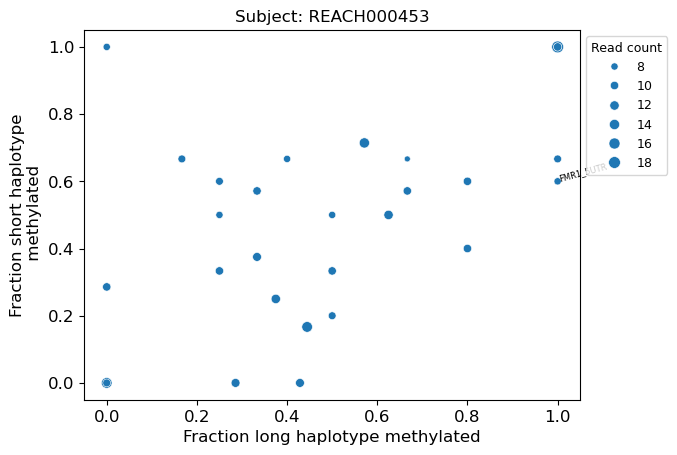

In [51]:
### plot skewness of all regions for one sample: 
### mean_repeat_len_h1=31.2 (short), mean_repeat_len_h2=49.4 (long)
import statsmodels.api as sm

hp_long = 'h2'
hp_short = 'h1'

### select sample
#['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519']
sample_id = 'REACH000453'
df_plt = df_methyl_sample.loc[sample_id,:].copy()

### filter on number of reads
df_plt = df_plt.loc[(df_plt.num_reads_h1>=3) & (df_plt.num_reads_h2>=3)]

print(df_plt.shape)

### exclude FMR1 from plotting
#df_plt = df_plt.loc[df_plt.region_id!='FMR1_5UTR']

FS = 12
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x=f'frac_hap_methyl_{hp_long}', y=f'frac_hap_methyl_{hp_short}', size='Read count')
#               hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'], size='Read count') #, hue='subject', size='num_reads', sizes=(5,20))
#plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.3)
#plt.text(x=.0, y=1, s=f'LLR p-value: {format_sci_notation(result.llr_pvalue)}', fontsize=FS-2)
#for i, row in df_plt.iterrows():
#    plt.text(x=row[f'frac_hap_methyl_{hp_long}'], y=row[f'frac_hap_methyl_{hp_short}', s=row.region_id, ha='left', rotation=15, fontsize=4)
plt.text(x=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_long}'].values[0], 
         y=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_short}'].values[0], 
         s=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), 'region_id'].values[0], ha='left', rotation=15, fontsize=6)
plt.legend(title = 'Read count', loc='upper left', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[1:], fontsize=FS-3, title_fontsize=FS-3) #title = 'binomial phred'
plt.xlabel('Fraction long haplotype methylated', fontsize=FS)
plt.ylabel('Fraction short haplotype\n methylated', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title(f'Subject: {sample_id}')
#plt.xlim((-0.1, 1.1))
#plt.ylim((-0.1, 1.1))
fig_name = f'{dir_fig}/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_{sample_id}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

(12, 21)
fragile_x_all//chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000451.png


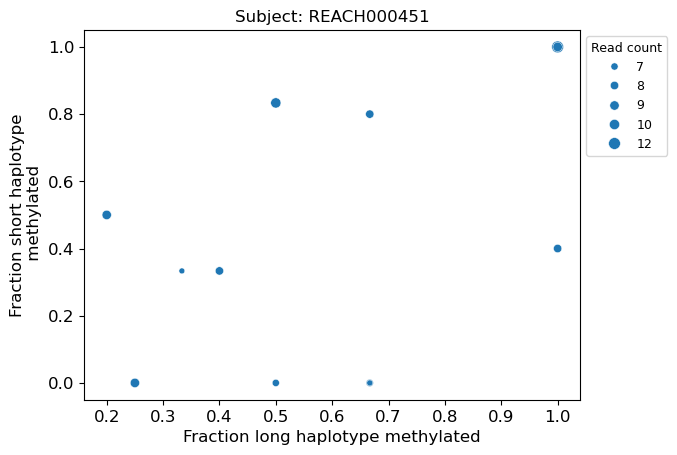

In [49]:
### plot skewness of all regions for one sample: 
### mean_repeat_len_h1=28.8 (short), mean_repeat_len_h2=49.4 (long)
import statsmodels.api as sm

hp_long = 'h2'
hp_short = 'h1'

### select sample
#['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519']
sample_id = 'REACH000451'
df_plt = df_methyl_sample.loc[sample_id,:].copy()

### filter on number of reads
df_plt = df_plt.loc[(df_plt.num_reads_h1>=3) & (df_plt.num_reads_h2>=3)]

print(df_plt.shape)

### exclude FMR1 from plotting
#df_plt = df_plt.loc[df_plt.region_id!='FMR1_5UTR']

FS = 12
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x=f'frac_hap_methyl_{hp_long}', y=f'frac_hap_methyl_{hp_short}', size='Read count')
#               hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'], size='Read count') #, hue='subject', size='num_reads', sizes=(5,20))
#plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.3)
#plt.text(x=.0, y=1, s=f'LLR p-value: {format_sci_notation(result.llr_pvalue)}', fontsize=FS-2)
#for i, row in df_plt.iterrows():
#    plt.text(x=row[f'frac_hap_methyl_{hp_long}'], y=row[f'frac_hap_methyl_{hp_short}', s=row.region_id, ha='left', rotation=15, fontsize=4)
#plt.text(x=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_long}'].values[0], 
#         y=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_short}'].values[0], 
#         s=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), 'region_id'].values[0], ha='left', rotation=15, fontsize=6)
plt.legend(title = 'Read count', loc='upper left', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[1:], fontsize=FS-3, title_fontsize=FS-3) #title = 'binomial phred'
plt.xlabel('Fraction long haplotype methylated', fontsize=FS)
plt.ylabel('Fraction short haplotype\n methylated', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title(f'Subject: {sample_id}')
#plt.xlim((-0.1, 1.1))
#plt.ylim((-0.1, 1.1))
fig_name = f'{dir_fig}/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_{sample_id}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

(27, 21)
fragile_x_all//chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000479.png


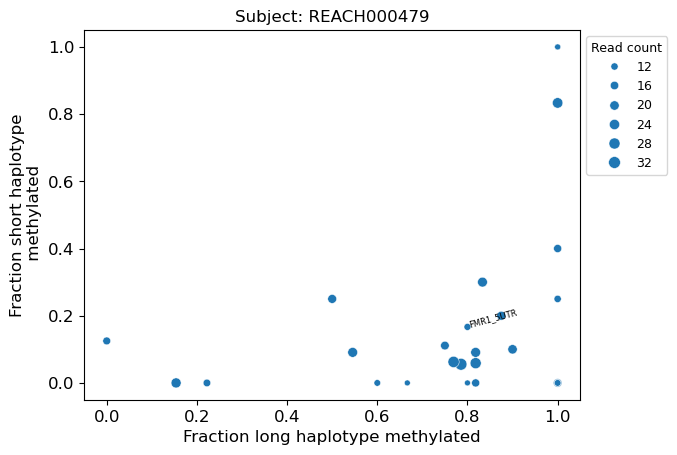

In [48]:
### plot skewness of all regions for one sample: 
### mean_repeat_len_h1=36 (short), mean_repeat_len_h2=22.33 (long)
import statsmodels.api as sm

hp_long = 'h1'
hp_short = 'h2'

### select sample
#['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519']
sample_id = 'REACH000479'
df_plt = df_methyl_sample.loc[sample_id,:].copy()

### filter on number of reads
df_plt = df_plt.loc[(df_plt.num_reads_h1>=3) & (df_plt.num_reads_h2>=3)]

print(df_plt.shape)

### exclude FMR1 from plotting
#df_plt = df_plt.loc[df_plt.region_id!='FMR1_5UTR']

FS = 12
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x=f'frac_hap_methyl_{hp_long}', y=f'frac_hap_methyl_{hp_short}', size='Read count')
#               hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'], size='Read count') #, hue='subject', size='num_reads', sizes=(5,20))
#plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.3)
#plt.text(x=.0, y=1, s=f'LLR p-value: {format_sci_notation(result.llr_pvalue)}', fontsize=FS-2)
#for i, row in df_plt.iterrows():
#    plt.text(x=row[f'frac_hap_methyl_{hp_long}'], y=row[f'frac_hap_methyl_{hp_short}', s=row.region_id, ha='left', rotation=15, fontsize=4)
plt.text(x=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_long}'].values[0], 
         y=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_short}'].values[0], 
         s=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), 'region_id'].values[0], ha='left', rotation=15, fontsize=6)
plt.legend(title = 'Read count', loc='upper left', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[1:], fontsize=FS-3, title_fontsize=FS-3) #title = 'binomial phred'
plt.xlabel('Fraction long haplotype methylated', fontsize=FS)
plt.ylabel('Fraction short haplotype\n methylated', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title(f'Subject: {sample_id}')
#plt.xlim((-0.1, 1.1))
#plt.ylim((-0.1, 1.1))
fig_name = f'{dir_fig}/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_{sample_id}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

(11, 21)
fragile_x_all//chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000518.png


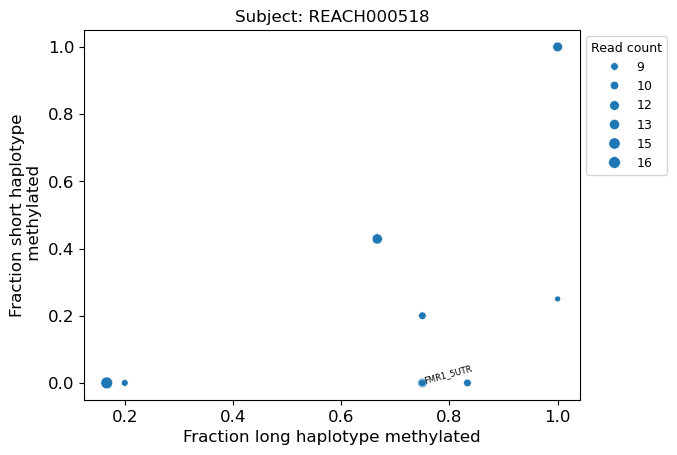

In [53]:
### plot skewness of all regions for one sample: 
### mean_repeat_len_h1=35 (short), mean_repeat_len_h2=29.44 (long)
import statsmodels.api as sm

hp_long = 'h1'
hp_short = 'h2'

### select sample
#['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519']
sample_id = 'REACH000518'
df_plt = df_methyl_sample.loc[sample_id,:].copy()

### filter on number of reads
df_plt = df_plt.loc[(df_plt.num_reads_h1>=3) & (df_plt.num_reads_h2>=3)]

print(df_plt.shape)

### exclude FMR1 from plotting
#df_plt = df_plt.loc[df_plt.region_id!='FMR1_5UTR']

FS = 12
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x=f'frac_hap_methyl_{hp_long}', y=f'frac_hap_methyl_{hp_short}', size='Read count')
#               hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'], size='Read count') #, hue='subject', size='num_reads', sizes=(5,20))
#plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.3)
#plt.text(x=.0, y=1, s=f'LLR p-value: {format_sci_notation(result.llr_pvalue)}', fontsize=FS-2)
#for i, row in df_plt.iterrows():
#    plt.text(x=row[f'frac_hap_methyl_{hp_long}'], y=row[f'frac_hap_methyl_{hp_short}', s=row.region_id, ha='left', rotation=15, fontsize=4)
plt.text(x=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_long}'].values[0], 
         y=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_short}'].values[0], 
         s=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), 'region_id'].values[0], ha='left', rotation=15, fontsize=6)
plt.legend(title = 'Read count', loc='upper left', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[1:], fontsize=FS-3, title_fontsize=FS-3) #title = 'binomial phred'
plt.xlabel('Fraction long haplotype methylated', fontsize=FS)
plt.ylabel('Fraction short haplotype\n methylated', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title(f'Subject: {sample_id}')
#plt.xlim((-0.1, 1.1))
#plt.ylim((-0.1, 1.1))
fig_name = f'{dir_fig}/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_{sample_id}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

(18, 21)
fragile_x_all//chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000519.png


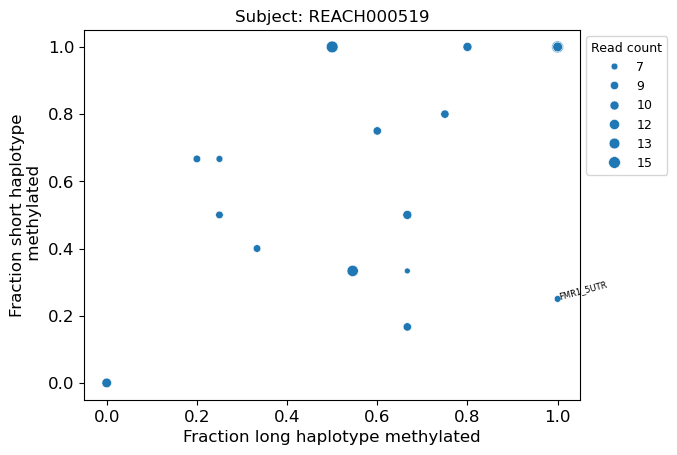

In [54]:
### plot skewness of all regions for one sample: 
### mean_repeat_len_h1=35 (short), mean_repeat_len_h2=20.83 (long)
import statsmodels.api as sm

hp_long = 'h1'
hp_short = 'h2'

### select sample
#['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519']
sample_id = 'REACH000519'
df_plt = df_methyl_sample.loc[sample_id,:].copy()

### filter on number of reads
df_plt = df_plt.loc[(df_plt.num_reads_h1>=3) & (df_plt.num_reads_h2>=3)]

print(df_plt.shape)

### exclude FMR1 from plotting
#df_plt = df_plt.loc[df_plt.region_id!='FMR1_5UTR']

FS = 12
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x=f'frac_hap_methyl_{hp_long}', y=f'frac_hap_methyl_{hp_short}', size='Read count')
#               hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'], size='Read count') #, hue='subject', size='num_reads', sizes=(5,20))
#plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.3)
#plt.text(x=.0, y=1, s=f'LLR p-value: {format_sci_notation(result.llr_pvalue)}', fontsize=FS-2)
#for i, row in df_plt.iterrows():
#    plt.text(x=row[f'frac_hap_methyl_{hp_long}'], y=row[f'frac_hap_methyl_{hp_short}', s=row.region_id, ha='left', rotation=15, fontsize=4)
plt.text(x=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_long}'].values[0], 
         y=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_short}'].values[0], 
         s=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), 'region_id'].values[0], ha='left', rotation=15, fontsize=6)
plt.legend(title = 'Read count', loc='upper left', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[1:], fontsize=FS-3, title_fontsize=FS-3) #title = 'binomial phred'
plt.xlabel('Fraction long haplotype methylated', fontsize=FS)
plt.ylabel('Fraction short haplotype\n methylated', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title(f'Subject: {sample_id}')
#plt.xlim((-0.1, 1.1))
#plt.ylim((-0.1, 1.1))
fig_name = f'{dir_fig}/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_{sample_id}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

In [3]:
### add other select genes with high coverage in some gray-zone subjects
file_in_og = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/METHYLATION/snoopsv_methyl/chrX_All_Genes/RUN_SELECT_GENES_v3/methyl_data.tsv'
df_og = pd.read_table(file_in_og, sep='\t', header=0, keep_default_na=False)

pd.set_option('display.max_columns', None)
print('df_og:')
display(df_og)
pd.set_option('display.max_columns', 10)

file_sam = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/METHYLATION/snoopsv_methyl/chrX_All_Genes/RUN_SELECT_GENES_v3/methyl_data_sample_order.txt'
with open(file_sam, 'r') as fh:
    sample_order = fh.readline().split(',')[:-1] # last one is an empty string
print(f'number of samples: {len(sample_order)}')
#print(f'sample order: {sample_order}')

df_exnd_og = df_og[['chrom' ,'pos', 'end', 'region_id']].copy()
cols = df_og.columns.tolist()[4:]
#print(cols)

for idx, sample in enumerate(sample_order):
    #if sample == 'REACH000450' or sample == 'REACH000452':
    #    continue
    for col in cols:
        df_exnd_og[f'{sample}_{col}'] = df_og[col].str.split(';').apply(lambda row: row[idx])
print('df_exnd_og:')
display(df_exnd_og)

df_og:


chrom        pos        end      region_id  \
0   chrX   10620123   10620805      MID1_5UTR   
1   chrX   12791015   12791585     PRPS2_5UTR   
2   chrX   13044401   13045071     FAM9C_5UTR   
3   chrX   13816674   13817842     GPM6B_5UTR   
4   chrX   19514741   19515739   MAP3K15_5UTR   
5   chrX   21373641   21375353    CNKSR2_5UTR   
6   chrX   21839439   21840274    MBTPS2_5UTR   
7   chrX   21940346   21941416       SMS_5UTR   
8   chrX   23742860   23743480     ACOT9_5UTR   
9   chrX   25015452   25016191       ARX_5UTR   
10  chrX   30246430   30247455    MAGEB1_5UTR   
11  chrX   35919414   35920371    CFAP47_5UTR   
12  chrX   37008158   37008775    FAM47C_5UTR   
13  chrX   38220364   38220961      SRPX_5UTR   
14  chrX   48970910   48972745     KCND1_5UTR   
15  chrX   49186209   49186655  PRICKLE3_5UTR   
16  chrX   50813108   50814242   SHROOM4_5UTR   
17  chrX   51495830   51497290    NUDT11_5UTR   
18  chrX   51743128   51744089     GSPT2_5UTR   
19  chrX   54043893   54044711      PHF8_5UTR   
20  chrX   69164921   69165732      PJA1_5UTR   
21  chrX   69615756   69616659       EDA_5UTR   
22  chrX   73214081   73214876    NAP1L2_5UTR   
23  chrX   73446339   73448078      CDX4_5UTR   
24  chrX  100928741  100929460      XKRX_5UTR   
25  chrX  101218988  101220673      DRP2_5UTR   
26  chrX  101290981  101291629     TAF7L_5UTR   
27  chrX  102142296  102142658    TCEAL6_5UTR   
28  chrX  119758238  119759399    SOWAHD_5UTR   
29  chrX  147911921  147912179      FMR1_5UTR   
30  chrX  152830557  152831317     NSDHL_5UTR   
31  chrX  153321061  153321879    PNMA6F_5UTR   
32  chrX  153647000  153647464     DUSP9_5UTR   
33  chrX  154762543  154763011      DKC1_5UTR   

                                            methyl_h1  \
0   .;.;.;.;.;.;.;.;.;2|2|34|21|9|38|52|66|56|18|1...   
1   .;.;.;96|82|42|36|92|94|91|74|94|99|99|97|97|9...   
2   .;.;.;46|53|92|91|65|93|98|99|100|100|100|100|...   
3   .;.;.;21|34|70|55|72|63|57|59|24|7|15|13|9|7|8...   
4   .;.;.;.;.;.;94|99|96|98|93|92|99|93|86|92|98|1...   
5   .;.;.;.;.;.;35|19|26|36|36|29|91|96|99|99|99|1...   
6   .;.;.;.;.;.;.;.;0|0|0|0|0|0|1|0|1|0|1|9|0|0|0|...   
7   .;.;.;43|57|81|41|26|4|8|2|2|2|6|6|23|13|17|7|...   
8   .;.;.;3|5|27|6|4|1|0|4|1|0|0|0|0|0|0|0|0|3|11|...   
9   .;.;.;.;.;.;48|82|84|86|41|72|96|95|84|70|93|9...   
10  .;.;.;.;.;.;41|43|41|44|28|52|6|41|49|20|14|28...   
11  .;.;.;.;.;48|44|49|73|80|85|89|95|98|86|54|62|...   
12  .;.;.;.;.;.;.;.;1|5|1|0|0|0|2|1|5|60|82|98|99|...   
13  .;.;.;.;.;.;1|3|2|1|1|1|2|3|5|2|2|1|2|19|23|4|...   
14  .;.;.;11|23|21|30|71|75|67|79|56|34|17|5|8|7|4...   
15  .;.;.;.;.;.;89|91|93|98|96|99|99|98|97|99|100|...   
16  .;.;.;1|2|3|16|31|30|55|77|82|86|89|84|96|95|9...   
17  .;.;.;.;.;.;85|91|99|100|100|100|99|99|97|97|9...   
18  .;.;.;.;.;.;3|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
19  .;.;.;12|6|14|12|24|24|8|5|9|48|11|7|4|4|1|0|0...   
20  .;.;0|1|0|1|4|7|34|16|5|6|2|1|1|0|0|0|0|0|0|0|...   
21  .;.;.;91|81|77|54|16|44|66|63|59|11|11|11|14|6...   
22  .;.;.;7|1|0|0|0|0|0|0|0|1|0|0|0|5|5|1|1|0|1|1|...   
23  .;.;.;.;.;.;92|94|52|27|41|30|2|1|2|25|45|35|1...   
24  .;.;.;.;.;.;.;.;0|0|0|0|0|0|0|0|0|0|1|1|7|8|3|...   
25  .;.;.;.;.;.;70|64|77|68|77|54|56|46|13|7|21|11...   
26  .;.;.;19|3|5|0|2|5|25|16|21|47|78|60|72|18|10|...   
27  .;.;.;.;.;.;70|13|5|18|11|32|35|20|20|57|48|19...   
28  .;.;.;.;.;.;.;.;.;92|93|84|14|18|2|0|0|0|8|13|...   
29  .;.;.;91|95|100|99|96|100|99|98|98|96|96|97|94...   
30  .;.;.;1|0|0|1|2|8|71|42|23|33|56|49|50|2|7|16|...   
31  5|2|1|0|1|0|2|13|23|10|16|2|2|0|0|0|0|0|0|0|0|...   
32  .;.;.;.;.;.;75|96|95|90|95|80|97|90|68|87|78|7...   
33  .;.;.;100|100|100|100|100|96|73|93|82|86|90|96...   

                                            methyl_h2  \
0   .;.;.;.;.;.;.;.;.;22|55|23|34|52|71|37|63|36|3...   
1   .;.;.;.;.;.;.;.;1|0|0|0|0|0|0|0|0|7|15|19|8|4|...   
2   .;.;.;74|88|95|96|96|97|94|98|98|93|95|95|83|9...   
3   .;.;.;26|35|9|0|0|0|0|2|2|1|2|12|20|16|2|0|1|4...   
4   .;

number of samples: 270
df_exnd_og:


chrom        pos        end      region_id  \
0   chrX   10620123   10620805      MID1_5UTR   
1   chrX   12791015   12791585     PRPS2_5UTR   
2   chrX   13044401   13045071     FAM9C_5UTR   
3   chrX   13816674   13817842     GPM6B_5UTR   
4   chrX   19514741   19515739   MAP3K15_5UTR   
5   chrX   21373641   21375353    CNKSR2_5UTR   
6   chrX   21839439   21840274    MBTPS2_5UTR   
7   chrX   21940346   21941416       SMS_5UTR   
8   chrX   23742860   23743480     ACOT9_5UTR   
9   chrX   25015452   25016191       ARX_5UTR   
10  chrX   30246430   30247455    MAGEB1_5UTR   
11  chrX   35919414   35920371    CFAP47_5UTR   
12  chrX   37008158   37008775    FAM47C_5UTR   
13  chrX   38220364   38220961      SRPX_5UTR   
14  chrX   48970910   48972745     KCND1_5UTR   
15  chrX   49186209   49186655  PRICKLE3_5UTR   
16  chrX   50813108   50814242   SHROOM4_5UTR   
17  chrX   51495830   51497290    NUDT11_5UTR   
18  chrX   51743128   51744089     GSPT2_5UTR   
19  chrX   54043893   54044711      PHF8_5UTR   
20  chrX   69164921   69165732      PJA1_5UTR   
21  chrX   69615756   69616659       EDA_5UTR   
22  chrX   73214081   73214876    NAP1L2_5UTR   
23  chrX   73446339   73448078      CDX4_5UTR   
24  chrX  100928741  100929460      XKRX_5UTR   
25  chrX  101218988  101220673      DRP2_5UTR   
26  chrX  101290981  101291629     TAF7L_5UTR   
27  chrX  102142296  102142658    TCEAL6_5UTR   
28  chrX  119758238  119759399    SOWAHD_5UTR   
29  chrX  147911921  147912179      FMR1_5UTR   
30  chrX  152830557  152831317     NSDHL_5UTR   
31  chrX  153321061  153321879    PNMA6F_5UTR   
32  chrX  153647000  153647464     DUSP9_5UTR   
33  chrX  154762543  154763011      DKC1_5UTR   

                                REACH000026_methyl_h1  ...  \
0                                                   .  ...   
1                                                   .  ...   
2                                                   .  ...   
3                                                   .  ...   
4                                                   .  ...   
5                                                   .  ...   
6                                                   .  ...   
7                                                   .  ...   
8                                                   .  ...   
9                                                   .  ...   
10                                                  .  ...   
11                                                  .  ...   
12                                                  .  ...   
13                                                  .  ...   
14                                                  .  ...   
15                                                  .  ...   
16                                                  .  ...   
17                                                  .  ...   
18                                                  .  ...   
19                                                  .  ...   
20                                                  .  ...   
21                                                  .  ...   
22                                                  .  ...   
23                                                  .  ...   
24                                                  .  ...   
25                                                  .  ...   
26                                                  .  ...   
27                                                  .  ...   
28                                                  .  ...   
29                                                  .  ...   
30                                                  .  ...   
31  5|2|1|0|1|0|2|13|23|10|16|2|2|0|0|0|0|0|0|0|0|...  ...   
32                                                  .  ...   
33                                                  .  ...   

                                    REACH000685_rn_h1  \
0                                                   .   
1 

In [6]:
### get the methylation data of all regions for one sample
samples_only = ['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519']
df_methyl_sample = pd.DataFrame()
for region_id in df_exnd_og.region_id.tolist():
    this_df = get_gene_methyl_data(region_id, df_exnd_og, samples_only)
    this_df['region_id'] = region_id
    df_methyl_sample = pd.concat([df_methyl_sample, this_df])

df_methyl_sample['num_reads_h1'] = df_methyl_sample.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) 
                                                  if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_sample['num_reads_h2'] = df_methyl_sample.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) 
                                                  if row.num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_sample['Read count'] = df_methyl_sample['num_reads_h1'] + df_methyl_sample['num_reads_h2']
pd.set_option('display.max_columns', None)

pd.set_option('display.max_columns', None)
print('df_methyl_sample:')
print(df_methyl_sample.shape)
display(df_methyl_sample)
pd.set_option('display.max_columns', 10)

df_methyl_sample:
(204, 21)


methyl_h1  \
REACH000451                                                  .   
REACH000453  0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...   
REACH000479  31|70|0|100|1|0|0|3|8|7|0|0|0|0|0|0|0|2|0|38|4...   
REACH000518  0|0|51|27|0|0|11|3|0|0|30|0|0|1|91|10|3|0|30|9...   
REACH000519  59|0|0|100|96|0|69|0|99|79|100|0|2|1|0|2|3|0|1...   
...                                                        ...   
REACH000453  11|93|84|99|97|91|98|100|100|100|100|100|100|1...   
REACH000479                                                  .   
REACH000518  85|74|100|100|100|46|64|0|92|99|100|100|99|52|...   
REACH000519  63|100|99|66|100|95|58|98|23|100|96|55|91|58|0...   
REACH000561                                                  .   

                                                     methyl_h2  \
REACH000451  0|0|0|0|0|9|2|0|0|0|0|0|0|0|0|0|1|1|1|0|0|0|0|...   
REACH000453                                                  .   
REACH000479  0|0|49|1|0|4|2|2|2|0|3|0|84|0|14|79|0|46|1|10|...   
REACH000518  4|12|0|0|1|0|4|2|0|18|0|0|2|32|1|0|0|26|10|0|0...   
REACH000519  4|99|0|0|0|0|0|0|0|1|0|0|15|4|0|0|2|20|0|1|0|0...   
...                                                        ...   
REACH000453  100|100|100|100|100|100|98|100|100|100|100|100...   
REACH000479  0|89|100|100|100|98|100|100|100|100|99|100|100...   
REACH000518  100|0|100|100|100|100|50|0|98|1|78|12|100|100|...   
REACH000519  90|100|100|71|100|70|92|84|2|87|19|19|93|73|94...   
REACH000561                                                  .   

                                                     methyl_h0  \
REACH000451  82|95|98|97|82|82|62|72|33|14|32|56|29|5|3|4|5...   
REACH000453  99|100|100|98|84|61|36|90|35|0|2|5|3|7|12|1|30...   
REACH000479  0|1|0|0|0|0|0|0|0|0|0|0|0|2|2|0|9|0|0|0|0|0|0|...   
REACH000518                                                  .   
REACH000519  1|46|1|4|0|0|60|0|12|16|1|3|53|23|2|0|52|0|3|3...   
...                                                        ...   
REACH000453                                                  .   
REACH000479  0|0|2|0|0|0|70|0|4|0|0|1|64|0|0|0|0|0|2|0|56|0...   
REACH000518  4|100|100|100|98|71|99|2|1|0|100|100|89|100|10...   
REACH000519                                                  .   
REACH000561  100|0|99|0|100|100|6|99|61|100|100|100|28|98|0...   

                                           ps_h1  \
REACH000451                                    .   
REACH000453                             18446005   
REACH000479                          10185,10185   
REACH000518              10185,10185,10185,10185   
REACH000519                    10185,10185,10185   
...                                          ...   
REACH000453                                10185   
REACH000479                                    .   
REACH000518        10185,10185,10185,10185,10185   
REACH000519  10185,10185,10185,10185,10185,10185   
REACH000561                                    .   

                                     ps_h2 read_mean_methyl_lik_h1  \
REACH000451                          10185                       .   
REACH000453                              .                       2   
REACH000479        10185,10185,10185,10185                   21,52   
REACH000518        10185,10185,10185,10185             11,67,56,61   
REACH000519        10185,10185,10185,10185                 34,9,67   
...                                    ...                     ...   
REACH000453        10185,10185,10185,10185                      93   
REACH000479                          12041                       .   
REACH000518        10185,10185,10185,10185           76,77,73,7,56   
REACH000519  10185,10185,10185,10185,10185        65,54,4,13,77,77   
REACH000561                              .                       .   

            read_mean_methyl_lik_h2  \
REACH000451                       0   
REACH000453                       .   
REACH000479                12,8,4,7   
REACH000518               10,6,6,62   
REACH000519  

(34, 21)
fragile_x_all//chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000518_v3.png


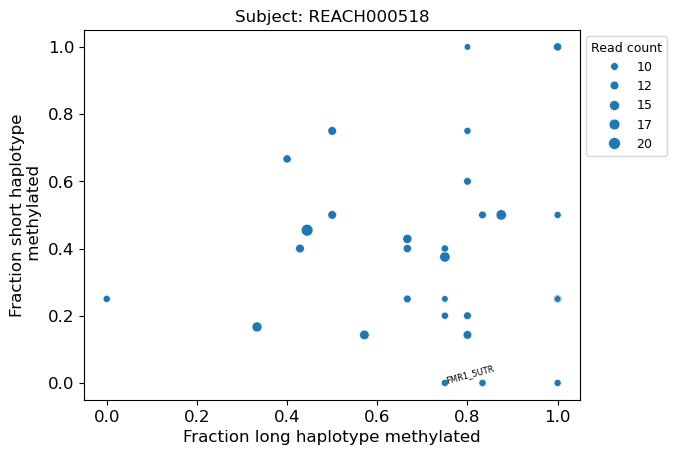

In [7]:
### plot skewness of all regions for one sample: 
### mean_repeat_len_h1=35 (short), mean_repeat_len_h2=29.44 (long)
import statsmodels.api as sm

hp_long = 'h1'
hp_short = 'h2'

### select sample
#['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519']
sample_id = 'REACH000518'
df_plt = df_methyl_sample.loc[sample_id,:].copy()

### filter on number of reads
df_plt = df_plt.loc[(df_plt.num_reads_h1>=3) & (df_plt.num_reads_h2>=3)]

print(df_plt.shape)

### exclude FMR1 from plotting
#df_plt = df_plt.loc[df_plt.region_id!='FMR1_5UTR']

FS = 12
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x=f'frac_hap_methyl_{hp_long}', y=f'frac_hap_methyl_{hp_short}', size='Read count')
#               hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'], size='Read count') #, hue='subject', size='num_reads', sizes=(5,20))
#plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.3)
#plt.text(x=.0, y=1, s=f'LLR p-value: {format_sci_notation(result.llr_pvalue)}', fontsize=FS-2)
#for i, row in df_plt.iterrows():
#    plt.text(x=row[f'frac_hap_methyl_{hp_long}'], y=row[f'frac_hap_methyl_{hp_short}', s=row.region_id, ha='left', rotation=15, fontsize=4)
plt.text(x=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_long}'].values[0], 
         y=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_short}'].values[0], 
         s=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), 'region_id'].values[0], ha='left', rotation=15, fontsize=6)
plt.legend(title = 'Read count', loc='upper left', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[1:], fontsize=FS-3, title_fontsize=FS-3) #title = 'binomial phred'
plt.xlabel('Fraction long haplotype methylated', fontsize=FS)
plt.ylabel('Fraction short haplotype\n methylated', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title(f'Subject: {sample_id}')
#plt.xlim((-0.1, 1.1))
#plt.ylim((-0.1, 1.1))
fig_name = f'{dir_fig}/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_{sample_id}_v3.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

(34, 21)
fragile_x_all//chrX_genes_frac_hap_methyl_h1_vs_h2_logid_REACH000519_v3.png


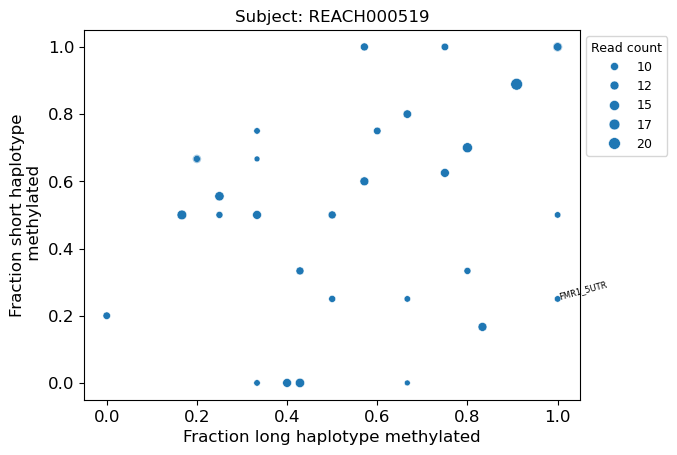

In [8]:
### plot skewness of all regions for one sample: 
### mean_repeat_len_h1=35 (short), mean_repeat_len_h2=20.83 (long)
import statsmodels.api as sm

hp_long = 'h1'
hp_short = 'h2'

### select sample
#['REACH000561', 'REACH000453', 'REACH000451', 'REACH000479', 'REACH000518', 'REACH000519']
sample_id = 'REACH000519'
df_plt = df_methyl_sample.loc[sample_id,:].copy()

### filter on number of reads
df_plt = df_plt.loc[(df_plt.num_reads_h1>=3) & (df_plt.num_reads_h2>=3)]

print(df_plt.shape)

### exclude FMR1 from plotting
#df_plt = df_plt.loc[df_plt.region_id!='FMR1_5UTR']

FS = 12
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x=f'frac_hap_methyl_{hp_long}', y=f'frac_hap_methyl_{hp_short}', size='Read count')
#               hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'], size='Read count') #, hue='subject', size='num_reads', sizes=(5,20))
#plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.3)
#plt.text(x=.0, y=1, s=f'LLR p-value: {format_sci_notation(result.llr_pvalue)}', fontsize=FS-2)
#for i, row in df_plt.iterrows():
#    plt.text(x=row[f'frac_hap_methyl_{hp_long}'], y=row[f'frac_hap_methyl_{hp_short}', s=row.region_id, ha='left', rotation=15, fontsize=4)
plt.text(x=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_long}'].values[0], 
         y=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), f'frac_hap_methyl_{hp_short}'].values[0], 
         s=df_plt.loc[(df_plt.region_id=='FMR1_5UTR'), 'region_id'].values[0], ha='left', rotation=15, fontsize=6)
plt.legend(title = 'Read count', loc='upper left', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[1:], fontsize=FS-3, title_fontsize=FS-3) #title = 'binomial phred'
plt.xlabel('Fraction long haplotype methylated', fontsize=FS)
plt.ylabel('Fraction short haplotype\n methylated', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title(f'Subject: {sample_id}')
#plt.xlim((-0.1, 1.1))
#plt.ylim((-0.1, 1.1))
fig_name = f'{dir_fig}/chrX_genes_frac_hap_methyl_h1_vs_h2_logid_{sample_id}_v3.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

In [23]:
### you need to run the cell with df_exnd first
region_id = 'CD99_5UTR'
df_methyl_og = get_gene_methyl_data(region_id, df_exnd)
print('df_methyl_og:')
display(df_methyl_og)

df_methyl_og:


methyl_h1  \
REACH000026  2|1|1|1|5|31|19|39,0|0|0|0|0|0|0|0,43|10|8|2|1...   
REACH000058                                    0|0|0|0|0|1|0|0   
REACH000065  98|95|58|53|28|4|0|0,1|14|10|4|4|3|1|2,30|11|3...   
REACH000066                                                  .   
REACH000067                                                  .   
...                                                        ...   
REACH000681  0|0|6|94|4|0|2,3|0|14|0|0|2,31|0|10|0|0|0,0|20...   
REACH000682  0|2|0|0|4|2|0|0|0,0|0|0|1|0|0|0|0,9|10|3|0|18|...   
REACH000683  0|0|0|21|0|0|0|0,0|0|0|56|0|0|0|0,24|0|0|0|8|0...   
REACH000684  0|0|14|4|0|0|1|4,0|0|0|2|22|0|0|1,0|6|0|1|1|0|...   
REACH000685  7|0|3|56|0|0|0|0|0,0|0|0|5|0|0|0|0,2|1|1|79|1|...   

                                                     methyl_h2 methyl_h0  \
REACH000026                    2|4|1|0|0|0|0|0,0|2|1|2|2|4|1|5         .   
REACH000058  0|0|4|8|6|21|39|21,19|8|10|10|4|2|1|0,1|4|0|0|...         .   
REACH000065                 1|2|0|0|0|0|0|2,66|19|11|4|6|0|0|0         .   
REACH000066                                                  .         .   
REACH000067                                                  .         .   
...                                                        ...       ...   
REACH000681  3|0|4|13|13|0|1|0|1,0|0|0|1|0|0|12,0|0|3|0|27|...         .   
REACH000682  0|0|0|1|0|0|0|0,8|1|0|2|0|3|0|0,1|0|0|0|0|7|1|...         .   
REACH000683  0|0|0|0|1|0|0|1,0|3|2|0|0|7|21|0|0,0|0|0|88|0|...         .   
REACH000684                                 0|2|0|2|0|13|0|0|1         .   
REACH000685  34|1|0|0|1|0|0|1|3,0|0|11|0|0|0|0,0|1|0|15|2|7...         .   

             read_mean_methyl_lik_h1 read_mean_methyl_lik_h2  ...  \
REACH000026                   12,0,8                     1,2  ...   
REACH000058                        0                12,7,1,1  ...   
REACH000065                42,5,9,29                    1,13  ...   
REACH000066                        .                       .  ...   
REACH000067                        .                       .  ...   
...                              ...                     ...  ...   
REACH000681  15,3,7,4,2,0,18,1,14,11                4,2,4,28  ...   
REACH000682                    1,0,5              0,2,3,24,1  ...   
REACH000683   3,7,4,4,44,2,28,1,8,17                0,4,11,3  ...   
REACH000684                3,3,1,2,6                       2  ...   
REACH000685                7,1,9,9,2   4,2,4,8,6,0,4,13,3,18  ...   

            num_unmethyl_reads_h2 frac_hap_methyl_h2 num_methyl_reads_h0  \
REACH000026                     2                0.0                   .   
REACH000058                     4                0.0                   .   
REACH000065                     2                0.0                   .   
REACH000066                     .                  .                   .   
REACH000067                     .                  .                   .   
...                           ...                ...                 ...   
REACH000681                     4                0.0                   .   
REACH000682                     5                0.0                   .   
REACH000683                     4                0.0                   .   
REACH000684                     1                0.0                   .   
REACH000685                    10                0.0                   .   

            num_unmethyl_reads_h0 frac_hap_methyl_h0  
REACH000026                     .                  .  
REACH000058                     .                  .  
REACH000065                     .                  .  
REACH000066                     .                  .  
REACH000067                     .                  .  
...                           ...                ...  
REACH000681                     .                  .  
REACH000682                     .                  .  
REACH000683                     .                  .  
REACH000684                     .                  .  


In [25]:
### you need to run the cell with df_exnd first
region_id = 'CD99_5UTR'
df_methyl_og = get_gene_methyl_data(region_id, df_exnd)
#print('df_methyl_og:')
#display(df_methyl_og)

df_methyl_og['cgg_repeat_len_h1'] = df_methyl_og.index.map(df_methyl.mean_repeat_length_h1)
df_methyl_og['cgg_repeat_len_h2'] = df_methyl_og.index.map(df_methyl.mean_repeat_length_h2)
df_methyl_og['cgg_repeat_len_h0'] = df_methyl_og.index.map(df_methyl.mean_repeat_length_h0)
df_methyl_og['num_fmr1_methyl_reads_h1'] = df_methyl_og.index.map(df_methyl.num_methyl_reads_h1)
df_methyl_og['num_fmr1_unmethyl_reads_h1'] = df_methyl_og.index.map(df_methyl.num_unmethyl_reads_h1)
df_methyl_og['num_fmr1_methyl_reads_h2'] = df_methyl_og.index.map(df_methyl.num_methyl_reads_h2)
df_methyl_og['num_fmr1_unmethyl_reads_h2'] = df_methyl_og.index.map(df_methyl.num_unmethyl_reads_h2)
df_methyl_og['num_fmr1_reads_h1'] = df_methyl_og.apply(lambda row: np.sum([int(x) for x in [row.num_fmr1_methyl_reads_h1, 
                                                                                            row.num_fmr1_unmethyl_reads_h1] if x!='.']) 
                                                       if (row.num_fmr1_methyl_reads_h1!='.' or 
                                                           row.num_fmr1_unmethyl_reads_h1!='.') else '.', axis=1)
df_methyl_og['num_fmr1_reads_h2'] = df_methyl_og.apply(lambda row: np.sum([int(x) for x in [row.num_fmr1_methyl_reads_h2, 
                                                                                            row.num_fmr1_unmethyl_reads_h2] if x!='.']) 
                                                       if (row.num_fmr1_methyl_reads_h2!='.' or 
                                                           row.num_fmr1_unmethyl_reads_h2!='.') else '.', axis=1)
df_methyl_og['sex'] = df_methyl_og.index.map(df_methyl.sex)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
print('df_methyl_og:')
display(df_methyl_og)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

df_methyl_og:


methyl_h1  \
REACH000026  2|1|1|1|5|31|19|39,0|0|0|0|0|0|0|0,43|10|8|2|1...   
REACH000058                                    0|0|0|0|0|1|0|0   
REACH000065  98|95|58|53|28|4|0|0,1|14|10|4|4|3|1|2,30|11|3...   
REACH000066                                                  .   
REACH000067                                                  .   
...                                                        ...   
REACH000681  0|0|6|94|4|0|2,3|0|14|0|0|2,31|0|10|0|0|0,0|20...   
REACH000682  0|2|0|0|4|2|0|0|0,0|0|0|1|0|0|0|0,9|10|3|0|18|...   
REACH000683  0|0|0|21|0|0|0|0,0|0|0|56|0|0|0|0,24|0|0|0|8|0...   
REACH000684  0|0|14|4|0|0|1|4,0|0|0|2|22|0|0|1,0|6|0|1|1|0|...   
REACH000685  7|0|3|56|0|0|0|0|0,0|0|0|5|0|0|0|0,2|1|1|79|1|...   

                                                     methyl_h2 methyl_h0  \
REACH000026                    2|4|1|0|0|0|0|0,0|2|1|2|2|4|1|5         .   
REACH000058  0|0|4|8|6|21|39|21,19|8|10|10|4|2|1|0,1|4|0|0|...         .   
REACH000065                 1|2|0|0|0|0|0|2,66|19|11|4|6|0|0|0         .   
REACH000066                                                  .         .   
REACH000067                                                  .         .   
...                                                        ...       ...   
REACH000681  3|0|4|13|13|0|1|0|1,0|0|0|1|0|0|12,0|0|3|0|27|...         .   
REACH000682  0|0|0|1|0|0|0|0,8|1|0|2|0|3|0|0,1|0|0|0|0|7|1|...         .   
REACH000683  0|0|0|0|1|0|0|1,0|3|2|0|0|7|21|0|0,0|0|0|88|0|...         .   
REACH000684                                 0|2|0|2|0|13|0|0|1         .   
REACH000685  34|1|0|0|1|0|0|1|3,0|0|11|0|0|0|0,0|1|0|15|2|7...         .   

             read_mean_methyl_lik_h1 read_mean_methyl_lik_h2  \
REACH000026                   12,0,8                     1,2   
REACH000058                        0                12,7,1,1   
REACH000065                42,5,9,29                    1,13   
REACH000066                        .                       .   
REACH000067                        .                       .   
...                              ...                     ...   
REACH000681  15,3,7,4,2,0,18,1,14,11                4,2,4,28   
REACH000682                    1,0,5              0,2,3,24,1   
REACH000683   3,7,4,4,44,2,28,1,8,17                0,4,11,3   
REACH000684                3,3,1,2,6                       2   
REACH000685                7,1,9,9,2   4,2,4,8,6,0,4,13,3,18   

            read_mean_methyl_lik_h0 num_methyl_reads_h1 num_unmethyl_reads_h1  \
REACH000026                       .                   0                     3   
REACH000058                       .                   0                     1   
REACH000065                       .                   0                     4   
REACH000066                       .                   .                     .   
REACH000067                       .                   .                     .   
...                             ...                 ...                   ...   
REACH000681                       .                   0                    10   
REACH000682                       .                   0                     3   
REACH000683                       .                   0                    10   
REACH000684                       .                   0                     5   
REACH000685                       .                   0                     5   

            frac_hap_methyl_h1 num_methyl_reads_h2 num_unmethyl_reads_h2  \
REACH000026                0.0                   0                     2   
REACH000058                0.0                   0                     4   
REACH000065                0.0                   0                     2   
REACH000066                  .                   .                     .   
REACH000067                  .                   .                     .   
...                        ...                 ...                   ...   
REACH000681                0.0                   0                     4 

df_plt:


subject_id  mean_repeat_length  frac_hap_methyl  num_reads
0       REACH000089           30.333333         0.000000        3.0
1       REACH000092           29.800000         0.000000        3.0
2       REACH000220           29.000000         0.000000        4.0
3       REACH000294           23.333333         0.000000        3.0
4       REACH000314           29.500000         0.000000        3.0
5       REACH000365           30.166667         0.000000        3.0
6    REACH000436_PB           23.750000         0.000000        4.0
7       REACH000453           31.200000         0.000000        8.0
8       REACH000453           49.400000         0.000000        4.0
9       REACH000616           29.200000         0.000000        8.0
10      REACH000620           39.166667         0.000000        3.0
11      REACH000628           30.250000         0.000000        3.0
12      REACH000628           29.200000         0.000000        3.0
13      REACH000641           31.000000         0.000000        3.0
14      REACH000672           30.000000         0.000000        3.0
15      REACH000702           29.333333         0.000000       11.0
16      REACH000702           30.250000         0.000000        5.0
17      REACH000727           31.000000         0.000000        7.0
18      REACH000755           24.000000         0.000000        3.0
19      REACH000107           28.750000         0.000000        4.0
20      REACH000107           28.333333         0.000000        3.0
21      REACH000401           17.750000         0.000000        5.0
22      REACH000404           28.750000         0.250000        4.0
23      REACH000404           19.714286         0.000000        5.0
24      REACH000417           23.333333         0.000000        7.0
25      REACH000417           28.800000         0.000000        4.0
26      REACH000418           28.625000         0.000000        7.0
27      REACH000420           19.333333         0.000000        3.0
28      REACH000435           28.714286         0.000000        6.0
29      REACH000435           21.333333         0.000000        4.0
30  REACH000436_ONT           20.800000         0.000000        6.0
31      REACH000479           36.000000         0.000000        4.0
32      REACH000479           22.333333         0.000000        8.0
33      REACH000482           33.555556         0.000000        9.0
34      REACH000482           19.000000         0.000000        9.0
35      REACH000518           35.000000         0.000000        5.0
36      REACH000518           29.444444         0.000000        5.0
37      REACH000519           35.000000         0.000000        4.0
38      REACH000519           20.833333         0.333333        6.0
39      REACH000561           28.250000         0.000000        5.0
40      REACH000561           49.111111         0.000000        3.0
41      REACH000565           30.000000         0.000000        5.0
42      REACH000567           31.750000         0.000000        8.0
43      REACH000579           28.500000         0.000000        5.0
44      REACH000581           31.500000         0.000000        9.0
45      REACH000581           23.750000         0.000000       10.0
46      REACH000661           32.666667         0.000000       11.0
47      REACH000682           29.000000         0.000000        3.0

df_plt, mean repeat > 45:


subject_id  mean_repeat_length  frac_hap_methyl  num_reads
8   REACH000453           49.400000              0.0        4.0
40  REACH000561           49.111111              0.0        3.0

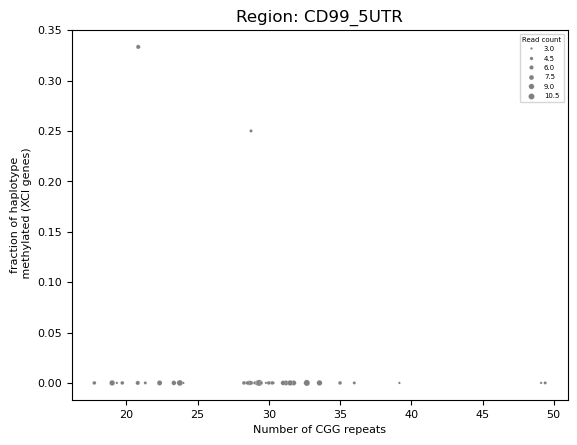

In [34]:
### plot fraction of heplotype methylated as a function of CGG repeat for select genes
df_methyl_plt = df_methyl_og.loc[(df_methyl_og.sex=='Female')].copy()
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_methyl_reads_h1!='.') | (df_methyl_plt.num_methyl_reads_h2!='.')]
df_methyl_plt['num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) if row.num_methyl_reads_h2!='.' else 0, axis=1)
#df_methyl_plt['xci_num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h1) + int(row.xci_num_unmethyl_reads_h1) if row.xci_num_methyl_reads_h1!='.' else 0, axis=1)
#df_methyl_plt['xci_num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h2) + int(row.xci_num_unmethyl_reads_h2) if row.xci_num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_reads_h1>=3) | (df_methyl_plt.num_reads_h2>=3)]

#pd.set_option('display.max_columns', None)
#print('df_methyl_plt:')
#display(df_methyl_plt)
#pd.set_option('display.max_columns', 10)

df_plt = pd.DataFrame()
for idx, row in df_methyl_plt.iterrows():
    sample = idx
    for hp in ['h1', 'h2']:
        if row[f'num_reads_{hp}'] >= 3 and row[f'num_fmr1_reads_{hp}']!='.' and row[f'num_fmr1_reads_{hp}'] >= 3:
            mean_rep = row[f'cgg_repeat_len_{hp}']
            frac_hap = row[f'frac_hap_methyl_{hp}']
            #xci_frac_hap = row[f'xci_frac_hap_methyl_{hp}']
            num_reads = row[f'num_reads_{hp}']
            #xci_num_reads = row[f'xci_num_reads_{hp}']
            #rep_group = row['repeat_group']
            #df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
            #                       f'xci_frac_hap_methyl': [xci_frac_hap], f'num_reads': [num_reads], f'xci_num_reads': [xci_num_reads], f'repeat_group': [rep_group]})
            df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
                                   f'num_reads': [num_reads]})
            df_plt = pd.concat([df_plt, df_tmp], ignore_index=True)

cols = ['mean_repeat_length', 'frac_hap_methyl', 'num_reads']
for col in cols:
    df_plt[col] = df_plt[col].astype(float)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print('df_plt:')
display(df_plt)
print('df_plt, mean repeat > 45:')
display(df_plt.loc[(df_plt.mean_repeat_length >45) | (df_plt.mean_repeat_length >45)])
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

FS = 8
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', size='num_reads', sizes=(3,20), color='gray') # sizes gets a min max tuple interpreted by "size" hue='subject',
#hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'] , legend='brief'
#**sb.regplot(data=df_plt, x='mean_repeat_length', y='xci_frac_hap_methyl', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Read count', loc='upper right', bbox_to_anchor=(1, 1), fontsize=FS-3, title_fontsize=FS-3) #handles=plt.gca().legend_.legend_handles[num_subjects+2:], , handles=plt.gca().legend_.legend_handles[0:]

#**x_t = 18
#**y_t = 0.95
#**p = model_sm.pvalues['mean_repeat_length']
#**plt.text(x_t, y_t, f'p: {format_sci_notation(p)}', fontsize=FS-2, ha='left')
#plt.text(x_t, y_t-.1, f'r²: {r2:.2f}', fontsize=FS-2, ha='left')

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (XCI genes)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title(f'Region: {region_id}')
#fig_name = f'{dir_fig}/haplotype_readFrac_methylation_vs_repeats_XCI_fromTable.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

In [48]:
### you need to run the cell with df_exnd first
region_id = 'SRPX_5UTR'
df_methyl_og = get_gene_methyl_data(region_id, df_exnd)
#print('df_methyl_og:')
#display(df_methyl_og)

df_methyl_og['cgg_repeat_len_h1'] = df_methyl_og.index.map(df_methyl.mean_repeat_length_h1)
df_methyl_og['cgg_repeat_len_h2'] = df_methyl_og.index.map(df_methyl.mean_repeat_length_h2)
df_methyl_og['cgg_repeat_len_h0'] = df_methyl_og.index.map(df_methyl.mean_repeat_length_h0)
df_methyl_og['num_fmr1_methyl_reads_h1'] = df_methyl_og.index.map(df_methyl.num_methyl_reads_h1)
df_methyl_og['num_fmr1_unmethyl_reads_h1'] = df_methyl_og.index.map(df_methyl.num_unmethyl_reads_h1)
df_methyl_og['num_fmr1_methyl_reads_h2'] = df_methyl_og.index.map(df_methyl.num_methyl_reads_h2)
df_methyl_og['num_fmr1_unmethyl_reads_h2'] = df_methyl_og.index.map(df_methyl.num_unmethyl_reads_h2)
df_methyl_og['num_fmr1_reads_h1'] = df_methyl_og.apply(lambda row: np.sum([int(x) for x in [row.num_fmr1_methyl_reads_h1, 
                                                                                            row.num_fmr1_unmethyl_reads_h1] if x!='.']) 
                                                       if (row.num_fmr1_methyl_reads_h1!='.' or 
                                                           row.num_fmr1_unmethyl_reads_h1!='.') else '.', axis=1)
df_methyl_og['num_fmr1_reads_h2'] = df_methyl_og.apply(lambda row: np.sum([int(x) for x in [row.num_fmr1_methyl_reads_h2, 
                                                                                            row.num_fmr1_unmethyl_reads_h2] if x!='.']) 
                                                       if (row.num_fmr1_methyl_reads_h2!='.' or 
                                                           row.num_fmr1_unmethyl_reads_h2!='.') else '.', axis=1)
df_methyl_og['sex'] = df_methyl_og.index.map(df_methyl.sex)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
print('df_methyl_og:')
display(df_methyl_og)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

df_methyl_og:


methyl_h1  \
REACH000026                                                  .   
REACH000058                                                  .   
REACH000065                                                  .   
REACH000066                                                  .   
REACH000067                                                  .   
...                                                        ...   
REACH000681                                                  .   
REACH000682  2|0|99|81|61|95|100|63|99,0|2|2|6|0|1|0|0|0|0|...   
REACH000683                                                  .   
REACH000684                                                  .   
REACH000685                                                  .   

                                                     methyl_h2  \
REACH000026                                                  .   
REACH000058                                                  .   
REACH000065                                                  .   
REACH000066                                                  .   
REACH000067                                                  .   
...                                                        ...   
REACH000681                                                  .   
REACH000682  100|97|98|79|69|54|100|98,100|100|100|100|100|...   
REACH000683                                                  .   
REACH000684                                                  .   
REACH000685                                                  .   

                                                     methyl_h0  \
REACH000026                                                  .   
REACH000058  7|5|5|2|2|5|1|6|15|40|65,9|34|38|11|6|1|0|0|0|...   
REACH000065                              6|9|2|8|8|2|0|0|0|0|2   
REACH000066                                                  .   
REACH000067                                                  .   
...                                                        ...   
REACH000681            0|2|0|0|0|5|2|0|1|0,0|2|0|0|0|0|0|0|3|0   
REACH000682                           0|0|0|0|27|1|0|7|29|68|0   
REACH000683  0|88,0|0|14|5|2|0|0|1|92|41|5|21|3|0,0|0|0|0|1...   
REACH000684  0|0|0|0|0|0|0|1|1,4|2|2|0|0|0|0|0|0|3|2,1|0|0|...   
REACH000685  0|14|0|4|0|1|0|0|16|5|29|97|19|4|5,0|1|2|0|1|0...   

            read_mean_methyl_lik_h1 read_mean_methyl_lik_h2  \
REACH000026                       .                       .   
REACH000058                       .                       .   
REACH000065                       .                       .   
REACH000066                       .                       .   
REACH000067                       .                       .   
...                             ...                     ...   
REACH000681                       .                       .   
REACH000682               67,1,16,1           87,81,45,95,0   
REACH000683                       .                       .   
REACH000684                       .                       .   
REACH000685                       .                       .   

            read_mean_methyl_lik_h0 num_methyl_reads_h1 num_unmethyl_reads_h1  \
REACH000026                       .                   .                     .   
REACH000058             14,9,11,6,1                   .                     .   
REACH000065                       3                   .                     .   
REACH000066                       .                   .                     .   
REACH000067                       .                   .                     .   
...                             ...                 ...                   ...   
REACH000681                     1,0                   .                     .   
REACH000682                      12                   1                     3   
REACH000683        44,13,0,7,22,1,8                   .                     .   
REACH000684                   0,1,0                   .                     .   
REACH000685          13,0,

df_plt:


subject_id  mean_repeat_length  frac_hap_methyl  num_reads
0       REACH000092           29.800000         0.333333        6.0
1       REACH000093           29.250000         0.666667        3.0
2       REACH000234           29.333333         0.375000        8.0
3       REACH000234           30.600000         0.250000        4.0
4       REACH000316           29.000000         0.250000        4.0
5       REACH000365           30.166667         0.375000        8.0
6    REACH000436_PB           23.750000         0.333333        3.0
7    REACH000436_PB           29.833333         0.000000        4.0
8       REACH000451           28.800000         0.000000        3.0
9       REACH000451           49.400000         0.666667        3.0
10      REACH000453           31.200000         0.000000        4.0
11      REACH000453           49.400000         0.625000        8.0
12      REACH000616           29.200000         0.333333        6.0
13      REACH000616           29.800000         0.500000        4.0
14      REACH000620           39.166667         0.333333        9.0
15      REACH000628           29.200000         0.000000        4.0
16      REACH000641           31.000000         0.333333        3.0
17      REACH000702           29.333333         0.714286        7.0
18      REACH000702           30.250000         0.250000        4.0
19      REACH000727           31.000000         1.000000        4.0
20      REACH000107           28.750000         0.333333        3.0
21      REACH000107           28.333333         0.333333        3.0
22      REACH000155           31.333333         0.500000        6.0
23      REACH000401           17.750000         0.750000        8.0
24      REACH000404           28.750000         0.250000        4.0
25      REACH000404           19.714286         0.285714        7.0
26      REACH000409           31.000000         0.142857        7.0
27      REACH000417           23.333333         0.285714        7.0
28      REACH000417           28.800000         0.375000        8.0
29      REACH000418           32.000000         0.750000        4.0
30      REACH000418           28.625000         0.000000        6.0
31      REACH000435           28.714286         0.750000        4.0
32      REACH000435           21.333333         0.666667        6.0
33  REACH000436_ONT           20.800000         0.428571        7.0
34  REACH000436_ONT           28.000000         0.400000        5.0
35      REACH000477           29.666667         0.333333        3.0
36      REACH000479           36.000000         1.000000        6.0
37      REACH000479           22.333333         0.000000        8.0
38      REACH000482           33.555556         0.428571        7.0
39      REACH000482           19.000000         0.400000        5.0
40      REACH000510           30.666667         0.500000        4.0
41      REACH000510           28.750000         0.500000       10.0
42      REACH000518           35.000000         0.500000        6.0
43      REACH000518           29.444444         0.000000        3.0
44      REACH000519           35.000000         0.400000        5.0
45      REACH000519           20.833333         0.666667        3.0
46      REACH000523           20.833333         0.600000        5.0
47      REACH000541           29.500000         0.666667        3.0
48      REACH000547           28.000000         0.200000        5.0
49      REACH000547           33.750000         0.500000        6.0
50      REACH000556           26.500000         0.375000        8.0
51      REACH000561           28.250000         0.500000        4.0
52      REACH000561           49.111111         0.166667        6.0
53      REACH000565           30.000000         0.666667        6.0
54      REACH000565           32.000000         0.333333        6.0
55      REACH000578           28.400000         0.800000        5.0
56      REACH000578           26.000000         0.571429        7.0
57      REACH000579           28.500000         0.666667        3

df_plt, mean repeat >= 35:


subject_id  mean_repeat_length  frac_hap_methyl  num_reads
9   REACH000451           49.400000         0.666667        3.0
11  REACH000453           49.400000         0.625000        8.0
14  REACH000620           39.166667         0.333333        9.0
36  REACH000479           36.000000         1.000000        6.0
42  REACH000518           35.000000         0.500000        6.0
44  REACH000519           35.000000         0.400000        5.0
52  REACH000561           49.111111         0.166667        6.0

stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                   0.04186
Date:                Wed, 07 May 2025   Prob (F-statistic):              0.839
Time:                        16:20:18   Log-Likelihood:                 1.6090
No. Observations:                  64   AIC:                            0.7820
Df Residuals:                      62   BIC:                             5.100
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  

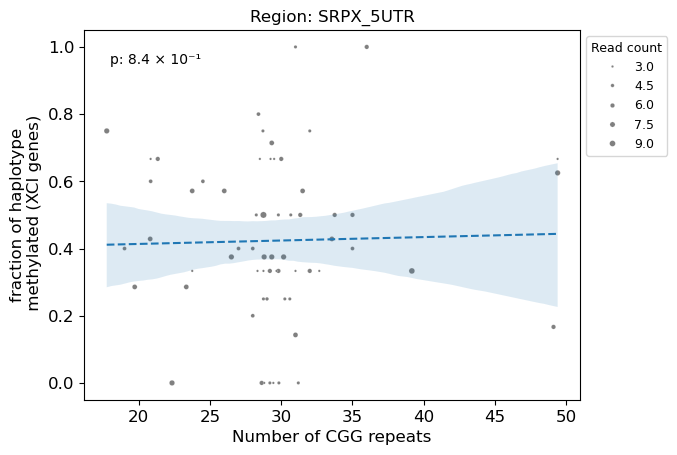

In [52]:
### plot fraction of heplotype methylated as a function of CGG repeat for select genes
df_methyl_plt = df_methyl_og.loc[(df_methyl_og.sex=='Female')].copy()
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_methyl_reads_h1!='.') | (df_methyl_plt.num_methyl_reads_h2!='.')]
df_methyl_plt['num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) if row.num_methyl_reads_h2!='.' else 0, axis=1)
#df_methyl_plt['xci_num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h1) + int(row.xci_num_unmethyl_reads_h1) if row.xci_num_methyl_reads_h1!='.' else 0, axis=1)
#df_methyl_plt['xci_num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h2) + int(row.xci_num_unmethyl_reads_h2) if row.xci_num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_reads_h1>=3) | (df_methyl_plt.num_reads_h2>=3)]

#pd.set_option('display.max_columns', None)
#print('df_methyl_plt:')
#display(df_methyl_plt)
#pd.set_option('display.max_columns', 10)

df_plt = pd.DataFrame()
for idx, row in df_methyl_plt.iterrows():
    sample = idx
    for hp in ['h1', 'h2']:
        if row[f'num_reads_{hp}'] >= 3 and row[f'num_fmr1_reads_{hp}']!='.' and row[f'num_fmr1_reads_{hp}'] >= 2:
            mean_rep = row[f'cgg_repeat_len_{hp}']
            frac_hap = row[f'frac_hap_methyl_{hp}']
            #xci_frac_hap = row[f'xci_frac_hap_methyl_{hp}']
            num_reads = row[f'num_reads_{hp}']
            #xci_num_reads = row[f'xci_num_reads_{hp}']
            #rep_group = row['repeat_group']
            #df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
            #                       f'xci_frac_hap_methyl': [xci_frac_hap], f'num_reads': [num_reads], f'xci_num_reads': [xci_num_reads], f'repeat_group': [rep_group]})
            df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
                                   f'num_reads': [num_reads]})
            df_plt = pd.concat([df_plt, df_tmp], ignore_index=True)

cols = ['mean_repeat_length', 'frac_hap_methyl', 'num_reads']
for col in cols:
    df_plt[col] = df_plt[col].astype(float)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print('df_plt:')
display(df_plt)
print('df_plt, mean repeat >= 35:')
display(df_plt.loc[(df_plt.mean_repeat_length >=35)])
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

#**x = np.array(df_plt.mean_repeat_length.tolist()).reshape(-1, 1) # Reshape for sklearn
#**y = np.array(df_plt.xci_frac_hap_methyl.tolist())
#**model = LinearRegression()
#**model.fit(x, y)
#**y_pred = model.predict(x)
#plt.plot(x, y_pred, '-ok', label='Regression Line')
# Get weights (coefficients) and intercept
#**print('Scikit learn LR model:')
#**print("Coefficients:", model.coef_)  # Slope
#**print("Intercept:", model.intercept_)  # Intercept

X = pd.DataFrame(df_plt.mean_repeat_length)
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_plt.frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

FS = 12
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', size='num_reads', sizes=(3,20), color='gray') # sizes gets a min max tuple interpreted by "size" hue='subject',
#hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'] , legend='brief'
sb.regplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Read count', loc='upper left', bbox_to_anchor=(1, 1), fontsize=FS-3, title_fontsize=FS-3) #handles=plt.gca().legend_.legend_handles[num_subjects+2:], , handles=plt.gca().legend_.legend_handles[0:]

x_t = 18
y_t = 0.95
p = model_sm.pvalues['mean_repeat_length']
plt.text(x_t, y_t, f'p: {format_sci_notation(p)}', fontsize=FS-2, ha='left')
#plt.text(x_t, y_t-.1, f'r²: {r2:.2f}', fontsize=FS-2, ha='left')

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (XCI genes)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title(f'Region: {region_id}')
#fig_name = f'{dir_fig}/haplotype_readFrac_methylation_vs_repeats_XCI_fromTable.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

In [53]:
### you need to run the cell with df_exnd first
region_id = 'TCEAL6_5UTR'
df_methyl_og = get_gene_methyl_data(region_id, df_exnd)
#print('df_methyl_og:')
#display(df_methyl_og)

df_methyl_og['cgg_repeat_len_h1'] = df_methyl_og.index.map(df_methyl.mean_repeat_length_h1)
df_methyl_og['cgg_repeat_len_h2'] = df_methyl_og.index.map(df_methyl.mean_repeat_length_h2)
df_methyl_og['cgg_repeat_len_h0'] = df_methyl_og.index.map(df_methyl.mean_repeat_length_h0)
df_methyl_og['num_fmr1_methyl_reads_h1'] = df_methyl_og.index.map(df_methyl.num_methyl_reads_h1)
df_methyl_og['num_fmr1_unmethyl_reads_h1'] = df_methyl_og.index.map(df_methyl.num_unmethyl_reads_h1)
df_methyl_og['num_fmr1_methyl_reads_h2'] = df_methyl_og.index.map(df_methyl.num_methyl_reads_h2)
df_methyl_og['num_fmr1_unmethyl_reads_h2'] = df_methyl_og.index.map(df_methyl.num_unmethyl_reads_h2)
df_methyl_og['num_fmr1_reads_h1'] = df_methyl_og.apply(lambda row: np.sum([int(x) for x in [row.num_fmr1_methyl_reads_h1, 
                                                                                            row.num_fmr1_unmethyl_reads_h1] if x!='.']) 
                                                       if (row.num_fmr1_methyl_reads_h1!='.' or 
                                                           row.num_fmr1_unmethyl_reads_h1!='.') else '.', axis=1)
df_methyl_og['num_fmr1_reads_h2'] = df_methyl_og.apply(lambda row: np.sum([int(x) for x in [row.num_fmr1_methyl_reads_h2, 
                                                                                            row.num_fmr1_unmethyl_reads_h2] if x!='.']) 
                                                       if (row.num_fmr1_methyl_reads_h2!='.' or 
                                                           row.num_fmr1_unmethyl_reads_h2!='.') else '.', axis=1)
df_methyl_og['sex'] = df_methyl_og.index.map(df_methyl.sex)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
print('df_methyl_og:')
display(df_methyl_og)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

df_methyl_og:


methyl_h1  \
REACH000026                                                  .   
REACH000058                                                  .   
REACH000065                                                  .   
REACH000066                                                  .   
REACH000067                                                  .   
...                                                        ...   
REACH000681                                                  .   
REACH000682  0|0|0|96|86|0|0|0|0|0|0|0|0|0|0|50|1|1,8|1|2|6...   
REACH000683                                                  .   
REACH000684                                                  .   
REACH000685                                                  .   

                                                     methyl_h2  \
REACH000026                                                  .   
REACH000058                                                  .   
REACH000065                                                  .   
REACH000066                                                  .   
REACH000067                                                  .   
...                                                        ...   
REACH000681                                                  .   
REACH000682  0|0|1|20|0|80|75|0|1|7,100|100|2|6|2|0|1|10|0|...   
REACH000683                                                  .   
REACH000684                                                  .   
REACH000685                                                  .   

                                                     methyl_h0  \
REACH000026                                                  .   
REACH000058               0|1|3|19|6|4|4|0|0|0|0|0|0|0|0|0|0|1   
REACH000065  5|3|18|15|44|76|75|85|69|87|95|97|77|63|64|56|...   
REACH000066  54|60|89|97|98|96|98|93|92|93|95|99|100|100|10...   
REACH000067       0|4|5|1|4|7|13|31|26|45|16|18|6|7|8|38|73|88   
...                                                        ...   
REACH000681  12|0|0|0|18|3|0|0|0|0|0|0|0|0|4|0|0|0,18|1|0|1...   
REACH000682  100|100|100|90|100|100|100|0|0|100|100|100|0|1...   
REACH000683  4|4|77|93|12|34|0|17|2|61|14|1|47|2|0|2|31|7,0...   
REACH000684  7|2|2|0|1|0|0|0|0|0|1|1|0|1|0|1|4|0,16|12|0|25...   
REACH000685  6|0|0|2|0|0|0|0|0|0|0|0|0|0|3|0,13|0|9|0|3|0|0...   

            read_mean_methyl_lik_h1 read_mean_methyl_lik_h2  \
REACH000026                       .                       .   
REACH000058                       .                       .   
REACH000065                       .                       .   
REACH000066                       .                       .   
REACH000067                       .                       .   
...                             ...                     ...   
REACH000681                       .                       .   
REACH000682                    13,2                   18,20   
REACH000683                       .                       .   
REACH000684                       .                       .   
REACH000685                       .                       .   

            read_mean_methyl_lik_h0 num_methyl_reads_h1 num_unmethyl_reads_h1  \
REACH000026                       .                   .                     .   
REACH000058                       2                   .                     .   
REACH000065                      55                   .                     .   
REACH000066                      92                   .                     .   
REACH000067                      22                   .                     .   
...                             ...                 ...                   ...   
REACH000681      2,6,37,27,16,18,19                   .                     .   
REACH000682        79,9,13,63,71,49                   0                     2   
REACH000683                  23,6,9                   .                     .   
REACH000684                     1,5                   .                     .   
REACH000685            1,3

df_plt:


subject_id  mean_repeat_length  frac_hap_methyl  num_reads
0       REACH000220           29.000000         0.800000        5.0
1       REACH000234           29.333333         0.800000        5.0
2       REACH000234           30.600000         0.000000        4.0
3       REACH000289           30.000000         0.333333        6.0
4       REACH000314           31.000000         0.571429        7.0
5    REACH000436_PB           23.750000         0.333333        6.0
6    REACH000436_PB           29.833333         0.750000        4.0
7       REACH000451           28.800000         0.600000        5.0
8       REACH000451           49.400000         0.666667        3.0
9       REACH000453           31.200000         0.285714        7.0
10      REACH000453           49.400000         0.000000        3.0
11   REACH000530_PB           31.500000         0.000000        6.0
12      REACH000616           29.200000         0.250000        8.0
13      REACH000628           29.200000         0.666667        3.0
14      REACH000672           30.000000         0.500000        4.0
15      REACH000674           30.000000         0.000000        3.0
16      REACH000674           30.333333         0.666667        6.0
17      REACH000702           29.333333         0.000000        6.0
18      REACH000755           24.000000         1.000000        3.0
19      REACH000404           28.750000         0.000000        4.0
20      REACH000404           19.714286         0.250000        4.0
21      REACH000409           31.000000         0.250000       12.0
22      REACH000417           23.333333         0.416667       12.0
23      REACH000417           28.800000         0.777778        9.0
24      REACH000418           32.000000         0.800000        5.0
25      REACH000418           28.625000         0.111111        9.0
26      REACH000420           19.333333         0.125000        8.0
27      REACH000424           28.500000         0.555556        9.0
28      REACH000435           21.333333         0.200000        5.0
29  REACH000436_ONT           28.000000         0.333333        3.0
30      REACH000479           36.000000         1.000000       11.0
31      REACH000479           22.333333         0.090909       11.0
32      REACH000482           33.555556         0.636364       11.0
33      REACH000482           19.000000         0.400000       10.0
34      REACH000510           30.666667         0.500000        6.0
35      REACH000510           28.750000         0.333333        6.0
36      REACH000513           28.750000         0.166667        6.0
37      REACH000518           35.000000         0.750000        4.0
38      REACH000518           29.444444         0.500000        4.0
39      REACH000519           35.000000         0.250000        4.0
40      REACH000519           20.833333         0.500000        4.0
41      REACH000523           20.833333         0.200000        5.0
42      REACH000523           29.444444         0.500000        4.0
43      REACH000541           29.500000         0.857143        7.0
44      REACH000556           26.500000         0.250000        8.0
45      REACH000561           28.250000         1.000000        3.0
46      REACH000561           49.111111         0.666667        3.0
47      REACH000563           26.375000         0.800000        5.0
48      REACH000563           49.111111         0.400000        5.0
49      REACH000565           30.000000         0.333333        3.0
50      REACH000567           31.750000         0.500000        4.0
51      REACH000578           28.400000         0.000000        3.0
52      REACH000578           26.000000         0.666667        3.0
53      REACH000579           32.500000         0.250000        4.0
54      REACH000579           28.500000         0.000000        3.0
55      REACH000581           31.500000         0.428571        7.0
56      REACH000581           23.750000         0.142857        7.0

df_plt, mean repeat >= 35:


subject_id  mean_repeat_length  frac_hap_methyl  num_reads
8   REACH000451           49.400000         0.666667        3.0
10  REACH000453           49.400000         0.000000        3.0
30  REACH000479           36.000000         1.000000       11.0
37  REACH000518           35.000000         0.750000        4.0
39  REACH000519           35.000000         0.250000        4.0
46  REACH000561           49.111111         0.666667        3.0
48  REACH000563           49.111111         0.400000        5.0

stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8954
Date:                Wed, 07 May 2025   Prob (F-statistic):              0.348
Time:                        16:22:27   Log-Likelihood:                -9.6326
No. Observations:                  57   AIC:                             23.27
Df Residuals:                      55   BIC:                             27.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  

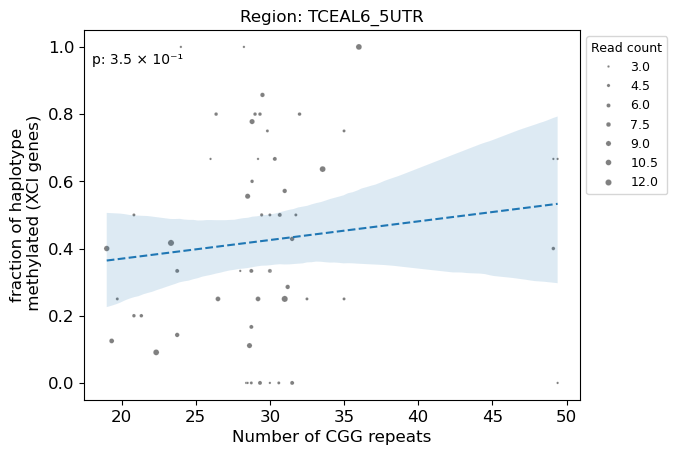

In [54]:
### plot fraction of heplotype methylated as a function of CGG repeat for select genes
df_methyl_plt = df_methyl_og.loc[(df_methyl_og.sex=='Female')].copy()
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_methyl_reads_h1!='.') | (df_methyl_plt.num_methyl_reads_h2!='.')]
df_methyl_plt['num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) if row.num_methyl_reads_h2!='.' else 0, axis=1)
#df_methyl_plt['xci_num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h1) + int(row.xci_num_unmethyl_reads_h1) if row.xci_num_methyl_reads_h1!='.' else 0, axis=1)
#df_methyl_plt['xci_num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h2) + int(row.xci_num_unmethyl_reads_h2) if row.xci_num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_reads_h1>=3) | (df_methyl_plt.num_reads_h2>=3)]

#pd.set_option('display.max_columns', None)
#print('df_methyl_plt:')
#display(df_methyl_plt)
#pd.set_option('display.max_columns', 10)

df_plt = pd.DataFrame()
for idx, row in df_methyl_plt.iterrows():
    sample = idx
    for hp in ['h1', 'h2']:
        if row[f'num_reads_{hp}'] >= 3 and row[f'num_fmr1_reads_{hp}']!='.' and row[f'num_fmr1_reads_{hp}'] >= 2:
            mean_rep = row[f'cgg_repeat_len_{hp}']
            frac_hap = row[f'frac_hap_methyl_{hp}']
            #xci_frac_hap = row[f'xci_frac_hap_methyl_{hp}']
            num_reads = row[f'num_reads_{hp}']
            #xci_num_reads = row[f'xci_num_reads_{hp}']
            #rep_group = row['repeat_group']
            #df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
            #                       f'xci_frac_hap_methyl': [xci_frac_hap], f'num_reads': [num_reads], f'xci_num_reads': [xci_num_reads], f'repeat_group': [rep_group]})
            df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
                                   f'num_reads': [num_reads]})
            df_plt = pd.concat([df_plt, df_tmp], ignore_index=True)

cols = ['mean_repeat_length', 'frac_hap_methyl', 'num_reads']
for col in cols:
    df_plt[col] = df_plt[col].astype(float)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print('df_plt:')
display(df_plt)
print('df_plt, mean repeat >= 35:')
display(df_plt.loc[(df_plt.mean_repeat_length >=35)])
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

#**x = np.array(df_plt.mean_repeat_length.tolist()).reshape(-1, 1) # Reshape for sklearn
#**y = np.array(df_plt.xci_frac_hap_methyl.tolist())
#**model = LinearRegression()
#**model.fit(x, y)
#**y_pred = model.predict(x)
#plt.plot(x, y_pred, '-ok', label='Regression Line')
# Get weights (coefficients) and intercept
#**print('Scikit learn LR model:')
#**print("Coefficients:", model.coef_)  # Slope
#**print("Intercept:", model.intercept_)  # Intercept

X = pd.DataFrame(df_plt.mean_repeat_length)
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_plt.frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

FS = 12
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', size='num_reads', sizes=(3,20), color='gray') # sizes gets a min max tuple interpreted by "size" hue='subject',
#hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'] , legend='brief'
sb.regplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Read count', loc='upper left', bbox_to_anchor=(1, 1), fontsize=FS-3, title_fontsize=FS-3) #handles=plt.gca().legend_.legend_handles[num_subjects+2:], , handles=plt.gca().legend_.legend_handles[0:]

x_t = 18
y_t = 0.95
p = model_sm.pvalues['mean_repeat_length']
plt.text(x_t, y_t, f'p: {format_sci_notation(p)}', fontsize=FS-2, ha='left')
#plt.text(x_t, y_t-.1, f'r²: {r2:.2f}', fontsize=FS-2, ha='left')

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (XCI genes)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title(f'Region: {region_id}')
#fig_name = f'{dir_fig}/haplotype_readFrac_methylation_vs_repeats_XCI_fromTable.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

In [55]:
### you need to run the cell with df_exnd first
region_id = 'SOWAHD_5UTR'
df_methyl_og = get_gene_methyl_data(region_id, df_exnd)
#print('df_methyl_og:')
#display(df_methyl_og)

df_methyl_og['cgg_repeat_len_h1'] = df_methyl_og.index.map(df_methyl.mean_repeat_length_h1)
df_methyl_og['cgg_repeat_len_h2'] = df_methyl_og.index.map(df_methyl.mean_repeat_length_h2)
df_methyl_og['cgg_repeat_len_h0'] = df_methyl_og.index.map(df_methyl.mean_repeat_length_h0)
df_methyl_og['num_fmr1_methyl_reads_h1'] = df_methyl_og.index.map(df_methyl.num_methyl_reads_h1)
df_methyl_og['num_fmr1_unmethyl_reads_h1'] = df_methyl_og.index.map(df_methyl.num_unmethyl_reads_h1)
df_methyl_og['num_fmr1_methyl_reads_h2'] = df_methyl_og.index.map(df_methyl.num_methyl_reads_h2)
df_methyl_og['num_fmr1_unmethyl_reads_h2'] = df_methyl_og.index.map(df_methyl.num_unmethyl_reads_h2)
df_methyl_og['num_fmr1_reads_h1'] = df_methyl_og.apply(lambda row: np.sum([int(x) for x in [row.num_fmr1_methyl_reads_h1, 
                                                                                            row.num_fmr1_unmethyl_reads_h1] if x!='.']) 
                                                       if (row.num_fmr1_methyl_reads_h1!='.' or 
                                                           row.num_fmr1_unmethyl_reads_h1!='.') else '.', axis=1)
df_methyl_og['num_fmr1_reads_h2'] = df_methyl_og.apply(lambda row: np.sum([int(x) for x in [row.num_fmr1_methyl_reads_h2, 
                                                                                            row.num_fmr1_unmethyl_reads_h2] if x!='.']) 
                                                       if (row.num_fmr1_methyl_reads_h2!='.' or 
                                                           row.num_fmr1_unmethyl_reads_h2!='.') else '.', axis=1)
df_methyl_og['sex'] = df_methyl_og.index.map(df_methyl.sex)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
print('df_methyl_og:')
display(df_methyl_og)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

df_methyl_og:


methyl_h1  \
REACH000026                                                  .   
REACH000058                                                  .   
REACH000065                                                  .   
REACH000066                                                  .   
REACH000067                                                  .   
...                                                        ...   
REACH000681                                                  .   
REACH000682  0|24|0|22|0|0,1|2|0|0|0|0,61|0|100|0|0|0,2|1|8...   
REACH000683                                                  .   
REACH000684                                                  .   
REACH000685                                                  .   

                                                     methyl_h2  \
REACH000026                                                  .   
REACH000058                                                  .   
REACH000065                                                  .   
REACH000066                                                  .   
REACH000067                                                  .   
...                                                        ...   
REACH000681                                                  .   
REACH000682  95|100|99|0|100|100|98|100,0|0|0|2|26|24,0|42|...   
REACH000683                                                  .   
REACH000684                                                  .   
REACH000685                                                  .   

                                                     methyl_h0  \
REACH000026                                                  .   
REACH000058  0|0|0|0|0|0|0,0|0|0|0|0|0|0,10|1|0|0|0|0|0,0|0...   
REACH000065                                                  .   
REACH000066  8|12|9|11|3|0|0,2|4|13|5|2|8|52,13|21|10|5|5|3...   
REACH000067                                      0|0|0|1|0|4|1   
...                                                        ...   
REACH000681  18|27|0|0|2,98|0|1|92|5|2,0|0|18|0|0,83|6|2|2|...   
REACH000682                                   100|9|7|68|99|71   
REACH000683                                     12|2|0|0|0|0|0   
REACH000684  0|0|0|0|0,2|4|4|3|5|0|0|0|66|0,1|4|5|0|0|0|0|0...   
REACH000685  100|95|5|0,57|40|42|28|25|15|94|99,0|0|14|0|0|...   

            read_mean_methyl_lik_h1 read_mean_methyl_lik_h2  \
REACH000026                       .                       .   
REACH000058                       .                       .   
REACH000065                       .                       .   
REACH000066                       .                       .   
REACH000067                       .                       .   
...                             ...                     ...   
REACH000681                       .                       .   
REACH000682           8,0,27,30,7,1                 86,9,14   
REACH000683                       .                       .   
REACH000684                       .                       .   
REACH000685                       .                       .   

            read_mean_methyl_lik_h0 num_methyl_reads_h1 num_unmethyl_reads_h1  \
REACH000026                       .                   .                     .   
REACH000058                 0,0,2,0                   .                     .   
REACH000065                       .                   .                     .   
REACH000066                 6,12,23                   .                     .   
REACH000067                       1                   .                     .   
...                             ...                 ...                   ...   
REACH000681            9,33,4,14,16                   .                     .   
REACH000682                      59                   0                     6   
REACH000683                       2                   .                     .   
REACH000684              0,8,1,18,5                   .                     .   
REACH000685               

df_plt:


subject_id  mean_repeat_length  frac_hap_methyl  num_reads
0       REACH000234           29.333333         0.250000        4.0
1       REACH000234           30.600000         0.333333        3.0
2       REACH000314           29.500000         0.200000        5.0
3       REACH000365           30.166667         0.000000        3.0
4       REACH000365           29.250000         0.800000        5.0
5    REACH000436_PB           23.750000         0.333333        3.0
6       REACH000451           49.400000         0.500000        6.0
7       REACH000453           31.200000         0.333333        3.0
8       REACH000453           49.400000         0.800000        5.0
9    REACH000530_PB           31.500000         0.000000        3.0
10      REACH000628           29.200000         0.000000        3.0
11      REACH000674           30.000000         0.250000        4.0
12      REACH000702           29.333333         0.666667       21.0
13      REACH000702           30.250000         0.000000        6.0
14      REACH000727           31.000000         0.666667        3.0
15      REACH000107           28.750000         0.500000        4.0
16      REACH000401           17.750000         0.333333        3.0
17      REACH000404           28.750000         0.333333        6.0
18      REACH000404           19.714286         0.400000        5.0
19      REACH000409           31.000000         0.400000        5.0
20      REACH000417           23.333333         0.333333        3.0
21      REACH000417           28.800000         0.600000        5.0
22      REACH000418           32.000000         0.500000        4.0
23      REACH000418           28.625000         0.000000        4.0
24  REACH000436_ONT           28.000000         0.666667        3.0
25      REACH000479           36.000000         0.777778        9.0
26      REACH000479           22.333333         0.000000        6.0
27      REACH000482           33.555556         0.333333        6.0
28      REACH000482           19.000000         0.428571        7.0
29      REACH000510           30.666667         0.714286        7.0
30      REACH000510           28.750000         0.333333        3.0
31      REACH000513           28.750000         0.333333        3.0
32      REACH000518           35.000000         0.800000        5.0
33      REACH000518           29.444444         0.400000        5.0
34      REACH000519           35.000000         0.750000        4.0
35      REACH000519           20.833333         0.500000        4.0
36      REACH000523           20.833333         0.400000        5.0
37      REACH000523           29.444444         0.333333        6.0
38      REACH000541           29.500000         0.500000        6.0
39      REACH000547           33.750000         0.500000        4.0
40      REACH000556           26.500000         0.400000        5.0
41      REACH000561           28.250000         0.400000        5.0
42      REACH000561           49.111111         0.333333        6.0
43      REACH000563           26.375000         0.000000        4.0
44      REACH000563           49.111111         0.600000        5.0
45      REACH000565           30.000000         0.500000        6.0
46      REACH000565           32.000000         0.428571        7.0
47      REACH000578           28.400000         0.125000        8.0
48      REACH000578           26.000000         0.142857        7.0
49      REACH000579           32.500000         0.000000        4.0
50      REACH000579           28.500000         0.333333        3.0
51      REACH000581           31.500000         0.200000        5.0
52      REACH000581           23.750000         0.333333       15.0
53      REACH000660           28.000000         0.428571        7.0
54      REACH000661           27.000000         0.000000        6.0
55      REACH000661           32.666667         0.250000        4.0
56      REACH000682           29.000000         0.000000        6.0
57      REACH000682           24.500000         0.333333        3

df_plt, mean repeat >= 35:


subject_id  mean_repeat_length  frac_hap_methyl  num_reads
6   REACH000451           49.400000         0.500000        6.0
8   REACH000453           49.400000         0.800000        5.0
25  REACH000479           36.000000         0.777778        9.0
32  REACH000518           35.000000         0.800000        5.0
34  REACH000519           35.000000         0.750000        4.0
42  REACH000561           49.111111         0.333333        6.0
44  REACH000563           49.111111         0.600000        5.0

stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     5.114
Date:                Wed, 07 May 2025   Prob (F-statistic):             0.0276
Time:                        16:23:17   Log-Likelihood:                 5.3084
No. Observations:                  58   AIC:                            -6.617
Df Residuals:                      56   BIC:                            -2.496
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  

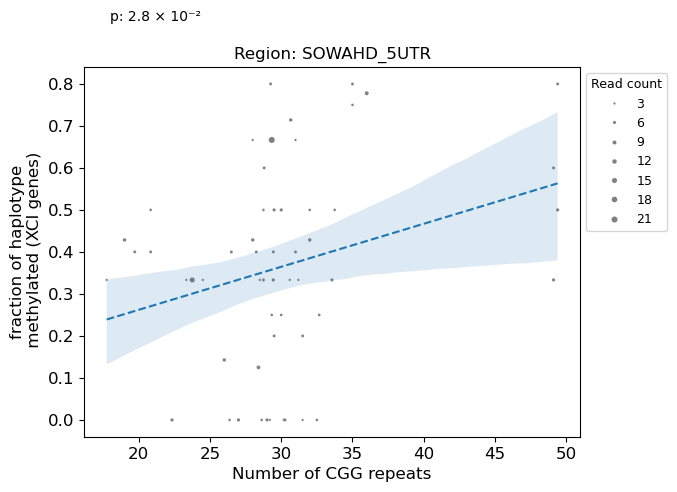

In [56]:
### plot fraction of heplotype methylated as a function of CGG repeat for select genes
df_methyl_plt = df_methyl_og.loc[(df_methyl_og.sex=='Female')].copy()
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_methyl_reads_h1!='.') | (df_methyl_plt.num_methyl_reads_h2!='.')]
df_methyl_plt['num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) if row.num_methyl_reads_h2!='.' else 0, axis=1)
#df_methyl_plt['xci_num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h1) + int(row.xci_num_unmethyl_reads_h1) if row.xci_num_methyl_reads_h1!='.' else 0, axis=1)
#df_methyl_plt['xci_num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h2) + int(row.xci_num_unmethyl_reads_h2) if row.xci_num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_reads_h1>=3) | (df_methyl_plt.num_reads_h2>=3)]

#pd.set_option('display.max_columns', None)
#print('df_methyl_plt:')
#display(df_methyl_plt)
#pd.set_option('display.max_columns', 10)

df_plt = pd.DataFrame()
for idx, row in df_methyl_plt.iterrows():
    sample = idx
    for hp in ['h1', 'h2']:
        if row[f'num_reads_{hp}'] >= 3 and row[f'num_fmr1_reads_{hp}']!='.' and row[f'num_fmr1_reads_{hp}'] >= 2:
            mean_rep = row[f'cgg_repeat_len_{hp}']
            frac_hap = row[f'frac_hap_methyl_{hp}']
            #xci_frac_hap = row[f'xci_frac_hap_methyl_{hp}']
            num_reads = row[f'num_reads_{hp}']
            #xci_num_reads = row[f'xci_num_reads_{hp}']
            #rep_group = row['repeat_group']
            #df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
            #                       f'xci_frac_hap_methyl': [xci_frac_hap], f'num_reads': [num_reads], f'xci_num_reads': [xci_num_reads], f'repeat_group': [rep_group]})
            df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
                                   f'num_reads': [num_reads]})
            df_plt = pd.concat([df_plt, df_tmp], ignore_index=True)

cols = ['mean_repeat_length', 'frac_hap_methyl', 'num_reads']
for col in cols:
    df_plt[col] = df_plt[col].astype(float)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print('df_plt:')
display(df_plt)
print('df_plt, mean repeat >= 35:')
display(df_plt.loc[(df_plt.mean_repeat_length >=35)])
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

#**x = np.array(df_plt.mean_repeat_length.tolist()).reshape(-1, 1) # Reshape for sklearn
#**y = np.array(df_plt.xci_frac_hap_methyl.tolist())
#**model = LinearRegression()
#**model.fit(x, y)
#**y_pred = model.predict(x)
#plt.plot(x, y_pred, '-ok', label='Regression Line')
# Get weights (coefficients) and intercept
#**print('Scikit learn LR model:')
#**print("Coefficients:", model.coef_)  # Slope
#**print("Intercept:", model.intercept_)  # Intercept

X = pd.DataFrame(df_plt.mean_repeat_length)
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_plt.frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

FS = 12
plt.figure()#figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', size='num_reads', sizes=(3,20), color='gray') # sizes gets a min max tuple interpreted by "size" hue='subject',
#hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'] , legend='brief'
sb.regplot(data=df_plt, x='mean_repeat_length', y='frac_hap_methyl', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Read count', loc='upper left', bbox_to_anchor=(1, 1), fontsize=FS-3, title_fontsize=FS-3) #handles=plt.gca().legend_.legend_handles[num_subjects+2:], , handles=plt.gca().legend_.legend_handles[0:]

x_t = 18
y_t = 0.95
p = model_sm.pvalues['mean_repeat_length']
plt.text(x_t, y_t, f'p: {format_sci_notation(p)}', fontsize=FS-2, ha='left')
#plt.text(x_t, y_t-.1, f'r²: {r2:.2f}', fontsize=FS-2, ha='left')

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (XCI genes)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.title(f'Region: {region_id}')
#fig_name = f'{dir_fig}/haplotype_readFrac_methylation_vs_repeats_XCI_fromTable.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

In [13]:
### plot fraction of heplotype methylated as a function of XCI methylation
### get_here
df_methyl_plt = df_methyl.loc[(df_methyl.sex=='Female')].copy()
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.num_methyl_reads_h1!='.') | (df_methyl_plt.num_methyl_reads_h2!='.')]
df_methyl_plt['num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h1) + int(row.num_unmethyl_reads_h1) if row.num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.num_methyl_reads_h2) + int(row.num_unmethyl_reads_h2) if row.num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt['xci_num_reads_h1'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h1) + int(row.xci_num_unmethyl_reads_h1) if row.xci_num_methyl_reads_h1!='.' else 0, axis=1)
df_methyl_plt['xci_num_reads_h2'] = df_methyl_plt.apply(lambda row: int(row.xci_num_methyl_reads_h2) + int(row.xci_num_unmethyl_reads_h2) if row.xci_num_methyl_reads_h2!='.' else 0, axis=1)
df_methyl_plt = df_methyl_plt.loc[(df_methyl_plt.xci_num_reads_h1>=3) | (df_methyl_plt.xci_num_reads_h2>=3)]

df_plt = pd.DataFrame()
for idx, row in df_methyl_plt.iterrows():
    sample = idx
    for hp in ['h1', 'h2']:
        if row[f'xci_num_reads_{hp}'] >= 3:
            mean_rep = row[f'mean_repeat_length_{hp}']
            frac_hap = row[f'frac_hap_methyl_{hp}']
            xci_frac_hap = row[f'xci_frac_hap_methyl_{hp}']
            num_reads = row[f'num_reads_{hp}']
            xci_num_reads = row[f'xci_num_reads_{hp}']
            rep_group = row['repeat_group']
            df_tmp = pd.DataFrame({'subject_id': [idx], f'mean_repeat_length': [mean_rep], f'frac_hap_methyl': [frac_hap], 
                                   f'xci_frac_hap_methyl': [xci_frac_hap], f'num_reads': [num_reads], f'xci_num_reads': [xci_num_reads], f'repeat_group': [rep_group]})
            df_plt = pd.concat([df_plt, df_tmp], ignore_index=True)

### also get rid of the haplotypes where mean number of CGG repeats are missing
df_plt = df_plt.loc[df_plt.mean_repeat_length!='.']

cols = ['mean_repeat_length', 'xci_frac_hap_methyl', 'xci_num_reads']
for col in cols:
    df_plt[col] = df_plt[col].astype(float)

def get_rep_group2(row):
    if row.repeat_group != '.':
        out = row.repeat_group
    else:
        out = ('≥35 CGG' if (row.mean_repeat_length >= 35) else 
               ('≤25 CGG' if (row.mean_repeat_length <= 25) else '26-34 CGG'))
    return out
df_plt['repeat_group'] = df_plt.apply(lambda row: get_rep_group2(row), axis=1)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print('df_plt:')
display(df_plt)
print('df_plt, mean repeat > 45:')
display(df_plt.loc[(df_plt.mean_repeat_length >45) | (df_plt.mean_repeat_length >45)])
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

x = np.array(df_plt.mean_repeat_length.tolist()).reshape(-1, 1) # Reshape for sklearn
y = np.array(df_plt.xci_frac_hap_methyl.tolist())
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
#plt.plot(x, y_pred, '-ok', label='Regression Line')
# Get weights (coefficients) and intercept
print('Scikit learn LR model:')
print("Coefficients:", model.coef_)  # Slope
print("Intercept:", model.intercept_)  # Intercept

X = pd.DataFrame(df_plt.mean_repeat_length)
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_plt.xci_frac_hap_methyl.tolist())
model_sm = sm.OLS(y, X_const).fit()
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

FS = 8
plt.figure(figsize=(2.5, 2))
sb.scatterplot(data=df_plt, x='mean_repeat_length', y='xci_frac_hap_methyl', size='xci_num_reads', sizes=(3,20), color='gray') # sizes gets a min max tuple interpreted by "size" hue='subject',
#hue='repeat_group', hue_order=['≥35 CGG', '26-34 CGG', '≤25 CGG'], palette=['red',  'lightblue', 'blue'] , legend='brief'
sb.regplot(data=df_plt, x='mean_repeat_length', y='xci_frac_hap_methyl', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Read count', loc='upper right', bbox_to_anchor=(1, 1), fontsize=FS-3, title_fontsize=FS-3) #handles=plt.gca().legend_.legend_handles[num_subjects+2:], , handles=plt.gca().legend_.legend_handles[0:]

x_t = 18
y_t = 0.95
p = model_sm.pvalues['mean_repeat_length']
plt.text(x_t, y_t, f'p: {format_sci_notation(p)}', fontsize=FS-2, ha='left')
#plt.text(x_t, y_t-.1, f'r²: {r2:.2f}', fontsize=FS-2, ha='left')

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (XCI genes)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/haplotype_readFrac_methylation_vs_repeats_XCI_fromTable.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

bp_dev_h1                        xci_read_mean_methyl_lik_h1  \
REACH000026           .                                                NaN   
REACH000058           .                                                NaN   
REACH000065           .                                                NaN   
REACH000066          32                                            1,12,34   
REACH000067           .                                                NaN   
...                 ...                                                ...   
REACH000681           .                                                  5   
REACH000682  31,28,.,24  2,63,56,6,31,89,81,3,69,52,66,69,2,17,60,2,78,...   
REACH000683           .                                                NaN   
REACH000684    30,24,24                                                NaN   
REACH000685           .                                                 23   

            bp_dev_h2                        xci_read_mean_methyl_lik_h2  \
REACH000026         .                                                NaN   
REACH000058         .                                                NaN   
REACH000065         .                                                NaN   
REACH000066  31,43,30                                               87,0   
REACH000067         .                                                 15   
...               ...                                                ...   
REACH000681         .                                                 16   
REACH000682     12,14  71,20,2,54,41,43,8,3,7,5,8,58,54,94,57,48,4,84...   
REACH000683         .                                                NaN   
REACH000684  23,15,24                                                NaN   
REACH000685         .                                                2,9   

                        bp_dev_h0  \
REACH000026                     .   
REACH000058  51,51,51,57,51,51,52   
REACH000065                    30   
REACH000066                     .   
REACH000067                     .   
...                           ...   
REACH000681           -6,-8,-6,25   
REACH000682             30,26,-12   
REACH000683           31,26,23,31   
REACH000684                     .   
REACH000685        13,17,33,29,16   

                                   xci_read_mean_methyl_lik_h0  \
REACH000026                   22,10,10,0,2,7,4,2,20,19,20,2,18   
REACH000058  3,4,9,10,2,2,7,2,39,8,12,1,17,0,0,1,1,14,29,10...   
REACH000065                                               9,10   
REACH000066                                         71,77,1,88   
REACH000067                      7,0,11,23,55,0,2,3,4,0,0,8,46   
...                                                        ...   
REACH000681  3,47,10,23,3,1,9,9,2,17,1,3,0,6,2,16,4,6,14,11...   
REACH000682                                          80,73,0,0   
REACH000683  2,6,4,1,1,20,7,4,33,9,19,4,1,1,0,0,6,6,3,2,1,2...   
REACH000684  2,4,5,7,3,0,27,1,10,4,2,6,6,0,28,1,6,12,1,87,5...   
REACH000685  18,31,2,13,35,6,2,8,21,40,4,3,24,17,2,17,16,6,...   

                                                     methyl_h1  \
REACH000026                                                  .   
REACH000058                                                  .   
REACH000065                                                  .   
REACH000066  91|95|100|99|96|100|99|98|98|96|96|97|94|99|98...   
REACH000067                                                  .   
...                                                        ...   
REACH000681                                                  .   
REACH000682  0|0|0|9|8|4|3|3|0|0|0|0|21|0|0|0|2|8|0|0|3|5|1...   
REACH000683                                                  .   
REACH000684  3|58|0|2|5|0|0|0|0|0|0|0|0|0|0|0|0|0|0|14|0|0|...   
REACH000685                                                  .   

                                                     methyl_h2  \
REACH000026                                                  .   
R

In [16]:

s = '97|66|94|100|89|85|19|31|21|0|0|0|0|13|9|11|58|98|91|75|89|28|42|54|33|90|93|95|99|100|100|100|100|100|100|100|100|100|100|99|93|70|47|21|13|3|1|0|6|23|96|53|86|86|97|94|93,100|100|100|100|100|100|100|100|100|100|100|99|100|100|100|98|95|95|89|91|25|23|22|31|5|31|14|52|89|99|98|99|96|98|99|99|99|99|99|96|98|97|94|91|92|95|99|99|100|98|98|97|94|87|75|98|100,100|100|100|100|100|99|99|98|99|100|99|100|100|100|100|100|100|100|98|96|92|93|95|98|98|99|99|99|100|100|100|100|100|100|99|98|98|98|98|97|98|100|99|99|100|100|100|100|100|100|100|100|100|100|100|100|99,0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0|0|0|0|2|0|1|0|0|0|0|0|0|0|0|2|0|0|2|1|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0'
ss = [x for x in s.split(',')]
print(ss)

tot = [len([xx for xx in x.split ('|')]) for x in ss]
print(f'total cpg sites: {tot}')
methyl = [len([xx for xx in x.split('|') if int(xx) >= 50]) for x in ss]
print(f'methylated cpg sites: {methyl}')
frac = np.array(methyl) / np.array(tot)
print(f'fraction of read methylated: {frac}')

['97|66|94|100|89|85|19|31|21|0|0|0|0|13|9|11|58|98|91|75|89|28|42|54|33|90|93|95|99|100|100|100|100|100|100|100|100|100|100|99|93|70|47|21|13|3|1|0|6|23|96|53|86|86|97|94|93', '100|100|100|100|100|100|100|100|100|100|100|99|100|100|100|98|95|95|89|91|25|23|22|31|5|31|14|52|89|99|98|99|96|98|99|99|99|99|99|96|98|97|94|91|92|95|99|99|100|98|98|97|94|87|75|98|100', '100|100|100|100|100|99|99|98|99|100|99|100|100|100|100|100|100|100|98|96|92|93|95|98|98|99|99|99|100|100|100|100|100|100|99|98|98|98|98|97|98|100|99|99|100|100|100|100|100|100|100|100|100|100|100|100|99', '0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0|0|0|0|2|0|1|0|0|0|0|0|0|0|0|2|0|0|2|1|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0']
total cpg sites: [57, 57, 57, 58]
methylated cpg sites: [36, 50, 57, 0]
fraction of read methylated: [0.63157895 0.87719298 1.         0.        ]


In [5]:
### methylation skewing p-value calculation
hp1_methyl = 3
hp1_unmethyl = 4
hp2_methyl = 3
hp2_unmethyl = 1
n = hp1_methyl + hp1_unmethyl + hp2_methyl + hp2_unmethyl
k = hp1_methyl + hp2_unmethyl
print(binomtest(k=k, n=n, p=0.5, alternative='two-sided'))

n=10
k=10
print(binomtest(k=k, n=n, p=0.5, alternative='two-sided'))

hp1_methyl = 7
hp1_unmethyl = 5
hp2_methyl = 11
hp2_unmethyl = 10
n = hp1_methyl + hp1_unmethyl + hp2_methyl + hp2_unmethyl
k = hp1_methyl + hp2_unmethyl
print(binomtest(k=k, n=n, p=0.5, alternative='two-sided'))

BinomTestResult(k=4, n=11, alternative='two-sided', statistic=0.36363636363636365, pvalue=0.548828125)
BinomTestResult(k=10, n=10, alternative='two-sided', statistic=1.0, pvalue=0.001953125)
BinomTestResult(k=17, n=33, alternative='two-sided', statistic=0.5151515151515151, pvalue=1.0)


In [9]:
### make a dataframe for each sample to represent each bp methylation in each region
#pd.set_option('display.max_rows', 10)
def get_bp_df(df_in, sample):
    df_bps = pd.DataFrame()
    read_hps = ['h1', 'h2', 'h0']
    for idx in df_in.index:
    #for idx in range(1):
        region_id = df_in.loc[idx, 'region_id']
        for read_hp in read_hps:
            ### example: 0|0|1|0|1|1|6|4,1|1|1|4|3|16|46|69
            m_region = df_in.loc[idx, f'{sample}_methyl_{read_hp}']
            #print(f'm_region: {m_region}')

            ### example bp_dev: 0,0
            bp_dev_list = df_in.loc[idx, f'{sample}_bp_dev_{read_hp}'].split(',')
            read_name_list = df_in.loc[idx, f'{sample}_rn_{read_hp}'].split(',')
            if read_hp != 'h0':
                ### example ps: 10185,10185
                ps_tag_list = df_in.loc[idx, f'{sample}_ps_{read_hp}'].split(',')
            else:
                ps_tag_list = ['.' for i in range(len(read_name_list))]
            
            if m_region == '.':
                continue
                
            m_reads = m_region.split(',')
            #print(f'm_reads: {m_reads}')
    
            m_bps = []
            read_names = []
            bp_devs = []
            hp_tags = []
            ps_tags = []
            tmp = [x.split('|') for x in m_reads] ### list of lists. the inner list values are the methylation probs
            for i_x, x in enumerate(tmp):
                m_bps.extend(x)
                #read_ids.extend([f'{region_id}_{read_hp}_{i_x}' for i in range(len(x))])
                read_names.extend([read_name_list[i_x] for i in range(len(x))])
                bp_devs.extend([bp_dev_list[i_x] for i in range(len(x))])
                hp_tags.extend([read_hp for i in range(len(x))])
                ps_tags.extend([ps_tag_list[i_x] for i in range(len(x))])
            #print(f'm_bps: {m_bps}')
            #print(f'read_ids: {read_ids}')
    
            df_tmp = pd.DataFrame()
            df_tmp['region_id'] = [region_id for x in m_bps]
            df_tmp['methylation'] = m_bps
            df_tmp['read_name'] = read_names
            df_tmp['bp_dev'] = bp_devs
            df_tmp['hp_tag'] = hp_tags
            df_tmp['ps_tag'] = ps_tags
    
            df_bps = pd.concat([df_bps, df_tmp], ignore_index=True)

    if df_bps.shape[0]>0:
        df_bps['methylation'] = df_bps['methylation'].astype(int)
        df_bps = df_bps.loc[df_bps.bp_dev!='.']
        df_bps['bp_dev'] = df_bps['bp_dev'].astype(int)
        df_bps['subject'] = [sample for i in range(df_bps.shape[0])]
        #df_bps['haplotype'] = df_bps.bp_dev.apply(lambda x: 'PM' if x>=bp_dev_thr else 'N')
        #df_bps['haplotype'] = df_bps.read_name.apply(lambda x: read_haplotype_dict[x] if x in read_haplotype_dict else 'NA')
        #df_bps = df_bps.loc[df_bps.haplotype!='NA']
        #display(df_bps)
    return df_bps

In [ ]:
### not needed anymore
#file_fm_offsp_pb = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/METHYLATION/PB_SAMPLES/select_samples/pb_female_kids_cov_lt_2.txt'
#file_fm_offsp_ont = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/METHYLATION/ONT_SAMPLES/01_pod5s/prior_samples/ont_female_kids.txt'
#df_sam_pb = pd.read_table(file_fm_offsp_pb, header=None)
#print(f'number of pb samples: {df_sam_pb.shape[0]}')
#df_sam_ont = pd.read_table(file_fm_offsp_ont, header=None)
#print(f'number of pb samples: {len([x for x in df_sam_ont[0].tolist() if x not in ["REACH000592", "REACH000409"]])}')
#samples = df_sam_pb[0].tolist() + [x for x in df_sam_ont[0].tolist() if x not in ['REACH000592', 'REACH000409']]
#print(f'number of samples: {len(samples)}')
#print(samples)

In [10]:
exclude_samples = ['REACH000592', 'REACH000409', 'REACH000001', 'REACH000226']
samples = [x for x in df_samples.sample_id.tolist() if x not in exclude_samples] + ['REACH000226_blood', 'REACH000226_sperm']
print(f'number of samples: {len(samples)}')
print(samples)

df_bps = pd.DataFrame()
for sample in samples:
    df_tmp = get_bp_df(df_exnd, sample)
    df_bps = pd.concat([df_bps, df_tmp], ignore_index=True)
df_bps['rel'] = df_bps.subject.map(df_samples.set_index('sample_id').rel)
df_bps['sex'] = df_bps.subject.map(df_samples.set_index('sample_id').sex)
df_bps['coverage'] = df_bps.subject.map(df_samples.set_index('sample_id').coverage)
print('df_bps:')
display(df_bps)

number of samples: 244
['REACH000026', 'REACH000058', 'REACH000065', 'REACH000086', 'REACH000089', 'REACH000092', 'REACH000095', 'REACH000097', 'REACH000120', 'REACH000159', 'REACH000162', 'REACH000182', 'REACH000185', 'REACH000194', 'REACH000197', 'REACH000214', 'REACH000217', 'REACH000219', 'REACH000222', 'REACH000224', 'REACH000229', 'REACH000232', 'REACH000233', 'REACH000246', 'REACH000284', 'REACH000287', 'REACH000288', 'REACH000291', 'REACH000292', 'REACH000293', 'REACH000316', 'REACH000353', 'REACH000356', 'REACH000364', 'REACH000367', 'REACH000441', 'REACH000450', 'REACH000453', 'REACH000525', 'REACH000528', 'REACH000537', 'REACH000630', 'REACH000640', 'REACH000643', 'REACH000644', 'REACH000650', 'REACH000653', 'REACH000654', 'REACH000671', 'REACH000674', 'REACH000701', 'REACH000705', 'REACH000708', 'REACH000727', 'REACH000730', 'REACH000747', 'REACH000750', 'REACH000751', 'REACH000754', 'REACH000762', 'REACH000765', 'REACH000766', 'REACH000767', 'REACH000770', 'REACH000154', '

region_id  methylation                             read_name  \
0       TMEM185A_5UTR            5   m54340U_200716_001732/174262380/ccs   
1       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
2       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
3       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
4       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
...               ...          ...                                   ...   
210848     HMGB3_5UTR           12  61e50e11-513c-490f-90fb-7f2473f7576d   
210849     HMGB3_5UTR            0  61e50e11-513c-490f-90fb-7f2473f7576d   
210850     HMGB3_5UTR            2  7ce83f3e-5461-49fe-9c4a-c0304d719628   
210851     HMGB3_5UTR            0  7ce83f3e-5461-49fe-9c4a-c0304d719628   
210852     HMGB3_5UTR            3  7ce83f3e-5461-49fe-9c4a-c0304d719628   

        bp_dev hp_tag ps_tag            subject rel  sex  coverage  
0          -21     h0      .        REACH000026   C    1      3.22  
1          -21     h0      .        REACH000026   C    1      3.22  
2          -21     h0      .        REACH000026   C    1      3.22  
3          -21     h0      .        REACH000026   C    1      3.22  
4          -21     h0      .        REACH000026   C    1      3.22  
...        ...    ...    ...                ...  ..  ...       ...  
210848       1     h0      .  REACH000226_sperm   D    1     27.87  
210849       1     h0      .  REACH000226_sperm   D    1     27.87  
210850      -4     h0      .  REACH000226_sperm   D    1     27.87  
210851      -4     h0      .  REACH000226_sperm   D    1     27.87  
210852      -4     h0      .  REACH000226_sperm   D    1     27.87  

[210853 rows x 10 columns]

In [11]:
def get_status(row, bp_dev_col, ignore_region=False):
    if row['region_id'] != 'FMR1_5UTR' and not ignore_region:
        status = 'XCI (other genes)'
    else:
        status = 'NA'
        rep = round(row[bp_dev_col] / 3) + 20
        rep_thrs = [20, 30, 40]
        if rep <= rep_thrs[0]:
            status = f'repeats<{rep_thrs[0]}'
        for idx, rep_thr in enumerate(rep_thrs[:-1]):
            if rep > rep_thr and rep <= rep_thrs[idx+1]:
                status = f'{rep_thr}<repeats<{rep_thrs[idx+1]}'
        if rep > rep_thrs[-1]:
            status = f'{rep_thrs[-1]}<repeats'
    return status

In [12]:
df_bps['bp_rep_status'] = df_bps.apply(lambda row: get_status(row, 'bp_dev'), axis=1)
print('df_bps:')
display(df_bps)

df_bps:


region_id  methylation                             read_name  \
0       TMEM185A_5UTR            5   m54340U_200716_001732/174262380/ccs   
1       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
2       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
3       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
4       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
...               ...          ...                                   ...   
210848     HMGB3_5UTR           12  61e50e11-513c-490f-90fb-7f2473f7576d   
210849     HMGB3_5UTR            0  61e50e11-513c-490f-90fb-7f2473f7576d   
210850     HMGB3_5UTR            2  7ce83f3e-5461-49fe-9c4a-c0304d719628   
210851     HMGB3_5UTR            0  7ce83f3e-5461-49fe-9c4a-c0304d719628   
210852     HMGB3_5UTR            3  7ce83f3e-5461-49fe-9c4a-c0304d719628   

        bp_dev hp_tag ps_tag            subject rel  sex  coverage  \
0          -21     h0      .        REACH000026   C    1      3.22   
1          -21     h0      .        REACH000026   C    1      3.22   
2          -21     h0      .        REACH000026   C    1      3.22   
3          -21     h0      .        REACH000026   C    1      3.22   
4          -21     h0      .        REACH000026   C    1      3.22   
...        ...    ...    ...                ...  ..  ...       ...   
210848       1     h0      .  REACH000226_sperm   D    1     27.87   
210849       1     h0      .  REACH000226_sperm   D    1     27.87   
210850      -4     h0      .  REACH000226_sperm   D    1     27.87   
210851      -4     h0      .  REACH000226_sperm   D    1     27.87   
210852      -4     h0      .  REACH000226_sperm   D    1     27.87   

            bp_rep_status  
0       XCI (other genes)  
1       XCI (other genes)  
2       XCI (other genes)  
3       XCI (other genes)  
4       XCI (other genes)  
...                   ...  
210848  XCI (other genes)  
210849  XCI (other genes)  
210850  XCI (other genes)  
210851  XCI (other genes)  
210852  XCI (other genes)  

[210853 rows x 11 columns]

In [13]:
#### correct FMR1 repeat hp_tag for REACH000563. The hp_tag is inferred from bp_dev with a bp_dev_thr
pd.set_option('display.max_rows', 10)
bp_dev_thr = 60
#df_bps.loc[(df_bps.subject=='REACH000563')&(df_bps.region_id=='FMR1_5UTR')]['hp_tag'] = df_bps.loc[((df_bps.subject=='REACH000563')&
#                                                                                                    (df_bps.region_id=='FMR1_5UTR'))].apply(lambda row: 'h1' if row['bp_dev']>bp_dev_thr else 'h2', axis=1)
def correct_hp(row, bp_dev_thr):
    hp = row['hp_tag']
    if row['subject'] == 'REACH000563' and row['region_id'] == 'FMR1_5UTR':
        if row['bp_dev'] >= bp_dev_thr:
            hp = 'h1'
        else:
            hp = 'h2'
    return hp
df_bps['hp_tag'] = df_bps.apply(lambda row: correct_hp(row, bp_dev_thr), axis=1)
print('corrected df_bps for R563 and FMR1_5UTR:')
display(df_bps.loc[(df_bps.subject=='REACH000563')&(df_bps.region_id=='FMR1_5UTR')])
print('df_bps:')
display(df_bps)

corrected df_bps for R563 and FMR1_5UTR:


region_id  methylation                             read_name  bp_dev  \
83641  FMR1_5UTR            0  3dc80ce9-433b-4051-9a5a-52005e0d3627      86   
83642  FMR1_5UTR            0  3dc80ce9-433b-4051-9a5a-52005e0d3627      86   
83643  FMR1_5UTR           20  3dc80ce9-433b-4051-9a5a-52005e0d3627      86   
83644  FMR1_5UTR           97  3dc80ce9-433b-4051-9a5a-52005e0d3627      86   
83645  FMR1_5UTR           80  3dc80ce9-433b-4051-9a5a-52005e0d3627      86   
...          ...          ...                                   ...     ...   
84040  FMR1_5UTR           21  be004428-de04-4e9a-bb2f-3f5f0e54e1a1      53   
84041  FMR1_5UTR           88  be004428-de04-4e9a-bb2f-3f5f0e54e1a1      53   
84042  FMR1_5UTR           36  be004428-de04-4e9a-bb2f-3f5f0e54e1a1      53   
84043  FMR1_5UTR           25  be004428-de04-4e9a-bb2f-3f5f0e54e1a1      53   
84044  FMR1_5UTR           18  be004428-de04-4e9a-bb2f-3f5f0e54e1a1      53   

      hp_tag ps_tag      subject rel  sex  coverage  bp_rep_status  
83641     h1      .  REACH000563   C    2      8.68     40<repeats  
83642     h1      .  REACH000563   C    2      8.68     40<repeats  
83643     h1      .  REACH000563   C    2      8.68     40<repeats  
83644     h1      .  REACH000563   C    2      8.68     40<repeats  
83645     h1      .  REACH000563   C    2      8.68     40<repeats  
...      ...    ...          ...  ..  ...       ...            ...  
84040     h2      .  REACH000563   C    2      8.68  30<repeats<40  
84041     h2      .  REACH000563   C    2      8.68  30<repeats<40  
84042     h2      .  REACH000563   C    2      8.68  30<repeats<40  
84043     h2      .  REACH000563   C    2      8.68  30<repeats<40  
84044     h2      .  REACH000563   C    2      8.68  30<repeats<40  

[404 rows x 11 columns]

df_bps:


region_id  methylation                             read_name  \
0       TMEM185A_5UTR            5   m54340U_200716_001732/174262380/ccs   
1       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
2       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
3       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
4       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
...               ...          ...                                   ...   
210848     HMGB3_5UTR           12  61e50e11-513c-490f-90fb-7f2473f7576d   
210849     HMGB3_5UTR            0  61e50e11-513c-490f-90fb-7f2473f7576d   
210850     HMGB3_5UTR            2  7ce83f3e-5461-49fe-9c4a-c0304d719628   
210851     HMGB3_5UTR            0  7ce83f3e-5461-49fe-9c4a-c0304d719628   
210852     HMGB3_5UTR            3  7ce83f3e-5461-49fe-9c4a-c0304d719628   

        bp_dev hp_tag ps_tag            subject rel  sex  coverage  \
0          -21     h0      .        REACH000026   C    1      3.22   
1          -21     h0      .        REACH000026   C    1      3.22   
2          -21     h0      .        REACH000026   C    1      3.22   
3          -21     h0      .        REACH000026   C    1      3.22   
4          -21     h0      .        REACH000026   C    1      3.22   
...        ...    ...    ...                ...  ..  ...       ...   
210848       1     h0      .  REACH000226_sperm   D    1     27.87   
210849       1     h0      .  REACH000226_sperm   D    1     27.87   
210850      -4     h0      .  REACH000226_sperm   D    1     27.87   
210851      -4     h0      .  REACH000226_sperm   D    1     27.87   
210852      -4     h0      .  REACH000226_sperm   D    1     27.87   

            bp_rep_status  
0       XCI (other genes)  
1       XCI (other genes)  
2       XCI (other genes)  
3       XCI (other genes)  
4       XCI (other genes)  
...                   ...  
210848  XCI (other genes)  
210849  XCI (other genes)  
210850  XCI (other genes)  
210851  XCI (other genes)  
210852  XCI (other genes)  

[210853 rows x 11 columns]

In [14]:
#### correct male haplotypes to hemizygous: hm
pd.set_option('display.max_rows', 10)
def correct_hp_male(row):
    hp = row['hp_tag']
    sex = row['sex']
    if sex == 1:
        hp = 'hm'
    return hp
df_bps['hp_tag'] = df_bps.apply(lambda row: correct_hp_male(row), axis=1)
print('df_bps:')
display(df_bps)

df_bps:


region_id  methylation                             read_name  \
0       TMEM185A_5UTR            5   m54340U_200716_001732/174262380/ccs   
1       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
2       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
3       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
4       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
...               ...          ...                                   ...   
210848     HMGB3_5UTR           12  61e50e11-513c-490f-90fb-7f2473f7576d   
210849     HMGB3_5UTR            0  61e50e11-513c-490f-90fb-7f2473f7576d   
210850     HMGB3_5UTR            2  7ce83f3e-5461-49fe-9c4a-c0304d719628   
210851     HMGB3_5UTR            0  7ce83f3e-5461-49fe-9c4a-c0304d719628   
210852     HMGB3_5UTR            3  7ce83f3e-5461-49fe-9c4a-c0304d719628   

        bp_dev hp_tag ps_tag            subject rel  sex  coverage  \
0          -21     hm      .        REACH000026   C    1      3.22   
1          -21     hm      .        REACH000026   C    1      3.22   
2          -21     hm      .        REACH000026   C    1      3.22   
3          -21     hm      .        REACH000026   C    1      3.22   
4          -21     hm      .        REACH000026   C    1      3.22   
...        ...    ...    ...                ...  ..  ...       ...   
210848       1     hm      .  REACH000226_sperm   D    1     27.87   
210849       1     hm      .  REACH000226_sperm   D    1     27.87   
210850      -4     hm      .  REACH000226_sperm   D    1     27.87   
210851      -4     hm      .  REACH000226_sperm   D    1     27.87   
210852      -4     hm      .  REACH000226_sperm   D    1     27.87   

            bp_rep_status  
0       XCI (other genes)  
1       XCI (other genes)  
2       XCI (other genes)  
3       XCI (other genes)  
4       XCI (other genes)  
...                   ...  
210848  XCI (other genes)  
210849  XCI (other genes)  
210850  XCI (other genes)  
210851  XCI (other genes)  
210852  XCI (other genes)  

[210853 rows x 11 columns]

In [15]:
this_df = df_bps.loc[df_bps.region_id=='FMR1_5UTR']
#display(this_df)
hp_info_dict = {}
ps_info_dict = {}
#for sample in samples[49:50]:
for sample in samples:
    #print(sample)
    hp_info_dict[sample] = {}
    ps_info_dict[sample] = {}
    df_tmp = this_df.loc[this_df.subject==sample]
    #print(df_tmp.shape)
    #display(df_tmp)
        
    ### reduce redundant bps to each read/hp
    collapse_1 = df_tmp[['read_name', 'hp_tag', 'bp_dev']].groupby(by=['read_name', 'hp_tag']).median()
    #print(collapse_1)
    ### take the median of bp in each hp
    collapse_2 = collapse_1.groupby('hp_tag').median()
    #print(collapse_2)
    hps = collapse_2.index.tolist()
    for hp in hps:
        hp_info_dict[sample][hp] = round(collapse_2.loc[hp,'bp_dev'])
        #ps_info_dict[sample][hp] = round(collapse_2.loc[hp,'bp_dev'])
    #print(collapse_2.index.tolist())
    #print(df_tmp[['read_name', 'hp_tag', 'bp_dev']].groupby(by=['read_name', 'hp_tag']).mean().groupby('hp_tag').median())
    #print(df_tmp[['hp_tag', 'bp_dev']].groupby(by='hp_tag').median())
    
    ### reduce redundant bps to each read/hp
    collapse_1 = df_tmp[['read_name', 'hp_tag', 'ps_tag']].groupby(by=['read_name', 'hp_tag']).first()
    #print(collapse_1)
    ### take the median of bp in each hp
    collapse_2 = collapse_1.groupby('hp_tag').ps_tag.apply(set)
    #print(collapse_2)
    hps = collapse_2.index.tolist()
    for hp in hps:
        #this_ps = collapse_2.loc[hp,'ps_tag']
        this_ps = collapse_2.loc[hp]
        ps_info_dict[sample][hp] = {x for x in this_ps if x!='.'}
        #if this_ps != '.':
        #    ps_info_dict[sample][hp] = this_ps

print(f'number of samples: {len(hp_info_dict)}')
print('hp_info_dict:')
print(hp_info_dict)

print('ps_info_dict:')
print(ps_info_dict)

### this is used for long vs short plots
hp_info_dict_comp = {}
for sample in hp_info_dict:
    if 'h1' in hp_info_dict[sample] and 'h2' in hp_info_dict[sample]:
        hp_info_dict_comp[sample] = hp_info_dict[sample]
print(f'number of samples with both h1 and h2: {len(hp_info_dict_comp)}')
print(hp_info_dict_comp)

### non empty ps samples:
ps_info_dict_nonempty = {}
for sample in ps_info_dict:
    if 'h1' in ps_info_dict[sample] or 'h2' in ps_info_dict[sample]:
        ps_info_dict_nonempty[sample] = ps_info_dict[sample]
print('ps_info_dict_nonempty:')
print(ps_info_dict_nonempty)

number of samples: 242
hp_info_dict:
{'REACH000026': {}, 'REACH000058': {'hm': 51}, 'REACH000065': {'hm': 30}, 'REACH000086': {'hm': 30}, 'REACH000089': {'h1': 30, 'h2': 30}, 'REACH000092': {'h1': 34, 'h2': 27}, 'REACH000095': {'h0': 4}, 'REACH000097': {'hm': 30}, 'REACH000120': {'hm': 11}, 'REACH000159': {}, 'REACH000162': {}, 'REACH000182': {'hm': 30}, 'REACH000185': {'hm': 31}, 'REACH000194': {}, 'REACH000197': {}, 'REACH000214': {'hm': 30}, 'REACH000217': {'h0': 2}, 'REACH000219': {'h0': 30}, 'REACH000222': {'hm': 27}, 'REACH000224': {}, 'REACH000229': {}, 'REACH000232': {}, 'REACH000233': {'hm': 30}, 'REACH000246': {'hm': 32}, 'REACH000284': {'h0': 16}, 'REACH000287': {'hm': 15}, 'REACH000288': {'hm': 30}, 'REACH000291': {'hm': 30}, 'REACH000292': {'hm': 30}, 'REACH000293': {'hm': 9}, 'REACH000316': {'h2': 28}, 'REACH000353': {}, 'REACH000356': {'hm': 30}, 'REACH000364': {'hm': 27}, 'REACH000367': {'h0': 27}, 'REACH000441': {'hm': 51}, 'REACH000450': {}, 'REACH000453': {'h1': 33, 

In [16]:
hp_info_dict_male = {s: hp_info_dict[s] for s in hp_info_dict if s in df_samples_flt_males.sample_id.tolist()}
print(hp_info_dict_male)

{'REACH000026': {}, 'REACH000058': {'hm': 51}, 'REACH000086': {'hm': 30}, 'REACH000097': {'hm': 30}, 'REACH000120': {'hm': 11}, 'REACH000159': {}, 'REACH000162': {}, 'REACH000182': {'hm': 30}, 'REACH000185': {'hm': 31}, 'REACH000194': {}, 'REACH000197': {}, 'REACH000214': {'hm': 30}, 'REACH000222': {'hm': 27}, 'REACH000233': {'hm': 30}, 'REACH000287': {'hm': 15}, 'REACH000288': {'hm': 30}, 'REACH000291': {'hm': 30}, 'REACH000292': {'hm': 30}, 'REACH000293': {'hm': 9}, 'REACH000356': {'hm': 30}, 'REACH000441': {'hm': 51}, 'REACH000537': {'hm': 15}, 'REACH000643': {'hm': 34}, 'REACH000650': {'hm': 28}, 'REACH000653': {'hm': 54}, 'REACH000671': {'hm': 30}, 'REACH000708': {'hm': 36}, 'REACH000730': {'hm': 36}, 'REACH000747': {'hm': 34}, 'REACH000750': {}, 'REACH000762': {'hm': 35}, 'REACH000767': {'hm': 30}, 'REACH000154': {'hm': 35}, 'REACH000400': {'hm': 8}, 'REACH000403': {'hm': -4}, 'REACH000414': {'hm': 23}, 'REACH000419': {'hm': 28}, 'REACH000422': {'hm': 22}, 'REACH000423': {'hm': 2

In [17]:
def get_hp_info(row, bp_dev_info_dict, ps_info_dict):
    ### we set the hp info for hp_tag or h1 and h2 only. because for h0 we don't know the haplotype and the bp_dev can be wrong by taking the median of them
    this_hp = row['hp_tag']
    this_subject = row['subject']
    this_ps = row['ps_tag']
    this_sex = row['sex']
    if this_hp == 'h0':
        return 'NA', 'NA'
    if this_hp in bp_dev_info_dict[this_subject]:
        ### check if the phase set for this bp is observed in the phase sets near FMR1
        ### or in case the sex is male the phase on chrX should be the same
        ### or for subject REACH000563 where we corrected h1/h2 near FMR1 based on bp_dev, phase set is not important. The subject is unphased
        ### so for other genes hp is always h0 (except for only one read which we ignore since we filter for number of reads later on)
        if (this_ps in ps_info_dict[this_subject][this_hp]) or (this_sex==1) or (this_subject=='REACH000563'):
            this_hp_bp_dev = bp_dev_info_dict[this_subject][this_hp]
            this_hp_rep = round(this_hp_bp_dev / 3) + 20
            return this_hp_bp_dev, this_hp_rep
        else:
            return 'psNA', 'psNA'
    else:
        ### this could happen when you are looking at other genes with a haplotype that was not present in the FMR1 gene
        ### in these cases the information for that hp in the other genes is not known, so we leave NA
        return 'NA', 'NA'

In [18]:
df_bps[['hp_bp_dev', 'hp_rep']] = df_bps.apply(lambda row: get_hp_info(row, hp_info_dict, ps_info_dict), 
                                                                                 axis=1, result_type='expand')
df_bps['gene_tag'] = df_bps.apply(lambda row: 'FMR1 UTR' if row['region_id']=='FMR1_5UTR' else 'XCI (other genes)', axis=1)
display(df_bps)
#display(df_bps.loc[df_bps.hp_bp_dev==-10000])

region_id  methylation                             read_name  \
0       TMEM185A_5UTR            5   m54340U_200716_001732/174262380/ccs   
1       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
2       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
3       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
4       TMEM185A_5UTR            0   m54340U_200716_001732/174262380/ccs   
...               ...          ...                                   ...   
210848     HMGB3_5UTR           12  61e50e11-513c-490f-90fb-7f2473f7576d   
210849     HMGB3_5UTR            0  61e50e11-513c-490f-90fb-7f2473f7576d   
210850     HMGB3_5UTR            2  7ce83f3e-5461-49fe-9c4a-c0304d719628   
210851     HMGB3_5UTR            0  7ce83f3e-5461-49fe-9c4a-c0304d719628   
210852     HMGB3_5UTR            3  7ce83f3e-5461-49fe-9c4a-c0304d719628   

        bp_dev hp_tag ps_tag            subject rel  sex  coverage  \
0          -21     hm      .        REACH000026   C    1      3.22   
1          -21     hm      .        REACH000026   C    1      3.22   
2          -21     hm      .        REACH000026   C    1      3.22   
3          -21     hm      .        REACH000026   C    1      3.22   
4          -21     hm      .        REACH000026   C    1      3.22   
...        ...    ...    ...                ...  ..  ...       ...   
210848       1     hm      .  REACH000226_sperm   D    1     27.87   
210849       1     hm      .  REACH000226_sperm   D    1     27.87   
210850      -4     hm      .  REACH000226_sperm   D    1     27.87   
210851      -4     hm      .  REACH000226_sperm   D    1     27.87   
210852      -4     hm      .  REACH000226_sperm   D    1     27.87   

            bp_rep_status hp_bp_dev hp_rep           gene_tag  
0       XCI (other genes)        NA     NA  XCI (other genes)  
1       XCI (other genes)        NA     NA  XCI (other genes)  
2       XCI (other genes)        NA     NA  XCI (other genes)  
3       XCI (other genes)        NA     NA  XCI (other genes)  
4       XCI (other genes)        NA     NA  XCI (other genes)  
...                   ...       ...    ...                ...  
210848  XCI (other genes)         0     20  XCI (other genes)  
210849  XCI (other genes)         0     20  XCI (other genes)  
210850  XCI (other genes)         0     20  XCI (other genes)  
210851  XCI (other genes)         0     20  XCI (other genes)  
210852  XCI (other genes)         0     20  XCI (other genes)  

[210853 rows x 14 columns]

In [19]:
print(df_bps.loc[df_bps.hp_rep=='psNA'].shape)
#display(df_bps.loc[df_bps.hp_rep=='psNA'])
#print(df_bps.loc[df_bps.hp_rep=='psNA'].subject.value_counts())
#ps_info_dict['REACH000420']
#display(df_bps.loc[(df_bps.subject=='REACH000563')&(df_bps.region_id=='FMR1_5UTR')])
#print(hp_info_dict['REACH000563'])
#print(ps_info_dict['REACH000563'])

(965, 14)


In [20]:

### for females we require that the haplotype is h1 or h2, and we filter out h0 becuase we don't know which haplotype it is
### and taking the median will not be accurate
df_bps_fm = df_bps.loc[(df_bps.subject.isin(df_samples_flt_females.sample_id))] # &(df_bps.hp_tag!='h0')
df_bps_fm_kid = df_bps.loc[(df_bps.subject.isin(df_samples_flt_female_kids.sample_id))]
df_bps_male = df_bps.loc[df_bps.subject.isin(df_samples_flt_males.sample_id)]
df_bps_flt = df_bps.loc[df_bps.subject.isin(df_samples_flt.sample_id)]

In [21]:
def reduce_df_bps(df_in):
    ### make tables for all subjects with at least 2x coverage
    df_flt = df_in.loc[(df_in.hp_bp_dev!='NA')&(df_in.hp_bp_dev!='psNA')].copy()
    df_flt['hp_rep_status'] = df_flt.apply(lambda row: get_status(row, 'hp_bp_dev', ignore_region=True), axis=1)
    #print('df_flt:')
    #display(df_flt)
    
    ### FMR1 haplotypes
    df_flt_fmr1 = df_flt.loc[df_flt.region_id=='FMR1_5UTR'].copy()
    df_flt_fmr1['bp_rep'] = (df_flt_fmr1['bp_dev'] / 3).round().astype(int) + 20
    print(f'df_flt_fmr1 len: {df_flt_fmr1.shape[0]}')
    #display(df_flt_fmr1)
    df_reads_fmr1 = pd.DataFrame()
    df_reads_fmr1['bp_rep'] = df_flt_fmr1.groupby(by='read_name')['bp_rep'].median().astype(int) # we first get the repeats for each read (the same for each bp)
    df_reads_fmr1['methylation_mean'] = df_reads_fmr1.index.map(df_flt_fmr1.groupby(by='read_name')['methylation'].mean()) # average methylation over bps for each read
    df_reads_fmr1['methylation_std'] = df_reads_fmr1.index.map(df_flt_fmr1.groupby(by='read_name')['methylation'].std())
    df_reads_fmr1['methylation_mean_binary'] = df_reads_fmr1['methylation_mean'].apply(lambda x: 1 if x>=50 else 0) # decide if a read is methylated or not (make binary)
    df_reads_fmr1['subject'] = df_reads_fmr1.index.map(df_flt_fmr1.groupby(by='read_name')['subject'].first())
    df_reads_fmr1['hp_tag'] = df_reads_fmr1.index.map(df_flt_fmr1.groupby(by='read_name')['hp_tag'].first())
    df_reads_fmr1['hp_rep'] = df_reads_fmr1.index.map(df_flt_fmr1.groupby(by='read_name')['hp_rep'].first())
    print(f'df_reads_fmr1 len: {df_reads_fmr1.shape[0]}')
    #display(df_reads_fmr1)
    #pd.set_option('display.max_rows', 10)
    #display(df_reads_fmr1.subject.value_counts())
    
    df_hps_fmr1 = pd.DataFrame()
    df_hps_fmr1['hp_rep'] = df_reads_fmr1.groupby(by=['subject', 'hp_tag'])['hp_rep'].first()
    df_hps_fmr1['num_reads'] = df_reads_fmr1.groupby(by=['subject', 'hp_tag'])['methylation_mean'].size()
    df_hps_fmr1['methylation_mean'] = df_reads_fmr1.groupby(by=['subject', 'hp_tag'])['methylation_mean'].mean()
    df_hps_fmr1['methylation_std'] = df_reads_fmr1.groupby(by=['subject', 'hp_tag'])['methylation_mean'].std()
    df_hps_fmr1['methylation_mean_binary'] = df_reads_fmr1.groupby(by=['subject', 'hp_tag'])['methylation_mean_binary'].mean()
    df_hps_fmr1['methylation_std_binary'] = df_reads_fmr1.groupby(by=['subject', 'hp_tag'])['methylation_mean_binary'].std()
    df_hps_fmr1['subject'] = df_hps_fmr1.index.map(lambda x: x[0])
    df_hps_fmr1['hp_tag'] = df_hps_fmr1.index.map(lambda x: x[1])
    pd.set_option('display.max_rows', 10)
    print(f'df_hps_fmr1 len: {df_hps_fmr1.shape[0]}')
    #display(df_hps_fmr1)
    
    ### XCI other genes haplotypes
    df_flt_xci = df_flt.loc[df_flt.region_id!='FMR1_5UTR'].copy()
    df_flt_xci['bp_rep'] = (df_flt_xci['bp_dev'] / 3).round().astype(int) + 20
    print(f'df_flt_xci len: {df_flt_xci.shape[0]}')
    #display(df_flt_xci)
    
    df_reads_xci = pd.DataFrame()
    df_reads_xci['bp_rep'] = df_flt_xci.groupby(by='read_name')['bp_rep'].median().astype(int) # we first get the repeats for each read (the same for each read)
    df_reads_xci['methylation_mean'] = df_reads_xci.index.map(df_flt_xci.groupby(by='read_name')['methylation'].mean()) # average methylation over bps for each read
    df_reads_xci['methylation_std'] = df_reads_xci.index.map(df_flt_xci.groupby(by='read_name')['methylation'].std())
    df_reads_xci['methylation_mean_binary'] = df_reads_xci['methylation_mean'].apply(lambda x: 1 if x>=50 else 0) # decide if a read is methylated or not (make binary)
    df_reads_xci['subject'] = df_reads_xci.index.map(df_flt_xci.groupby(by='read_name')['subject'].first())
    df_reads_xci['hp_tag'] = df_reads_xci.index.map(df_flt_xci.groupby(by='read_name')['hp_tag'].first())
    df_reads_xci['hp_rep'] = df_reads_xci.index.map(df_flt_xci.groupby(by='read_name')['hp_rep'].first())
    print(f'df_reads_xci len: {df_reads_xci.shape[0]}')
    #display(df_reads_xci)
    #display(df_reads_xci.subject.value_counts())
    
    df_hps_xci = pd.DataFrame()
    df_hps_xci['hp_rep'] = df_reads_xci.groupby(by=['subject', 'hp_tag'])['hp_rep'].first()
    df_hps_xci['num_reads'] = df_reads_xci.groupby(by=['subject', 'hp_tag'])['methylation_mean'].size()
    df_hps_xci['methylation_mean'] = df_reads_xci.groupby(by=['subject', 'hp_tag'])['methylation_mean'].mean()
    df_hps_xci['methylation_std'] = df_reads_xci.groupby(by=['subject', 'hp_tag'])['methylation_mean'].std()
    df_hps_xci['methylation_mean_binary'] = df_reads_xci.groupby(by=['subject', 'hp_tag'])['methylation_mean_binary'].mean()
    df_hps_xci['methylation_std_binary'] = df_reads_xci.groupby(by=['subject', 'hp_tag'])['methylation_mean_binary'].std()
    df_hps_xci['subject'] = df_hps_xci.index.map(lambda x: x[0])
    df_hps_xci['hp_tag'] = df_hps_xci.index.map(lambda x: x[1])
    pd.set_option('display.max_rows', 10)
    print(f'df_hps_xci len: {df_hps_xci.shape[0]}')
    #display(df_hps_xci)
    return df_reads_fmr1, df_hps_fmr1, df_reads_xci, df_hps_xci

In [22]:
### make tables for all subjects with at least 2x coverage
df_reads_fmr1, df_hps_fmr1, df_reads_xci, df_hps_xci = reduce_df_bps(df_bps_flt)

print('df_hps_xci:')
display(df_hps_xci.loc[(df_hps_xci.subject=='REACH000365')|(df_hps_xci.subject=='REACH000561')])

### merge dfs and write the table
cols = ['hp_rep', 'num_reads', 'methylation_mean', 'methylation_mean_binary']
#pd.set_option('display.max_rows', None)
df_merge = pd.merge(df_hps_fmr1[cols], df_hps_xci[cols], left_index=True, right_index=True, how='inner', suffixes=('_fmr1', '_xci'))
#df_merge = df_merge.loc[(df_merge.num_reads_fmr1>2)&(df_merge.num_reads_xci>2)]
df_merge['subject'] = df_merge.index.map(lambda x: x[0])
### correct subject for REACH000226
df_merge['subject'] = df_merge.subject.apply(lambda x: 'REACH000226' if x == 'REACH000226_sperm' else x)
df_merge['hp_tag'] = df_merge.index.map(lambda x: x[1])
df_merge['fid'] = df_merge.subject.map(df_pca_flt.set_index('iid').fid)
df_merge['Affected'] = df_merge.subject.map(aff_dict)
df_merge['Phenotype'] = df_merge.Affected.map({'Yes': 1, 'No': 0})
df_merge['sex'] = df_merge.subject.map(ds_sex)
df_merge['coverage'] = df_merge.subject.map(cov_dict)
df_merge['rel'] = df_merge.subject.map(df_samples.set_index('sample_id').rel)
for i in range(1,11):
    df_merge[f'PC{i}'] = df_merge.subject.map(df_pca_flt.set_index('iid')[f'PC{i}'])
cols_old_order = df_merge.columns.tolist()
cols_new_order = cols_old_order[-10-8:-10] + cols_old_order[:-10-8] + cols_old_order[-10:]
df_merge = df_merge[cols_new_order]
print('df_merge:')
display(df_merge)
pd.set_option('display.max_rows', 10)

file_name = f'{dir_fig}/methylation_table.tsv'
print(file_name)
#df_merge.to_csv(file_name, sep='\t', index=False)

df_flt_fmr1 len: 42511
df_reads_fmr1 len: 756
df_hps_fmr1 len: 219
df_flt_xci len: 86612
df_reads_xci len: 4935
df_hps_xci len: 216
df_hps_xci:


hp_rep  num_reads  methylation_mean  methylation_std  \
subject     hp_tag                                                         
REACH000365 h1          30          4          9.200000        13.784049   
            h2          29          7         87.771429        18.796251   
REACH000561 h1          28         11         48.122113        31.358327   
            h2          50         20         44.850301        35.781359   

                    methylation_mean_binary  methylation_std_binary  \
subject     hp_tag                                                    
REACH000365 h1                     0.000000                0.000000   
            h2                     0.857143                0.377964   
REACH000561 h1                     0.545455                0.522233   
            h2                     0.550000                0.510418   

                        subject hp_tag  
subject     hp_tag                      
REACH000365 h1      REACH000365     h1  
            h2      REACH000365     h2  
REACH000561 h1      REACH000561     h1  
            h2      REACH000561     h2

df_merge:


subject hp_tag    fid Affected  Phenotype  sex  \
subject     hp_tag                                                       
REACH000058 hm      REACH000058     hm  F0058      Yes          1    1   
REACH000086 hm      REACH000086     hm  F0078      Yes          1    1   
REACH000087 h1      REACH000087     h1  F0078       No          0    2   
            h2      REACH000087     h2  F0078       No          0    2   
REACH000088 hm      REACH000088     hm  F0078       No          0    1   
...                         ...    ...    ...      ...        ...  ...   
REACH000755 h1      REACH000755     h1  F0288       No          0    2   
REACH000762 hm      REACH000762     hm  F0290      Yes          1    1   
REACH000763 h2      REACH000763     h2  F0290       No          0    2   
REACH000766 h2      REACH000766     h2  F0290       No          0    2   
REACH000767 hm      REACH000767     hm  F0291      Yes          1    1   

                    coverage rel  hp_rep_fmr1  num_reads_fmr1  ...       PC1  \
subject     hp_tag                                             ...             
REACH000058 hm          6.19   C           37               7  ...  0.002422   
REACH000086 hm          2.70   C           30               1  ...  0.044785   
REACH000087 h1          2.75   M           30               1  ...  0.129968   
            h2          2.75   M           30               4  ...  0.129968   
REACH000088 hm          3.30   D           31               2  ... -0.034480   
...                      ...  ..          ...             ...  ...       ...   
REACH000755 h1          8.76   M           20               3  ...  0.106540   
REACH000762 hm          3.79   C           32               1  ... -0.027901   
REACH000763 h2          3.36   M           31               2  ... -0.030630   
REACH000766 h2          5.83   C           31               1  ... -0.028469   
REACH000767 hm          6.31   C           30               4  ...  0.087690   

                         PC2       PC3       PC4       PC5       PC6  \
subject     hp_tag                                                     
REACH000058 hm     -0.009216 -0.007762  0.073817  0.015720  0.006303   
REACH000086 hm      0.038065  0.054606  0.014648  0.018967  0.014095   
REACH000087 h1      0.080387  0.132056  0.029583  0.020156  0.007971   
            h2      0.080387  0.132056  0.029583  0.020156  0.007971   
REACH000088 hm     -0.003222 -0.007194 -0.001006  0.007012  0.020830   
...                      ...       ...       ...       ...       ...   
REACH000755 h1      0.060475  0.110081  0.040933  0.025530  0.026022   
REACH000762 hm      0.000946 -0.004413 -0.008514 -0.003313 -0.000918   
REACH000763 h2      0.003052 -0.009075 -0.014136 -0.005499 -0.008555   
REACH000766 h2     -0.005167 -0.005808 -0.009013 -0.008074  0.000038   
REACH000767 hm     -0.012273 -0.017086  0.152272 -0.022385  0.008105   

                         PC7       PC8       PC9      PC10  
subject     hp_tag                                          
REACH000058 hm      0.055403 -0.038327 -0.011381  0.032498  
REACH000086 hm     -0.008569  0.010836  0.005924 -0.012543  
REACH000087 h1     -0.002383  0.014468  0.006253 -0.018303  
            h2     -0.002383  0.014468  0.006253 -0.018303  
REACH000088 hm     -0.009793  0.015290 -0.020905 -0.000667  
...                      ...       ...       ...       ...  
REACH000755 h1      0.015113  0.014570 -0.019842 -0.013599  
REACH000762 hm     -0.001420  0.008548  0.001257 -0.000569  
REACH000763 h2      0.015644  0.004869  0.011004 -0.019684  
REACH000766 h2      0.007456  0.005629  0.002762 -0.007944  
REACH000767 hm     -0.002083  0.017964 -0.004649 -0.006845  

[216 rows x 26 columns]

fragile_x_all//methylation_table.tsv


In [ ]:
### PLOTS:
# be careful: df_bps is a dataframe containing bps from all samples: male, female, kids, parents. In the plots below we should filter them for females for FMR1 on chrX
# be careful not polt directly with df_bps

fragile_x_all//methylation_vs_repeats_allreads_females.png


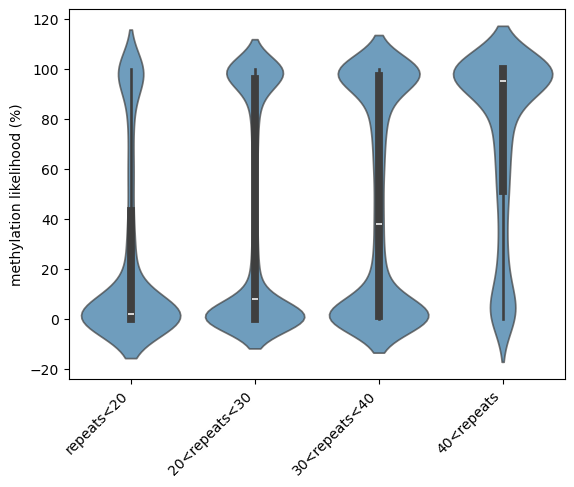

In [23]:
order = ['repeats<20', '20<repeats<30', '30<repeats<40', '40<repeats']
plt.figure()
sb.violinplot(data=df_bps_fm, x='bp_rep_status', y='methylation', alpha=0.7, inner='box', order=order, density_norm='width')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('methylation likelihood (%)')
fig_name = f'{dir_fig}/methylation_vs_repeats_allreads_females.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

fragile_x_all//methylation_vs_repeats_allreads_female_kids.png


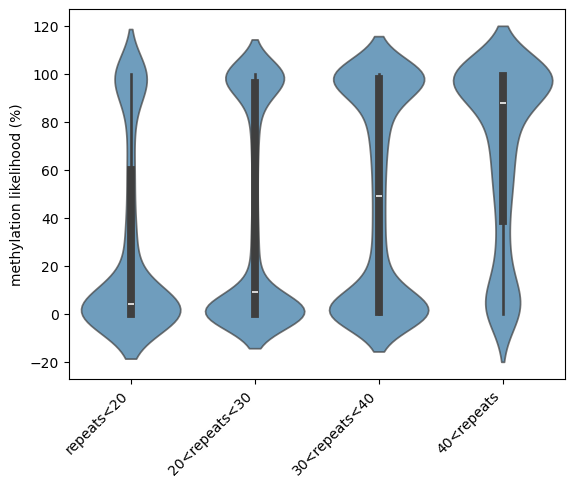

In [24]:
order = ['repeats<20', '20<repeats<30', '30<repeats<40', '40<repeats']
plt.figure()
sb.violinplot(data=df_bps_fm_kid, x='bp_rep_status', y='methylation', alpha=0.7, inner='box', order=order, density_norm='width')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('methylation likelihood (%)')
fig_name = f'{dir_fig}/methylation_vs_repeats_allreads_female_kids.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

In [25]:
#this_df = df_bps_male.loc[(df_bps_male.hp_rep!='NA')].copy()
#this_df['hp_rep'] = this_df.hp_rep.astype(int)
#display(df_bps_male.loc[df_bps_male.bp_dev>60])
print(df_bps_male.loc[df_bps_male.bp_dev>60].subject.value_counts())
print(df_bps_male.loc[df_bps_male.bp_dev>60].bp_dev.value_counts())
print('repeats:')
print(df_bps_male.loc[df_bps_male.bp_dev>60].bp_dev.value_counts().index/3+20)

subject
REACH000560    71
REACH000557    38
REACH000516     9
Name: count, dtype: int64
bp_dev
63    71
79    38
66     9
Name: count, dtype: int64
repeats:
Index([41.0, 46.33333333333333, 42.0], dtype='float64', name='bp_dev')


fragile_x_all//methylation_vs_repeats_allreads_males.png


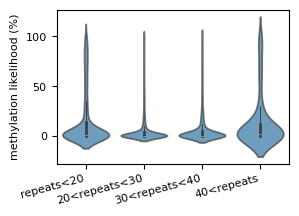

In [26]:
order = ['repeats<20', '20<repeats<30', '30<repeats<40', '40<repeats']
FS = 8
plt.figure(figsize=(3, 2))
sb.violinplot(data=df_bps_male, x='bp_rep_status', y='methylation', alpha=0.7, inner='box', order=order, density_norm='width', inner_kws=dict(box_width=2))
plt.xticks(rotation=15, ha='right', fontsize=FS)
plt.yticks(fontsize=FS)
plt.xlabel('')
plt.ylabel('methylation likelihood (%)', fontsize=FS)
fig_name = f'{dir_fig}/methylation_vs_repeats_allreads_males.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

df_flt_fmr1 len: 22564
df_reads_fmr1 len: 397
df_hps_fmr1 len: 102
df_flt_xci len: 53069
df_reads_xci len: 2888
df_hps_xci len: 102
===================== for investigation ===================
haplotypes with hp_rep<23:


hp_rep  num_reads  methylation_mean  \
subject           hp_tag                                        
REACH000161       hm          20          3         21.451389   
REACH000216       hm          20          2          7.031250   
REACH000226_sperm hm          20         16         17.647112   
REACH000286       hm          22          1          2.941176   
REACH000403       hm          19          3          5.565517   
REACH000478       hm          22          5         14.397018   
REACH000604       hm          18          3         11.220581   
REACH000681       hm          18          4         11.272027   
REACH000707       hm          20          3          4.965278   

                          methylation_std  methylation_mean_binary  \
subject           hp_tag                                             
REACH000161       hm            33.107269                 0.333333   
REACH000216       hm             3.609191                 0.000000   
REACH000226_sperm hm            16.655321                 0.062500   
REACH000286       hm                  NaN                 0.000000   
REACH000403       hm             3.043701                 0.000000   
REACH000478       hm            10.262920                 0.000000   
REACH000604       hm             8.658528                 0.000000   
REACH000681       hm             9.676495                 0.000000   
REACH000707       hm             4.421986                 0.000000   

                          methylation_std_binary            subject hp_tag  
subject           hp_tag                                                    
REACH000161       hm                     0.57735        REACH000161     hm  
REACH000216       hm                     0.00000        REACH000216     hm  
REACH000226_sperm hm                     0.25000  REACH000226_sperm     hm  
REACH000286       hm                         NaN        REACH000286     hm  
REACH000403       hm                     0.00000        REACH000403     hm  
REACH000478       hm                     0.00000        REACH000478     hm  
REACH000604       hm                     0.00000        REACH000604     hm  
REACH000681       hm                     0.00000        REACH000681     hm  
REACH000707       hm                     0.00000        REACH000707     hm

haplotypes with hp_rep>35:


hp_rep  num_reads  methylation_mean  methylation_std  \
subject     hp_tag                                                         
REACH000058 hm          37          7         12.742508         6.459954   
REACH000441 hm          37          1          3.571429              NaN   
REACH000560 hm          41          1          9.281690              NaN   
REACH000653 hm          38          3          0.143590         0.146221   

                    methylation_mean_binary  methylation_std_binary  \
subject     hp_tag                                                    
REACH000058 hm                          0.0                     0.0   
REACH000441 hm                          0.0                     NaN   
REACH000560 hm                          0.0                     NaN   
REACH000653 hm                          0.0                     0.0   

                        subject hp_tag  
subject     hp_tag                      
REACH000058 hm      REACH000058     hm  
REACH000441 hm      REACH000441     hm  
REACH000560 hm      REACH000560     hm  
REACH000653 hm      REACH000653     hm

this_df_hps num_reads>2:


hp_rep  num_reads  methylation_mean  methylation_std  \
subject     hp_tag                                                         
REACH000058 hm          37          7         12.742508         6.459954   
REACH000120 hm          24          3         13.174460         8.973196   
REACH000122 hm          30          5         11.797807         6.133524   
REACH000161 hm          20          3         21.451389        33.107269   
REACH000182 hm          30          3          9.192982         7.581140   
...                    ...        ...               ...              ...   
REACH000684 hm          28          6          4.816010         4.585366   
REACH000685 hm          26          5          4.666948         2.931965   
REACH000707 hm          20          3          4.965278         4.421986   
REACH000753 hm          30          3          2.033575         1.542777   
REACH000767 hm          30          4          1.307018         1.175788   

                    methylation_mean_binary  methylation_std_binary  \
subject     hp_tag                                                    
REACH000058 hm                     0.000000                 0.00000   
REACH000120 hm                     0.000000                 0.00000   
REACH000122 hm                     0.000000                 0.00000   
REACH000161 hm                     0.333333                 0.57735   
REACH000182 hm                     0.000000                 0.00000   
...                                     ...                     ...   
REACH000684 hm                     0.000000                 0.00000   
REACH000685 hm                     0.000000                 0.00000   
REACH000707 hm                     0.000000                 0.00000   
REACH000753 hm                     0.000000                 0.00000   
REACH000767 hm                     0.000000                 0.00000   

                        subject hp_tag  
subject     hp_tag                      
REACH000058 hm      REACH000058     hm  
REACH000120 hm      REACH000120     hm  
REACH000122 hm      REACH000122     hm  
REACH000161 hm      REACH000161     hm  
REACH000182 hm      REACH000182     hm  
...                         ...    ...  
REACH000684 hm      REACH000684     hm  
REACH000685 hm      REACH000685     hm  
REACH000707 hm      REACH000707     hm  
REACH000753 hm      REACH000753     hm  
REACH000767 hm      REACH000767     hm  

[63 rows x 8 columns]

number of subjects: 63
Scikit learn LR model:
Coefficients: [-0.33340034]
Intercept: 17.024616513623865
stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     7.271
Date:                Mon, 28 Apr 2025   Prob (F-statistic):            0.00905
Time:                        11:47:26   Log-Likelihood:                -169.54
No. Observations:                  63   AIC:                             343.1
Df Residuals:                      61   BIC:                             347.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------

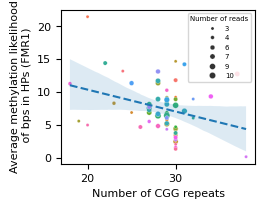

Scikit learn LR model:
Coefficients: [-0.00317958]
Intercept: 0.09497539975399755
stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     5.271
Date:                Mon, 28 Apr 2025   Prob (F-statistic):             0.0251
Time:                        11:47:27   Log-Likelihood:                 113.44
No. Observations:                  63   AIC:                            -222.9
Df Residuals:                      61   BIC:                            -218.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

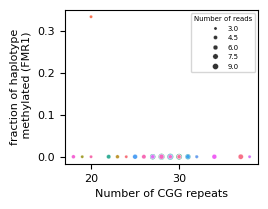

In [27]:
#### look at correlation between CGG repeat length and fraction of haplotypes methylated in males
df_reads_fmr1, df_hps_fmr1, df_reads_xci, df_hps_xci = reduce_df_bps(df_bps_male)

##### for investigation ######
print('===================== for investigation ===================')
df_this = df_hps_fmr1.loc[(df_hps_fmr1.hp_rep<23)]
#pd.set_option('display.max_rows', None)
print('haplotypes with hp_rep<23:') #num_reads>2
display(df_this)

df_this = df_hps_fmr1.loc[(df_hps_fmr1.hp_rep>35)]
#pd.set_option('display.max_rows', None)
print('haplotypes with hp_rep>35:') #num_reads>2
display(df_this)

#x_min=27; x_max=33; y_min=.49; y_max=.51
#df_this = df_hps_fmr1.loc[(df_hps_fmr1.hp_rep>x_min)&(df_hps_fmr1.hp_rep<x_max)&(df_hps_fmr1.methylation_mean_binary>y_min)&(df_hps_fmr1.methylation_mean_binary<y_max)]
##pd.set_option('display.max_rows', None)
#print(f'haplotypes with hp_rep>{x_min} & hp_rep<{x_max} & y>{y_min} & y<{y_max}:') #num_reads>2
#pd.set_option('display.max_rows', None)
#display(df_this)
print('==========================================')
##############################

### filter the sperm sample because the tissue is different
this_df_hps = df_hps_fmr1.loc[(df_hps_fmr1.num_reads>2) & (df_hps_fmr1.subject !='REACH000226_sperm')]
pd.set_option('display.max_rows', 10)
print('this_df_hps num_reads>2:')
display(this_df_hps)

num_subjects = len(set(this_df_hps['subject'].tolist()))
print(f'number of subjects: {num_subjects}')

FS = 8

### version 1
plt.figure(figsize=(2.5, 2))
sb.scatterplot(data=this_df_hps, x='hp_rep', y='methylation_mean', hue='subject', size='num_reads', sizes=(5,20)) # sizes gets a min max tuple interpreted by "size"
sb.regplot(data=this_df_hps, x='hp_rep', y='methylation_mean', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Number of reads', loc='upper right', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[num_subjects+2:], fontsize=FS-3, title_fontsize=FS-3)
# Fit linear regression
x = np.array(this_df_hps.hp_rep.tolist()).reshape(-1, 1) # Reshape for sklearn
y = np.array(this_df_hps.methylation_mean.tolist())
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
#plt.plot(x, y_pred, '-ok', label='Regression Line')
# Get weights (coefficients) and intercept
print('Scikit learn LR model:')
print("Coefficients:", model.coef_)  # Slope
print("Intercept:", model.intercept_)  # Intercept

X = pd.DataFrame(this_df_hps.hp_rep)
X_const = sm.add_constant(X)  # Adds intercept term
model_sm = sm.OLS(y, X_const).fit()
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('Average methylation likelihood\n of bps in HPs (FMR1)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
#**plt.xlim(xmax=52)
fig_name = f'{dir_fig}/bp_methylation_likelihood_vs_repeats_FMR1_MALES.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

### version 2
plt.figure(figsize=(2.5, 2))
df_hps_jitter = pd.DataFrame(this_df_hps)
df_hps_jitter['hp_rep'] = df_hps_jitter['hp_rep'].astype(float)
df_hps_jitter.loc[('REACH000453', 'h2'), 'hp_rep'] = 49.5
df_hps_jitter.loc[('REACH000461', 'h2'), 'hp_rep'] = 50.5
sb.scatterplot(data=df_hps_jitter, x='hp_rep', y='methylation_mean_binary', hue='subject', size='num_reads', sizes=(5,20)) # sizes gets a min max tuple interpreted by "size"
#**sb.regplot(data=this_df_hps, x='hp_rep', y='methylation_mean_binary', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Number of reads', loc='upper right', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[num_subjects+2:], fontsize=FS-3, title_fontsize=FS-3) 
# Fit linear regression
x = np.array(this_df_hps.hp_rep.tolist()).reshape(-1, 1) # Reshape for sklearn
y = np.array(this_df_hps.methylation_mean_binary.tolist())
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
#plt.plot(x, y_pred, '-ok', label='Regression Line')
# Get weights (coefficients) and intercept
print('Scikit learn LR model:')
print("Coefficients:", model.coef_)  # Slope
print("Intercept:", model.intercept_)  # Intercept

X = pd.DataFrame(this_df_hps.hp_rep)
X_const = sm.add_constant(X)  # Adds intercept term
model_sm = sm.OLS(y, X_const).fit()
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')
x_t = 30
y_t = .1
p = model_sm.pvalues['hp_rep']
#**plt.text(x_t, y_t, f'p: {p:.2e}', fontsize=FS-2)

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (FMR1)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
#plt.xlim(xmax=52)
fig_name = f'{dir_fig}/haplotype_readFrac_methylation_vs_repeats_FMR1_MALES.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

fragile_x_all//methylation_vs_repeats_h1h2reads_FMR1.png


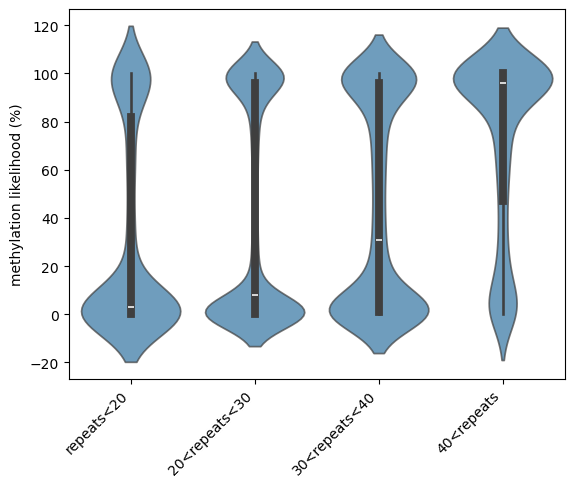

In [28]:
df_flt = df_bps_fm.loc[(df_bps_fm.hp_bp_dev!='NA')&(df_bps_fm.hp_bp_dev!='psNA')].copy()
df_flt['hp_rep_status'] = df_flt.apply(lambda row: get_status(row, 'hp_bp_dev', ignore_region=True), axis=1)
df_plt = df_flt.loc[df_flt.region_id=='FMR1_5UTR']
order = ['repeats<20', '20<repeats<30', '30<repeats<40', '40<repeats']
plt.figure()
sb.violinplot(data=df_plt, x='hp_rep_status', y='methylation', alpha=0.7, inner='box', order=order, density_norm='width')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('methylation likelihood (%)')
fig_name = f'{dir_fig}/methylation_vs_repeats_h1h2reads_FMR1.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

fragile_x_all//methylation_vs_repeats_h1h2reads_XCI_othergenes.png


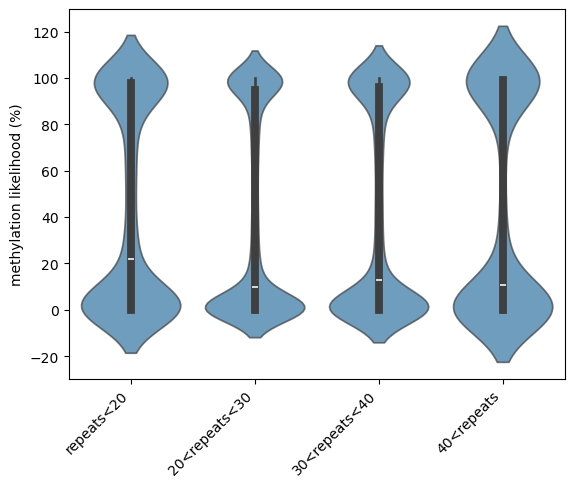

In [29]:
df_flt = df_bps_fm.loc[(df_bps_fm.hp_bp_dev!='NA')&(df_bps_fm.hp_bp_dev!='psNA')].copy()
df_flt['hp_rep_status'] = df_flt.apply(lambda row: get_status(row, 'hp_bp_dev', ignore_region=True), axis=1)
df_plt = df_flt.loc[df_flt.region_id!='FMR1_5UTR']
order = ['repeats<20', '20<repeats<30', '30<repeats<40', '40<repeats']
plt.figure()
sb.violinplot(data=df_plt, x='hp_rep_status', y='methylation', alpha=0.7, inner='box', order=order, density_norm='width')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('methylation likelihood (%)')
fig_name = f'{dir_fig}/methylation_vs_repeats_h1h2reads_XCI_othergenes.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

fragile_x_all//methylation_vs_repeats_h1h2reads_allgenes.png


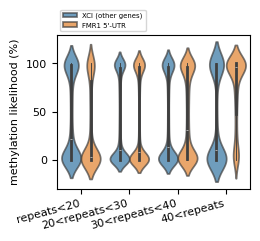

In [30]:
df_flt = df_bps_fm.loc[(df_bps_fm.hp_bp_dev!='NA')&(df_bps_fm.hp_bp_dev!='psNA')].copy()
df_flt['hp_rep_status'] = df_flt.apply(lambda row: get_status(row, 'hp_bp_dev', ignore_region=True), axis=1)
order = ['repeats<20', '20<repeats<30', '30<repeats<40', '40<repeats']
hue_order = ['XCI (other genes)', 'FMR1 UTR']
FS = 8
plt.figure(figsize=(2.5, 2))
ax = sb.violinplot(data=df_flt, x='hp_rep_status', y='methylation', hue='gene_tag', dodge=True, hue_order=hue_order, alpha=0.7, 
                   inner='box', order=order, density_norm='width', inner_kws=dict(box_width=2))
#sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize=FS-3)
#legend = ax.get_legend()
#legend.set_title('')
ax.legend(handles=ax.legend_.legend_handles, labels=['XCI (other genes)', "FMR1 5'-UTR"], loc='lower left', bbox_to_anchor=(0, 1), fontsize=FS-3)
plt.xticks(rotation=15, ha='right', fontsize=FS)
plt.yticks(fontsize=FS)
plt.xlabel('')
plt.ylabel('methylation likelihood (%)', fontsize=FS)

#dx = .2
##x1, x2 = 3-dx, 3+dx   # columns (first column: 0, see plt.xticks())
#y, h, col = 130, 7, 'k'
#for idx, group in enumerate(order):
#    x1, x2 = idx-dx, idx+dx   # columns (first column: 0, see plt.xticks())
#    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#    plt.text((x1+x2)*.5, y+h, f"p: {pvalue_dict[group]:.2e}\n n: {num_obs_dict[group]}", ha='center', va='bottom', color=col)

fig_name = f'{dir_fig}/methylation_vs_repeats_h1h2reads_allgenes.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

In [ ]:
### the cells below are for scatter-like plots:

df_flt_fmr1 len: 19947
df_reads_fmr1 len: 359
df_hps_fmr1 len: 117
df_flt_xci len: 33543
df_reads_xci len: 2047
df_hps_xci len: 114


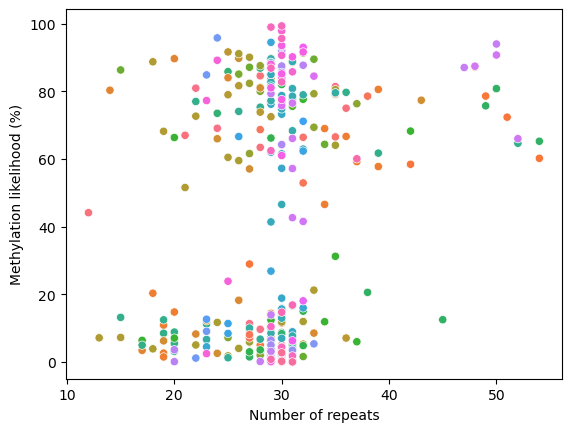

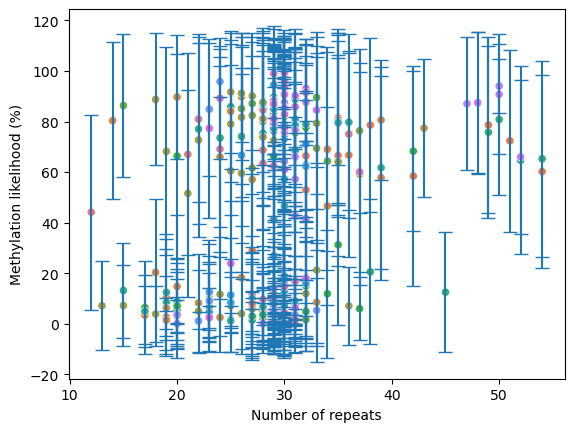

In [31]:
df_reads_fmr1, df_hps_fmr1, df_reads_xci, df_hps_xci = reduce_df_bps(df_bps_fm)

plt.figure()
sb.scatterplot(data=df_reads_fmr1, x='bp_rep', y='methylation_mean', hue='subject', legend=False)
plt.xlabel('Number of repeats')
plt.ylabel('Methylation likelihood (%)')
plt.show()
plt.close()

plt.figure()
sb.scatterplot(data=df_reads_fmr1, x='bp_rep', y='methylation_mean', hue='subject', legend=False)
plt.errorbar(df_reads_fmr1['bp_rep'], df_reads_fmr1['methylation_mean'], yerr=df_reads_fmr1['methylation_std'], fmt='none', capsize=5)
plt.xlabel('Number of repeats')
plt.ylabel('Methylation likelihood (%)')
plt.show()
plt.close()
#df_flt_fmr1.groupby(by='read_name')['methylation'].std()


In [ ]:
display(df_hps_fmr1.loc[df_hps_fmr1.subject=='REACH000519'])
display(df_reads_fmr1.loc[df_reads_fmr1.subject=='REACH000519'])

df_flt_fmr1 len: 19947
df_reads_fmr1 len: 359
df_hps_fmr1 len: 117
df_flt_xci len: 33543
df_reads_xci len: 2047
df_hps_xci len: 114
===================== for investigation ===================
haplotypes with hp_rep<23:


hp_rep  num_reads  methylation_mean  methylation_std  \
subject     hp_tag                                                         
REACH000294 h1          22          1          1.140000              NaN   
REACH000401 h1          18          4         44.975787        46.411017   
REACH000404 h2          19          7         54.679653        34.752180   
REACH000420 h1          20          6          6.044481         2.189809   
REACH000435 h2          22          3          6.859690         4.220148   
REACH000479 h2          19          6         21.770969        29.696086   
REACH000482 h2          20          3         26.597935        34.442905   
REACH000519 h2          21          4         28.457060        32.386450   
REACH000755 h1          20          3         30.477754        49.626784   

                    methylation_mean_binary  methylation_std_binary  \
subject     hp_tag                                                    
REACH000294 h1                     0.000000                     NaN   
REACH000401 h1                     0.500000                0.577350   
REACH000404 h2                     0.714286                0.487950   
REACH000420 h1                     0.000000                0.000000   
REACH000435 h2                     0.000000                0.000000   
REACH000479 h2                     0.166667                0.408248   
REACH000482 h2                     0.333333                0.577350   
REACH000519 h2                     0.250000                0.500000   
REACH000755 h1                     0.333333                0.577350   

                        subject hp_tag  
subject     hp_tag                      
REACH000294 h1      REACH000294     h1  
REACH000401 h1      REACH000401     h1  
REACH000404 h2      REACH000404     h2  
REACH000420 h1      REACH000420     h1  
REACH000435 h2      REACH000435     h2  
REACH000479 h2      REACH000479     h2  
REACH000482 h2      REACH000482     h2  
REACH000519 h2      REACH000519     h2  
REACH000755 h1      REACH000755     h1

haplotypes with hp_rep>45:


hp_rep  num_reads  methylation_mean  methylation_std  \
subject     hp_tag                                                         
REACH000451 h2          49          2         90.546320         4.920973   
REACH000453 h2          50          3         81.419051        13.431833   
REACH000561 h2          50          4         67.418848         9.705172   
REACH000563 h1          49          4         58.579873        31.405029   

                    methylation_mean_binary  methylation_std_binary  \
subject     hp_tag                                                    
REACH000451 h2                         1.00                     0.0   
REACH000453 h2                         1.00                     0.0   
REACH000561 h2                         1.00                     0.0   
REACH000563 h1                         0.75                     0.5   

                        subject hp_tag  
subject     hp_tag                      
REACH000451 h2      REACH000451     h2  
REACH000453 h2      REACH000453     h2  
REACH000561 h2      REACH000561     h2  
REACH000563 h1      REACH000563     h1

haplotypes with hp_rep>27 & hp_rep<33 & y>0.49 & y<0.51:


hp_rep  num_reads  methylation_mean  methylation_std  \
subject        hp_tag                                                         
REACH000089    h1          30          2         31.767857        42.098107   
REACH000107    h1          29          4         43.960021        46.773873   
REACH000314    h1          29          4         43.647400        44.243599   
               h2          31          2         39.386419        33.321498   
REACH000316    h2          29          2         64.092857        32.092546   
REACH000365    h1          30          6         47.325217        49.927682   
REACH000530_PB h2          31          2         49.659791        61.365461   
REACH000541    h1          29          2         39.761006        50.306867   
REACH000565    h2          32          2         42.972727        47.221876   
REACH000579    h2          28          2         46.564327        63.337746   
REACH000581    h1          28          4         34.610856        38.572900   
REACH000628    h1          30          4         38.763158        46.068143   
REACH000674    h2          30          6         46.532769        49.370513   

                       methylation_mean_binary  methylation_std_binary  \
subject        hp_tag                                                    
REACH000089    h1                          0.5                0.707107   
REACH000107    h1                          0.5                0.577350   
REACH000314    h1                          0.5                0.577350   
               h2                          0.5                0.707107   
REACH000316    h2                          0.5                0.707107   
REACH000365    h1                          0.5                0.547723   
REACH000530_PB h2                          0.5                0.707107   
REACH000541    h1                          0.5                0.707107   
REACH000565    h2                          0.5                0.707107   
REACH000579    h2                          0.5                0.707107   
REACH000581    h1                          0.5                0.577350   
REACH000628    h1                          0.5                0.577350   
REACH000674    h2                          0.5                0.547723   

                              subject hp_tag  
subject        hp_tag                         
REACH000089    h1         REACH000089     h1  
REACH000107    h1         REACH000107     h1  
REACH000314    h1         REACH000314     h1  
               h2         REACH000314     h2  
REACH000316    h2         REACH000316     h2  
REACH000365    h1         REACH000365     h1  
REACH000530_PB h2      REACH000530_PB     h2  
REACH000541    h1         REACH000541     h1  
REACH000565    h2         REACH000565     h2  
REACH000579    h2         REACH000579     h2  
REACH000581    h1         REACH000581     h1  
REACH000628    h1         REACH000628     h1  
REACH000674    h2         REACH000674     h2

this_df_hps num_reads>2:


hp_rep  num_reads  methylation_mean  methylation_std  \
subject     hp_tag                                                         
REACH000087 h2          30          4         59.431413        31.915171   
REACH000089 h2          30          3         55.854861        41.103003   
REACH000092 h2          29          5         47.627256        36.986086   
REACH000093 h1          29          4         83.919643         6.748338   
REACH000107 h1          29          4         43.960021        46.773873   
...                    ...        ...               ...              ...   
REACH000682 h1          29          3          4.507125         3.389182   
REACH000702 h1          29          6         28.637914        44.252899   
            h2          30          8         72.080279        30.669235   
REACH000727 h1          30          3         86.355011        11.607663   
REACH000755 h1          20          3         30.477754        49.626784   

                    methylation_mean_binary  methylation_std_binary  \
subject     hp_tag                                                    
REACH000087 h2                     0.750000                0.500000   
REACH000089 h2                     0.666667                0.577350   
REACH000092 h2                     0.600000                0.547723   
REACH000093 h1                     1.000000                0.000000   
REACH000107 h1                     0.500000                0.577350   
...                                     ...                     ...   
REACH000682 h1                     0.000000                0.000000   
REACH000702 h1                     0.333333                0.516398   
            h2                     0.875000                0.353553   
REACH000727 h1                     1.000000                0.000000   
REACH000755 h1                     0.333333                0.577350   

                        subject hp_tag  
subject     hp_tag                      
REACH000087 h2      REACH000087     h2  
REACH000089 h2      REACH000089     h2  
REACH000092 h2      REACH000092     h2  
REACH000093 h1      REACH000093     h1  
REACH000107 h1      REACH000107     h1  
...                         ...    ...  
REACH000682 h1      REACH000682     h1  
REACH000702 h1      REACH000702     h1  
            h2      REACH000702     h2  
REACH000727 h1      REACH000727     h1  
REACH000755 h1      REACH000755     h1  

[66 rows x 8 columns]

number of subjects: 45
Scikit learn LR model:
Coefficients: [1.38978438]
Intercept: 2.5646370772864913
stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     9.311
Date:                Mon, 28 Apr 2025   Prob (F-statistic):            0.00331
Time:                        11:47:58   Log-Likelihood:                -296.51
No. Observations:                  66   AIC:                             597.0
Df Residuals:                      64   BIC:                             601.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

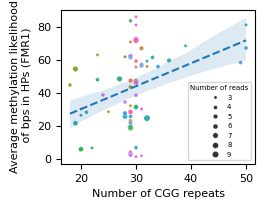

Scikit learn LR model:
Coefficients: [0.02166684]
Intercept: -0.13041522158803887
stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     13.98
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           0.000398
Time:                        11:47:58   Log-Likelihood:                -8.4716
No. Observations:                  66   AIC:                             20.94
Df Residuals:                      64   BIC:                             25.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

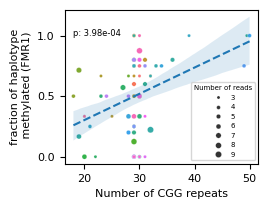

In [32]:
df_reads_fmr1, df_hps_fmr1, df_reads_xci, df_hps_xci = reduce_df_bps(df_bps_fm)

##### for investigation ######
print('===================== for investigation ===================')
df_this = df_hps_fmr1.loc[(df_hps_fmr1.hp_rep<23)]
#pd.set_option('display.max_rows', None)
print('haplotypes with hp_rep<23:') #num_reads>2
display(df_this)

df_this = df_hps_fmr1.loc[(df_hps_fmr1.hp_rep>45)]
#pd.set_option('display.max_rows', None)
print('haplotypes with hp_rep>45:') #num_reads>2
display(df_this)

x_min=27; x_max=33; y_min=.49; y_max=.51
df_this = df_hps_fmr1.loc[(df_hps_fmr1.hp_rep>x_min)&(df_hps_fmr1.hp_rep<x_max)&(df_hps_fmr1.methylation_mean_binary>y_min)&(df_hps_fmr1.methylation_mean_binary<y_max)]
#pd.set_option('display.max_rows', None)
print(f'haplotypes with hp_rep>{x_min} & hp_rep<{x_max} & y>{y_min} & y<{y_max}:') #num_reads>2
pd.set_option('display.max_rows', None)
display(df_this)
print('==========================================')
##############################

this_df_hps = df_hps_fmr1.loc[df_hps_fmr1.num_reads>2]
pd.set_option('display.max_rows', 10)
print('this_df_hps num_reads>2:')
display(this_df_hps)

num_subjects = len(set(this_df_hps['subject'].tolist()))
print(f'number of subjects: {num_subjects}')

FS = 8

### version 1
plt.figure(figsize=(2.5, 2))
sb.scatterplot(data=this_df_hps, x='hp_rep', y='methylation_mean', hue='subject', size='num_reads', sizes=(5,20)) # sizes gets a min max tuple interpreted by "size"
sb.regplot(data=this_df_hps, x='hp_rep', y='methylation_mean', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Number of reads', loc='lower right', bbox_to_anchor=(1, 0), 
           handles=plt.gca().legend_.legend_handles[num_subjects+2:], fontsize=FS-3, title_fontsize=FS-3)
# Fit linear regression
x = np.array(this_df_hps.hp_rep.tolist()).reshape(-1, 1) # Reshape for sklearn
y = np.array(this_df_hps.methylation_mean.tolist())
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
#plt.plot(x, y_pred, '-ok', label='Regression Line')
# Get weights (coefficients) and intercept
print('Scikit learn LR model:')
print("Coefficients:", model.coef_)  # Slope
print("Intercept:", model.intercept_)  # Intercept

X = pd.DataFrame(this_df_hps.hp_rep)
X_const = sm.add_constant(X)  # Adds intercept term
model_sm = sm.OLS(y, X_const).fit()
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('Average methylation likelihood\n of bps in HPs (FMR1)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/bp_methylation_likelihood_vs_repeats_FMR1.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

### version 2
plt.figure(figsize=(2.5, 2))
df_hps_jitter = pd.DataFrame(this_df_hps)
df_hps_jitter['hp_rep'] = df_hps_jitter['hp_rep'].astype(float)
df_hps_jitter.loc[('REACH000453', 'h2'), 'hp_rep'] = 49.5
df_hps_jitter.loc[('REACH000461', 'h2'), 'hp_rep'] = 50.5
sb.scatterplot(data=df_hps_jitter, x='hp_rep', y='methylation_mean_binary', hue='subject', size='num_reads', sizes=(5,20)) # sizes gets a min max tuple interpreted by "size"
sb.regplot(data=this_df_hps, x='hp_rep', y='methylation_mean_binary', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Number of reads', loc='lower right', bbox_to_anchor=(1, 0), 
           handles=plt.gca().legend_.legend_handles[num_subjects+2:], fontsize=FS-3, title_fontsize=FS-3) 
# Fit linear regression
x = np.array(this_df_hps.hp_rep.tolist()).reshape(-1, 1) # Reshape for sklearn
y = np.array(this_df_hps.methylation_mean_binary.tolist())
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
#plt.plot(x, y_pred, '-ok', label='Regression Line')
# Get weights (coefficients) and intercept
print('Scikit learn LR model:')
print("Coefficients:", model.coef_)  # Slope
print("Intercept:", model.intercept_)  # Intercept

X = pd.DataFrame(this_df_hps.hp_rep)
X_const = sm.add_constant(X)  # Adds intercept term
model_sm = sm.OLS(y, X_const).fit()
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')
x_t = 18
y_t = 1
p = model_sm.pvalues['hp_rep']
plt.text(x_t, y_t, f'p: {p:.2e}', fontsize=FS-2, ha='left')

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (FMR1)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/haplotype_readFrac_methylation_vs_repeats_FMR1.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

In [ ]:
### OLS for XCI other genes

df_flt_fmr1 len: 19947
df_reads_fmr1 len: 359
df_hps_fmr1 len: 117
df_flt_xci len: 33543
df_reads_xci len: 2047
df_hps_xci len: 114


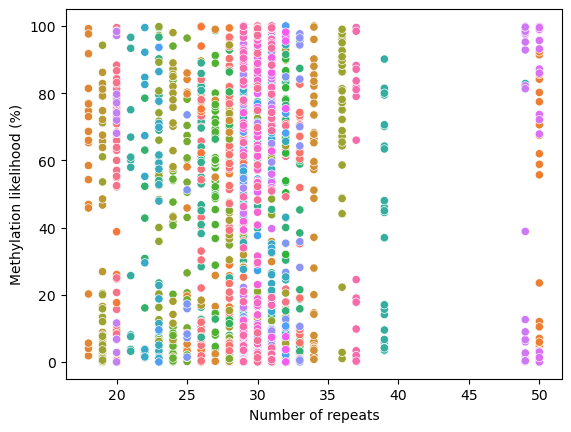

===================== for investigation ===================
haplotypes with hp_rep<23:


hp_rep  num_reads  methylation_mean  methylation_std  \
subject     hp_tag                                                         
REACH000294 h1          22          9         57.352651        37.508377   
REACH000401 h1          18         19         58.329904        30.665538   
REACH000404 h2          19         21         46.995576        32.264201   
REACH000420 h1          20          9         11.290159        13.687711   
REACH000435 h2          22         12         24.898338        27.818974   
REACH000479 h2          19         32         18.162667        27.654599   
REACH000482 h2          20         43         53.574915        29.571198   
REACH000519 h2          21         13         43.250863        35.740993   
REACH000755 h1          20         15         51.713706        40.257137   

                    methylation_mean_binary  methylation_std_binary  \
subject     hp_tag                                                    
REACH000294 h1                     0.666667                0.500000   
REACH000401 h1                     0.684211                0.477567   
REACH000404 h2                     0.523810                0.511766   
REACH000420 h1                     0.000000                0.000000   
REACH000435 h2                     0.250000                0.452267   
REACH000479 h2                     0.187500                0.396558   
REACH000482 h2                     0.697674                0.464701   
REACH000519 h2                     0.538462                0.518875   
REACH000755 h1                     0.600000                0.507093   

                        subject hp_tag  
subject     hp_tag                      
REACH000294 h1      REACH000294     h1  
REACH000401 h1      REACH000401     h1  
REACH000404 h2      REACH000404     h2  
REACH000420 h1      REACH000420     h1  
REACH000435 h2      REACH000435     h2  
REACH000479 h2      REACH000479     h2  
REACH000482 h2      REACH000482     h2  
REACH000519 h2      REACH000519     h2  
REACH000755 h1      REACH000755     h1

haplotypes with hp_rep>45:


hp_rep  num_reads  methylation_mean  methylation_std  \
subject     hp_tag                                                         
REACH000451 h2          49         27         41.651123        45.746096   
REACH000453 h2          50         24         45.121808        45.900766   
REACH000561 h2          50         20         44.850301        35.781359   
REACH000563 h1          49          1         82.857143              NaN   

                    methylation_mean_binary  methylation_std_binary  \
subject     hp_tag                                                    
REACH000451 h2                     0.407407                0.500712   
REACH000453 h2                     0.500000                0.510754   
REACH000561 h2                     0.550000                0.510418   
REACH000563 h1                     1.000000                     NaN   

                        subject hp_tag  
subject     hp_tag                      
REACH000451 h2      REACH000451     h2  
REACH000453 h2      REACH000453     h2  
REACH000561 h2      REACH000561     h2  
REACH000563 h1      REACH000563     h1

this_df_hps num_reads>2:


hp_rep  num_reads  methylation_mean  methylation_std  \
subject     hp_tag                                                         
REACH000087 h1          30          9         35.944841        39.181304   
            h2          30          7         59.863159        34.534200   
REACH000089 h1          30          5         49.798303        31.780398   
            h2          30          3         75.888889        21.647539   
REACH000092 h1          31         22         20.957186        28.692205   
...                    ...        ...               ...              ...   
REACH000727 h1          30         21         64.084070        39.921118   
REACH000752 h1          33         14         41.658049        40.894232   
REACH000755 h1          20         15         51.713706        40.257137   
REACH000763 h2          31         14         69.680573        37.437119   
REACH000766 h2          31         18         51.360592        40.967890   

                    methylation_mean_binary  methylation_std_binary  \
subject     hp_tag                                                    
REACH000087 h1                     0.333333                0.500000   
            h2                     0.714286                0.487950   
REACH000089 h1                     0.800000                0.447214   
            h2                     1.000000                0.000000   
REACH000092 h1                     0.181818                0.394771   
...                                     ...                     ...   
REACH000727 h1                     0.714286                0.462910   
REACH000752 h1                     0.428571                0.513553   
REACH000755 h1                     0.600000                0.507093   
REACH000763 h2                     0.785714                0.425815   
REACH000766 h2                     0.611111                0.501631   

                        subject hp_tag  
subject     hp_tag                      
REACH000087 h1      REACH000087     h1  
            h2      REACH000087     h2  
REACH000089 h1      REACH000089     h1  
            h2      REACH000089     h2  
REACH000092 h1      REACH000092     h1  
...                         ...    ...  
REACH000727 h1      REACH000727     h1  
REACH000752 h1      REACH000752     h1  
REACH000755 h1      REACH000755     h1  
REACH000763 h2      REACH000763     h2  
REACH000766 h2      REACH000766     h2  

[113 rows x 8 columns]

number of subjects: 65
Scikit learn LR model:
Coefficients: [0.22280458]
Intercept: 35.94898665601864
stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7027
Date:                Mon, 28 Apr 2025   Prob (F-statistic):              0.404
Time:                        11:48:07   Log-Likelihood:                -457.78
No. Observations:                 113   AIC:                             919.6
Df Residuals:                     111   BIC:                             925.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

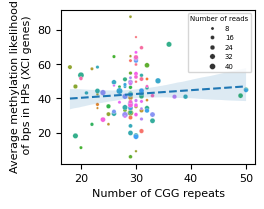

Scikit learn LR model:
Coefficients: [0.00121861]
Intercept: 0.43711993010692685
stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.1160
Date:                Mon, 28 Apr 2025   Prob (F-statistic):              0.734
Time:                        11:48:08   Log-Likelihood:                 29.006
No. Observations:                 113   AIC:                            -54.01
Df Residuals:                     111   BIC:                            -48.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

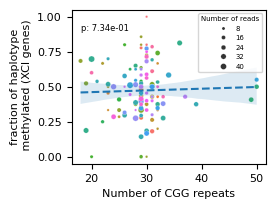

In [33]:
pd.set_option('display.max_rows', 10)
df_reads_fmr1, df_hps_fmr1, df_reads_xci, df_hps_xci = reduce_df_bps(df_bps_fm)

plt.figure()
sb.scatterplot(data=df_reads_xci, x='hp_rep', y='methylation_mean', hue='subject', legend=False)
#plt.errorbar(df_reads['bp_rep'], df_reads['methylation_mean'], yerr=df_reads['methylation_std'], fmt='none', capsize=5)
plt.xlabel('Number of repeats')
plt.ylabel('Methylation likelihood (%)')
plt.show()
plt.close()

##### for investigation ######
print('===================== for investigation ===================')
df_this = df_hps_xci.loc[(df_hps_xci.hp_rep<23)]
#pd.set_option('display.max_rows', None)
print('haplotypes with hp_rep<23:') #num_reads>2
display(df_this)

df_this = df_hps_xci.loc[(df_hps_xci.hp_rep>45)]
#pd.set_option('display.max_rows', None)
print('haplotypes with hp_rep>45:') #num_reads>2
display(df_this)
print('==========================================')
##############################

this_df_hps = df_hps_xci.loc[df_hps_xci.num_reads>2]
#pd.set_option('display.max_rows', None)
print('this_df_hps num_reads>2:')
display(this_df_hps)

num_subjects = len(set(this_df_hps['subject'].tolist()))
print(f'number of subjects: {num_subjects}')

### version 1
plt.figure(figsize=(2.5, 2))
sb.scatterplot(data=this_df_hps, x='hp_rep', y='methylation_mean', hue='subject', size='num_reads', sizes=(3,20)) # sizes gets a min max tuple interpreted by "size"
sb.regplot(data=this_df_hps, x='hp_rep', y='methylation_mean', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Number of reads', loc='upper right', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[num_subjects+2:], fontsize=FS-3, title_fontsize=FS-3) 
# Fit linear regression
x = np.array(this_df_hps.hp_rep.tolist()).reshape(-1, 1) # Reshape for sklearn
y = np.array(this_df_hps.methylation_mean.tolist())
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
#plt.plot(x, y_pred, '-ok', label='Regression Line')
# Get weights (coefficients) and intercept
print('Scikit learn LR model:')
print("Coefficients:", model.coef_)  # Slope
print("Intercept:", model.intercept_)  # Intercept

X = pd.DataFrame(this_df_hps.hp_rep)
X_const = sm.add_constant(X)  # Adds intercept term
model_sm = sm.OLS(y, X_const).fit()
# Get summary
print('stats model:')
print(model_sm.summary())

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('Average methylation likelihood\n of bps in HPs (XCI genes)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/bp_methylation_likelihood_vs_repeats_XCI.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

### version 2
plt.figure(figsize=(2.5, 2))
sb.scatterplot(data=this_df_hps, x='hp_rep', y='methylation_mean_binary', hue='subject', size='num_reads', sizes=(3,20)) # sizes gets a min max tuple interpreted by "size"
sb.regplot(data=this_df_hps, x='hp_rep', y='methylation_mean_binary', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
#plt.legend(title='Number of reads', loc='upper left', bbox_to_anchor=(1, 1), handles=plt.gca().legend_.legend_handles[num_subjects+2:]) 
plt.legend(title='Number of reads', loc='upper right', bbox_to_anchor=(1, 1), 
           handles=plt.gca().legend_.legend_handles[num_subjects+2:], fontsize=FS-3, title_fontsize=FS-3)
# Fit linear regression
x = np.array(this_df_hps.hp_rep.tolist()).reshape(-1, 1) # Reshape for sklearn
y = np.array(this_df_hps.methylation_mean_binary.tolist())
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
#plt.plot(x, y_pred, '-ok', label='Regression Line')
# Get weights (coefficients) and intercept
print('Scikit learn LR model:')
print("Coefficients:", model.coef_)  # Slope
print("Intercept:", model.intercept_)  # Intercept

X = pd.DataFrame(this_df_hps.hp_rep)
X_const = sm.add_constant(X)  # Adds intercept term
model_sm = sm.OLS(y, X_const).fit()
# Get summary
print('stats model:')
print(model_sm.summary())
x_t = 18
y_t = .9
p = model_sm.pvalues['hp_rep']
plt.text(x_t, y_t, f'p: {p:.2e}', fontsize=FS-2, ha='left')

plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('fraction of haplotype\n methylated (XCI genes)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/haplotype_readFrac_methylation_vs_repeats_XCI.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

df_flt_fmr1 len: 19947
df_reads_fmr1 len: 359
df_hps_fmr1 len: 117
df_flt_xci len: 33543
df_reads_xci len: 2047
df_hps_xci len: 114
number of subjects: 43
===================== for investigation ===================
haplotypes with methylation_mean_binary_xci<.1:


hp_rep_fmr1  num_reads_fmr1  methylation_mean_fmr1  \
subject     hp_tag                                                       
REACH000365 h1               30               6              47.325217   
REACH000418 h2               29               8              19.076047   
REACH000420 h1               20               6               6.044481   

                    methylation_mean_binary_fmr1  hp_rep_xci  num_reads_xci  \
subject     hp_tag                                                            
REACH000365 h1                             0.500          30              4   
REACH000418 h2                             0.125          29             14   
REACH000420 h1                             0.000          20              9   

                    methylation_mean_xci  methylation_mean_binary_xci  
subject     hp_tag                                                     
REACH000365 h1                  9.200000                          0.0  
REACH000418 h2                  5.971627                          0.0  
REACH000420 h1                 11.290159                          0.0

haplotypes with methylation_mean_binary_xci>.9:


hp_rep_fmr1  num_reads_fmr1  methylation_mean_fmr1  \
subject     hp_tag                                                       
REACH000089 h2               30               3              55.854861   

                    methylation_mean_binary_fmr1  hp_rep_xci  num_reads_xci  \
subject     hp_tag                                                            
REACH000089 h2                          0.666667          30              3   

                    methylation_mean_xci  methylation_mean_binary_xci  
subject     hp_tag                                                     
REACH000089 h2                 75.888889                          1.0

haplotypes with hp_rep_fmr1<23:


hp_rep_fmr1  num_reads_fmr1  methylation_mean_fmr1  \
subject     hp_tag                                                       
REACH000401 h1               18               4              44.975787   
REACH000404 h2               19               7              54.679653   
REACH000420 h1               20               6               6.044481   
REACH000435 h2               22               3               6.859690   
REACH000479 h2               19               6              21.770969   
REACH000482 h2               20               3              26.597935   
REACH000519 h2               21               4              28.457060   
REACH000755 h1               20               3              30.477754   

                    methylation_mean_binary_fmr1  hp_rep_xci  num_reads_xci  \
subject     hp_tag                                                            
REACH000401 h1                          0.500000          18             19   
REACH000404 h2                          0.714286          19             21   
REACH000420 h1                          0.000000          20              9   
REACH000435 h2                          0.000000          22             12   
REACH000479 h2                          0.166667          19             32   
REACH000482 h2                          0.333333          20             43   
REACH000519 h2                          0.250000          21             13   
REACH000755 h1                          0.333333          20             15   

                    methylation_mean_xci  methylation_mean_binary_xci  
subject     hp_tag                                                     
REACH000401 h1                 58.329904                     0.684211  
REACH000404 h2                 46.995576                     0.523810  
REACH000420 h1                 11.290159                     0.000000  
REACH000435 h2                 24.898338                     0.250000  
REACH000479 h2                 18.162667                     0.187500  
REACH000482 h2                 53.574915                     0.697674  
REACH000519 h2                 43.250863                     0.538462  
REACH000755 h1                 51.713706                     0.600000

haplotypes with hp_rep_fmr1>40:


hp_rep_fmr1  num_reads_fmr1  methylation_mean_fmr1  \
subject     hp_tag                                                       
REACH000453 h2               50               3              81.419051   
REACH000561 h2               50               4              67.418848   

                    methylation_mean_binary_fmr1  hp_rep_xci  num_reads_xci  \
subject     hp_tag                                                            
REACH000453 h2                               1.0          50             24   
REACH000561 h2                               1.0          50             20   

                    methylation_mean_xci  methylation_mean_binary_xci  
subject     hp_tag                                                     
REACH000453 h2                 45.121808                         0.50  
REACH000561 h2                 44.850301                         0.55

stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     12.87
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           2.23e-05
Time:                        11:48:23   Log-Likelihood:                -4.0608
No. Observations:                  63   AIC:                             14.12
Df Residuals:                      60   BIC:                             20.55
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const

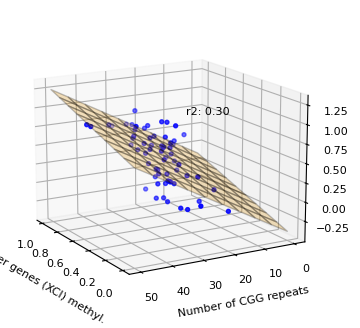

stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     9.913
Date:                Mon, 28 Apr 2025   Prob (F-statistic):            0.00254
Time:                        11:48:25   Log-Likelihood:                -10.562
No. Observations:                  63   AIC:                             25.12
Df Residuals:                      61   BIC:                             29.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const

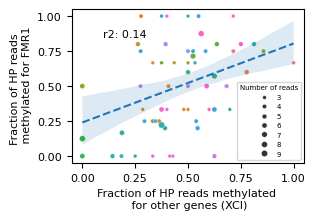

stats model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     13.67
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           0.000468
Time:                        11:48:26   Log-Likelihood:                -8.9342
No. Observations:                  63   AIC:                             21.87
Df Residuals:                      61   BIC:                             26.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1972      0.193    

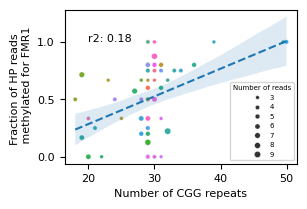

In [34]:
### Multivariate OLS
### investigate all females with consistant h1/h2 for FMR1 and XCI, after checking for phase sets
### linear regression of FMR1 methylation as a function of XCI and CGG repeat
df_reads_fmr1, df_hps_fmr1, df_reads_xci, df_hps_xci = reduce_df_bps(df_bps_fm)

cols = ['hp_rep', 'num_reads', 'methylation_mean', 'methylation_mean_binary']
#pd.set_option('display.max_rows', None)
df_merge = pd.merge(df_hps_fmr1[cols], df_hps_xci[cols], left_index=True, right_index=True, how='inner', suffixes=('_fmr1', '_xci'))
df_merge = df_merge.loc[(df_merge.num_reads_fmr1>2)&(df_merge.num_reads_xci>2)]
#print('df_merge:')
#display(df_merge)
pd.set_option('display.max_rows', 10)

num_subjects = len(set(df_merge.index.get_level_values('subject').tolist()))
print(f'number of subjects: {num_subjects}')

##### for investigation ######
print('===================== for investigation ===================')
df_this = df_merge.loc[(df_merge.methylation_mean_binary_xci<.1)]
#pd.set_option('display.max_rows', None)
print('haplotypes with methylation_mean_binary_xci<.1:') #num_reads>2
display(df_this)

df_this = df_merge.loc[(df_merge.methylation_mean_binary_xci>.9)]
#pd.set_option('display.max_rows', None)
print('haplotypes with methylation_mean_binary_xci>.9:') #num_reads>2
display(df_this)

df_this = df_merge.loc[(df_merge.hp_rep_fmr1<23)]
#pd.set_option('display.max_rows', None)
print('haplotypes with hp_rep_fmr1<23:') #num_reads>2
display(df_this)

df_this = df_merge.loc[(df_merge.hp_rep_fmr1>40)]
#pd.set_option('display.max_rows', None)
print('haplotypes with hp_rep_fmr1>40:') #num_reads>2
display(df_this)

#x_min=27; x_max=33; y_min=.49; y_max=.51
#df_this = df_hps.loc[(df_hps.hp_rep>x_min)&(df_hps.hp_rep<x_max)&(df_hps.methylation_mean_binary>y_min)&(df_hps.methylation_mean_binary<y_max)]
#pd.set_option('display.max_rows', None)
#print(f'haplotypes with hp_rep>{x_min} & hp_rep<{x_max} & y>{y_min} & y<{y_max}:') #num_reads>2
#pd.set_option('display.max_rows', None)
#display(df_this)
print('==========================================')
##############################

### multi variate linear model: methylation_fmr1 ~ methylation_xci + hp_rep
X = pd.DataFrame(df_merge[['methylation_mean_binary_xci', 'hp_rep_fmr1']])
X_const = sm.add_constant(X)  # Adds intercept term
#print('X_const:')
#display(X_const)
y = np.array(df_merge.methylation_mean_binary_fmr1.tolist())
model_sm = sm.OLS(y, X_const).fit()
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

print(model_sm.params)
print(model_sm.params.methylation_mean_binary_xci)
print(model_sm.params.hp_rep_fmr1)
x_plane = np.linspace(0, 1, 10)  # Define grid for the plane
y_plane = np.linspace(0, 50, 10)
a = model_sm.params.methylation_mean_binary_xci
b = model_sm.params.hp_rep_fmr1
c = model_sm.params.const
x_plane, y_plane = np.meshgrid(x_plane, y_plane)
z_plane = a * x_plane + b * y_plane + c  # Compute corresponding z values

FS = 8

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.scatter(X.methylation_mean_binary_xci.tolist(), X.hp_rep_fmr1.tolist(), y, color='blue', label='Data Points', s=8)
ax.plot_surface(x_plane, y_plane, z_plane, alpha=0.25, color='orange', label='Fitted Plane', edgecolor='black')
x_t =0.8 ; y_t = 10; z_t = 0.8
ax.text(x_t, y_t, z_t, f'r2: {r2:.2f}', fontsize=FS)
ax.set_xlabel('Other genes (XCI) methyl.', fontsize=FS)
ax.set_ylabel('Number of CGG repeats', fontsize=FS)
ax.set_zlabel('FMR1 methyl.', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
#plt.zticks(fontsize=FS)
ax.tick_params(axis='z', labelsize=FS)
ax.set_title('')
ax.view_init(elev=15, azim=150)
#plt.tight_layout()
fig_name = f'{dir_fig}/3D_FMR1_methyl_vs_XCI_methyl_and_CGG_repeat.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', pad_inches=.3, dpi=1200)
plt.show()
plt.close()

### single variate linear model
X = pd.DataFrame(df_merge[['methylation_mean_binary_xci']])
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_merge.methylation_mean_binary_fmr1.tolist())
model_sm = sm.OLS(y, X_const).fit()
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

plt.figure(figsize=(3, 2))
sb.scatterplot(data=df_merge, x='methylation_mean_binary_xci', y='methylation_mean_binary_fmr1', hue='subject', size='num_reads_fmr1', sizes=(7,20))
sb.regplot(data=df_merge, x='methylation_mean_binary_xci', y='methylation_mean_binary_fmr1', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
x_t =0.1 ; y_t = 0.85
plt.text(x_t, y_t, f'r2: {r2:.2f}', fontsize=FS)
plt.legend(title='Number of reads', loc='lower right', bbox_to_anchor=(1, 0), 
           handles=plt.gca().legend_.legend_handles[num_subjects+2:], fontsize=FS-3, title_fontsize=FS-3)
plt.xlabel('Fraction of HP reads methylated \n for other genes (XCI)', fontsize=FS)
plt.ylabel('Fraction of HP reads \n methylated for FMR1', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/FMR1_methyl_vs_XCI_methyl.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

### single variate linear model
X = pd.DataFrame(df_merge[['hp_rep_fmr1']])
X_const = sm.add_constant(X)  # Adds intercept term
y = np.array(df_merge.methylation_mean_binary_fmr1.tolist())
model_sm = sm.OLS(y, X_const).fit()
r2 = model_sm.rsquared
# Get summary
print('stats model:')
print(model_sm.summary())
print(f'p-values: {model_sm.pvalues}')

plt.figure(figsize=(3, 2))
df_merge_jitter = pd.DataFrame(df_merge)
df_merge_jitter['hp_rep_fmr1'] = df_merge_jitter['hp_rep_fmr1'].astype(float)
df_merge_jitter.loc[('REACH000453', 'h2'), 'hp_rep_fmr1'] = 49.5
df_merge_jitter.loc[('REACH000461', 'h2'), 'hp_rep_fmr1'] = 50.5
sb.scatterplot(data=df_merge_jitter, x='hp_rep_fmr1', y='methylation_mean_binary_fmr1', hue='subject', size='num_reads_fmr1', sizes=(7,20))
sb.regplot(data=df_merge, x='hp_rep_fmr1', y='methylation_mean_binary_fmr1', ci=95, scatter=False, line_kws=dict(linestyle="--", linewidth=1.5))  # `ci` specifies the confidence interval percentage
x_t =20 ; y_t = 1
plt.text(x_t, y_t, f'r2: {r2:.2f}', fontsize=FS)
plt.legend(title='Number of reads', loc='lower right', bbox_to_anchor=(1, 0), 
           handles=plt.gca().legend_.legend_handles[num_subjects+3:], fontsize=FS-3, title_fontsize=FS-3)
plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('Fraction of HP reads \n methylated for FMR1', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/FMR1_methyl_vs_CGG_repeats.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

In [ ]:
#### plot comparison of LongTR and snooptr genotypes
### plot repeat length distribution for all samples

#df_hps_all.index.get_level_values('subject').value_counts()
#df_hps_all.loc[('REACH000402', slice(None)), :]
df_hps_all = pd.DataFrame()
# consider only h1 and h2 reads
df_hps_all['hp_rep'] = df_bps.loc[((df_bps.hp_rep!='NA')&
                                   (df_bps.hp_rep!='psNA')&
                                   (df_bps.region_id=='FMR1_5UTR'))].groupby(by=['subject', 'hp_tag'])['hp_rep'].first()
df_hps_all['longtr_hp_rep'] = df_hps_all.index.map(lambda x: df_ltr.loc[x, 'hp_rep'] if x in df_ltr.index else 'NA')
#pd.set_option('display.max_rows', 10)
print('df_hps_all:')
display(df_hps_all)
print(f'total number of subjects: {len(set((df_hps_all.index.get_level_values("subject").tolist())))}')

this_df = df_hps_all.loc[df_hps_all.longtr_hp_rep != "NA"].copy()
this_df.longtr_hp_rep = this_df.longtr_hp_rep.astype(int)

### investigate extreme case subjects
display(this_df.loc[(this_df.longtr_hp_rep>44)|(this_df.hp_rep>44)])

#**df_hps_all_corr = pd.DataFrame(df_hps_all['hp_rep'])
#**#df_hps_all_corr.loc[('REACH000066', 'h1')] = 1000
#**print('df_hps_all_corr:')
#**display(df_hps_all_corr)
#**for subject in set(df_hps_all_corr.index.get_level_values('subject')):
#**    for hp_tag in ['h1', 'h2']
#**    if (subj)
#**    print(f'subject: {subject}')
    
FS = 8

plt.figure()
#plt.plot(this_df.hp_rep, this_df.longtr_hp_rep, 'o')
sb.scatterplot(data=this_df, x='hp_rep', y='longtr_hp_rep', hue='subject', legend=False)
plt.plot([15, 50], [15, 50], '--')
fig_name = f'{dir_fig}/compare_longtr_snooptr_gts.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(3, 2))
sb.histplot(data=df_hps_all, x='hp_rep')
plt.xlabel('Number of CGG repeats', fontsize=FS)
plt.ylabel('Counts', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
fig_name = f'{dir_fig}/dist_num_repeats_snoopsv.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

plt.figure()
sb.histplot(data=df_hps_all.loc[df_hps_all.longtr_hp_rep!='NA'], x='longtr_hp_rep')
plt.xlabel('Number of CGG repeats')
plt.ylabel('Subject count')
fig_name = f'{dir_fig}/dist_num_repeats_longtr.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
### the cells below are for long hp vs short hp plots:

In [ ]:
### filter the df to samples with both h1 and h2 (_comp) and only include phased reads in FMR1 and other genes
samples_h1_h2 = list(hp_info_dict_comp.keys())
df_flt = df_bps.loc[df_bps.subject.isin(samples_h1_h2) & df_bps.hp_tag.isin(['h1', 'h2'])].copy()
print(f'number of subjects in the filtered df: {len(set(df_flt.subject.tolist()))}')
print('df_flt filter for h1/h2 complete samples and no h0 reads:')
display(df_flt)

### determine for each sample h1/h2 is "long hp" or "short hp"
def get_length_status(row, info_dict):
    hp_status = 'NA'
    long_hp_dev = -10000
    h1_bp_dev = info_dict[row['subject']]['h1']
    h2_bp_dev = info_dict[row['subject']]['h2']
    if h1_bp_dev > h2_bp_dev:
        long_hp_dev = h1_bp_dev
        if row['hp_tag'] == 'h1':
            hp_status = 'long hp'
        elif row['hp_tag'] == 'h2':
            hp_status = 'short hp'
    if h1_bp_dev < h2_bp_dev:
        long_hp_dev = h2_bp_dev
        if row['hp_tag'] == 'h1':
            hp_status = 'short hp'
        elif row['hp_tag'] == 'h2':
            hp_status = 'long hp'
    hp_rep = -10000
    if row['hp_tag'] == 'h1':
        hp_rep = round(h1_bp_dev / 3) + 20
    elif row['hp_tag'] == 'h2':
        hp_rep = round(h2_bp_dev / 3) + 20
    
    hp_bp_dev = -10000
    if row['hp_tag'] == 'h1':
        hp_bp_dev = h1_bp_dev
    elif row['hp_tag'] == 'h2':
        hp_bp_dev = h2_bp_dev
    return hp_status, hp_rep, hp_bp_dev, long_hp_dev

df_flt['hp_status'] = df_flt.apply(lambda row: get_length_status(row, hp_info_dict_comp)[0], axis=1)
df_flt['hp_rep'] = df_flt.apply(lambda row: get_length_status(row, hp_info_dict_comp)[1], axis=1)
df_flt['hp_bp_dev'] = df_flt.apply(lambda row: get_length_status(row, hp_info_dict_comp)[2], axis=1)
df_flt['long_hp_bp_dev'] = df_flt.apply(lambda row: get_length_status(row, hp_info_dict_comp)[3], axis=1)
df_flt['hp_rep_status'] = df_flt.apply(lambda row: get_status(row, 'hp_bp_dev'), axis=1)
df_flt['long_hp_rep_status'] = df_flt.apply(lambda row: get_status(row, 'long_hp_bp_dev'), axis=1)
print('df_flt:')
display(df_flt)
print('df_flt for sample:')
pd.set_option('display.max_rows', 10)
display(df_flt.loc[(df_flt.subject=='REACH000453')])
#print(df_flt.loc[(df_flt.subject=='REACH000453')]['status'].value_counts())
print(df_flt.hp_status.value_counts())

In [ ]:
#pd.set_option('display.max_rows', None)
#display(df_flt)
groups = ['20<repeats<30', '30<repeats<40', '40<repeats']
for group in groups:
    print(group)
    df_tmp = df_flt.loc[(df_flt.hp_status=='long hp') & (df_flt.hp_rep_status==group)]
    #display(df_tmp)
    samples_group = list(set(df_tmp.subject.tolist()))
    print(f'number of samples: {len(samples_group)}')
    df_group = df_flt.loc[df_flt.subject.isin(samples_group)]
    #display(df_group)
    margins = [x for x in group.split('<') if x != 'repeats']
    print(margins)
    order = ['XCI (other genes)', group]
    hue_order = ['short hp', 'long hp']
    plt.figure()
    sb.violinplot(data=df_group, x='long_hp_rep_status', y='methylation', hue='hp_status', dodge=True, hue_order=hue_order, alpha=0.7, inner='box', order=order)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel('methylation likelihood (%)')
    plt.legend(loc="upper left")
    fig_name = f'{dir_fig}/methylation_vs_repeats_longHP_{"_".join(margins)}.png'
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()
    plt.close()
    